In [13]:
from DeepCodec import *
%matplotlib inline


In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
def batchtoimg(batchvectors):
    img = torch.zeros(32,32)
    tophalf,bottomhalf = batchvectors
    img[:16,:] = tophalf.view(16,32)
    img[16:,:] = bottomhalf.view(16,32)
    return img


In [2]:
GPU = torch.cuda.is_available()
print(GPU)


False


# Prepare Data

In [3]:
import numpy as np
import scipy.io as sio

(32, 32, 1, 1600) (32, 32, 1, 400)
324.2040194800487 -0.004587047508334416 -246.67854792103526
288.6520775936312 -241.7310262142749
(32, 32, 1)


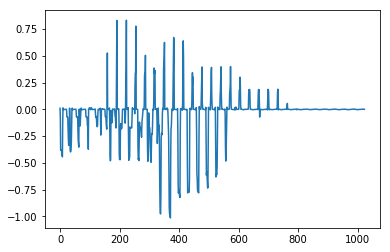

In [4]:
ellipses = sio.loadmat('./data/Ellipses_64x64_4.mat')
train = ellipses['downsized_images_train']
test = ellipses['downsized_images_test']

print(train.shape,test.shape)

print(np.max(train),np.mean(train),np.min(train))
print(np.max(test),np.min(test))

# "normalize" train/test set
meanimg = np.mean(train,3)
print(meanimg.shape)

normalize = 200
train= (train-meanimg)/normalize
test = (test-meanimg)/normalize

# Convert to torch 
train = torch.from_numpy(train)
test = torch.from_numpy(test)

plt.figure()
plt.plot(train[:,:,0,1].numpy().reshape((1024,1)))

In [5]:

DC_data = torch.zeros(2*train.size(3),512,1)
for i in range(train.size(3)):
    image = train[:,:,0,i]

    H,W = image.size()
    H2 = int(H/2)
    image = image.contiguous()
    DC_data[2*i] = image[:H2,:].view(512,1)
    DC_data[2*i+1] = image[H2:,:].view(512,1)

DC_testdata = torch.zeros(2*test.size(3),512,1)
for i in range(test.size(3)):
    image = test[:,:,0,i]

    H,W = image.size()
    H2 = int(H/2)
    image = image.contiguous()
    DC_testdata[2*i] = image[:H2,:].view(512,1)
    DC_testdata[2*i+1] = image[H2:,:].view(512,1)        

In [37]:
print(DC_data[:2].size())
inputval = Variable(DC_data[:2]).cuda()
output = net(inputval)



torch.Size([2, 512, 1])


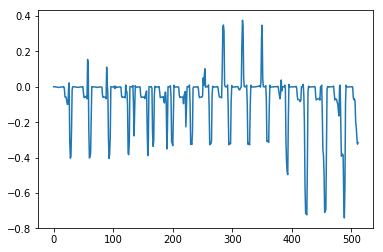

In [70]:
plt.figure()
plt.plot(DC_data[1].numpy())

0.004378804220798644
0.0268122229712775
0.0021196808511897737
0.045306013763640185
0.00012116028507683764
0.004089746695605479
0.005122864930278662
0.08102225125813886


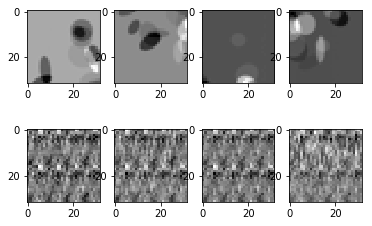

In [71]:
#DC_trainset = torch.utils.data.TensorDataset(DC_data,DC_data)
#DC_trainloader = torch.utils.data.DataLoader(DC_trainset, batch_size=batch_size,shuffle=True)
#dataiter = iter(testloader)
#images, labels = dataiter.next()
for i in range(4):
    img = batchtoimg(DC_data[2*i:2*(i+1)])
    plt.subplot(2,4,i+1)
    # print images
    imshow(img)
    
    inputVal = Variable(DC_data[2*i:2*(i+1)])
    if GPU:
        inputVal = inputVal.cuda()
    output = net(inputVal)
    netimg = batchtoimg(output.data)
    plt.subplot(2,4,4+i+1)
    imshow(netimg)
    print(torch.mean(netimg-img)**2)
    print(torch.mean((DC_data[2*i:2*(i+1)]-output.data.cpu())**2))

    

# Train on a few iterations

In [57]:
N = 512
r = 8
GPU = True
batch_size = 40
net = DeepCodec(r)
if GPU:
    net.cuda()
DC_trainset = torch.utils.data.TensorDataset(DC_data,DC_data)
DC_trainloader = torch.utils.data.DataLoader(DC_trainset, batch_size=batch_size,shuffle=True)
train_net(net, DC_trainloader, num_epochs=60, GPU=GPU,
          weightpath='./weights/',save_epoch=500,
          lr=0.001,momentum=0.9,saveweights=False)

	[1,     1] loss: 0.000, 0.012 seconds elapsed
	[1,     9] loss: 0.003, 0.104 seconds elapsed
	[1,    17] loss: 0.004, 0.243 seconds elapsed
	[1,    25] loss: 0.003, 0.331 seconds elapsed
	[1,    33] loss: 0.003, 0.406 seconds elapsed
	[1,    41] loss: 0.003, 0.486 seconds elapsed
	[1,    49] loss: 0.004, 0.558 seconds elapsed
	[1,    57] loss: 0.002, 0.629 seconds elapsed
	[1,    65] loss: 0.003, 0.703 seconds elapsed
	[1,    73] loss: 0.003, 0.780 seconds elapsed
Epoch 1 Training Time: 0.847 seconds
Total Elapsed Time: 0.847 seconds
	[2,     1] loss: 0.001, 0.011 seconds elapsed
	[2,     9] loss: 0.003, 0.086 seconds elapsed
	[2,    17] loss: 0.003, 0.160 seconds elapsed
	[2,    25] loss: 0.003, 0.234 seconds elapsed
	[2,    33] loss: 0.002, 0.307 seconds elapsed
	[2,    41] loss: 0.002, 0.385 seconds elapsed
	[2,    49] loss: 0.003, 0.453 seconds elapsed
	[2,    57] loss: 0.003, 0.528 seconds elapsed
	[2,    65] loss: 0.001, 0.616 seconds elapsed
	[2,    73] loss: 0.003, 0.684 secon

	[16,    17] loss: 0.001, 0.157 seconds elapsed
	[16,    25] loss: 0.002, 0.229 seconds elapsed
	[16,    33] loss: 0.003, 0.299 seconds elapsed
	[16,    41] loss: 0.002, 0.367 seconds elapsed
	[16,    49] loss: 0.002, 0.437 seconds elapsed
	[16,    57] loss: 0.002, 0.504 seconds elapsed
	[16,    65] loss: 0.003, 0.578 seconds elapsed
	[16,    73] loss: 0.002, 0.650 seconds elapsed
Epoch 16 Training Time: 0.709 seconds
Total Elapsed Time: 12.085 seconds
	[17,     1] loss: 0.000, 0.009 seconds elapsed
	[17,     9] loss: 0.002, 0.093 seconds elapsed
	[17,    17] loss: 0.002, 0.186 seconds elapsed
	[17,    25] loss: 0.003, 0.275 seconds elapsed
	[17,    33] loss: 0.001, 0.364 seconds elapsed
	[17,    41] loss: 0.002, 0.445 seconds elapsed
	[17,    49] loss: 0.002, 0.533 seconds elapsed
	[17,    57] loss: 0.003, 0.624 seconds elapsed
	[17,    65] loss: 0.002, 0.701 seconds elapsed
	[17,    73] loss: 0.002, 0.775 seconds elapsed
Epoch 17 Training Time: 0.836 seconds
Total Elapsed Time: 12.92

	[31,     9] loss: 0.002, 0.102 seconds elapsed
	[31,    17] loss: 0.001, 0.179 seconds elapsed
	[31,    25] loss: 0.003, 0.251 seconds elapsed
	[31,    33] loss: 0.001, 0.324 seconds elapsed
	[31,    41] loss: 0.003, 0.394 seconds elapsed
	[31,    49] loss: 0.002, 0.463 seconds elapsed
	[31,    57] loss: 0.002, 0.532 seconds elapsed
	[31,    65] loss: 0.002, 0.607 seconds elapsed
	[31,    73] loss: 0.003, 0.676 seconds elapsed
Epoch 31 Training Time: 0.737 seconds
Total Elapsed Time: 23.254 seconds
	[32,     1] loss: 0.000, 0.009 seconds elapsed
	[32,     9] loss: 0.001, 0.079 seconds elapsed
	[32,    17] loss: 0.003, 0.146 seconds elapsed
	[32,    25] loss: 0.001, 0.221 seconds elapsed
	[32,    33] loss: 0.003, 0.296 seconds elapsed
	[32,    41] loss: 0.002, 0.364 seconds elapsed
	[32,    49] loss: 0.002, 0.439 seconds elapsed
	[32,    57] loss: 0.003, 0.510 seconds elapsed
	[32,    65] loss: 0.002, 0.582 seconds elapsed
	[32,    73] loss: 0.002, 0.655 seconds elapsed
Epoch 32 Traini

	[46,     9] loss: 0.003, 0.086 seconds elapsed
	[46,    17] loss: 0.002, 0.176 seconds elapsed
	[46,    25] loss: 0.002, 0.254 seconds elapsed
	[46,    33] loss: 0.001, 0.327 seconds elapsed
	[46,    41] loss: 0.002, 0.395 seconds elapsed
	[46,    49] loss: 0.002, 0.463 seconds elapsed
	[46,    57] loss: 0.002, 0.537 seconds elapsed
	[46,    65] loss: 0.002, 0.622 seconds elapsed
	[46,    73] loss: 0.003, 0.705 seconds elapsed
Epoch 46 Training Time: 0.780 seconds
Total Elapsed Time: 34.250 seconds
	[47,     1] loss: 0.000, 0.010 seconds elapsed
	[47,     9] loss: 0.003, 0.081 seconds elapsed
	[47,    17] loss: 0.002, 0.152 seconds elapsed
	[47,    25] loss: 0.003, 0.228 seconds elapsed
	[47,    33] loss: 0.002, 0.298 seconds elapsed
	[47,    41] loss: 0.002, 0.369 seconds elapsed
	[47,    49] loss: 0.002, 0.437 seconds elapsed
	[47,    57] loss: 0.002, 0.512 seconds elapsed
	[47,    65] loss: 0.002, 0.580 seconds elapsed
	[47,    73] loss: 0.002, 0.655 seconds elapsed
Epoch 47 Traini

### Compare to untrained net after 5 epochs

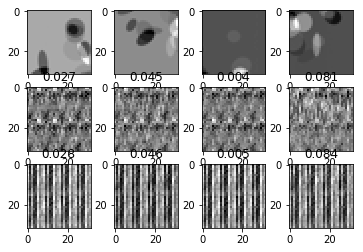

In [72]:
#DC_trainset = torch.utils.data.TensorDataset(DC_data,DC_data)
#DC_trainloader = torch.utils.data.DataLoader(DC_trainset, batch_size=batch_size,shuffle=True)
#dataiter = iter(testloader)
#images, labels = dataiter.next()
untrainednet = DeepCodec(r)
if GPU:
    untrainednet.cuda()
for i in range(4):
    img = batchtoimg(DC_data[2*i:2*(i+1)])
    plt.subplot(3,4,i+1)
    # print images
    imshow(img)
    
    inputVal = Variable(DC_data[2*i:2*(i+1)])
    if GPU:
        inputVal = inputVal.cuda()
    output = net(inputVal)
    netimg = batchtoimg(output.data)
    plt.subplot(3,4,4+i+1)
    imshow(netimg)
    plt.title('%.3f' % torch.mean((img-netimg)**2))
    
    output2 = untrainednet(inputVal)
    netimg2 = batchtoimg(output2.data)
    plt.subplot(3,4,8+i+1)
    imshow(netimg2)
    plt.title('%.3f' % torch.mean((img-netimg2)**2))


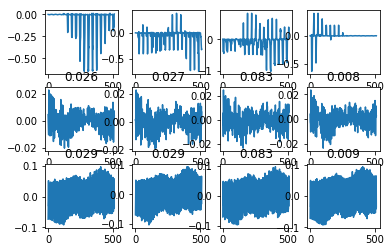

In [73]:
#DC_trainset = torch.utils.data.TensorDataset(DC_data,DC_data)
#DC_trainloader = torch.utils.data.DataLoader(DC_trainset, batch_size=batch_size,shuffle=True)
#dataiter = iter(testloader)
#images, labels = dataiter.next()
untrainednet = DeepCodec(r)
if GPU:
    untrainednet.cuda()
for i in range(4):
    img = DC_data[i]
    plt.subplot(3,4,i+1)
    plt.plot(img.numpy().reshape((512,1)))
    
    inputVal = Variable(DC_data[i].unsqueeze(0))
    if GPU:
        inputVal = inputVal.cuda()
    output = net(inputVal)
    netimg = output.data.cpu()
    plt.subplot(3,4,4+i+1)
    plt.plot(netimg.numpy().reshape((512,1)))
    plt.title('%.3f' % torch.mean((img-netimg)**2))
    
    output2 = untrainednet(inputVal)
    netimg2 =output2.data.cpu()
    plt.subplot(3,4,8+i+1)
    plt.plot(netimg2.numpy().reshape((512,1)))
    plt.title('%.3f' % torch.mean((img-netimg2)**2))


# Train on 5000 epochs

In [75]:
N = 512
r = 8
GPU = True
batch_size = 40
net = DeepCodec(r)
if GPU:
    net.cuda()
DC_trainset = torch.utils.data.TensorDataset(DC_data,DC_data)
DC_trainloader = torch.utils.data.DataLoader(DC_trainset, batch_size=batch_size,shuffle=True)
train_net(net, DC_trainloader, num_epochs=5000, GPU=GPU,
          weightpath='21./weights/',save_epoch=500,
          lr=0.001,momentum=0.9,saveweights=True)

	[1,     1] loss: 0.000, 0.015 seconds elapsed
	[1,     9] loss: 0.004, 0.104 seconds elapsed
	[1,    17] loss: 0.003, 0.179 seconds elapsed
	[1,    25] loss: 0.003, 0.255 seconds elapsed
	[1,    33] loss: 0.004, 0.327 seconds elapsed
	[1,    41] loss: 0.002, 0.399 seconds elapsed
	[1,    49] loss: 0.004, 0.471 seconds elapsed
	[1,    57] loss: 0.002, 0.548 seconds elapsed
	[1,    65] loss: 0.003, 0.617 seconds elapsed
	[1,    73] loss: 0.003, 0.688 seconds elapsed
Epoch 1 Training Time: 0.751 seconds
Total Elapsed Time: 0.751 seconds
	[2,     1] loss: 0.000, 0.009 seconds elapsed
	[2,     9] loss: 0.002, 0.076 seconds elapsed
	[2,    17] loss: 0.003, 0.149 seconds elapsed
	[2,    25] loss: 0.002, 0.235 seconds elapsed
	[2,    33] loss: 0.002, 0.323 seconds elapsed
	[2,    41] loss: 0.003, 0.403 seconds elapsed
	[2,    49] loss: 0.002, 0.474 seconds elapsed
	[2,    57] loss: 0.003, 0.543 seconds elapsed
	[2,    65] loss: 0.003, 0.612 seconds elapsed
	[2,    73] loss: 0.002, 0.687 secon

	[16,     9] loss: 0.002, 0.080 seconds elapsed
	[16,    17] loss: 0.002, 0.175 seconds elapsed
	[16,    25] loss: 0.004, 0.246 seconds elapsed
	[16,    33] loss: 0.002, 0.314 seconds elapsed
	[16,    41] loss: 0.002, 0.388 seconds elapsed
	[16,    49] loss: 0.001, 0.455 seconds elapsed
	[16,    57] loss: 0.002, 0.524 seconds elapsed
	[16,    65] loss: 0.003, 0.601 seconds elapsed
	[16,    73] loss: 0.002, 0.670 seconds elapsed
Epoch 16 Training Time: 0.728 seconds
Total Elapsed Time: 11.786 seconds
	[17,     1] loss: 0.000, 0.011 seconds elapsed
	[17,     9] loss: 0.002, 0.089 seconds elapsed
	[17,    17] loss: 0.002, 0.157 seconds elapsed
	[17,    25] loss: 0.002, 0.230 seconds elapsed
	[17,    33] loss: 0.002, 0.302 seconds elapsed
	[17,    41] loss: 0.003, 0.372 seconds elapsed
	[17,    49] loss: 0.002, 0.440 seconds elapsed
	[17,    57] loss: 0.002, 0.529 seconds elapsed
	[17,    65] loss: 0.002, 0.612 seconds elapsed
	[17,    73] loss: 0.001, 0.690 seconds elapsed
Epoch 17 Traini

	[31,    17] loss: 0.001, 0.183 seconds elapsed
	[31,    25] loss: 0.002, 0.273 seconds elapsed
	[31,    33] loss: 0.002, 0.342 seconds elapsed
	[31,    41] loss: 0.001, 0.414 seconds elapsed
	[31,    49] loss: 0.002, 0.498 seconds elapsed
	[31,    57] loss: 0.003, 0.579 seconds elapsed
	[31,    65] loss: 0.002, 0.665 seconds elapsed
	[31,    73] loss: 0.002, 0.737 seconds elapsed
Epoch 31 Training Time: 0.795 seconds
Total Elapsed Time: 23.038 seconds
	[32,     1] loss: 0.001, 0.010 seconds elapsed
	[32,     9] loss: 0.002, 0.091 seconds elapsed
	[32,    17] loss: 0.004, 0.170 seconds elapsed
	[32,    25] loss: 0.002, 0.249 seconds elapsed
	[32,    33] loss: 0.002, 0.322 seconds elapsed
	[32,    41] loss: 0.002, 0.394 seconds elapsed
	[32,    49] loss: 0.002, 0.469 seconds elapsed
	[32,    57] loss: 0.002, 0.563 seconds elapsed
	[32,    65] loss: 0.002, 0.648 seconds elapsed
	[32,    73] loss: 0.002, 0.730 seconds elapsed
Epoch 32 Training Time: 0.802 seconds
Total Elapsed Time: 23.84

	[46,    17] loss: 0.002, 0.176 seconds elapsed
	[46,    25] loss: 0.002, 0.255 seconds elapsed
	[46,    33] loss: 0.002, 0.327 seconds elapsed
	[46,    41] loss: 0.002, 0.400 seconds elapsed
	[46,    49] loss: 0.002, 0.475 seconds elapsed
	[46,    57] loss: 0.002, 0.543 seconds elapsed
	[46,    65] loss: 0.002, 0.614 seconds elapsed
	[46,    73] loss: 0.002, 0.692 seconds elapsed
Epoch 46 Training Time: 0.751 seconds
Total Elapsed Time: 34.543 seconds
	[47,     1] loss: 0.000, 0.010 seconds elapsed
	[47,     9] loss: 0.001, 0.080 seconds elapsed
	[47,    17] loss: 0.002, 0.154 seconds elapsed
	[47,    25] loss: 0.002, 0.224 seconds elapsed
	[47,    33] loss: 0.002, 0.318 seconds elapsed
	[47,    41] loss: 0.002, 0.389 seconds elapsed
	[47,    49] loss: 0.002, 0.460 seconds elapsed
	[47,    57] loss: 0.002, 0.532 seconds elapsed
	[47,    65] loss: 0.002, 0.607 seconds elapsed
	[47,    73] loss: 0.002, 0.675 seconds elapsed
Epoch 47 Training Time: 0.740 seconds
Total Elapsed Time: 35.28

	[61,     9] loss: 0.002, 0.080 seconds elapsed
	[61,    17] loss: 0.002, 0.156 seconds elapsed
	[61,    25] loss: 0.001, 0.224 seconds elapsed
	[61,    33] loss: 0.002, 0.295 seconds elapsed
	[61,    41] loss: 0.002, 0.368 seconds elapsed
	[61,    49] loss: 0.002, 0.445 seconds elapsed
	[61,    57] loss: 0.002, 0.520 seconds elapsed
	[61,    65] loss: 0.002, 0.592 seconds elapsed
	[61,    73] loss: 0.002, 0.663 seconds elapsed
Epoch 61 Training Time: 0.722 seconds
Total Elapsed Time: 45.783 seconds
	[62,     1] loss: 0.000, 0.013 seconds elapsed
	[62,     9] loss: 0.002, 0.090 seconds elapsed
	[62,    17] loss: 0.002, 0.160 seconds elapsed
	[62,    25] loss: 0.002, 0.234 seconds elapsed
	[62,    33] loss: 0.002, 0.320 seconds elapsed
	[62,    41] loss: 0.002, 0.400 seconds elapsed
	[62,    49] loss: 0.002, 0.473 seconds elapsed
	[62,    57] loss: 0.002, 0.545 seconds elapsed
	[62,    65] loss: 0.003, 0.617 seconds elapsed
	[62,    73] loss: 0.002, 0.688 seconds elapsed
Epoch 62 Traini

	[76,    17] loss: 0.003, 0.171 seconds elapsed
	[76,    25] loss: 0.002, 0.244 seconds elapsed
	[76,    33] loss: 0.002, 0.312 seconds elapsed
	[76,    41] loss: 0.002, 0.382 seconds elapsed
	[76,    49] loss: 0.003, 0.458 seconds elapsed
	[76,    57] loss: 0.001, 0.529 seconds elapsed
	[76,    65] loss: 0.002, 0.602 seconds elapsed
	[76,    73] loss: 0.002, 0.678 seconds elapsed
Epoch 76 Training Time: 0.738 seconds
Total Elapsed Time: 56.838 seconds
	[77,     1] loss: 0.000, 0.009 seconds elapsed
	[77,     9] loss: 0.002, 0.080 seconds elapsed
	[77,    17] loss: 0.002, 0.162 seconds elapsed
	[77,    25] loss: 0.001, 0.234 seconds elapsed
	[77,    33] loss: 0.001, 0.302 seconds elapsed
	[77,    41] loss: 0.003, 0.379 seconds elapsed
	[77,    49] loss: 0.002, 0.454 seconds elapsed
	[77,    57] loss: 0.002, 0.537 seconds elapsed
	[77,    65] loss: 0.002, 0.609 seconds elapsed
	[77,    73] loss: 0.003, 0.682 seconds elapsed
Epoch 77 Training Time: 0.741 seconds
Total Elapsed Time: 57.58

	[91,    17] loss: 0.001, 0.149 seconds elapsed
	[91,    25] loss: 0.002, 0.228 seconds elapsed
	[91,    33] loss: 0.002, 0.317 seconds elapsed
	[91,    41] loss: 0.002, 0.395 seconds elapsed
	[91,    49] loss: 0.002, 0.466 seconds elapsed
	[91,    57] loss: 0.002, 0.535 seconds elapsed
	[91,    65] loss: 0.002, 0.604 seconds elapsed
	[91,    73] loss: 0.002, 0.681 seconds elapsed
Epoch 91 Training Time: 0.741 seconds
Total Elapsed Time: 67.900 seconds
	[92,     1] loss: 0.000, 0.008 seconds elapsed
	[92,     9] loss: 0.002, 0.079 seconds elapsed
	[92,    17] loss: 0.002, 0.153 seconds elapsed
	[92,    25] loss: 0.001, 0.221 seconds elapsed
	[92,    33] loss: 0.001, 0.296 seconds elapsed
	[92,    41] loss: 0.003, 0.369 seconds elapsed
	[92,    49] loss: 0.002, 0.436 seconds elapsed
	[92,    57] loss: 0.002, 0.507 seconds elapsed
	[92,    65] loss: 0.002, 0.583 seconds elapsed
	[92,    73] loss: 0.002, 0.664 seconds elapsed
Epoch 92 Training Time: 0.744 seconds
Total Elapsed Time: 68.64

	[106,     9] loss: 0.003, 0.081 seconds elapsed
	[106,    17] loss: 0.001, 0.152 seconds elapsed
	[106,    25] loss: 0.003, 0.220 seconds elapsed
	[106,    33] loss: 0.003, 0.290 seconds elapsed
	[106,    41] loss: 0.002, 0.367 seconds elapsed
	[106,    49] loss: 0.003, 0.439 seconds elapsed
	[106,    57] loss: 0.001, 0.525 seconds elapsed
	[106,    65] loss: 0.002, 0.605 seconds elapsed
	[106,    73] loss: 0.001, 0.673 seconds elapsed
Epoch 106 Training Time: 0.739 seconds
Total Elapsed Time: 78.918 seconds
	[107,     1] loss: 0.000, 0.011 seconds elapsed
	[107,     9] loss: 0.002, 0.087 seconds elapsed
	[107,    17] loss: 0.001, 0.154 seconds elapsed
	[107,    25] loss: 0.002, 0.229 seconds elapsed
	[107,    33] loss: 0.002, 0.306 seconds elapsed
	[107,    41] loss: 0.003, 0.377 seconds elapsed
	[107,    49] loss: 0.002, 0.451 seconds elapsed
	[107,    57] loss: 0.002, 0.522 seconds elapsed
	[107,    65] loss: 0.002, 0.591 seconds elapsed
	[107,    73] loss: 0.002, 0.659 seconds ela

	[120,    65] loss: 0.003, 0.603 seconds elapsed
	[120,    73] loss: 0.003, 0.680 seconds elapsed
Epoch 120 Training Time: 0.741 seconds
Total Elapsed Time: 89.237 seconds
	[121,     1] loss: 0.000, 0.009 seconds elapsed
	[121,     9] loss: 0.002, 0.082 seconds elapsed
	[121,    17] loss: 0.002, 0.160 seconds elapsed
	[121,    25] loss: 0.002, 0.230 seconds elapsed
	[121,    33] loss: 0.002, 0.301 seconds elapsed
	[121,    41] loss: 0.003, 0.375 seconds elapsed
	[121,    49] loss: 0.003, 0.444 seconds elapsed
	[121,    57] loss: 0.002, 0.512 seconds elapsed
	[121,    65] loss: 0.003, 0.586 seconds elapsed
	[121,    73] loss: 0.001, 0.656 seconds elapsed
Epoch 121 Training Time: 0.737 seconds
Total Elapsed Time: 89.974 seconds
	[122,     1] loss: 0.000, 0.011 seconds elapsed
	[122,     9] loss: 0.002, 0.087 seconds elapsed
	[122,    17] loss: 0.001, 0.156 seconds elapsed
	[122,    25] loss: 0.001, 0.227 seconds elapsed
	[122,    33] loss: 0.003, 0.300 seconds elapsed
	[122,    41] loss:

	[135,    41] loss: 0.002, 0.351 seconds elapsed
	[135,    49] loss: 0.002, 0.429 seconds elapsed
	[135,    57] loss: 0.001, 0.497 seconds elapsed
	[135,    65] loss: 0.001, 0.574 seconds elapsed
	[135,    73] loss: 0.002, 0.669 seconds elapsed
Epoch 135 Training Time: 0.729 seconds
Total Elapsed Time: 100.185 seconds
	[136,     1] loss: 0.000, 0.009 seconds elapsed
	[136,     9] loss: 0.002, 0.082 seconds elapsed
	[136,    17] loss: 0.002, 0.152 seconds elapsed
	[136,    25] loss: 0.001, 0.220 seconds elapsed
	[136,    33] loss: 0.002, 0.294 seconds elapsed
	[136,    41] loss: 0.002, 0.369 seconds elapsed
	[136,    49] loss: 0.002, 0.435 seconds elapsed
	[136,    57] loss: 0.002, 0.508 seconds elapsed
	[136,    65] loss: 0.002, 0.585 seconds elapsed
	[136,    73] loss: 0.002, 0.651 seconds elapsed
Epoch 136 Training Time: 0.716 seconds
Total Elapsed Time: 100.901 seconds
	[137,     1] loss: 0.000, 0.012 seconds elapsed
	[137,     9] loss: 0.001, 0.084 seconds elapsed
	[137,    17] los

	[150,    17] loss: 0.002, 0.149 seconds elapsed
	[150,    25] loss: 0.002, 0.226 seconds elapsed
	[150,    33] loss: 0.003, 0.293 seconds elapsed
	[150,    41] loss: 0.002, 0.363 seconds elapsed
	[150,    49] loss: 0.002, 0.435 seconds elapsed
	[150,    57] loss: 0.002, 0.502 seconds elapsed
	[150,    65] loss: 0.002, 0.570 seconds elapsed
	[150,    73] loss: 0.002, 0.643 seconds elapsed
Epoch 150 Training Time: 0.704 seconds
Total Elapsed Time: 111.096 seconds
	[151,     1] loss: 0.001, 0.009 seconds elapsed
	[151,     9] loss: 0.004, 0.082 seconds elapsed
	[151,    17] loss: 0.003, 0.155 seconds elapsed
	[151,    25] loss: 0.001, 0.239 seconds elapsed
	[151,    33] loss: 0.001, 0.313 seconds elapsed
	[151,    41] loss: 0.001, 0.385 seconds elapsed
	[151,    49] loss: 0.003, 0.452 seconds elapsed
	[151,    57] loss: 0.002, 0.527 seconds elapsed
	[151,    65] loss: 0.001, 0.605 seconds elapsed
	[151,    73] loss: 0.001, 0.672 seconds elapsed
Epoch 151 Training Time: 0.733 seconds
Tota

	[164,    73] loss: 0.002, 0.653 seconds elapsed
Epoch 164 Training Time: 0.718 seconds
Total Elapsed Time: 121.307 seconds
	[165,     1] loss: 0.001, 0.008 seconds elapsed
	[165,     9] loss: 0.002, 0.081 seconds elapsed
	[165,    17] loss: 0.002, 0.169 seconds elapsed
	[165,    25] loss: 0.002, 0.240 seconds elapsed
	[165,    33] loss: 0.001, 0.307 seconds elapsed
	[165,    41] loss: 0.002, 0.380 seconds elapsed
	[165,    49] loss: 0.003, 0.456 seconds elapsed
	[165,    57] loss: 0.003, 0.526 seconds elapsed
	[165,    65] loss: 0.001, 0.598 seconds elapsed
	[165,    73] loss: 0.002, 0.674 seconds elapsed
Epoch 165 Training Time: 0.735 seconds
Total Elapsed Time: 122.043 seconds
	[166,     1] loss: 0.000, 0.009 seconds elapsed
	[166,     9] loss: 0.002, 0.078 seconds elapsed
	[166,    17] loss: 0.002, 0.155 seconds elapsed
	[166,    25] loss: 0.004, 0.224 seconds elapsed
	[166,    33] loss: 0.001, 0.298 seconds elapsed
	[166,    41] loss: 0.002, 0.376 seconds elapsed
	[166,    49] los

	[179,    41] loss: 0.002, 0.389 seconds elapsed
	[179,    49] loss: 0.002, 0.467 seconds elapsed
	[179,    57] loss: 0.003, 0.540 seconds elapsed
	[179,    65] loss: 0.003, 0.613 seconds elapsed
	[179,    73] loss: 0.002, 0.693 seconds elapsed
Epoch 179 Training Time: 0.757 seconds
Total Elapsed Time: 132.275 seconds
	[180,     1] loss: 0.000, 0.009 seconds elapsed
	[180,     9] loss: 0.003, 0.083 seconds elapsed
	[180,    17] loss: 0.001, 0.158 seconds elapsed
	[180,    25] loss: 0.002, 0.227 seconds elapsed
	[180,    33] loss: 0.003, 0.296 seconds elapsed
	[180,    41] loss: 0.002, 0.379 seconds elapsed
	[180,    49] loss: 0.002, 0.457 seconds elapsed
	[180,    57] loss: 0.002, 0.534 seconds elapsed
	[180,    65] loss: 0.001, 0.604 seconds elapsed
	[180,    73] loss: 0.002, 0.672 seconds elapsed
Epoch 180 Training Time: 0.730 seconds
Total Elapsed Time: 133.005 seconds
	[181,     1] loss: 0.000, 0.010 seconds elapsed
	[181,     9] loss: 0.002, 0.086 seconds elapsed
	[181,    17] los

	[194,    17] loss: 0.003, 0.148 seconds elapsed
	[194,    25] loss: 0.002, 0.233 seconds elapsed
	[194,    33] loss: 0.001, 0.315 seconds elapsed
	[194,    41] loss: 0.002, 0.392 seconds elapsed
	[194,    49] loss: 0.001, 0.459 seconds elapsed
	[194,    57] loss: 0.002, 0.527 seconds elapsed
	[194,    65] loss: 0.003, 0.598 seconds elapsed
	[194,    73] loss: 0.002, 0.675 seconds elapsed
Epoch 194 Training Time: 0.736 seconds
Total Elapsed Time: 143.236 seconds
	[195,     1] loss: 0.000, 0.009 seconds elapsed
	[195,     9] loss: 0.001, 0.075 seconds elapsed
	[195,    17] loss: 0.003, 0.145 seconds elapsed
	[195,    25] loss: 0.002, 0.219 seconds elapsed
	[195,    33] loss: 0.002, 0.285 seconds elapsed
	[195,    41] loss: 0.002, 0.355 seconds elapsed
	[195,    49] loss: 0.002, 0.429 seconds elapsed
	[195,    57] loss: 0.001, 0.501 seconds elapsed
	[195,    65] loss: 0.002, 0.570 seconds elapsed
	[195,    73] loss: 0.002, 0.660 seconds elapsed
Epoch 195 Training Time: 0.726 seconds
Tota

	[208,    73] loss: 0.003, 0.686 seconds elapsed
Epoch 208 Training Time: 0.751 seconds
Total Elapsed Time: 153.873 seconds
	[209,     1] loss: 0.000, 0.008 seconds elapsed
	[209,     9] loss: 0.002, 0.084 seconds elapsed
	[209,    17] loss: 0.002, 0.165 seconds elapsed
	[209,    25] loss: 0.002, 0.253 seconds elapsed
	[209,    33] loss: 0.002, 0.333 seconds elapsed
	[209,    41] loss: 0.002, 0.413 seconds elapsed
	[209,    49] loss: 0.002, 0.488 seconds elapsed
	[209,    57] loss: 0.002, 0.555 seconds elapsed
	[209,    65] loss: 0.002, 0.625 seconds elapsed
	[209,    73] loss: 0.002, 0.698 seconds elapsed
Epoch 209 Training Time: 0.762 seconds
Total Elapsed Time: 154.636 seconds
	[210,     1] loss: 0.000, 0.009 seconds elapsed
	[210,     9] loss: 0.001, 0.083 seconds elapsed
	[210,    17] loss: 0.003, 0.158 seconds elapsed
	[210,    25] loss: 0.002, 0.227 seconds elapsed
	[210,    33] loss: 0.002, 0.301 seconds elapsed
	[210,    41] loss: 0.002, 0.376 seconds elapsed
	[210,    49] los

	[223,    41] loss: 0.002, 0.358 seconds elapsed
	[223,    49] loss: 0.002, 0.434 seconds elapsed
	[223,    57] loss: 0.002, 0.503 seconds elapsed
	[223,    65] loss: 0.001, 0.576 seconds elapsed
	[223,    73] loss: 0.003, 0.646 seconds elapsed
Epoch 223 Training Time: 0.714 seconds
Total Elapsed Time: 165.366 seconds
	[224,     1] loss: 0.000, 0.013 seconds elapsed
	[224,     9] loss: 0.002, 0.097 seconds elapsed
	[224,    17] loss: 0.001, 0.166 seconds elapsed
	[224,    25] loss: 0.001, 0.234 seconds elapsed
	[224,    33] loss: 0.002, 0.305 seconds elapsed
	[224,    41] loss: 0.002, 0.382 seconds elapsed
	[224,    49] loss: 0.002, 0.452 seconds elapsed
	[224,    57] loss: 0.002, 0.523 seconds elapsed
	[224,    65] loss: 0.002, 0.598 seconds elapsed
	[224,    73] loss: 0.003, 0.664 seconds elapsed
Epoch 224 Training Time: 0.723 seconds
Total Elapsed Time: 166.089 seconds
	[225,     1] loss: 0.000, 0.012 seconds elapsed
	[225,     9] loss: 0.001, 0.090 seconds elapsed
	[225,    17] los

	[238,    17] loss: 0.002, 0.149 seconds elapsed
	[238,    25] loss: 0.001, 0.224 seconds elapsed
	[238,    33] loss: 0.003, 0.291 seconds elapsed
	[238,    41] loss: 0.003, 0.364 seconds elapsed
	[238,    49] loss: 0.002, 0.437 seconds elapsed
	[238,    57] loss: 0.002, 0.503 seconds elapsed
	[238,    65] loss: 0.001, 0.573 seconds elapsed
	[238,    73] loss: 0.001, 0.649 seconds elapsed
Epoch 238 Training Time: 0.711 seconds
Total Elapsed Time: 176.547 seconds
	[239,     1] loss: 0.000, 0.009 seconds elapsed
	[239,     9] loss: 0.002, 0.081 seconds elapsed
	[239,    17] loss: 0.002, 0.187 seconds elapsed
	[239,    25] loss: 0.002, 0.256 seconds elapsed
	[239,    33] loss: 0.002, 0.331 seconds elapsed
	[239,    41] loss: 0.001, 0.400 seconds elapsed
	[239,    49] loss: 0.002, 0.466 seconds elapsed
	[239,    57] loss: 0.002, 0.534 seconds elapsed
	[239,    65] loss: 0.002, 0.612 seconds elapsed
	[239,    73] loss: 0.001, 0.684 seconds elapsed
Epoch 239 Training Time: 0.745 seconds
Tota

	[252,    73] loss: 0.002, 0.736 seconds elapsed
Epoch 252 Training Time: 0.796 seconds
Total Elapsed Time: 186.968 seconds
	[253,     1] loss: 0.000, 0.009 seconds elapsed
	[253,     9] loss: 0.003, 0.078 seconds elapsed
	[253,    17] loss: 0.001, 0.150 seconds elapsed
	[253,    25] loss: 0.002, 0.228 seconds elapsed
	[253,    33] loss: 0.001, 0.302 seconds elapsed
	[253,    41] loss: 0.002, 0.378 seconds elapsed
	[253,    49] loss: 0.001, 0.460 seconds elapsed
	[253,    57] loss: 0.001, 0.541 seconds elapsed
	[253,    65] loss: 0.003, 0.624 seconds elapsed
	[253,    73] loss: 0.002, 0.694 seconds elapsed
Epoch 253 Training Time: 0.754 seconds
Total Elapsed Time: 187.723 seconds
	[254,     1] loss: 0.000, 0.008 seconds elapsed
	[254,     9] loss: 0.002, 0.077 seconds elapsed
	[254,    17] loss: 0.002, 0.150 seconds elapsed
	[254,    25] loss: 0.002, 0.242 seconds elapsed
	[254,    33] loss: 0.002, 0.329 seconds elapsed
	[254,    41] loss: 0.002, 0.397 seconds elapsed
	[254,    49] los

	[267,    49] loss: 0.001, 0.434 seconds elapsed
	[267,    57] loss: 0.002, 0.515 seconds elapsed
	[267,    65] loss: 0.002, 0.583 seconds elapsed
	[267,    73] loss: 0.001, 0.653 seconds elapsed
Epoch 267 Training Time: 0.718 seconds
Total Elapsed Time: 197.951 seconds
	[268,     1] loss: 0.000, 0.009 seconds elapsed
	[268,     9] loss: 0.002, 0.083 seconds elapsed
	[268,    17] loss: 0.002, 0.166 seconds elapsed
	[268,    25] loss: 0.002, 0.239 seconds elapsed
	[268,    33] loss: 0.001, 0.309 seconds elapsed
	[268,    41] loss: 0.002, 0.375 seconds elapsed
	[268,    49] loss: 0.001, 0.453 seconds elapsed
	[268,    57] loss: 0.002, 0.521 seconds elapsed
	[268,    65] loss: 0.002, 0.592 seconds elapsed
	[268,    73] loss: 0.002, 0.664 seconds elapsed
Epoch 268 Training Time: 0.722 seconds
Total Elapsed Time: 198.674 seconds
	[269,     1] loss: 0.000, 0.009 seconds elapsed
	[269,     9] loss: 0.002, 0.075 seconds elapsed
	[269,    17] loss: 0.001, 0.149 seconds elapsed
	[269,    25] los

	[282,     9] loss: 0.001, 0.120 seconds elapsed
	[282,    17] loss: 0.002, 0.193 seconds elapsed
	[282,    25] loss: 0.001, 0.259 seconds elapsed
	[282,    33] loss: 0.002, 0.326 seconds elapsed
	[282,    41] loss: 0.003, 0.404 seconds elapsed
	[282,    49] loss: 0.001, 0.481 seconds elapsed
	[282,    57] loss: 0.002, 0.555 seconds elapsed
	[282,    65] loss: 0.002, 0.625 seconds elapsed
	[282,    73] loss: 0.003, 0.691 seconds elapsed
Epoch 282 Training Time: 0.751 seconds
Total Elapsed Time: 208.852 seconds
	[283,     1] loss: 0.000, 0.010 seconds elapsed
	[283,     9] loss: 0.001, 0.084 seconds elapsed
	[283,    17] loss: 0.002, 0.151 seconds elapsed
	[283,    25] loss: 0.001, 0.221 seconds elapsed
	[283,    33] loss: 0.003, 0.294 seconds elapsed
	[283,    41] loss: 0.001, 0.361 seconds elapsed
	[283,    49] loss: 0.004, 0.448 seconds elapsed
	[283,    57] loss: 0.002, 0.543 seconds elapsed
	[283,    65] loss: 0.003, 0.617 seconds elapsed
	[283,    73] loss: 0.001, 0.695 seconds el

	[296,    57] loss: 0.003, 0.518 seconds elapsed
	[296,    65] loss: 0.001, 0.596 seconds elapsed
	[296,    73] loss: 0.002, 0.665 seconds elapsed
Epoch 296 Training Time: 0.738 seconds
Total Elapsed Time: 219.502 seconds
	[297,     1] loss: 0.000, 0.014 seconds elapsed
	[297,     9] loss: 0.002, 0.092 seconds elapsed
	[297,    17] loss: 0.002, 0.159 seconds elapsed
	[297,    25] loss: 0.002, 0.243 seconds elapsed
	[297,    33] loss: 0.002, 0.321 seconds elapsed
	[297,    41] loss: 0.001, 0.393 seconds elapsed
	[297,    49] loss: 0.002, 0.465 seconds elapsed
	[297,    57] loss: 0.002, 0.545 seconds elapsed
	[297,    65] loss: 0.001, 0.613 seconds elapsed
	[297,    73] loss: 0.002, 0.683 seconds elapsed
Epoch 297 Training Time: 0.747 seconds
Total Elapsed Time: 220.250 seconds
	[298,     1] loss: 0.000, 0.009 seconds elapsed
	[298,     9] loss: 0.001, 0.076 seconds elapsed
	[298,    17] loss: 0.002, 0.143 seconds elapsed
	[298,    25] loss: 0.002, 0.217 seconds elapsed
	[298,    33] los

	[311,    25] loss: 0.002, 0.236 seconds elapsed
	[311,    33] loss: 0.002, 0.311 seconds elapsed
	[311,    41] loss: 0.002, 0.380 seconds elapsed
	[311,    49] loss: 0.001, 0.450 seconds elapsed
	[311,    57] loss: 0.002, 0.526 seconds elapsed
	[311,    65] loss: 0.002, 0.594 seconds elapsed
	[311,    73] loss: 0.002, 0.665 seconds elapsed
Epoch 311 Training Time: 0.734 seconds
Total Elapsed Time: 230.711 seconds
	[312,     1] loss: 0.000, 0.012 seconds elapsed
	[312,     9] loss: 0.001, 0.103 seconds elapsed
	[312,    17] loss: 0.002, 0.177 seconds elapsed
	[312,    25] loss: 0.002, 0.247 seconds elapsed
	[312,    33] loss: 0.003, 0.312 seconds elapsed
	[312,    41] loss: 0.002, 0.378 seconds elapsed
	[312,    49] loss: 0.001, 0.454 seconds elapsed
	[312,    57] loss: 0.001, 0.525 seconds elapsed
	[312,    65] loss: 0.002, 0.595 seconds elapsed
	[312,    73] loss: 0.002, 0.672 seconds elapsed
Epoch 312 Training Time: 0.732 seconds
Total Elapsed Time: 231.443 seconds
	[313,     1] los

	[325,    73] loss: 0.002, 0.668 seconds elapsed
Epoch 325 Training Time: 0.752 seconds
Total Elapsed Time: 240.927 seconds
	[326,     1] loss: 0.000, 0.012 seconds elapsed
	[326,     9] loss: 0.002, 0.081 seconds elapsed
	[326,    17] loss: 0.002, 0.149 seconds elapsed
	[326,    25] loss: 0.002, 0.222 seconds elapsed
	[326,    33] loss: 0.002, 0.289 seconds elapsed
	[326,    41] loss: 0.002, 0.359 seconds elapsed
	[326,    49] loss: 0.003, 0.433 seconds elapsed
	[326,    57] loss: 0.001, 0.503 seconds elapsed
	[326,    65] loss: 0.002, 0.572 seconds elapsed
	[326,    73] loss: 0.001, 0.646 seconds elapsed
Epoch 326 Training Time: 0.704 seconds
Total Elapsed Time: 241.631 seconds
	[327,     1] loss: 0.000, 0.008 seconds elapsed
	[327,     9] loss: 0.002, 0.076 seconds elapsed
	[327,    17] loss: 0.002, 0.148 seconds elapsed
	[327,    25] loss: 0.001, 0.216 seconds elapsed
	[327,    33] loss: 0.002, 0.286 seconds elapsed
	[327,    41] loss: 0.002, 0.372 seconds elapsed
	[327,    49] los

	[340,    49] loss: 0.001, 0.434 seconds elapsed
	[340,    57] loss: 0.003, 0.508 seconds elapsed
	[340,    65] loss: 0.002, 0.574 seconds elapsed
	[340,    73] loss: 0.001, 0.641 seconds elapsed
Epoch 340 Training Time: 0.708 seconds
Total Elapsed Time: 251.752 seconds
	[341,     1] loss: 0.000, 0.008 seconds elapsed
	[341,     9] loss: 0.002, 0.078 seconds elapsed
	[341,    17] loss: 0.002, 0.144 seconds elapsed
	[341,    25] loss: 0.002, 0.217 seconds elapsed
	[341,    33] loss: 0.003, 0.286 seconds elapsed
	[341,    41] loss: 0.001, 0.369 seconds elapsed
	[341,    49] loss: 0.001, 0.453 seconds elapsed
	[341,    57] loss: 0.003, 0.519 seconds elapsed
	[341,    65] loss: 0.001, 0.586 seconds elapsed
	[341,    73] loss: 0.001, 0.667 seconds elapsed
Epoch 341 Training Time: 0.724 seconds
Total Elapsed Time: 252.477 seconds
	[342,     1] loss: 0.000, 0.008 seconds elapsed
	[342,     9] loss: 0.002, 0.078 seconds elapsed
	[342,    17] loss: 0.002, 0.151 seconds elapsed
	[342,    25] los

	[355,    17] loss: 0.002, 0.145 seconds elapsed
	[355,    25] loss: 0.002, 0.225 seconds elapsed
	[355,    33] loss: 0.002, 0.298 seconds elapsed
	[355,    41] loss: 0.002, 0.373 seconds elapsed
	[355,    49] loss: 0.002, 0.475 seconds elapsed
	[355,    57] loss: 0.002, 0.541 seconds elapsed
	[355,    65] loss: 0.001, 0.612 seconds elapsed
	[355,    73] loss: 0.001, 0.677 seconds elapsed
Epoch 355 Training Time: 0.734 seconds
Total Elapsed Time: 262.569 seconds
	[356,     1] loss: 0.000, 0.008 seconds elapsed
	[356,     9] loss: 0.002, 0.077 seconds elapsed
	[356,    17] loss: 0.002, 0.150 seconds elapsed
	[356,    25] loss: 0.002, 0.220 seconds elapsed
	[356,    33] loss: 0.002, 0.290 seconds elapsed
	[356,    41] loss: 0.003, 0.363 seconds elapsed
	[356,    49] loss: 0.002, 0.429 seconds elapsed
	[356,    57] loss: 0.001, 0.495 seconds elapsed
	[356,    65] loss: 0.001, 0.570 seconds elapsed
	[356,    73] loss: 0.001, 0.636 seconds elapsed
Epoch 356 Training Time: 0.695 seconds
Tota

	[369,    73] loss: 0.001, 0.676 seconds elapsed
Epoch 369 Training Time: 0.736 seconds
Total Elapsed Time: 272.596 seconds
	[370,     1] loss: 0.000, 0.008 seconds elapsed
	[370,     9] loss: 0.002, 0.073 seconds elapsed
	[370,    17] loss: 0.002, 0.146 seconds elapsed
	[370,    25] loss: 0.001, 0.217 seconds elapsed
	[370,    33] loss: 0.001, 0.282 seconds elapsed
	[370,    41] loss: 0.002, 0.348 seconds elapsed
	[370,    49] loss: 0.001, 0.419 seconds elapsed
	[370,    57] loss: 0.003, 0.484 seconds elapsed
	[370,    65] loss: 0.002, 0.550 seconds elapsed
	[370,    73] loss: 0.002, 0.629 seconds elapsed
Epoch 370 Training Time: 0.698 seconds
Total Elapsed Time: 273.295 seconds
	[371,     1] loss: 0.000, 0.009 seconds elapsed
	[371,     9] loss: 0.002, 0.081 seconds elapsed
	[371,    17] loss: 0.001, 0.156 seconds elapsed
	[371,    25] loss: 0.003, 0.261 seconds elapsed
	[371,    33] loss: 0.002, 0.334 seconds elapsed
	[371,    41] loss: 0.001, 0.400 seconds elapsed
	[371,    49] los

	[384,    49] loss: 0.001, 0.421 seconds elapsed
	[384,    57] loss: 0.002, 0.496 seconds elapsed
	[384,    65] loss: 0.002, 0.566 seconds elapsed
	[384,    73] loss: 0.001, 0.634 seconds elapsed
Epoch 384 Training Time: 0.700 seconds
Total Elapsed Time: 283.346 seconds
	[385,     1] loss: 0.000, 0.008 seconds elapsed
	[385,     9] loss: 0.002, 0.073 seconds elapsed
	[385,    17] loss: 0.001, 0.140 seconds elapsed
	[385,    25] loss: 0.002, 0.214 seconds elapsed
	[385,    33] loss: 0.002, 0.303 seconds elapsed
	[385,    41] loss: 0.002, 0.382 seconds elapsed
	[385,    49] loss: 0.003, 0.457 seconds elapsed
	[385,    57] loss: 0.001, 0.525 seconds elapsed
	[385,    65] loss: 0.002, 0.594 seconds elapsed
	[385,    73] loss: 0.001, 0.665 seconds elapsed
Epoch 385 Training Time: 0.723 seconds
Total Elapsed Time: 284.070 seconds
	[386,     1] loss: 0.000, 0.008 seconds elapsed
	[386,     9] loss: 0.001, 0.073 seconds elapsed
	[386,    17] loss: 0.002, 0.145 seconds elapsed
	[386,    25] los

	[399,    25] loss: 0.003, 0.227 seconds elapsed
	[399,    33] loss: 0.002, 0.298 seconds elapsed
	[399,    41] loss: 0.002, 0.380 seconds elapsed
	[399,    49] loss: 0.001, 0.456 seconds elapsed
	[399,    57] loss: 0.001, 0.528 seconds elapsed
	[399,    65] loss: 0.002, 0.594 seconds elapsed
	[399,    73] loss: 0.002, 0.659 seconds elapsed
Epoch 399 Training Time: 0.729 seconds
Total Elapsed Time: 294.101 seconds
	[400,     1] loss: 0.000, 0.011 seconds elapsed
	[400,     9] loss: 0.001, 0.078 seconds elapsed
	[400,    17] loss: 0.002, 0.146 seconds elapsed
	[400,    25] loss: 0.001, 0.222 seconds elapsed
	[400,    33] loss: 0.001, 0.288 seconds elapsed
	[400,    41] loss: 0.002, 0.358 seconds elapsed
	[400,    49] loss: 0.002, 0.431 seconds elapsed
	[400,    57] loss: 0.001, 0.496 seconds elapsed
	[400,    65] loss: 0.003, 0.562 seconds elapsed
	[400,    73] loss: 0.002, 0.636 seconds elapsed
Epoch 400 Training Time: 0.696 seconds
Total Elapsed Time: 294.797 seconds
	[401,     1] los

Total Elapsed Time: 304.192 seconds
	[414,     1] loss: 0.000, 0.010 seconds elapsed
	[414,     9] loss: 0.002, 0.083 seconds elapsed
	[414,    17] loss: 0.002, 0.149 seconds elapsed
	[414,    25] loss: 0.002, 0.219 seconds elapsed
	[414,    33] loss: 0.002, 0.293 seconds elapsed
	[414,    41] loss: 0.003, 0.366 seconds elapsed
	[414,    49] loss: 0.002, 0.436 seconds elapsed
	[414,    57] loss: 0.002, 0.506 seconds elapsed
	[414,    65] loss: 0.002, 0.573 seconds elapsed
	[414,    73] loss: 0.001, 0.640 seconds elapsed
Epoch 414 Training Time: 0.706 seconds
Total Elapsed Time: 304.899 seconds
	[415,     1] loss: 0.000, 0.009 seconds elapsed
	[415,     9] loss: 0.002, 0.093 seconds elapsed
	[415,    17] loss: 0.002, 0.173 seconds elapsed
	[415,    25] loss: 0.002, 0.253 seconds elapsed
	[415,    33] loss: 0.001, 0.327 seconds elapsed
	[415,    41] loss: 0.002, 0.401 seconds elapsed
	[415,    49] loss: 0.002, 0.477 seconds elapsed
	[415,    57] loss: 0.001, 0.559 seconds elapsed
	[415, 

	[428,    57] loss: 0.001, 0.506 seconds elapsed
	[428,    65] loss: 0.002, 0.581 seconds elapsed
	[428,    73] loss: 0.002, 0.650 seconds elapsed
Epoch 428 Training Time: 0.708 seconds
Total Elapsed Time: 315.013 seconds
	[429,     1] loss: 0.000, 0.011 seconds elapsed
	[429,     9] loss: 0.002, 0.102 seconds elapsed
	[429,    17] loss: 0.001, 0.176 seconds elapsed
	[429,    25] loss: 0.001, 0.250 seconds elapsed
	[429,    33] loss: 0.002, 0.319 seconds elapsed
	[429,    41] loss: 0.002, 0.386 seconds elapsed
	[429,    49] loss: 0.001, 0.453 seconds elapsed
	[429,    57] loss: 0.002, 0.526 seconds elapsed
	[429,    65] loss: 0.002, 0.592 seconds elapsed
	[429,    73] loss: 0.003, 0.664 seconds elapsed
Epoch 429 Training Time: 0.728 seconds
Total Elapsed Time: 315.742 seconds
	[430,     1] loss: 0.000, 0.009 seconds elapsed
	[430,     9] loss: 0.001, 0.078 seconds elapsed
	[430,    17] loss: 0.002, 0.149 seconds elapsed
	[430,    25] loss: 0.002, 0.225 seconds elapsed
	[430,    33] los

	[443,    33] loss: 0.001, 0.322 seconds elapsed
	[443,    41] loss: 0.002, 0.396 seconds elapsed
	[443,    49] loss: 0.002, 0.464 seconds elapsed
	[443,    57] loss: 0.002, 0.530 seconds elapsed
	[443,    65] loss: 0.001, 0.606 seconds elapsed
	[443,    73] loss: 0.002, 0.672 seconds elapsed
Epoch 443 Training Time: 0.730 seconds
Total Elapsed Time: 325.880 seconds
	[444,     1] loss: 0.000, 0.010 seconds elapsed
	[444,     9] loss: 0.002, 0.080 seconds elapsed
	[444,    17] loss: 0.001, 0.147 seconds elapsed
	[444,    25] loss: 0.002, 0.218 seconds elapsed
	[444,    33] loss: 0.001, 0.290 seconds elapsed
	[444,    41] loss: 0.003, 0.357 seconds elapsed
	[444,    49] loss: 0.002, 0.431 seconds elapsed
	[444,    57] loss: 0.001, 0.524 seconds elapsed
	[444,    65] loss: 0.002, 0.594 seconds elapsed
	[444,    73] loss: 0.001, 0.664 seconds elapsed
Epoch 444 Training Time: 0.727 seconds
Total Elapsed Time: 326.608 seconds
	[445,     1] loss: 0.000, 0.009 seconds elapsed
	[445,     9] los

	[458,     9] loss: 0.001, 0.075 seconds elapsed
	[458,    17] loss: 0.002, 0.150 seconds elapsed
	[458,    25] loss: 0.003, 0.216 seconds elapsed
	[458,    33] loss: 0.001, 0.289 seconds elapsed
	[458,    41] loss: 0.002, 0.361 seconds elapsed
	[458,    49] loss: 0.001, 0.428 seconds elapsed
	[458,    57] loss: 0.001, 0.514 seconds elapsed
	[458,    65] loss: 0.002, 0.593 seconds elapsed
	[458,    73] loss: 0.002, 0.663 seconds elapsed
Epoch 458 Training Time: 0.720 seconds
Total Elapsed Time: 336.704 seconds
	[459,     1] loss: 0.000, 0.012 seconds elapsed
	[459,     9] loss: 0.001, 0.083 seconds elapsed
	[459,    17] loss: 0.000, 0.154 seconds elapsed
	[459,    25] loss: 0.003, 0.223 seconds elapsed
	[459,    33] loss: 0.001, 0.294 seconds elapsed
	[459,    41] loss: 0.002, 0.360 seconds elapsed
	[459,    49] loss: 0.002, 0.428 seconds elapsed
	[459,    57] loss: 0.001, 0.500 seconds elapsed
	[459,    65] loss: 0.002, 0.567 seconds elapsed
	[459,    73] loss: 0.001, 0.639 seconds el

	[472,    57] loss: 0.001, 0.517 seconds elapsed
	[472,    65] loss: 0.001, 0.591 seconds elapsed
	[472,    73] loss: 0.001, 0.658 seconds elapsed
Epoch 472 Training Time: 0.716 seconds
Total Elapsed Time: 346.838 seconds
	[473,     1] loss: 0.000, 0.010 seconds elapsed
	[473,     9] loss: 0.001, 0.083 seconds elapsed
	[473,    17] loss: 0.001, 0.150 seconds elapsed
	[473,    25] loss: 0.002, 0.223 seconds elapsed
	[473,    33] loss: 0.002, 0.300 seconds elapsed
	[473,    41] loss: 0.002, 0.368 seconds elapsed
	[473,    49] loss: 0.002, 0.440 seconds elapsed
	[473,    57] loss: 0.002, 0.515 seconds elapsed
	[473,    65] loss: 0.002, 0.585 seconds elapsed
	[473,    73] loss: 0.001, 0.653 seconds elapsed
Epoch 473 Training Time: 0.717 seconds
Total Elapsed Time: 347.555 seconds
	[474,     1] loss: 0.000, 0.009 seconds elapsed
	[474,     9] loss: 0.002, 0.075 seconds elapsed
	[474,    17] loss: 0.002, 0.147 seconds elapsed
	[474,    25] loss: 0.002, 0.234 seconds elapsed
	[474,    33] los

	[487,    33] loss: 0.002, 0.308 seconds elapsed
	[487,    41] loss: 0.001, 0.386 seconds elapsed
	[487,    49] loss: 0.001, 0.455 seconds elapsed
	[487,    57] loss: 0.001, 0.527 seconds elapsed
	[487,    65] loss: 0.002, 0.605 seconds elapsed
	[487,    73] loss: 0.002, 0.672 seconds elapsed
Epoch 487 Training Time: 0.737 seconds
Total Elapsed Time: 357.704 seconds
	[488,     1] loss: 0.000, 0.009 seconds elapsed
	[488,     9] loss: 0.001, 0.080 seconds elapsed
	[488,    17] loss: 0.002, 0.165 seconds elapsed
	[488,    25] loss: 0.001, 0.248 seconds elapsed
	[488,    33] loss: 0.001, 0.318 seconds elapsed
	[488,    41] loss: 0.001, 0.387 seconds elapsed
	[488,    49] loss: 0.002, 0.457 seconds elapsed
	[488,    57] loss: 0.003, 0.534 seconds elapsed
	[488,    65] loss: 0.002, 0.607 seconds elapsed
	[488,    73] loss: 0.002, 0.675 seconds elapsed
Epoch 488 Training Time: 0.738 seconds
Total Elapsed Time: 358.443 seconds
	[489,     1] loss: 0.000, 0.009 seconds elapsed
	[489,     9] los

	[502,     9] loss: 0.001, 0.077 seconds elapsed
	[502,    17] loss: 0.002, 0.165 seconds elapsed
	[502,    25] loss: 0.002, 0.237 seconds elapsed
	[502,    33] loss: 0.003, 0.310 seconds elapsed
	[502,    41] loss: 0.001, 0.379 seconds elapsed
	[502,    49] loss: 0.002, 0.446 seconds elapsed
	[502,    57] loss: 0.001, 0.515 seconds elapsed
	[502,    65] loss: 0.001, 0.591 seconds elapsed
	[502,    73] loss: 0.001, 0.661 seconds elapsed
Epoch 502 Training Time: 0.717 seconds
Total Elapsed Time: 368.537 seconds
	[503,     1] loss: 0.000, 0.010 seconds elapsed
	[503,     9] loss: 0.002, 0.086 seconds elapsed
	[503,    17] loss: 0.001, 0.154 seconds elapsed
	[503,    25] loss: 0.002, 0.224 seconds elapsed
	[503,    33] loss: 0.001, 0.295 seconds elapsed
	[503,    41] loss: 0.001, 0.363 seconds elapsed
	[503,    49] loss: 0.001, 0.431 seconds elapsed
	[503,    57] loss: 0.002, 0.509 seconds elapsed
	[503,    65] loss: 0.002, 0.597 seconds elapsed
	[503,    73] loss: 0.001, 0.670 seconds el

	[516,    65] loss: 0.002, 0.581 seconds elapsed
	[516,    73] loss: 0.001, 0.656 seconds elapsed
Epoch 516 Training Time: 0.717 seconds
Total Elapsed Time: 378.599 seconds
	[517,     1] loss: 0.000, 0.009 seconds elapsed
	[517,     9] loss: 0.001, 0.082 seconds elapsed
	[517,    17] loss: 0.001, 0.154 seconds elapsed
	[517,    25] loss: 0.001, 0.221 seconds elapsed
	[517,    33] loss: 0.001, 0.289 seconds elapsed
	[517,    41] loss: 0.001, 0.360 seconds elapsed
	[517,    49] loss: 0.002, 0.427 seconds elapsed
	[517,    57] loss: 0.002, 0.492 seconds elapsed
	[517,    65] loss: 0.002, 0.582 seconds elapsed
	[517,    73] loss: 0.002, 0.663 seconds elapsed
Epoch 517 Training Time: 0.731 seconds
Total Elapsed Time: 379.330 seconds
	[518,     1] loss: 0.000, 0.010 seconds elapsed
	[518,     9] loss: 0.002, 0.078 seconds elapsed
	[518,    17] loss: 0.002, 0.147 seconds elapsed
	[518,    25] loss: 0.002, 0.215 seconds elapsed
	[518,    33] loss: 0.001, 0.296 seconds elapsed
	[518,    41] los

	[531,    25] loss: 0.002, 0.222 seconds elapsed
	[531,    33] loss: 0.002, 0.297 seconds elapsed
	[531,    41] loss: 0.001, 0.368 seconds elapsed
	[531,    49] loss: 0.001, 0.439 seconds elapsed
	[531,    57] loss: 0.001, 0.512 seconds elapsed
	[531,    65] loss: 0.002, 0.595 seconds elapsed
	[531,    73] loss: 0.001, 0.681 seconds elapsed
Epoch 531 Training Time: 0.741 seconds
Total Elapsed Time: 389.429 seconds
	[532,     1] loss: 0.000, 0.009 seconds elapsed
	[532,     9] loss: 0.002, 0.074 seconds elapsed
	[532,    17] loss: 0.001, 0.139 seconds elapsed
	[532,    25] loss: 0.001, 0.216 seconds elapsed
	[532,    33] loss: 0.001, 0.281 seconds elapsed
	[532,    41] loss: 0.001, 0.347 seconds elapsed
	[532,    49] loss: 0.002, 0.421 seconds elapsed
	[532,    57] loss: 0.002, 0.490 seconds elapsed
	[532,    65] loss: 0.002, 0.557 seconds elapsed
	[532,    73] loss: 0.001, 0.635 seconds elapsed
Epoch 532 Training Time: 0.693 seconds
Total Elapsed Time: 390.122 seconds
	[533,     1] los

Epoch 545 Training Time: 0.712 seconds
Total Elapsed Time: 399.412 seconds
	[546,     1] loss: 0.000, 0.012 seconds elapsed
	[546,     9] loss: 0.001, 0.086 seconds elapsed
	[546,    17] loss: 0.002, 0.152 seconds elapsed
	[546,    25] loss: 0.001, 0.223 seconds elapsed
	[546,    33] loss: 0.001, 0.298 seconds elapsed
	[546,    41] loss: 0.001, 0.365 seconds elapsed
	[546,    49] loss: 0.002, 0.436 seconds elapsed
	[546,    57] loss: 0.001, 0.511 seconds elapsed
	[546,    65] loss: 0.001, 0.578 seconds elapsed
	[546,    73] loss: 0.001, 0.645 seconds elapsed
Epoch 546 Training Time: 0.712 seconds
Total Elapsed Time: 400.125 seconds
	[547,     1] loss: 0.000, 0.009 seconds elapsed
	[547,     9] loss: 0.001, 0.077 seconds elapsed
	[547,    17] loss: 0.001, 0.150 seconds elapsed
	[547,    25] loss: 0.001, 0.223 seconds elapsed
	[547,    33] loss: 0.002, 0.290 seconds elapsed
	[547,    41] loss: 0.001, 0.367 seconds elapsed
	[547,    49] loss: 0.001, 0.453 seconds elapsed
	[547,    57] los

	[560,    41] loss: 0.001, 0.364 seconds elapsed
	[560,    49] loss: 0.002, 0.441 seconds elapsed
	[560,    57] loss: 0.001, 0.507 seconds elapsed
	[560,    65] loss: 0.001, 0.574 seconds elapsed
	[560,    73] loss: 0.001, 0.649 seconds elapsed
Epoch 560 Training Time: 0.711 seconds
Total Elapsed Time: 410.225 seconds
	[561,     1] loss: 0.000, 0.009 seconds elapsed
	[561,     9] loss: 0.001, 0.079 seconds elapsed
	[561,    17] loss: 0.001, 0.151 seconds elapsed
	[561,    25] loss: 0.002, 0.218 seconds elapsed
	[561,    33] loss: 0.001, 0.290 seconds elapsed
	[561,    41] loss: 0.001, 0.386 seconds elapsed
	[561,    49] loss: 0.002, 0.468 seconds elapsed
	[561,    57] loss: 0.002, 0.545 seconds elapsed
	[561,    65] loss: 0.000, 0.616 seconds elapsed
	[561,    73] loss: 0.001, 0.686 seconds elapsed
Epoch 561 Training Time: 0.743 seconds
Total Elapsed Time: 410.969 seconds
	[562,     1] loss: 0.000, 0.010 seconds elapsed
	[562,     9] loss: 0.001, 0.082 seconds elapsed
	[562,    17] los

	[575,    17] loss: 0.001, 0.150 seconds elapsed
	[575,    25] loss: 0.001, 0.223 seconds elapsed
	[575,    33] loss: 0.002, 0.292 seconds elapsed
	[575,    41] loss: 0.001, 0.359 seconds elapsed
	[575,    49] loss: 0.002, 0.443 seconds elapsed
	[575,    57] loss: 0.002, 0.522 seconds elapsed
	[575,    65] loss: 0.002, 0.592 seconds elapsed
	[575,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 575 Training Time: 0.722 seconds
Total Elapsed Time: 421.007 seconds
	[576,     1] loss: 0.000, 0.008 seconds elapsed
	[576,     9] loss: 0.001, 0.075 seconds elapsed
	[576,    17] loss: 0.002, 0.154 seconds elapsed
	[576,    25] loss: 0.001, 0.224 seconds elapsed
	[576,    33] loss: 0.002, 0.298 seconds elapsed
	[576,    41] loss: 0.002, 0.374 seconds elapsed
	[576,    49] loss: 0.001, 0.440 seconds elapsed
	[576,    57] loss: 0.001, 0.506 seconds elapsed
	[576,    65] loss: 0.001, 0.578 seconds elapsed
	[576,    73] loss: 0.001, 0.646 seconds elapsed
Epoch 576 Training Time: 0.703 seconds
Tota

	[589,    65] loss: 0.002, 0.600 seconds elapsed
	[589,    73] loss: 0.001, 0.672 seconds elapsed
Epoch 589 Training Time: 0.731 seconds
Total Elapsed Time: 431.127 seconds
	[590,     1] loss: 0.000, 0.009 seconds elapsed
	[590,     9] loss: 0.002, 0.080 seconds elapsed
	[590,    17] loss: 0.000, 0.154 seconds elapsed
	[590,    25] loss: 0.002, 0.225 seconds elapsed
	[590,    33] loss: 0.001, 0.291 seconds elapsed
	[590,    41] loss: 0.001, 0.364 seconds elapsed
	[590,    49] loss: 0.001, 0.433 seconds elapsed
	[590,    57] loss: 0.002, 0.503 seconds elapsed
	[590,    65] loss: 0.001, 0.578 seconds elapsed
	[590,    73] loss: 0.002, 0.652 seconds elapsed
Epoch 590 Training Time: 0.710 seconds
Total Elapsed Time: 431.836 seconds
	[591,     1] loss: 0.000, 0.010 seconds elapsed
	[591,     9] loss: 0.001, 0.082 seconds elapsed
	[591,    17] loss: 0.002, 0.180 seconds elapsed
	[591,    25] loss: 0.002, 0.259 seconds elapsed
	[591,    33] loss: 0.001, 0.327 seconds elapsed
	[591,    41] los

	[604,    41] loss: 0.001, 0.421 seconds elapsed
	[604,    49] loss: 0.001, 0.493 seconds elapsed
	[604,    57] loss: 0.001, 0.576 seconds elapsed
	[604,    65] loss: 0.001, 0.650 seconds elapsed
	[604,    73] loss: 0.001, 0.729 seconds elapsed
Epoch 604 Training Time: 0.809 seconds
Total Elapsed Time: 442.711 seconds
	[605,     1] loss: 0.000, 0.014 seconds elapsed
	[605,     9] loss: 0.001, 0.106 seconds elapsed
	[605,    17] loss: 0.001, 0.181 seconds elapsed
	[605,    25] loss: 0.002, 0.262 seconds elapsed
	[605,    33] loss: 0.001, 0.345 seconds elapsed
	[605,    41] loss: 0.001, 0.445 seconds elapsed
	[605,    49] loss: 0.001, 0.514 seconds elapsed
	[605,    57] loss: 0.002, 0.612 seconds elapsed
	[605,    65] loss: 0.001, 0.686 seconds elapsed
	[605,    73] loss: 0.001, 0.753 seconds elapsed
Epoch 605 Training Time: 0.811 seconds
Total Elapsed Time: 443.523 seconds
	[606,     1] loss: 0.000, 0.010 seconds elapsed
	[606,     9] loss: 0.001, 0.092 seconds elapsed
	[606,    17] los

	[619,    17] loss: 0.001, 0.179 seconds elapsed
	[619,    25] loss: 0.001, 0.247 seconds elapsed
	[619,    33] loss: 0.002, 0.316 seconds elapsed
	[619,    41] loss: 0.001, 0.388 seconds elapsed
	[619,    49] loss: 0.001, 0.455 seconds elapsed
	[619,    57] loss: 0.001, 0.525 seconds elapsed
	[619,    65] loss: 0.001, 0.593 seconds elapsed
	[619,    73] loss: 0.002, 0.660 seconds elapsed
Epoch 619 Training Time: 0.722 seconds
Total Elapsed Time: 454.132 seconds
	[620,     1] loss: 0.000, 0.009 seconds elapsed
	[620,     9] loss: 0.001, 0.080 seconds elapsed
	[620,    17] loss: 0.001, 0.150 seconds elapsed
	[620,    25] loss: 0.002, 0.216 seconds elapsed
	[620,    33] loss: 0.001, 0.283 seconds elapsed
	[620,    41] loss: 0.001, 0.352 seconds elapsed
	[620,    49] loss: 0.001, 0.418 seconds elapsed
	[620,    57] loss: 0.002, 0.517 seconds elapsed
	[620,    65] loss: 0.001, 0.586 seconds elapsed
	[620,    73] loss: 0.001, 0.650 seconds elapsed
Epoch 620 Training Time: 0.711 seconds
Tota

	[633,    65] loss: 0.001, 0.575 seconds elapsed
	[633,    73] loss: 0.001, 0.640 seconds elapsed
Epoch 633 Training Time: 0.698 seconds
Total Elapsed Time: 464.492 seconds
	[634,     1] loss: 0.000, 0.008 seconds elapsed
	[634,     9] loss: 0.001, 0.073 seconds elapsed
	[634,    17] loss: 0.001, 0.141 seconds elapsed
	[634,    25] loss: 0.002, 0.217 seconds elapsed
	[634,    33] loss: 0.000, 0.300 seconds elapsed
	[634,    41] loss: 0.001, 0.369 seconds elapsed
	[634,    49] loss: 0.001, 0.434 seconds elapsed
	[634,    57] loss: 0.001, 0.501 seconds elapsed
	[634,    65] loss: 0.001, 0.569 seconds elapsed
	[634,    73] loss: 0.001, 0.636 seconds elapsed
Epoch 634 Training Time: 0.695 seconds
Total Elapsed Time: 465.188 seconds
	[635,     1] loss: 0.000, 0.010 seconds elapsed
	[635,     9] loss: 0.002, 0.079 seconds elapsed
	[635,    17] loss: 0.001, 0.148 seconds elapsed
	[635,    25] loss: 0.002, 0.238 seconds elapsed
	[635,    33] loss: 0.001, 0.324 seconds elapsed
	[635,    41] los

	[648,    41] loss: 0.001, 0.380 seconds elapsed
	[648,    49] loss: 0.001, 0.456 seconds elapsed
	[648,    57] loss: 0.001, 0.534 seconds elapsed
	[648,    65] loss: 0.001, 0.611 seconds elapsed
	[648,    73] loss: 0.001, 0.684 seconds elapsed
Epoch 648 Training Time: 0.758 seconds
Total Elapsed Time: 475.988 seconds
	[649,     1] loss: 0.000, 0.011 seconds elapsed
	[649,     9] loss: 0.001, 0.099 seconds elapsed
	[649,    17] loss: 0.001, 0.171 seconds elapsed
	[649,    25] loss: 0.001, 0.248 seconds elapsed
	[649,    33] loss: 0.002, 0.321 seconds elapsed
	[649,    41] loss: 0.001, 0.396 seconds elapsed
	[649,    49] loss: 0.001, 0.468 seconds elapsed
	[649,    57] loss: 0.002, 0.542 seconds elapsed
	[649,    65] loss: 0.001, 0.613 seconds elapsed
	[649,    73] loss: 0.001, 0.684 seconds elapsed
Epoch 649 Training Time: 0.748 seconds
Total Elapsed Time: 476.736 seconds
	[650,     1] loss: 0.000, 0.010 seconds elapsed
	[650,     9] loss: 0.001, 0.086 seconds elapsed
	[650,    17] los

	[663,    25] loss: 0.001, 0.231 seconds elapsed
	[663,    33] loss: 0.001, 0.304 seconds elapsed
	[663,    41] loss: 0.002, 0.371 seconds elapsed
	[663,    49] loss: 0.001, 0.442 seconds elapsed
	[663,    57] loss: 0.001, 0.540 seconds elapsed
	[663,    65] loss: 0.001, 0.637 seconds elapsed
	[663,    73] loss: 0.001, 0.754 seconds elapsed
Epoch 663 Training Time: 0.840 seconds
Total Elapsed Time: 486.953 seconds
	[664,     1] loss: 0.000, 0.015 seconds elapsed
	[664,     9] loss: 0.001, 0.103 seconds elapsed
	[664,    17] loss: 0.001, 0.177 seconds elapsed
	[664,    25] loss: 0.001, 0.257 seconds elapsed
	[664,    33] loss: 0.001, 0.351 seconds elapsed
	[664,    41] loss: 0.001, 0.427 seconds elapsed
	[664,    49] loss: 0.001, 0.500 seconds elapsed
	[664,    57] loss: 0.001, 0.573 seconds elapsed
	[664,    65] loss: 0.002, 0.651 seconds elapsed
	[664,    73] loss: 0.001, 0.727 seconds elapsed
Epoch 664 Training Time: 0.792 seconds
Total Elapsed Time: 487.745 seconds
	[665,     1] los

	[692,    25] loss: 0.001, 0.222 seconds elapsed
	[692,    33] loss: 0.001, 0.290 seconds elapsed
	[692,    41] loss: 0.001, 0.357 seconds elapsed
	[692,    49] loss: 0.001, 0.426 seconds elapsed
	[692,    57] loss: 0.001, 0.498 seconds elapsed
	[692,    65] loss: 0.000, 0.569 seconds elapsed
	[692,    73] loss: 0.001, 0.637 seconds elapsed
Epoch 692 Training Time: 0.698 seconds
Total Elapsed Time: 508.355 seconds
	[693,     1] loss: 0.000, 0.008 seconds elapsed
	[693,     9] loss: 0.001, 0.075 seconds elapsed
	[693,    17] loss: 0.001, 0.142 seconds elapsed
	[693,    25] loss: 0.001, 0.213 seconds elapsed
	[693,    33] loss: 0.001, 0.279 seconds elapsed
	[693,    41] loss: 0.001, 0.356 seconds elapsed
	[693,    49] loss: 0.001, 0.447 seconds elapsed
	[693,    57] loss: 0.001, 0.519 seconds elapsed
	[693,    65] loss: 0.001, 0.590 seconds elapsed
	[693,    73] loss: 0.002, 0.657 seconds elapsed
Epoch 693 Training Time: 0.714 seconds
Total Elapsed Time: 509.070 seconds
	[694,     1] los

Total Elapsed Time: 518.461 seconds
	[707,     1] loss: 0.000, 0.011 seconds elapsed
	[707,     9] loss: 0.001, 0.077 seconds elapsed
	[707,    17] loss: 0.001, 0.150 seconds elapsed
	[707,    25] loss: 0.001, 0.220 seconds elapsed
	[707,    33] loss: 0.001, 0.288 seconds elapsed
	[707,    41] loss: 0.001, 0.354 seconds elapsed
	[707,    49] loss: 0.001, 0.439 seconds elapsed
	[707,    57] loss: 0.001, 0.514 seconds elapsed
	[707,    65] loss: 0.001, 0.580 seconds elapsed
	[707,    73] loss: 0.001, 0.645 seconds elapsed
Epoch 707 Training Time: 0.706 seconds
Total Elapsed Time: 519.168 seconds
	[708,     1] loss: 0.000, 0.008 seconds elapsed
	[708,     9] loss: 0.001, 0.073 seconds elapsed
	[708,    17] loss: 0.001, 0.138 seconds elapsed
	[708,    25] loss: 0.001, 0.207 seconds elapsed
	[708,    33] loss: 0.001, 0.274 seconds elapsed
	[708,    41] loss: 0.001, 0.344 seconds elapsed
	[708,    49] loss: 0.001, 0.412 seconds elapsed
	[708,    57] loss: 0.001, 0.485 seconds elapsed
	[708, 

	[721,    57] loss: 0.001, 0.496 seconds elapsed
	[721,    65] loss: 0.001, 0.584 seconds elapsed
	[721,    73] loss: 0.001, 0.675 seconds elapsed
Epoch 721 Training Time: 0.745 seconds
Total Elapsed Time: 529.107 seconds
	[722,     1] loss: 0.000, 0.010 seconds elapsed
	[722,     9] loss: 0.001, 0.077 seconds elapsed
	[722,    17] loss: 0.001, 0.145 seconds elapsed
	[722,    25] loss: 0.001, 0.214 seconds elapsed
	[722,    33] loss: 0.002, 0.292 seconds elapsed
	[722,    41] loss: 0.001, 0.360 seconds elapsed
	[722,    49] loss: 0.001, 0.428 seconds elapsed
	[722,    57] loss: 0.001, 0.497 seconds elapsed
	[722,    65] loss: 0.001, 0.562 seconds elapsed
	[722,    73] loss: 0.001, 0.632 seconds elapsed
Epoch 722 Training Time: 0.698 seconds
Total Elapsed Time: 529.807 seconds
	[723,     1] loss: 0.000, 0.009 seconds elapsed
	[723,     9] loss: 0.002, 0.076 seconds elapsed
	[723,    17] loss: 0.001, 0.146 seconds elapsed
	[723,    25] loss: 0.001, 0.219 seconds elapsed
	[723,    33] los

	[736,    33] loss: 0.001, 0.304 seconds elapsed
	[736,    41] loss: 0.001, 0.375 seconds elapsed
	[736,    49] loss: 0.001, 0.440 seconds elapsed
	[736,    57] loss: 0.001, 0.506 seconds elapsed
	[736,    65] loss: 0.001, 0.582 seconds elapsed
	[736,    73] loss: 0.001, 0.647 seconds elapsed
Epoch 736 Training Time: 0.705 seconds
Total Elapsed Time: 539.900 seconds
	[737,     1] loss: 0.000, 0.011 seconds elapsed
	[737,     9] loss: 0.001, 0.084 seconds elapsed
	[737,    17] loss: 0.001, 0.151 seconds elapsed
	[737,    25] loss: 0.001, 0.221 seconds elapsed
	[737,    33] loss: 0.001, 0.305 seconds elapsed
	[737,    41] loss: 0.002, 0.387 seconds elapsed
	[737,    49] loss: 0.001, 0.463 seconds elapsed
	[737,    57] loss: 0.001, 0.532 seconds elapsed
	[737,    65] loss: 0.001, 0.601 seconds elapsed
	[737,    73] loss: 0.001, 0.675 seconds elapsed
Epoch 737 Training Time: 0.741 seconds
Total Elapsed Time: 540.641 seconds
	[738,     1] loss: 0.000, 0.009 seconds elapsed
	[738,     9] los

	[751,    17] loss: 0.001, 0.140 seconds elapsed
	[751,    25] loss: 0.001, 0.216 seconds elapsed
	[751,    33] loss: 0.002, 0.301 seconds elapsed
	[751,    41] loss: 0.001, 0.380 seconds elapsed
	[751,    49] loss: 0.001, 0.454 seconds elapsed
	[751,    57] loss: 0.001, 0.526 seconds elapsed
	[751,    65] loss: 0.001, 0.596 seconds elapsed
	[751,    73] loss: 0.002, 0.672 seconds elapsed
Epoch 751 Training Time: 0.730 seconds
Total Elapsed Time: 550.778 seconds
	[752,     1] loss: 0.000, 0.008 seconds elapsed
	[752,     9] loss: 0.001, 0.076 seconds elapsed
	[752,    17] loss: 0.001, 0.154 seconds elapsed
	[752,    25] loss: 0.001, 0.226 seconds elapsed
	[752,    33] loss: 0.001, 0.299 seconds elapsed
	[752,    41] loss: 0.002, 0.369 seconds elapsed
	[752,    49] loss: 0.001, 0.436 seconds elapsed
	[752,    57] loss: 0.001, 0.505 seconds elapsed
	[752,    65] loss: 0.001, 0.581 seconds elapsed
	[752,    73] loss: 0.001, 0.655 seconds elapsed
Epoch 752 Training Time: 0.728 seconds
Tota

	[765,    65] loss: 0.001, 0.611 seconds elapsed
	[765,    73] loss: 0.000, 0.684 seconds elapsed
Epoch 765 Training Time: 0.746 seconds
Total Elapsed Time: 560.911 seconds
	[766,     1] loss: 0.000, 0.008 seconds elapsed
	[766,     9] loss: 0.001, 0.081 seconds elapsed
	[766,    17] loss: 0.001, 0.154 seconds elapsed
	[766,    25] loss: 0.001, 0.220 seconds elapsed
	[766,    33] loss: 0.001, 0.292 seconds elapsed
	[766,    41] loss: 0.001, 0.366 seconds elapsed
	[766,    49] loss: 0.001, 0.433 seconds elapsed
	[766,    57] loss: 0.001, 0.503 seconds elapsed
	[766,    65] loss: 0.001, 0.578 seconds elapsed
	[766,    73] loss: 0.002, 0.661 seconds elapsed
Epoch 766 Training Time: 0.737 seconds
Total Elapsed Time: 561.647 seconds
	[767,     1] loss: 0.000, 0.011 seconds elapsed
	[767,     9] loss: 0.002, 0.085 seconds elapsed
	[767,    17] loss: 0.001, 0.151 seconds elapsed
	[767,    25] loss: 0.001, 0.220 seconds elapsed
	[767,    33] loss: 0.001, 0.290 seconds elapsed
	[767,    41] los

	[780,    41] loss: 0.001, 0.413 seconds elapsed
	[780,    49] loss: 0.001, 0.488 seconds elapsed
	[780,    57] loss: 0.001, 0.561 seconds elapsed
	[780,    65] loss: 0.001, 0.634 seconds elapsed
	[780,    73] loss: 0.001, 0.708 seconds elapsed
Epoch 780 Training Time: 0.771 seconds
Total Elapsed Time: 572.318 seconds
	[781,     1] loss: 0.000, 0.009 seconds elapsed
	[781,     9] loss: 0.001, 0.088 seconds elapsed
	[781,    17] loss: 0.001, 0.162 seconds elapsed
	[781,    25] loss: 0.001, 0.242 seconds elapsed
	[781,    33] loss: 0.001, 0.321 seconds elapsed
	[781,    41] loss: 0.001, 0.397 seconds elapsed
	[781,    49] loss: 0.001, 0.473 seconds elapsed
	[781,    57] loss: 0.001, 0.562 seconds elapsed
	[781,    65] loss: 0.001, 0.660 seconds elapsed
	[781,    73] loss: 0.001, 0.739 seconds elapsed
Epoch 781 Training Time: 0.806 seconds
Total Elapsed Time: 573.124 seconds
	[782,     1] loss: 0.000, 0.010 seconds elapsed
	[782,     9] loss: 0.002, 0.088 seconds elapsed
	[782,    17] los

	[795,     9] loss: 0.001, 0.081 seconds elapsed
	[795,    17] loss: 0.001, 0.151 seconds elapsed
	[795,    25] loss: 0.001, 0.240 seconds elapsed
	[795,    33] loss: 0.001, 0.310 seconds elapsed
	[795,    41] loss: 0.001, 0.376 seconds elapsed
	[795,    49] loss: 0.001, 0.443 seconds elapsed
	[795,    57] loss: 0.001, 0.515 seconds elapsed
	[795,    65] loss: 0.001, 0.597 seconds elapsed
	[795,    73] loss: 0.001, 0.670 seconds elapsed
Epoch 795 Training Time: 0.738 seconds
Total Elapsed Time: 583.636 seconds
	[796,     1] loss: 0.000, 0.010 seconds elapsed
	[796,     9] loss: 0.001, 0.087 seconds elapsed
	[796,    17] loss: 0.001, 0.169 seconds elapsed
	[796,    25] loss: 0.001, 0.254 seconds elapsed
	[796,    33] loss: 0.001, 0.330 seconds elapsed
	[796,    41] loss: 0.001, 0.409 seconds elapsed
	[796,    49] loss: 0.001, 0.486 seconds elapsed
	[796,    57] loss: 0.002, 0.574 seconds elapsed
	[796,    65] loss: 0.001, 0.656 seconds elapsed
	[796,    73] loss: 0.001, 0.731 seconds el

	[809,    73] loss: 0.001, 0.674 seconds elapsed
Epoch 809 Training Time: 0.743 seconds
Total Elapsed Time: 595.024 seconds
	[810,     1] loss: 0.000, 0.010 seconds elapsed
	[810,     9] loss: 0.001, 0.082 seconds elapsed
	[810,    17] loss: 0.000, 0.161 seconds elapsed
	[810,    25] loss: 0.001, 0.236 seconds elapsed
	[810,    33] loss: 0.001, 0.308 seconds elapsed
	[810,    41] loss: 0.001, 0.377 seconds elapsed
	[810,    49] loss: 0.001, 0.448 seconds elapsed
	[810,    57] loss: 0.001, 0.516 seconds elapsed
	[810,    65] loss: 0.001, 0.600 seconds elapsed
	[810,    73] loss: 0.001, 0.687 seconds elapsed
Epoch 810 Training Time: 0.756 seconds
Total Elapsed Time: 595.780 seconds
	[811,     1] loss: 0.000, 0.011 seconds elapsed
	[811,     9] loss: 0.001, 0.085 seconds elapsed
	[811,    17] loss: 0.001, 0.158 seconds elapsed
	[811,    25] loss: 0.001, 0.229 seconds elapsed
	[811,    33] loss: 0.001, 0.303 seconds elapsed
	[811,    41] loss: 0.001, 0.375 seconds elapsed
	[811,    49] los

	[824,    49] loss: 0.001, 0.452 seconds elapsed
	[824,    57] loss: 0.001, 0.555 seconds elapsed
	[824,    65] loss: 0.001, 0.628 seconds elapsed
	[824,    73] loss: 0.001, 0.701 seconds elapsed
Epoch 824 Training Time: 0.765 seconds
Total Elapsed Time: 607.282 seconds
	[825,     1] loss: 0.000, 0.010 seconds elapsed
	[825,     9] loss: 0.002, 0.083 seconds elapsed
	[825,    17] loss: 0.001, 0.156 seconds elapsed
	[825,    25] loss: 0.001, 0.231 seconds elapsed
	[825,    33] loss: 0.001, 0.303 seconds elapsed
	[825,    41] loss: 0.001, 0.379 seconds elapsed
	[825,    49] loss: 0.001, 0.455 seconds elapsed
	[825,    57] loss: 0.001, 0.526 seconds elapsed
	[825,    65] loss: 0.001, 0.603 seconds elapsed
	[825,    73] loss: 0.001, 0.681 seconds elapsed
Epoch 825 Training Time: 0.746 seconds
Total Elapsed Time: 608.028 seconds
	[826,     1] loss: 0.000, 0.009 seconds elapsed
	[826,     9] loss: 0.001, 0.091 seconds elapsed
	[826,    17] loss: 0.001, 0.188 seconds elapsed
	[826,    25] los

	[839,    25] loss: 0.001, 0.231 seconds elapsed
	[839,    33] loss: 0.001, 0.311 seconds elapsed
	[839,    41] loss: 0.001, 0.388 seconds elapsed
	[839,    49] loss: 0.002, 0.477 seconds elapsed
	[839,    57] loss: 0.001, 0.554 seconds elapsed
	[839,    65] loss: 0.001, 0.626 seconds elapsed
	[839,    73] loss: 0.001, 0.705 seconds elapsed
Epoch 839 Training Time: 0.771 seconds
Total Elapsed Time: 618.625 seconds
	[840,     1] loss: 0.000, 0.009 seconds elapsed
	[840,     9] loss: 0.001, 0.082 seconds elapsed
	[840,    17] loss: 0.002, 0.158 seconds elapsed
	[840,    25] loss: 0.001, 0.231 seconds elapsed
	[840,    33] loss: 0.001, 0.302 seconds elapsed
	[840,    41] loss: 0.001, 0.375 seconds elapsed
	[840,    49] loss: 0.002, 0.448 seconds elapsed
	[840,    57] loss: 0.001, 0.520 seconds elapsed
	[840,    65] loss: 0.001, 0.597 seconds elapsed
	[840,    73] loss: 0.001, 0.670 seconds elapsed
Epoch 840 Training Time: 0.735 seconds
Total Elapsed Time: 619.361 seconds
	[841,     1] los

Epoch 853 Training Time: 0.766 seconds
Total Elapsed Time: 629.185 seconds
	[854,     1] loss: 0.000, 0.010 seconds elapsed
	[854,     9] loss: 0.001, 0.082 seconds elapsed
	[854,    17] loss: 0.001, 0.155 seconds elapsed
	[854,    25] loss: 0.001, 0.234 seconds elapsed
	[854,    33] loss: 0.001, 0.306 seconds elapsed
	[854,    41] loss: 0.001, 0.397 seconds elapsed
	[854,    49] loss: 0.001, 0.473 seconds elapsed
	[854,    57] loss: 0.001, 0.545 seconds elapsed
	[854,    65] loss: 0.001, 0.620 seconds elapsed
	[854,    73] loss: 0.001, 0.694 seconds elapsed
Epoch 854 Training Time: 0.760 seconds
Total Elapsed Time: 629.945 seconds
	[855,     1] loss: 0.000, 0.010 seconds elapsed
	[855,     9] loss: 0.001, 0.083 seconds elapsed
	[855,    17] loss: 0.001, 0.155 seconds elapsed
	[855,    25] loss: 0.001, 0.227 seconds elapsed
	[855,    33] loss: 0.001, 0.304 seconds elapsed
	[855,    41] loss: 0.001, 0.377 seconds elapsed
	[855,    49] loss: 0.001, 0.451 seconds elapsed
	[855,    57] los

	[868,    57] loss: 0.001, 0.541 seconds elapsed
	[868,    65] loss: 0.000, 0.615 seconds elapsed
	[868,    73] loss: 0.001, 0.685 seconds elapsed
Epoch 868 Training Time: 0.746 seconds
Total Elapsed Time: 640.454 seconds
	[869,     1] loss: 0.000, 0.011 seconds elapsed
	[869,     9] loss: 0.001, 0.082 seconds elapsed
	[869,    17] loss: 0.001, 0.156 seconds elapsed
	[869,    25] loss: 0.001, 0.231 seconds elapsed
	[869,    33] loss: 0.001, 0.311 seconds elapsed
	[869,    41] loss: 0.001, 0.401 seconds elapsed
	[869,    49] loss: 0.000, 0.473 seconds elapsed
	[869,    57] loss: 0.001, 0.548 seconds elapsed
	[869,    65] loss: 0.001, 0.620 seconds elapsed
	[869,    73] loss: 0.001, 0.695 seconds elapsed
Epoch 869 Training Time: 0.757 seconds
Total Elapsed Time: 641.211 seconds
	[870,     1] loss: 0.000, 0.009 seconds elapsed
	[870,     9] loss: 0.001, 0.079 seconds elapsed
	[870,    17] loss: 0.001, 0.155 seconds elapsed
	[870,    25] loss: 0.001, 0.228 seconds elapsed
	[870,    33] los

	[883,    33] loss: 0.001, 0.310 seconds elapsed
	[883,    41] loss: 0.001, 0.382 seconds elapsed
	[883,    49] loss: 0.001, 0.455 seconds elapsed
	[883,    57] loss: 0.001, 0.555 seconds elapsed
	[883,    65] loss: 0.001, 0.629 seconds elapsed
	[883,    73] loss: 0.001, 0.703 seconds elapsed
Epoch 883 Training Time: 0.769 seconds
Total Elapsed Time: 651.782 seconds
	[884,     1] loss: 0.000, 0.010 seconds elapsed
	[884,     9] loss: 0.001, 0.082 seconds elapsed
	[884,    17] loss: 0.001, 0.153 seconds elapsed
	[884,    25] loss: 0.001, 0.239 seconds elapsed
	[884,    33] loss: 0.001, 0.320 seconds elapsed
	[884,    41] loss: 0.001, 0.394 seconds elapsed
	[884,    49] loss: 0.001, 0.489 seconds elapsed
	[884,    57] loss: 0.001, 0.562 seconds elapsed
	[884,    65] loss: 0.002, 0.637 seconds elapsed
	[884,    73] loss: 0.001, 0.714 seconds elapsed
Epoch 884 Training Time: 0.778 seconds
Total Elapsed Time: 652.561 seconds
	[885,     1] loss: 0.000, 0.009 seconds elapsed
	[885,     9] los

	[898,     9] loss: 0.001, 0.080 seconds elapsed
	[898,    17] loss: 0.001, 0.153 seconds elapsed
	[898,    25] loss: 0.001, 0.224 seconds elapsed
	[898,    33] loss: 0.001, 0.298 seconds elapsed
	[898,    41] loss: 0.001, 0.370 seconds elapsed
	[898,    49] loss: 0.001, 0.443 seconds elapsed
	[898,    57] loss: 0.001, 0.517 seconds elapsed
	[898,    65] loss: 0.001, 0.588 seconds elapsed
	[898,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 898 Training Time: 0.727 seconds
Total Elapsed Time: 663.100 seconds
	[899,     1] loss: 0.000, 0.010 seconds elapsed
	[899,     9] loss: 0.001, 0.083 seconds elapsed
	[899,    17] loss: 0.001, 0.163 seconds elapsed
	[899,    25] loss: 0.000, 0.248 seconds elapsed
	[899,    33] loss: 0.001, 0.320 seconds elapsed
	[899,    41] loss: 0.001, 0.392 seconds elapsed
	[899,    49] loss: 0.001, 0.464 seconds elapsed
	[899,    57] loss: 0.001, 0.538 seconds elapsed
	[899,    65] loss: 0.001, 0.610 seconds elapsed
	[899,    73] loss: 0.001, 0.687 seconds el

	[912,    57] loss: 0.001, 0.551 seconds elapsed
	[912,    65] loss: 0.001, 0.624 seconds elapsed
	[912,    73] loss: 0.001, 0.695 seconds elapsed
Epoch 912 Training Time: 0.760 seconds
Total Elapsed Time: 673.687 seconds
	[913,     1] loss: 0.000, 0.009 seconds elapsed
	[913,     9] loss: 0.001, 0.080 seconds elapsed
	[913,    17] loss: 0.001, 0.151 seconds elapsed
	[913,    25] loss: 0.001, 0.223 seconds elapsed
	[913,    33] loss: 0.001, 0.296 seconds elapsed
	[913,    41] loss: 0.002, 0.367 seconds elapsed
	[913,    49] loss: 0.001, 0.438 seconds elapsed
	[913,    57] loss: 0.001, 0.509 seconds elapsed
	[913,    65] loss: 0.001, 0.584 seconds elapsed
	[913,    73] loss: 0.001, 0.656 seconds elapsed
Epoch 913 Training Time: 0.720 seconds
Total Elapsed Time: 674.408 seconds
	[914,     1] loss: 0.000, 0.009 seconds elapsed
	[914,     9] loss: 0.001, 0.092 seconds elapsed
	[914,    17] loss: 0.001, 0.178 seconds elapsed
	[914,    25] loss: 0.001, 0.251 seconds elapsed
	[914,    33] los

	[927,    33] loss: 0.001, 0.300 seconds elapsed
	[927,    41] loss: 0.001, 0.373 seconds elapsed
	[927,    49] loss: 0.001, 0.453 seconds elapsed
	[927,    57] loss: 0.002, 0.543 seconds elapsed
	[927,    65] loss: 0.001, 0.616 seconds elapsed
	[927,    73] loss: 0.001, 0.690 seconds elapsed
Epoch 927 Training Time: 0.757 seconds
Total Elapsed Time: 684.923 seconds
	[928,     1] loss: 0.000, 0.009 seconds elapsed
	[928,     9] loss: 0.000, 0.082 seconds elapsed
	[928,    17] loss: 0.001, 0.154 seconds elapsed
	[928,    25] loss: 0.001, 0.229 seconds elapsed
	[928,    33] loss: 0.001, 0.299 seconds elapsed
	[928,    41] loss: 0.001, 0.373 seconds elapsed
	[928,    49] loss: 0.001, 0.446 seconds elapsed
	[928,    57] loss: 0.001, 0.520 seconds elapsed
	[928,    65] loss: 0.001, 0.598 seconds elapsed
	[928,    73] loss: 0.001, 0.674 seconds elapsed
Epoch 928 Training Time: 0.739 seconds
Total Elapsed Time: 685.663 seconds
	[929,     1] loss: 0.000, 0.011 seconds elapsed
	[929,     9] los

	[942,     9] loss: 0.001, 0.083 seconds elapsed
	[942,    17] loss: 0.001, 0.152 seconds elapsed
	[942,    25] loss: 0.001, 0.231 seconds elapsed
	[942,    33] loss: 0.001, 0.312 seconds elapsed
	[942,    41] loss: 0.001, 0.397 seconds elapsed
	[942,    49] loss: 0.001, 0.487 seconds elapsed
	[942,    57] loss: 0.001, 0.562 seconds elapsed
	[942,    65] loss: 0.001, 0.630 seconds elapsed
	[942,    73] loss: 0.001, 0.704 seconds elapsed
Epoch 942 Training Time: 0.766 seconds
Total Elapsed Time: 696.239 seconds
	[943,     1] loss: 0.000, 0.011 seconds elapsed
	[943,     9] loss: 0.001, 0.085 seconds elapsed
	[943,    17] loss: 0.001, 0.159 seconds elapsed
	[943,    25] loss: 0.001, 0.236 seconds elapsed
	[943,    33] loss: 0.001, 0.308 seconds elapsed
	[943,    41] loss: 0.001, 0.379 seconds elapsed
	[943,    49] loss: 0.001, 0.454 seconds elapsed
	[943,    57] loss: 0.001, 0.524 seconds elapsed
	[943,    65] loss: 0.001, 0.597 seconds elapsed
	[943,    73] loss: 0.001, 0.670 seconds el

	[956,    65] loss: 0.001, 0.607 seconds elapsed
	[956,    73] loss: 0.001, 0.680 seconds elapsed
Epoch 956 Training Time: 0.743 seconds
Total Elapsed Time: 706.754 seconds
	[957,     1] loss: 0.000, 0.010 seconds elapsed
	[957,     9] loss: 0.001, 0.087 seconds elapsed
	[957,    17] loss: 0.001, 0.159 seconds elapsed
	[957,    25] loss: 0.000, 0.231 seconds elapsed
	[957,    33] loss: 0.001, 0.303 seconds elapsed
	[957,    41] loss: 0.001, 0.391 seconds elapsed
	[957,    49] loss: 0.001, 0.472 seconds elapsed
	[957,    57] loss: 0.001, 0.546 seconds elapsed
	[957,    65] loss: 0.001, 0.617 seconds elapsed
	[957,    73] loss: 0.001, 0.690 seconds elapsed
Epoch 957 Training Time: 0.752 seconds
Total Elapsed Time: 707.506 seconds
	[958,     1] loss: 0.000, 0.009 seconds elapsed
	[958,     9] loss: 0.001, 0.081 seconds elapsed
	[958,    17] loss: 0.001, 0.152 seconds elapsed
	[958,    25] loss: 0.001, 0.226 seconds elapsed
	[958,    33] loss: 0.001, 0.300 seconds elapsed
	[958,    41] los

	[971,    41] loss: 0.001, 0.396 seconds elapsed
	[971,    49] loss: 0.001, 0.468 seconds elapsed
	[971,    57] loss: 0.002, 0.540 seconds elapsed
	[971,    65] loss: 0.001, 0.612 seconds elapsed
	[971,    73] loss: 0.001, 0.686 seconds elapsed
Epoch 971 Training Time: 0.750 seconds
Total Elapsed Time: 717.936 seconds
	[972,     1] loss: 0.000, 0.010 seconds elapsed
	[972,     9] loss: 0.001, 0.082 seconds elapsed
	[972,    17] loss: 0.001, 0.152 seconds elapsed
	[972,    25] loss: 0.001, 0.225 seconds elapsed
	[972,    33] loss: 0.001, 0.299 seconds elapsed
	[972,    41] loss: 0.000, 0.373 seconds elapsed
	[972,    49] loss: 0.001, 0.463 seconds elapsed
	[972,    57] loss: 0.001, 0.540 seconds elapsed
	[972,    65] loss: 0.001, 0.612 seconds elapsed
	[972,    73] loss: 0.001, 0.682 seconds elapsed
Epoch 972 Training Time: 0.746 seconds
Total Elapsed Time: 718.682 seconds
	[973,     1] loss: 0.000, 0.010 seconds elapsed
	[973,     9] loss: 0.001, 0.085 seconds elapsed
	[973,    17] los

	[986,    17] loss: 0.001, 0.175 seconds elapsed
	[986,    25] loss: 0.001, 0.249 seconds elapsed
	[986,    33] loss: 0.001, 0.324 seconds elapsed
	[986,    41] loss: 0.001, 0.394 seconds elapsed
	[986,    49] loss: 0.001, 0.472 seconds elapsed
	[986,    57] loss: 0.001, 0.548 seconds elapsed
	[986,    65] loss: 0.001, 0.623 seconds elapsed
	[986,    73] loss: 0.001, 0.695 seconds elapsed
Epoch 986 Training Time: 0.758 seconds
Total Elapsed Time: 729.141 seconds
	[987,     1] loss: 0.000, 0.010 seconds elapsed
	[987,     9] loss: 0.001, 0.083 seconds elapsed
	[987,    17] loss: 0.001, 0.156 seconds elapsed
	[987,    25] loss: 0.001, 0.230 seconds elapsed
	[987,    33] loss: 0.001, 0.305 seconds elapsed
	[987,    41] loss: 0.001, 0.380 seconds elapsed
	[987,    49] loss: 0.001, 0.456 seconds elapsed
	[987,    57] loss: 0.001, 0.545 seconds elapsed
	[987,    65] loss: 0.001, 0.620 seconds elapsed
	[987,    73] loss: 0.001, 0.690 seconds elapsed
Epoch 987 Training Time: 0.751 seconds
Tota

	[1000,    73] loss: 0.001, 0.660 seconds elapsed
Epoch 1000 Training Time: 0.721 seconds
Total Elapsed Time: 739.543 seconds
	[1001,     1] loss: 0.000, 0.010 seconds elapsed
	[1001,     9] loss: 0.001, 0.080 seconds elapsed
	[1001,    17] loss: 0.001, 0.155 seconds elapsed
	[1001,    25] loss: 0.001, 0.254 seconds elapsed
	[1001,    33] loss: 0.001, 0.327 seconds elapsed
	[1001,    41] loss: 0.001, 0.399 seconds elapsed
	[1001,    49] loss: 0.001, 0.469 seconds elapsed
	[1001,    57] loss: 0.002, 0.539 seconds elapsed
	[1001,    65] loss: 0.001, 0.614 seconds elapsed
	[1001,    73] loss: 0.001, 0.688 seconds elapsed
Epoch 1001 Training Time: 0.748 seconds
Total Elapsed Time: 740.292 seconds
	[1002,     1] loss: 0.000, 0.009 seconds elapsed
	[1002,     9] loss: 0.001, 0.083 seconds elapsed
	[1002,    17] loss: 0.001, 0.154 seconds elapsed
	[1002,    25] loss: 0.001, 0.227 seconds elapsed
	[1002,    33] loss: 0.001, 0.297 seconds elapsed
	[1002,    41] loss: 0.001, 0.368 seconds elapse

	[1015,     9] loss: 0.001, 0.082 seconds elapsed
	[1015,    17] loss: 0.001, 0.153 seconds elapsed
	[1015,    25] loss: 0.001, 0.227 seconds elapsed
	[1015,    33] loss: 0.001, 0.300 seconds elapsed
	[1015,    41] loss: 0.001, 0.372 seconds elapsed
	[1015,    49] loss: 0.001, 0.445 seconds elapsed
	[1015,    57] loss: 0.001, 0.520 seconds elapsed
	[1015,    65] loss: 0.001, 0.596 seconds elapsed
	[1015,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 1015 Training Time: 0.731 seconds
Total Elapsed Time: 750.706 seconds
	[1016,     1] loss: 0.000, 0.009 seconds elapsed
	[1016,     9] loss: 0.001, 0.085 seconds elapsed
	[1016,    17] loss: 0.001, 0.161 seconds elapsed
	[1016,    25] loss: 0.001, 0.240 seconds elapsed
	[1016,    33] loss: 0.001, 0.335 seconds elapsed
	[1016,    41] loss: 0.001, 0.409 seconds elapsed
	[1016,    49] loss: 0.001, 0.482 seconds elapsed
	[1016,    57] loss: 0.001, 0.555 seconds elapsed
	[1016,    65] loss: 0.001, 0.631 seconds elapsed
	[1016,    73] loss: 0.0

	[1029,    33] loss: 0.001, 0.305 seconds elapsed
	[1029,    41] loss: 0.001, 0.377 seconds elapsed
	[1029,    49] loss: 0.001, 0.449 seconds elapsed
	[1029,    57] loss: 0.001, 0.525 seconds elapsed
	[1029,    65] loss: 0.001, 0.601 seconds elapsed
	[1029,    73] loss: 0.001, 0.675 seconds elapsed
Epoch 1029 Training Time: 0.756 seconds
Total Elapsed Time: 761.196 seconds
	[1030,     1] loss: 0.000, 0.010 seconds elapsed
	[1030,     9] loss: 0.001, 0.084 seconds elapsed
	[1030,    17] loss: 0.001, 0.154 seconds elapsed
	[1030,    25] loss: 0.001, 0.231 seconds elapsed
	[1030,    33] loss: 0.001, 0.303 seconds elapsed
	[1030,    41] loss: 0.000, 0.374 seconds elapsed
	[1030,    49] loss: 0.001, 0.445 seconds elapsed
	[1030,    57] loss: 0.001, 0.518 seconds elapsed
	[1030,    65] loss: 0.001, 0.593 seconds elapsed
	[1030,    73] loss: 0.001, 0.665 seconds elapsed
Epoch 1030 Training Time: 0.728 seconds
Total Elapsed Time: 761.926 seconds
	[1031,     1] loss: 0.000, 0.010 seconds elapse

	[1043,    65] loss: 0.001, 0.622 seconds elapsed
	[1043,    73] loss: 0.001, 0.695 seconds elapsed
Epoch 1043 Training Time: 0.757 seconds
Total Elapsed Time: 771.680 seconds
	[1044,     1] loss: 0.000, 0.009 seconds elapsed
	[1044,     9] loss: 0.001, 0.084 seconds elapsed
	[1044,    17] loss: 0.001, 0.157 seconds elapsed
	[1044,    25] loss: 0.001, 0.232 seconds elapsed
	[1044,    33] loss: 0.001, 0.306 seconds elapsed
	[1044,    41] loss: 0.001, 0.379 seconds elapsed
	[1044,    49] loss: 0.001, 0.452 seconds elapsed
	[1044,    57] loss: 0.001, 0.532 seconds elapsed
	[1044,    65] loss: 0.001, 0.604 seconds elapsed
	[1044,    73] loss: 0.001, 0.682 seconds elapsed
Epoch 1044 Training Time: 0.763 seconds
Total Elapsed Time: 772.444 seconds
	[1045,     1] loss: 0.000, 0.011 seconds elapsed
	[1045,     9] loss: 0.001, 0.084 seconds elapsed
	[1045,    17] loss: 0.001, 0.155 seconds elapsed
	[1045,    25] loss: 0.001, 0.230 seconds elapsed
	[1045,    33] loss: 0.001, 0.304 seconds elapse

	[1058,    17] loss: 0.001, 0.154 seconds elapsed
	[1058,    25] loss: 0.001, 0.229 seconds elapsed
	[1058,    33] loss: 0.001, 0.300 seconds elapsed
	[1058,    41] loss: 0.000, 0.396 seconds elapsed
	[1058,    49] loss: 0.001, 0.469 seconds elapsed
	[1058,    57] loss: 0.001, 0.544 seconds elapsed
	[1058,    65] loss: 0.001, 0.624 seconds elapsed
	[1058,    73] loss: 0.002, 0.695 seconds elapsed
Epoch 1058 Training Time: 0.763 seconds
Total Elapsed Time: 782.927 seconds
	[1059,     1] loss: 0.000, 0.010 seconds elapsed
	[1059,     9] loss: 0.001, 0.081 seconds elapsed
	[1059,    17] loss: 0.001, 0.152 seconds elapsed
	[1059,    25] loss: 0.001, 0.224 seconds elapsed
	[1059,    33] loss: 0.001, 0.298 seconds elapsed
	[1059,    41] loss: 0.001, 0.372 seconds elapsed
	[1059,    49] loss: 0.001, 0.443 seconds elapsed
	[1059,    57] loss: 0.001, 0.516 seconds elapsed
	[1059,    65] loss: 0.001, 0.587 seconds elapsed
	[1059,    73] loss: 0.001, 0.660 seconds elapsed
Epoch 1059 Training Time

	[1072,    49] loss: 0.001, 0.456 seconds elapsed
	[1072,    57] loss: 0.001, 0.530 seconds elapsed
	[1072,    65] loss: 0.001, 0.606 seconds elapsed
	[1072,    73] loss: 0.001, 0.682 seconds elapsed
Epoch 1072 Training Time: 0.744 seconds
Total Elapsed Time: 793.483 seconds
	[1073,     1] loss: 0.000, 0.010 seconds elapsed
	[1073,     9] loss: 0.001, 0.087 seconds elapsed
	[1073,    17] loss: 0.001, 0.160 seconds elapsed
	[1073,    25] loss: 0.002, 0.241 seconds elapsed
	[1073,    33] loss: 0.001, 0.334 seconds elapsed
	[1073,    41] loss: 0.001, 0.409 seconds elapsed
	[1073,    49] loss: 0.001, 0.480 seconds elapsed
	[1073,    57] loss: 0.001, 0.555 seconds elapsed
	[1073,    65] loss: 0.001, 0.629 seconds elapsed
	[1073,    73] loss: 0.001, 0.704 seconds elapsed
Epoch 1073 Training Time: 0.767 seconds
Total Elapsed Time: 794.250 seconds
	[1074,     1] loss: 0.000, 0.009 seconds elapsed
	[1074,     9] loss: 0.001, 0.084 seconds elapsed
	[1074,    17] loss: 0.001, 0.158 seconds elapse

Epoch 1086 Training Time: 0.748 seconds
Total Elapsed Time: 803.959 seconds
	[1087,     1] loss: 0.000, 0.010 seconds elapsed
	[1087,     9] loss: 0.001, 0.083 seconds elapsed
	[1087,    17] loss: 0.001, 0.153 seconds elapsed
	[1087,    25] loss: 0.001, 0.231 seconds elapsed
	[1087,    33] loss: 0.002, 0.308 seconds elapsed
	[1087,    41] loss: 0.000, 0.382 seconds elapsed
	[1087,    49] loss: 0.001, 0.456 seconds elapsed
	[1087,    57] loss: 0.001, 0.526 seconds elapsed
	[1087,    65] loss: 0.001, 0.599 seconds elapsed
	[1087,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 1087 Training Time: 0.733 seconds
Total Elapsed Time: 804.693 seconds
	[1088,     1] loss: 0.000, 0.011 seconds elapsed
	[1088,     9] loss: 0.001, 0.084 seconds elapsed
	[1088,    17] loss: 0.001, 0.159 seconds elapsed
	[1088,    25] loss: 0.001, 0.234 seconds elapsed
	[1088,    33] loss: 0.001, 0.313 seconds elapsed
	[1088,    41] loss: 0.001, 0.401 seconds elapsed
	[1088,    49] loss: 0.001, 0.477 seconds elapse

	[1101,    33] loss: 0.001, 0.298 seconds elapsed
	[1101,    41] loss: 0.001, 0.372 seconds elapsed
	[1101,    49] loss: 0.001, 0.447 seconds elapsed
	[1101,    57] loss: 0.001, 0.526 seconds elapsed
	[1101,    65] loss: 0.001, 0.603 seconds elapsed
	[1101,    73] loss: 0.001, 0.686 seconds elapsed
Epoch 1101 Training Time: 0.753 seconds
Total Elapsed Time: 815.280 seconds
	[1102,     1] loss: 0.000, 0.010 seconds elapsed
	[1102,     9] loss: 0.001, 0.079 seconds elapsed
	[1102,    17] loss: 0.001, 0.150 seconds elapsed
	[1102,    25] loss: 0.001, 0.224 seconds elapsed
	[1102,    33] loss: 0.001, 0.300 seconds elapsed
	[1102,    41] loss: 0.001, 0.378 seconds elapsed
	[1102,    49] loss: 0.001, 0.451 seconds elapsed
	[1102,    57] loss: 0.001, 0.521 seconds elapsed
	[1102,    65] loss: 0.001, 0.594 seconds elapsed
	[1102,    73] loss: 0.001, 0.667 seconds elapsed
Epoch 1102 Training Time: 0.731 seconds
Total Elapsed Time: 816.012 seconds
	[1103,     1] loss: 0.000, 0.010 seconds elapse

	[1115,    65] loss: 0.001, 0.650 seconds elapsed
	[1115,    73] loss: 0.001, 0.733 seconds elapsed
Epoch 1115 Training Time: 0.806 seconds
Total Elapsed Time: 825.876 seconds
	[1116,     1] loss: 0.000, 0.011 seconds elapsed
	[1116,     9] loss: 0.001, 0.087 seconds elapsed
	[1116,    17] loss: 0.001, 0.163 seconds elapsed
	[1116,    25] loss: 0.001, 0.242 seconds elapsed
	[1116,    33] loss: 0.001, 0.327 seconds elapsed
	[1116,    41] loss: 0.001, 0.408 seconds elapsed
	[1116,    49] loss: 0.001, 0.508 seconds elapsed
	[1116,    57] loss: 0.001, 0.600 seconds elapsed
	[1116,    65] loss: 0.001, 0.680 seconds elapsed
	[1116,    73] loss: 0.001, 0.758 seconds elapsed
Epoch 1116 Training Time: 0.831 seconds
Total Elapsed Time: 826.708 seconds
	[1117,     1] loss: 0.000, 0.010 seconds elapsed
	[1117,     9] loss: 0.001, 0.089 seconds elapsed
	[1117,    17] loss: 0.001, 0.169 seconds elapsed
	[1117,    25] loss: 0.001, 0.253 seconds elapsed
	[1117,    33] loss: 0.001, 0.331 seconds elapse

	[1130,    25] loss: 0.001, 0.228 seconds elapsed
	[1130,    33] loss: 0.001, 0.302 seconds elapsed
	[1130,    41] loss: 0.001, 0.376 seconds elapsed
	[1130,    49] loss: 0.001, 0.447 seconds elapsed
	[1130,    57] loss: 0.001, 0.523 seconds elapsed
	[1130,    65] loss: 0.001, 0.593 seconds elapsed
	[1130,    73] loss: 0.001, 0.664 seconds elapsed
Epoch 1130 Training Time: 0.732 seconds
Total Elapsed Time: 837.423 seconds
	[1131,     1] loss: 0.000, 0.008 seconds elapsed
	[1131,     9] loss: 0.001, 0.082 seconds elapsed
	[1131,    17] loss: 0.001, 0.152 seconds elapsed
	[1131,    25] loss: 0.001, 0.236 seconds elapsed
	[1131,    33] loss: 0.001, 0.319 seconds elapsed
	[1131,    41] loss: 0.001, 0.393 seconds elapsed
	[1131,    49] loss: 0.001, 0.464 seconds elapsed
	[1131,    57] loss: 0.001, 0.533 seconds elapsed
	[1131,    65] loss: 0.001, 0.606 seconds elapsed
	[1131,    73] loss: 0.001, 0.680 seconds elapsed
Epoch 1131 Training Time: 0.744 seconds
Total Elapsed Time: 838.168 second

	[1144,    57] loss: 0.001, 0.516 seconds elapsed
	[1144,    65] loss: 0.001, 0.596 seconds elapsed
	[1144,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 1144 Training Time: 0.737 seconds
Total Elapsed Time: 847.747 seconds
	[1145,     1] loss: 0.000, 0.014 seconds elapsed
	[1145,     9] loss: 0.001, 0.099 seconds elapsed
	[1145,    17] loss: 0.001, 0.165 seconds elapsed
	[1145,    25] loss: 0.001, 0.236 seconds elapsed
	[1145,    33] loss: 0.001, 0.311 seconds elapsed
	[1145,    41] loss: 0.001, 0.378 seconds elapsed
	[1145,    49] loss: 0.002, 0.448 seconds elapsed
	[1145,    57] loss: 0.001, 0.525 seconds elapsed
	[1145,    65] loss: 0.001, 0.592 seconds elapsed
	[1145,    73] loss: 0.001, 0.662 seconds elapsed
Epoch 1145 Training Time: 0.726 seconds
Total Elapsed Time: 848.473 seconds
	[1146,     1] loss: 0.000, 0.009 seconds elapsed
	[1146,     9] loss: 0.000, 0.077 seconds elapsed
	[1146,    17] loss: 0.001, 0.148 seconds elapsed
	[1146,    25] loss: 0.001, 0.227 seconds elapse

	[1159,     9] loss: 0.001, 0.084 seconds elapsed
	[1159,    17] loss: 0.001, 0.159 seconds elapsed
	[1159,    25] loss: 0.001, 0.232 seconds elapsed
	[1159,    33] loss: 0.001, 0.304 seconds elapsed
	[1159,    41] loss: 0.001, 0.381 seconds elapsed
	[1159,    49] loss: 0.001, 0.450 seconds elapsed
	[1159,    57] loss: 0.001, 0.518 seconds elapsed
	[1159,    65] loss: 0.001, 0.590 seconds elapsed
	[1159,    73] loss: 0.001, 0.656 seconds elapsed
Epoch 1159 Training Time: 0.715 seconds
Total Elapsed Time: 858.765 seconds
	[1160,     1] loss: 0.000, 0.010 seconds elapsed
	[1160,     9] loss: 0.001, 0.087 seconds elapsed
	[1160,    17] loss: 0.001, 0.154 seconds elapsed
	[1160,    25] loss: 0.001, 0.251 seconds elapsed
	[1160,    33] loss: 0.001, 0.332 seconds elapsed
	[1160,    41] loss: 0.001, 0.400 seconds elapsed
	[1160,    49] loss: 0.001, 0.468 seconds elapsed
	[1160,    57] loss: 0.001, 0.545 seconds elapsed
	[1160,    65] loss: 0.001, 0.614 seconds elapsed
	[1160,    73] loss: 0.0

	[1173,    41] loss: 0.001, 0.378 seconds elapsed
	[1173,    49] loss: 0.000, 0.451 seconds elapsed
	[1173,    57] loss: 0.001, 0.517 seconds elapsed
	[1173,    65] loss: 0.001, 0.596 seconds elapsed
	[1173,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 1173 Training Time: 0.728 seconds
Total Elapsed Time: 869.009 seconds
	[1174,     1] loss: 0.000, 0.009 seconds elapsed
	[1174,     9] loss: 0.001, 0.078 seconds elapsed
	[1174,    17] loss: 0.001, 0.174 seconds elapsed
	[1174,    25] loss: 0.001, 0.245 seconds elapsed
	[1174,    33] loss: 0.001, 0.315 seconds elapsed
	[1174,    41] loss: 0.001, 0.388 seconds elapsed
	[1174,    49] loss: 0.001, 0.456 seconds elapsed
	[1174,    57] loss: 0.001, 0.526 seconds elapsed
	[1174,    65] loss: 0.001, 0.604 seconds elapsed
	[1174,    73] loss: 0.001, 0.672 seconds elapsed
Epoch 1174 Training Time: 0.730 seconds
Total Elapsed Time: 869.739 seconds
	[1175,     1] loss: 0.000, 0.010 seconds elapsed
	[1175,     9] loss: 0.001, 0.084 seconds elapse

	[1187,    65] loss: 0.001, 0.581 seconds elapsed
	[1187,    73] loss: 0.001, 0.653 seconds elapsed
Epoch 1187 Training Time: 0.732 seconds
Total Elapsed Time: 879.289 seconds
	[1188,     1] loss: 0.000, 0.021 seconds elapsed
	[1188,     9] loss: 0.000, 0.103 seconds elapsed
	[1188,    17] loss: 0.001, 0.174 seconds elapsed
	[1188,    25] loss: 0.001, 0.242 seconds elapsed
	[1188,    33] loss: 0.001, 0.313 seconds elapsed
	[1188,    41] loss: 0.001, 0.389 seconds elapsed
	[1188,    49] loss: 0.001, 0.462 seconds elapsed
	[1188,    57] loss: 0.001, 0.536 seconds elapsed
	[1188,    65] loss: 0.001, 0.608 seconds elapsed
	[1188,    73] loss: 0.001, 0.679 seconds elapsed
Epoch 1188 Training Time: 0.743 seconds
Total Elapsed Time: 880.033 seconds
	[1189,     1] loss: 0.000, 0.010 seconds elapsed
	[1189,     9] loss: 0.001, 0.082 seconds elapsed
	[1189,    17] loss: 0.001, 0.150 seconds elapsed
	[1189,    25] loss: 0.001, 0.223 seconds elapsed
	[1189,    33] loss: 0.001, 0.296 seconds elapse

	[1202,    17] loss: 0.001, 0.150 seconds elapsed
	[1202,    25] loss: 0.001, 0.226 seconds elapsed
	[1202,    33] loss: 0.001, 0.294 seconds elapsed
	[1202,    41] loss: 0.001, 0.365 seconds elapsed
	[1202,    49] loss: 0.001, 0.436 seconds elapsed
	[1202,    57] loss: 0.001, 0.505 seconds elapsed
	[1202,    65] loss: 0.001, 0.577 seconds elapsed
	[1202,    73] loss: 0.001, 0.653 seconds elapsed
Epoch 1202 Training Time: 0.712 seconds
Total Elapsed Time: 890.292 seconds
	[1203,     1] loss: 0.000, 0.009 seconds elapsed
	[1203,     9] loss: 0.001, 0.080 seconds elapsed
	[1203,    17] loss: 0.001, 0.160 seconds elapsed
	[1203,    25] loss: 0.001, 0.243 seconds elapsed
	[1203,    33] loss: 0.000, 0.325 seconds elapsed
	[1203,    41] loss: 0.001, 0.397 seconds elapsed
	[1203,    49] loss: 0.001, 0.464 seconds elapsed
	[1203,    57] loss: 0.001, 0.531 seconds elapsed
	[1203,    65] loss: 0.001, 0.609 seconds elapsed
	[1203,    73] loss: 0.001, 0.678 seconds elapsed
Epoch 1203 Training Time

	[1216,    49] loss: 0.001, 0.434 seconds elapsed
	[1216,    57] loss: 0.001, 0.510 seconds elapsed
	[1216,    65] loss: 0.001, 0.578 seconds elapsed
	[1216,    73] loss: 0.000, 0.649 seconds elapsed
Epoch 1216 Training Time: 0.719 seconds
Total Elapsed Time: 900.564 seconds
	[1217,     1] loss: 0.000, 0.009 seconds elapsed
	[1217,     9] loss: 0.001, 0.086 seconds elapsed
	[1217,    17] loss: 0.001, 0.179 seconds elapsed
	[1217,    25] loss: 0.001, 0.251 seconds elapsed
	[1217,    33] loss: 0.001, 0.324 seconds elapsed
	[1217,    41] loss: 0.001, 0.397 seconds elapsed
	[1217,    49] loss: 0.001, 0.468 seconds elapsed
	[1217,    57] loss: 0.001, 0.535 seconds elapsed
	[1217,    65] loss: 0.001, 0.604 seconds elapsed
	[1217,    73] loss: 0.001, 0.679 seconds elapsed
Epoch 1217 Training Time: 0.738 seconds
Total Elapsed Time: 901.302 seconds
	[1218,     1] loss: 0.000, 0.008 seconds elapsed
	[1218,     9] loss: 0.001, 0.083 seconds elapsed
	[1218,    17] loss: 0.001, 0.155 seconds elapse

Epoch 1230 Training Time: 0.737 seconds
Total Elapsed Time: 910.838 seconds
	[1231,     1] loss: 0.000, 0.010 seconds elapsed
	[1231,     9] loss: 0.001, 0.083 seconds elapsed
	[1231,    17] loss: 0.001, 0.151 seconds elapsed
	[1231,    25] loss: 0.001, 0.226 seconds elapsed
	[1231,    33] loss: 0.001, 0.297 seconds elapsed
	[1231,    41] loss: 0.002, 0.363 seconds elapsed
	[1231,    49] loss: 0.001, 0.436 seconds elapsed
	[1231,    57] loss: 0.001, 0.508 seconds elapsed
	[1231,    65] loss: 0.001, 0.576 seconds elapsed
	[1231,    73] loss: 0.001, 0.645 seconds elapsed
Epoch 1231 Training Time: 0.714 seconds
Total Elapsed Time: 911.553 seconds
	[1232,     1] loss: 0.000, 0.009 seconds elapsed
	[1232,     9] loss: 0.001, 0.079 seconds elapsed
	[1232,    17] loss: 0.001, 0.151 seconds elapsed
	[1232,    25] loss: 0.001, 0.226 seconds elapsed
	[1232,    33] loss: 0.001, 0.293 seconds elapsed
	[1232,    41] loss: 0.000, 0.377 seconds elapsed
	[1232,    49] loss: 0.001, 0.455 seconds elapse

	[1245,    33] loss: 0.001, 0.300 seconds elapsed
	[1245,    41] loss: 0.001, 0.376 seconds elapsed
	[1245,    49] loss: 0.001, 0.442 seconds elapsed
	[1245,    57] loss: 0.001, 0.509 seconds elapsed
	[1245,    65] loss: 0.001, 0.586 seconds elapsed
	[1245,    73] loss: 0.001, 0.660 seconds elapsed
Epoch 1245 Training Time: 0.722 seconds
Total Elapsed Time: 921.826 seconds
	[1246,     1] loss: 0.000, 0.010 seconds elapsed
	[1246,     9] loss: 0.001, 0.085 seconds elapsed
	[1246,    17] loss: 0.001, 0.158 seconds elapsed
	[1246,    25] loss: 0.001, 0.245 seconds elapsed
	[1246,    33] loss: 0.001, 0.316 seconds elapsed
	[1246,    41] loss: 0.001, 0.387 seconds elapsed
	[1246,    49] loss: 0.001, 0.457 seconds elapsed
	[1246,    57] loss: 0.001, 0.529 seconds elapsed
	[1246,    65] loss: 0.001, 0.599 seconds elapsed
	[1246,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 1246 Training Time: 0.732 seconds
Total Elapsed Time: 922.559 seconds
	[1247,     1] loss: 0.000, 0.008 seconds elapse

	[1259,    65] loss: 0.001, 0.598 seconds elapsed
	[1259,    73] loss: 0.001, 0.671 seconds elapsed
Epoch 1259 Training Time: 0.735 seconds
Total Elapsed Time: 932.083 seconds
	[1260,     1] loss: 0.000, 0.009 seconds elapsed
	[1260,     9] loss: 0.001, 0.103 seconds elapsed
	[1260,    17] loss: 0.001, 0.177 seconds elapsed
	[1260,    25] loss: 0.001, 0.246 seconds elapsed
	[1260,    33] loss: 0.001, 0.313 seconds elapsed
	[1260,    41] loss: 0.001, 0.387 seconds elapsed
	[1260,    49] loss: 0.001, 0.454 seconds elapsed
	[1260,    57] loss: 0.001, 0.522 seconds elapsed
	[1260,    65] loss: 0.001, 0.598 seconds elapsed
	[1260,    73] loss: 0.001, 0.665 seconds elapsed
Epoch 1260 Training Time: 0.725 seconds
Total Elapsed Time: 932.808 seconds
	[1261,     1] loss: 0.000, 0.011 seconds elapsed
	[1261,     9] loss: 0.001, 0.083 seconds elapsed
	[1261,    17] loss: 0.001, 0.151 seconds elapsed
	[1261,    25] loss: 0.001, 0.229 seconds elapsed
	[1261,    33] loss: 0.001, 0.301 seconds elapse

Total Elapsed Time: 942.252 seconds
	[1274,     1] loss: 0.000, 0.012 seconds elapsed
	[1274,     9] loss: 0.001, 0.099 seconds elapsed
	[1274,    17] loss: 0.001, 0.166 seconds elapsed
	[1274,    25] loss: 0.001, 0.238 seconds elapsed
	[1274,    33] loss: 0.001, 0.317 seconds elapsed
	[1274,    41] loss: 0.000, 0.389 seconds elapsed
	[1274,    49] loss: 0.001, 0.466 seconds elapsed
	[1274,    57] loss: 0.001, 0.535 seconds elapsed
	[1274,    65] loss: 0.001, 0.608 seconds elapsed
	[1274,    73] loss: 0.001, 0.680 seconds elapsed
Epoch 1274 Training Time: 0.745 seconds
Total Elapsed Time: 942.998 seconds
	[1275,     1] loss: 0.000, 0.009 seconds elapsed
	[1275,     9] loss: 0.001, 0.077 seconds elapsed
	[1275,    17] loss: 0.001, 0.149 seconds elapsed
	[1275,    25] loss: 0.001, 0.221 seconds elapsed
	[1275,    33] loss: 0.001, 0.290 seconds elapsed
	[1275,    41] loss: 0.001, 0.361 seconds elapsed
	[1275,    49] loss: 0.000, 0.450 seconds elapsed
	[1275,    57] loss: 0.001, 0.517 seco

	[1288,    25] loss: 0.001, 0.236 seconds elapsed
	[1288,    33] loss: 0.000, 0.311 seconds elapsed
	[1288,    41] loss: 0.001, 0.379 seconds elapsed
	[1288,    49] loss: 0.001, 0.446 seconds elapsed
	[1288,    57] loss: 0.001, 0.519 seconds elapsed
	[1288,    65] loss: 0.001, 0.590 seconds elapsed
	[1288,    73] loss: 0.001, 0.660 seconds elapsed
Epoch 1288 Training Time: 0.729 seconds
Total Elapsed Time: 953.148 seconds
	[1289,     1] loss: 0.000, 0.009 seconds elapsed
	[1289,     9] loss: 0.001, 0.075 seconds elapsed
	[1289,    17] loss: 0.001, 0.144 seconds elapsed
	[1289,    25] loss: 0.001, 0.220 seconds elapsed
	[1289,    33] loss: 0.001, 0.286 seconds elapsed
	[1289,    41] loss: 0.001, 0.362 seconds elapsed
	[1289,    49] loss: 0.001, 0.452 seconds elapsed
	[1289,    57] loss: 0.001, 0.520 seconds elapsed
	[1289,    65] loss: 0.001, 0.598 seconds elapsed
	[1289,    73] loss: 0.001, 0.670 seconds elapsed
Epoch 1289 Training Time: 0.727 seconds
Total Elapsed Time: 953.876 second

	[1302,    57] loss: 0.000, 0.500 seconds elapsed
	[1302,    65] loss: 0.001, 0.575 seconds elapsed
	[1302,    73] loss: 0.001, 0.644 seconds elapsed
Epoch 1302 Training Time: 0.703 seconds
Total Elapsed Time: 963.268 seconds
	[1303,     1] loss: 0.000, 0.010 seconds elapsed
	[1303,     9] loss: 0.001, 0.082 seconds elapsed
	[1303,    17] loss: 0.001, 0.149 seconds elapsed
	[1303,    25] loss: 0.001, 0.222 seconds elapsed
	[1303,    33] loss: 0.001, 0.293 seconds elapsed
	[1303,    41] loss: 0.001, 0.365 seconds elapsed
	[1303,    49] loss: 0.001, 0.450 seconds elapsed
	[1303,    57] loss: 0.001, 0.521 seconds elapsed
	[1303,    65] loss: 0.001, 0.588 seconds elapsed
	[1303,    73] loss: 0.001, 0.657 seconds elapsed
Epoch 1303 Training Time: 0.722 seconds
Total Elapsed Time: 963.991 seconds
	[1304,     1] loss: 0.000, 0.009 seconds elapsed
	[1304,     9] loss: 0.001, 0.077 seconds elapsed
	[1304,    17] loss: 0.001, 0.146 seconds elapsed
	[1304,    25] loss: 0.001, 0.223 seconds elapse

	[1317,     9] loss: 0.001, 0.082 seconds elapsed
	[1317,    17] loss: 0.001, 0.156 seconds elapsed
	[1317,    25] loss: 0.001, 0.223 seconds elapsed
	[1317,    33] loss: 0.001, 0.292 seconds elapsed
	[1317,    41] loss: 0.001, 0.380 seconds elapsed
	[1317,    49] loss: 0.001, 0.451 seconds elapsed
	[1317,    57] loss: 0.001, 0.528 seconds elapsed
	[1317,    65] loss: 0.001, 0.596 seconds elapsed
	[1317,    73] loss: 0.001, 0.662 seconds elapsed
Epoch 1317 Training Time: 0.720 seconds
Total Elapsed Time: 974.143 seconds
	[1318,     1] loss: 0.000, 0.010 seconds elapsed
	[1318,     9] loss: 0.001, 0.081 seconds elapsed
	[1318,    17] loss: 0.001, 0.155 seconds elapsed
	[1318,    25] loss: 0.001, 0.227 seconds elapsed
	[1318,    33] loss: 0.001, 0.297 seconds elapsed
	[1318,    41] loss: 0.000, 0.364 seconds elapsed
	[1318,    49] loss: 0.001, 0.431 seconds elapsed
	[1318,    57] loss: 0.001, 0.503 seconds elapsed
	[1318,    65] loss: 0.001, 0.570 seconds elapsed
	[1318,    73] loss: 0.0

	[1331,    41] loss: 0.001, 0.388 seconds elapsed
	[1331,    49] loss: 0.001, 0.458 seconds elapsed
	[1331,    57] loss: 0.001, 0.523 seconds elapsed
	[1331,    65] loss: 0.001, 0.590 seconds elapsed
	[1331,    73] loss: 0.000, 0.667 seconds elapsed
Epoch 1331 Training Time: 0.728 seconds
Total Elapsed Time: 984.294 seconds
	[1332,     1] loss: 0.000, 0.009 seconds elapsed
	[1332,     9] loss: 0.001, 0.084 seconds elapsed
	[1332,    17] loss: 0.001, 0.157 seconds elapsed
	[1332,    25] loss: 0.001, 0.227 seconds elapsed
	[1332,    33] loss: 0.001, 0.298 seconds elapsed
	[1332,    41] loss: 0.001, 0.372 seconds elapsed
	[1332,    49] loss: 0.001, 0.438 seconds elapsed
	[1332,    57] loss: 0.001, 0.505 seconds elapsed
	[1332,    65] loss: 0.001, 0.580 seconds elapsed
	[1332,    73] loss: 0.001, 0.651 seconds elapsed
Epoch 1332 Training Time: 0.731 seconds
Total Elapsed Time: 985.025 seconds
	[1333,     1] loss: 0.000, 0.011 seconds elapsed
	[1333,     9] loss: 0.001, 0.087 seconds elapse

	[1345,    65] loss: 0.001, 0.597 seconds elapsed
	[1345,    73] loss: 0.001, 0.673 seconds elapsed
Epoch 1345 Training Time: 0.731 seconds
Total Elapsed Time: 994.421 seconds
	[1346,     1] loss: 0.000, 0.008 seconds elapsed
	[1346,     9] loss: 0.001, 0.079 seconds elapsed
	[1346,    17] loss: 0.002, 0.153 seconds elapsed
	[1346,    25] loss: 0.001, 0.219 seconds elapsed
	[1346,    33] loss: 0.001, 0.286 seconds elapsed
	[1346,    41] loss: 0.001, 0.361 seconds elapsed
	[1346,    49] loss: 0.001, 0.428 seconds elapsed
	[1346,    57] loss: 0.001, 0.497 seconds elapsed
	[1346,    65] loss: 0.001, 0.571 seconds elapsed
	[1346,    73] loss: 0.001, 0.638 seconds elapsed
Epoch 1346 Training Time: 0.718 seconds
Total Elapsed Time: 995.140 seconds
	[1347,     1] loss: 0.000, 0.014 seconds elapsed
	[1347,     9] loss: 0.000, 0.090 seconds elapsed
	[1347,    17] loss: 0.001, 0.158 seconds elapsed
	[1347,    25] loss: 0.001, 0.227 seconds elapsed
	[1347,    33] loss: 0.001, 0.296 seconds elapse

	[1360,    17] loss: 0.001, 0.142 seconds elapsed
	[1360,    25] loss: 0.001, 0.221 seconds elapsed
	[1360,    33] loss: 0.001, 0.289 seconds elapsed
	[1360,    41] loss: 0.001, 0.356 seconds elapsed
	[1360,    49] loss: 0.001, 0.433 seconds elapsed
	[1360,    57] loss: 0.001, 0.498 seconds elapsed
	[1360,    65] loss: 0.001, 0.570 seconds elapsed
	[1360,    73] loss: 0.001, 0.643 seconds elapsed
Epoch 1360 Training Time: 0.722 seconds
Total Elapsed Time: 1005.239 seconds
	[1361,     1] loss: 0.000, 0.013 seconds elapsed
	[1361,     9] loss: 0.001, 0.094 seconds elapsed
	[1361,    17] loss: 0.001, 0.162 seconds elapsed
	[1361,    25] loss: 0.001, 0.234 seconds elapsed
	[1361,    33] loss: 0.001, 0.303 seconds elapsed
	[1361,    41] loss: 0.001, 0.377 seconds elapsed
	[1361,    49] loss: 0.001, 0.445 seconds elapsed
	[1361,    57] loss: 0.001, 0.515 seconds elapsed
	[1361,    65] loss: 0.001, 0.591 seconds elapsed
	[1361,    73] loss: 0.001, 0.657 seconds elapsed
Epoch 1361 Training Tim

	[1374,    49] loss: 0.000, 0.428 seconds elapsed
	[1374,    57] loss: 0.001, 0.500 seconds elapsed
	[1374,    65] loss: 0.001, 0.569 seconds elapsed
	[1374,    73] loss: 0.001, 0.647 seconds elapsed
Epoch 1374 Training Time: 0.723 seconds
Total Elapsed Time: 1015.433 seconds
	[1375,     1] loss: 0.000, 0.009 seconds elapsed
	[1375,     9] loss: 0.001, 0.074 seconds elapsed
	[1375,    17] loss: 0.001, 0.143 seconds elapsed
	[1375,    25] loss: 0.001, 0.222 seconds elapsed
	[1375,    33] loss: 0.001, 0.294 seconds elapsed
	[1375,    41] loss: 0.001, 0.361 seconds elapsed
	[1375,    49] loss: 0.001, 0.436 seconds elapsed
	[1375,    57] loss: 0.001, 0.503 seconds elapsed
	[1375,    65] loss: 0.001, 0.570 seconds elapsed
	[1375,    73] loss: 0.001, 0.644 seconds elapsed
Epoch 1375 Training Time: 0.702 seconds
Total Elapsed Time: 1016.135 seconds
	[1376,     1] loss: 0.000, 0.009 seconds elapsed
	[1376,     9] loss: 0.001, 0.079 seconds elapsed
	[1376,    17] loss: 0.001, 0.152 seconds elap

Epoch 1388 Training Time: 0.772 seconds
Total Elapsed Time: 1025.613 seconds
	[1389,     1] loss: 0.000, 0.012 seconds elapsed
	[1389,     9] loss: 0.001, 0.079 seconds elapsed
	[1389,    17] loss: 0.001, 0.148 seconds elapsed
	[1389,    25] loss: 0.001, 0.222 seconds elapsed
	[1389,    33] loss: 0.001, 0.294 seconds elapsed
	[1389,    41] loss: 0.001, 0.361 seconds elapsed
	[1389,    49] loss: 0.001, 0.429 seconds elapsed
	[1389,    57] loss: 0.001, 0.509 seconds elapsed
	[1389,    65] loss: 0.001, 0.581 seconds elapsed
	[1389,    73] loss: 0.001, 0.653 seconds elapsed
Epoch 1389 Training Time: 0.719 seconds
Total Elapsed Time: 1026.333 seconds
	[1390,     1] loss: 0.000, 0.008 seconds elapsed
	[1390,     9] loss: 0.000, 0.078 seconds elapsed
	[1390,    17] loss: 0.001, 0.147 seconds elapsed
	[1390,    25] loss: 0.001, 0.220 seconds elapsed
	[1390,    33] loss: 0.001, 0.300 seconds elapsed
	[1390,    41] loss: 0.001, 0.383 seconds elapsed
	[1390,    49] loss: 0.001, 0.459 seconds elap

	[1403,    25] loss: 0.001, 0.223 seconds elapsed
	[1403,    33] loss: 0.001, 0.296 seconds elapsed
	[1403,    41] loss: 0.001, 0.365 seconds elapsed
	[1403,    49] loss: 0.001, 0.433 seconds elapsed
	[1403,    57] loss: 0.001, 0.507 seconds elapsed
	[1403,    65] loss: 0.001, 0.576 seconds elapsed
	[1403,    73] loss: 0.001, 0.650 seconds elapsed
Epoch 1403 Training Time: 0.711 seconds
Total Elapsed Time: 1036.508 seconds
	[1404,     1] loss: 0.000, 0.009 seconds elapsed
	[1404,     9] loss: 0.001, 0.079 seconds elapsed
	[1404,    17] loss: 0.001, 0.148 seconds elapsed
	[1404,    25] loss: 0.001, 0.229 seconds elapsed
	[1404,    33] loss: 0.001, 0.314 seconds elapsed
	[1404,    41] loss: 0.001, 0.389 seconds elapsed
	[1404,    49] loss: 0.001, 0.462 seconds elapsed
	[1404,    57] loss: 0.001, 0.532 seconds elapsed
	[1404,    65] loss: 0.001, 0.602 seconds elapsed
	[1404,    73] loss: 0.001, 0.675 seconds elapsed
Epoch 1404 Training Time: 0.739 seconds
Total Elapsed Time: 1037.248 seco

	[1417,    49] loss: 0.001, 0.426 seconds elapsed
	[1417,    57] loss: 0.001, 0.503 seconds elapsed
	[1417,    65] loss: 0.001, 0.575 seconds elapsed
	[1417,    73] loss: 0.000, 0.643 seconds elapsed
Epoch 1417 Training Time: 0.713 seconds
Total Elapsed Time: 1046.644 seconds
	[1418,     1] loss: 0.000, 0.009 seconds elapsed
	[1418,     9] loss: 0.001, 0.075 seconds elapsed
	[1418,    17] loss: 0.001, 0.145 seconds elapsed
	[1418,    25] loss: 0.001, 0.227 seconds elapsed
	[1418,    33] loss: 0.001, 0.306 seconds elapsed
	[1418,    41] loss: 0.001, 0.381 seconds elapsed
	[1418,    49] loss: 0.001, 0.448 seconds elapsed
	[1418,    57] loss: 0.001, 0.516 seconds elapsed
	[1418,    65] loss: 0.001, 0.583 seconds elapsed
	[1418,    73] loss: 0.001, 0.657 seconds elapsed
Epoch 1418 Training Time: 0.718 seconds
Total Elapsed Time: 1047.362 seconds
	[1419,     1] loss: 0.000, 0.009 seconds elapsed
	[1419,     9] loss: 0.001, 0.075 seconds elapsed
	[1419,    17] loss: 0.001, 0.150 seconds elap

Epoch 1431 Training Time: 0.706 seconds
Total Elapsed Time: 1056.740 seconds
	[1432,     1] loss: 0.000, 0.010 seconds elapsed
	[1432,     9] loss: 0.001, 0.083 seconds elapsed
	[1432,    17] loss: 0.001, 0.148 seconds elapsed
	[1432,    25] loss: 0.001, 0.227 seconds elapsed
	[1432,    33] loss: 0.001, 0.309 seconds elapsed
	[1432,    41] loss: 0.001, 0.382 seconds elapsed
	[1432,    49] loss: 0.001, 0.450 seconds elapsed
	[1432,    57] loss: 0.001, 0.523 seconds elapsed
	[1432,    65] loss: 0.001, 0.593 seconds elapsed
	[1432,    73] loss: 0.001, 0.667 seconds elapsed
Epoch 1432 Training Time: 0.732 seconds
Total Elapsed Time: 1057.472 seconds
	[1433,     1] loss: 0.000, 0.009 seconds elapsed
	[1433,     9] loss: 0.001, 0.079 seconds elapsed
	[1433,    17] loss: 0.001, 0.146 seconds elapsed
	[1433,    25] loss: 0.001, 0.220 seconds elapsed
	[1433,    33] loss: 0.001, 0.286 seconds elapsed
	[1433,    41] loss: 0.001, 0.355 seconds elapsed
	[1433,    49] loss: 0.001, 0.428 seconds elap

	[1446,    17] loss: 0.001, 0.145 seconds elapsed
	[1446,    25] loss: 0.001, 0.232 seconds elapsed
	[1446,    33] loss: 0.001, 0.312 seconds elapsed
	[1446,    41] loss: 0.001, 0.387 seconds elapsed
	[1446,    49] loss: 0.001, 0.455 seconds elapsed
	[1446,    57] loss: 0.001, 0.521 seconds elapsed
	[1446,    65] loss: 0.001, 0.592 seconds elapsed
	[1446,    73] loss: 0.001, 0.667 seconds elapsed
Epoch 1446 Training Time: 0.727 seconds
Total Elapsed Time: 1067.591 seconds
	[1447,     1] loss: 0.000, 0.010 seconds elapsed
	[1447,     9] loss: 0.001, 0.076 seconds elapsed
	[1447,    17] loss: 0.001, 0.143 seconds elapsed
	[1447,    25] loss: 0.000, 0.217 seconds elapsed
	[1447,    33] loss: 0.001, 0.290 seconds elapsed
	[1447,    41] loss: 0.001, 0.361 seconds elapsed
	[1447,    49] loss: 0.001, 0.435 seconds elapsed
	[1447,    57] loss: 0.001, 0.504 seconds elapsed
	[1447,    65] loss: 0.001, 0.573 seconds elapsed
	[1447,    73] loss: 0.001, 0.661 seconds elapsed
Epoch 1447 Training Tim

	[1460,    57] loss: 0.001, 0.537 seconds elapsed
	[1460,    65] loss: 0.001, 0.611 seconds elapsed
	[1460,    73] loss: 0.001, 0.680 seconds elapsed
Epoch 1460 Training Time: 0.742 seconds
Total Elapsed Time: 1077.721 seconds
	[1461,     1] loss: 0.000, 0.012 seconds elapsed
	[1461,     9] loss: 0.001, 0.083 seconds elapsed
	[1461,    17] loss: 0.000, 0.148 seconds elapsed
	[1461,    25] loss: 0.001, 0.215 seconds elapsed
	[1461,    33] loss: 0.001, 0.290 seconds elapsed
	[1461,    41] loss: 0.001, 0.358 seconds elapsed
	[1461,    49] loss: 0.001, 0.428 seconds elapsed
	[1461,    57] loss: 0.001, 0.504 seconds elapsed
	[1461,    65] loss: 0.001, 0.585 seconds elapsed
	[1461,    73] loss: 0.001, 0.676 seconds elapsed
Epoch 1461 Training Time: 0.739 seconds
Total Elapsed Time: 1078.460 seconds
	[1462,     1] loss: 0.000, 0.009 seconds elapsed
	[1462,     9] loss: 0.001, 0.076 seconds elapsed
	[1462,    17] loss: 0.001, 0.144 seconds elapsed
	[1462,    25] loss: 0.001, 0.223 seconds elap

	[1475,     9] loss: 0.001, 0.079 seconds elapsed
	[1475,    17] loss: 0.001, 0.152 seconds elapsed
	[1475,    25] loss: 0.001, 0.222 seconds elapsed
	[1475,    33] loss: 0.001, 0.290 seconds elapsed
	[1475,    41] loss: 0.001, 0.363 seconds elapsed
	[1475,    49] loss: 0.001, 0.431 seconds elapsed
	[1475,    57] loss: 0.001, 0.501 seconds elapsed
	[1475,    65] loss: 0.001, 0.593 seconds elapsed
	[1475,    73] loss: 0.001, 0.681 seconds elapsed
Epoch 1475 Training Time: 0.746 seconds
Total Elapsed Time: 1088.644 seconds
	[1476,     1] loss: 0.000, 0.008 seconds elapsed
	[1476,     9] loss: 0.001, 0.076 seconds elapsed
	[1476,    17] loss: 0.001, 0.148 seconds elapsed
	[1476,    25] loss: 0.001, 0.221 seconds elapsed
	[1476,    33] loss: 0.001, 0.293 seconds elapsed
	[1476,    41] loss: 0.001, 0.360 seconds elapsed
	[1476,    49] loss: 0.001, 0.429 seconds elapsed
	[1476,    57] loss: 0.001, 0.505 seconds elapsed
	[1476,    65] loss: 0.001, 0.573 seconds elapsed
	[1476,    73] loss: 0.

	[1489,    33] loss: 0.001, 0.286 seconds elapsed
	[1489,    41] loss: 0.001, 0.359 seconds elapsed
	[1489,    49] loss: 0.001, 0.425 seconds elapsed
	[1489,    57] loss: 0.001, 0.507 seconds elapsed
	[1489,    65] loss: 0.001, 0.591 seconds elapsed
	[1489,    73] loss: 0.001, 0.657 seconds elapsed
Epoch 1489 Training Time: 0.715 seconds
Total Elapsed Time: 1098.830 seconds
	[1490,     1] loss: 0.000, 0.011 seconds elapsed
	[1490,     9] loss: 0.001, 0.084 seconds elapsed
	[1490,    17] loss: 0.001, 0.155 seconds elapsed
	[1490,    25] loss: 0.001, 0.228 seconds elapsed
	[1490,    33] loss: 0.001, 0.300 seconds elapsed
	[1490,    41] loss: 0.001, 0.373 seconds elapsed
	[1490,    49] loss: 0.001, 0.443 seconds elapsed
	[1490,    57] loss: 0.001, 0.515 seconds elapsed
	[1490,    65] loss: 0.001, 0.583 seconds elapsed
	[1490,    73] loss: 0.001, 0.656 seconds elapsed
Epoch 1490 Training Time: 0.719 seconds
Total Elapsed Time: 1099.550 seconds
	[1491,     1] loss: 0.000, 0.008 seconds elap

	[1503,    65] loss: 0.001, 0.596 seconds elapsed
	[1503,    73] loss: 0.001, 0.670 seconds elapsed
Epoch 1503 Training Time: 0.729 seconds
Total Elapsed Time: 1108.926 seconds
	[1504,     1] loss: 0.000, 0.010 seconds elapsed
	[1504,     9] loss: 0.001, 0.082 seconds elapsed
	[1504,    17] loss: 0.001, 0.153 seconds elapsed
	[1504,    25] loss: 0.001, 0.219 seconds elapsed
	[1504,    33] loss: 0.001, 0.285 seconds elapsed
	[1504,    41] loss: 0.001, 0.362 seconds elapsed
	[1504,    49] loss: 0.002, 0.429 seconds elapsed
	[1504,    57] loss: 0.001, 0.499 seconds elapsed
	[1504,    65] loss: 0.001, 0.572 seconds elapsed
	[1504,    73] loss: 0.001, 0.640 seconds elapsed
Epoch 1504 Training Time: 0.703 seconds
Total Elapsed Time: 1109.629 seconds
	[1505,     1] loss: 0.000, 0.010 seconds elapsed
	[1505,     9] loss: 0.001, 0.083 seconds elapsed
	[1505,    17] loss: 0.001, 0.149 seconds elapsed
	[1505,    25] loss: 0.000, 0.230 seconds elapsed
	[1505,    33] loss: 0.001, 0.313 seconds elap

	[1518,    25] loss: 0.001, 0.217 seconds elapsed
	[1518,    33] loss: 0.001, 0.292 seconds elapsed
	[1518,    41] loss: 0.001, 0.360 seconds elapsed
	[1518,    49] loss: 0.000, 0.427 seconds elapsed
	[1518,    57] loss: 0.001, 0.499 seconds elapsed
	[1518,    65] loss: 0.001, 0.567 seconds elapsed
	[1518,    73] loss: 0.001, 0.635 seconds elapsed
Epoch 1518 Training Time: 0.702 seconds
Total Elapsed Time: 1119.705 seconds
	[1519,     1] loss: 0.000, 0.009 seconds elapsed
	[1519,     9] loss: 0.001, 0.075 seconds elapsed
	[1519,    17] loss: 0.001, 0.142 seconds elapsed
	[1519,    25] loss: 0.001, 0.216 seconds elapsed
	[1519,    33] loss: 0.001, 0.298 seconds elapsed
	[1519,    41] loss: 0.001, 0.382 seconds elapsed
	[1519,    49] loss: 0.001, 0.453 seconds elapsed
	[1519,    57] loss: 0.001, 0.521 seconds elapsed
	[1519,    65] loss: 0.001, 0.592 seconds elapsed
	[1519,    73] loss: 0.001, 0.670 seconds elapsed
Epoch 1519 Training Time: 0.738 seconds
Total Elapsed Time: 1120.443 seco

	[1532,    49] loss: 0.001, 0.438 seconds elapsed
	[1532,    57] loss: 0.001, 0.514 seconds elapsed
	[1532,    65] loss: 0.001, 0.583 seconds elapsed
	[1532,    73] loss: 0.001, 0.651 seconds elapsed
Epoch 1532 Training Time: 0.715 seconds
Total Elapsed Time: 1129.974 seconds
	[1533,     1] loss: 0.000, 0.008 seconds elapsed
	[1533,     9] loss: 0.001, 0.073 seconds elapsed
	[1533,    17] loss: 0.000, 0.140 seconds elapsed
	[1533,    25] loss: 0.001, 0.228 seconds elapsed
	[1533,    33] loss: 0.001, 0.301 seconds elapsed
	[1533,    41] loss: 0.000, 0.370 seconds elapsed
	[1533,    49] loss: 0.000, 0.440 seconds elapsed
	[1533,    57] loss: 0.001, 0.510 seconds elapsed
	[1533,    65] loss: 0.001, 0.583 seconds elapsed
	[1533,    73] loss: 0.001, 0.657 seconds elapsed
Epoch 1533 Training Time: 0.716 seconds
Total Elapsed Time: 1130.691 seconds
	[1534,     1] loss: 0.000, 0.009 seconds elapsed
	[1534,     9] loss: 0.001, 0.078 seconds elapsed
	[1534,    17] loss: 0.001, 0.149 seconds elap

	[1547,     9] loss: 0.001, 0.076 seconds elapsed
	[1547,    17] loss: 0.001, 0.167 seconds elapsed
	[1547,    25] loss: 0.001, 0.247 seconds elapsed
	[1547,    33] loss: 0.001, 0.319 seconds elapsed
	[1547,    41] loss: 0.000, 0.390 seconds elapsed
	[1547,    49] loss: 0.001, 0.455 seconds elapsed
	[1547,    57] loss: 0.001, 0.524 seconds elapsed
	[1547,    65] loss: 0.001, 0.601 seconds elapsed
	[1547,    73] loss: 0.001, 0.670 seconds elapsed
Epoch 1547 Training Time: 0.727 seconds
Total Elapsed Time: 1140.862 seconds
	[1548,     1] loss: 0.000, 0.010 seconds elapsed
	[1548,     9] loss: 0.001, 0.089 seconds elapsed
	[1548,    17] loss: 0.001, 0.156 seconds elapsed
	[1548,    25] loss: 0.000, 0.231 seconds elapsed
	[1548,    33] loss: 0.001, 0.307 seconds elapsed
	[1548,    41] loss: 0.001, 0.374 seconds elapsed
	[1548,    49] loss: 0.001, 0.444 seconds elapsed
	[1548,    57] loss: 0.001, 0.525 seconds elapsed
	[1548,    65] loss: 0.001, 0.606 seconds elapsed
	[1548,    73] loss: 0.

	[1561,    41] loss: 0.001, 0.378 seconds elapsed
	[1561,    49] loss: 0.001, 0.457 seconds elapsed
	[1561,    57] loss: 0.001, 0.527 seconds elapsed
	[1561,    65] loss: 0.001, 0.600 seconds elapsed
	[1561,    73] loss: 0.001, 0.671 seconds elapsed
Epoch 1561 Training Time: 0.731 seconds
Total Elapsed Time: 1151.080 seconds
	[1562,     1] loss: 0.000, 0.008 seconds elapsed
	[1562,     9] loss: 0.001, 0.075 seconds elapsed
	[1562,    17] loss: 0.001, 0.153 seconds elapsed
	[1562,    25] loss: 0.001, 0.222 seconds elapsed
	[1562,    33] loss: 0.001, 0.297 seconds elapsed
	[1562,    41] loss: 0.002, 0.370 seconds elapsed
	[1562,    49] loss: 0.001, 0.454 seconds elapsed
	[1562,    57] loss: 0.001, 0.536 seconds elapsed
	[1562,    65] loss: 0.001, 0.607 seconds elapsed
	[1562,    73] loss: 0.000, 0.674 seconds elapsed
Epoch 1562 Training Time: 0.731 seconds
Total Elapsed Time: 1151.812 seconds
	[1563,     1] loss: 0.000, 0.011 seconds elapsed
	[1563,     9] loss: 0.000, 0.087 seconds elap

	[1575,    73] loss: 0.001, 0.664 seconds elapsed
Epoch 1575 Training Time: 0.729 seconds
Total Elapsed Time: 1161.238 seconds
	[1576,     1] loss: 0.000, 0.009 seconds elapsed
	[1576,     9] loss: 0.001, 0.076 seconds elapsed
	[1576,    17] loss: 0.001, 0.142 seconds elapsed
	[1576,    25] loss: 0.001, 0.220 seconds elapsed
	[1576,    33] loss: 0.001, 0.286 seconds elapsed
	[1576,    41] loss: 0.001, 0.352 seconds elapsed
	[1576,    49] loss: 0.001, 0.448 seconds elapsed
	[1576,    57] loss: 0.001, 0.519 seconds elapsed
	[1576,    65] loss: 0.001, 0.596 seconds elapsed
	[1576,    73] loss: 0.000, 0.669 seconds elapsed
Epoch 1576 Training Time: 0.730 seconds
Total Elapsed Time: 1161.969 seconds
	[1577,     1] loss: 0.000, 0.009 seconds elapsed
	[1577,     9] loss: 0.001, 0.077 seconds elapsed
	[1577,    17] loss: 0.001, 0.147 seconds elapsed
	[1577,    25] loss: 0.001, 0.215 seconds elapsed
	[1577,    33] loss: 0.001, 0.285 seconds elapsed
	[1577,    41] loss: 0.001, 0.363 seconds elap

	[1604,    33] loss: 0.001, 0.295 seconds elapsed
	[1604,    41] loss: 0.001, 0.375 seconds elapsed
	[1604,    49] loss: 0.001, 0.454 seconds elapsed
	[1604,    57] loss: 0.001, 0.522 seconds elapsed
	[1604,    65] loss: 0.002, 0.595 seconds elapsed
	[1604,    73] loss: 0.001, 0.662 seconds elapsed
Epoch 1604 Training Time: 0.720 seconds
Total Elapsed Time: 1182.229 seconds
	[1605,     1] loss: 0.000, 0.011 seconds elapsed
	[1605,     9] loss: 0.001, 0.083 seconds elapsed
	[1605,    17] loss: 0.001, 0.149 seconds elapsed
	[1605,    25] loss: 0.001, 0.219 seconds elapsed
	[1605,    33] loss: 0.001, 0.291 seconds elapsed
	[1605,    41] loss: 0.001, 0.356 seconds elapsed
	[1605,    49] loss: 0.001, 0.427 seconds elapsed
	[1605,    57] loss: 0.001, 0.508 seconds elapsed
	[1605,    65] loss: 0.001, 0.576 seconds elapsed
	[1605,    73] loss: 0.001, 0.645 seconds elapsed
Epoch 1605 Training Time: 0.711 seconds
Total Elapsed Time: 1182.940 seconds
	[1606,     1] loss: 0.000, 0.009 seconds elap

	[1618,    65] loss: 0.001, 0.597 seconds elapsed
	[1618,    73] loss: 0.001, 0.671 seconds elapsed
Epoch 1618 Training Time: 0.729 seconds
Total Elapsed Time: 1192.395 seconds
	[1619,     1] loss: 0.000, 0.008 seconds elapsed
	[1619,     9] loss: 0.001, 0.075 seconds elapsed
	[1619,    17] loss: 0.001, 0.151 seconds elapsed
	[1619,    25] loss: 0.001, 0.217 seconds elapsed
	[1619,    33] loss: 0.001, 0.288 seconds elapsed
	[1619,    41] loss: 0.001, 0.364 seconds elapsed
	[1619,    49] loss: 0.001, 0.429 seconds elapsed
	[1619,    57] loss: 0.001, 0.496 seconds elapsed
	[1619,    65] loss: 0.001, 0.570 seconds elapsed
	[1619,    73] loss: 0.001, 0.635 seconds elapsed
Epoch 1619 Training Time: 0.701 seconds
Total Elapsed Time: 1193.097 seconds
	[1620,     1] loss: 0.000, 0.012 seconds elapsed
	[1620,     9] loss: 0.001, 0.096 seconds elapsed
	[1620,    17] loss: 0.001, 0.166 seconds elapsed
	[1620,    25] loss: 0.001, 0.240 seconds elapsed
	[1620,    33] loss: 0.001, 0.310 seconds elap

	[1633,     9] loss: 0.001, 0.080 seconds elapsed
	[1633,    17] loss: 0.001, 0.154 seconds elapsed
	[1633,    25] loss: 0.001, 0.226 seconds elapsed
	[1633,    33] loss: 0.001, 0.294 seconds elapsed
	[1633,    41] loss: 0.001, 0.370 seconds elapsed
	[1633,    49] loss: 0.001, 0.438 seconds elapsed
	[1633,    57] loss: 0.000, 0.506 seconds elapsed
	[1633,    65] loss: 0.001, 0.581 seconds elapsed
	[1633,    73] loss: 0.001, 0.648 seconds elapsed
Epoch 1633 Training Time: 0.727 seconds
Total Elapsed Time: 1203.254 seconds
	[1634,     1] loss: 0.000, 0.012 seconds elapsed
	[1634,     9] loss: 0.001, 0.086 seconds elapsed
	[1634,    17] loss: 0.001, 0.153 seconds elapsed
	[1634,    25] loss: 0.001, 0.225 seconds elapsed
	[1634,    33] loss: 0.001, 0.302 seconds elapsed
	[1634,    41] loss: 0.000, 0.372 seconds elapsed
	[1634,    49] loss: 0.001, 0.445 seconds elapsed
	[1634,    57] loss: 0.001, 0.517 seconds elapsed
	[1634,    65] loss: 0.001, 0.586 seconds elapsed
	[1634,    73] loss: 0.

	[1647,    33] loss: 0.001, 0.292 seconds elapsed
	[1647,    41] loss: 0.001, 0.365 seconds elapsed
	[1647,    49] loss: 0.001, 0.432 seconds elapsed
	[1647,    57] loss: 0.001, 0.499 seconds elapsed
	[1647,    65] loss: 0.001, 0.574 seconds elapsed
	[1647,    73] loss: 0.001, 0.662 seconds elapsed
Epoch 1647 Training Time: 0.727 seconds
Total Elapsed Time: 1213.450 seconds
	[1648,     1] loss: 0.000, 0.010 seconds elapsed
	[1648,     9] loss: 0.001, 0.083 seconds elapsed
	[1648,    17] loss: 0.000, 0.153 seconds elapsed
	[1648,    25] loss: 0.001, 0.222 seconds elapsed
	[1648,    33] loss: 0.001, 0.298 seconds elapsed
	[1648,    41] loss: 0.000, 0.364 seconds elapsed
	[1648,    49] loss: 0.001, 0.435 seconds elapsed
	[1648,    57] loss: 0.001, 0.509 seconds elapsed
	[1648,    65] loss: 0.001, 0.579 seconds elapsed
	[1648,    73] loss: 0.001, 0.648 seconds elapsed
Epoch 1648 Training Time: 0.714 seconds
Total Elapsed Time: 1214.165 seconds
	[1649,     1] loss: 0.000, 0.008 seconds elap

	[1661,    65] loss: 0.001, 0.615 seconds elapsed
	[1661,    73] loss: 0.001, 0.705 seconds elapsed
Epoch 1661 Training Time: 0.762 seconds
Total Elapsed Time: 1223.625 seconds
	[1662,     1] loss: 0.000, 0.008 seconds elapsed
	[1662,     9] loss: 0.001, 0.077 seconds elapsed
	[1662,    17] loss: 0.001, 0.151 seconds elapsed
	[1662,    25] loss: 0.001, 0.218 seconds elapsed
	[1662,    33] loss: 0.001, 0.287 seconds elapsed
	[1662,    41] loss: 0.001, 0.360 seconds elapsed
	[1662,    49] loss: 0.001, 0.427 seconds elapsed
	[1662,    57] loss: 0.001, 0.498 seconds elapsed
	[1662,    65] loss: 0.001, 0.572 seconds elapsed
	[1662,    73] loss: 0.001, 0.638 seconds elapsed
Epoch 1662 Training Time: 0.697 seconds
Total Elapsed Time: 1224.323 seconds
	[1663,     1] loss: 0.000, 0.010 seconds elapsed
	[1663,     9] loss: 0.001, 0.082 seconds elapsed
	[1663,    17] loss: 0.001, 0.155 seconds elapsed
	[1663,    25] loss: 0.001, 0.228 seconds elapsed
	[1663,    33] loss: 0.001, 0.320 seconds elap

	[1676,    17] loss: 0.001, 0.143 seconds elapsed
	[1676,    25] loss: 0.001, 0.219 seconds elapsed
	[1676,    33] loss: 0.001, 0.289 seconds elapsed
	[1676,    41] loss: 0.001, 0.357 seconds elapsed
	[1676,    49] loss: 0.001, 0.433 seconds elapsed
	[1676,    57] loss: 0.001, 0.498 seconds elapsed
	[1676,    65] loss: 0.001, 0.569 seconds elapsed
	[1676,    73] loss: 0.001, 0.645 seconds elapsed
Epoch 1676 Training Time: 0.703 seconds
Total Elapsed Time: 1234.535 seconds
	[1677,     1] loss: 0.000, 0.010 seconds elapsed
	[1677,     9] loss: 0.001, 0.084 seconds elapsed
	[1677,    17] loss: 0.001, 0.167 seconds elapsed
	[1677,    25] loss: 0.001, 0.251 seconds elapsed
	[1677,    33] loss: 0.001, 0.330 seconds elapsed
	[1677,    41] loss: 0.001, 0.402 seconds elapsed
	[1677,    49] loss: 0.001, 0.474 seconds elapsed
	[1677,    57] loss: 0.001, 0.547 seconds elapsed
	[1677,    65] loss: 0.001, 0.622 seconds elapsed
	[1677,    73] loss: 0.001, 0.688 seconds elapsed
Epoch 1677 Training Tim

	[1690,    41] loss: 0.001, 0.369 seconds elapsed
	[1690,    49] loss: 0.001, 0.444 seconds elapsed
	[1690,    57] loss: 0.001, 0.512 seconds elapsed
	[1690,    65] loss: 0.001, 0.588 seconds elapsed
	[1690,    73] loss: 0.001, 0.677 seconds elapsed
Epoch 1690 Training Time: 0.765 seconds
Total Elapsed Time: 1244.847 seconds
	[1691,     1] loss: 0.000, 0.013 seconds elapsed
	[1691,     9] loss: 0.001, 0.098 seconds elapsed
	[1691,    17] loss: 0.001, 0.175 seconds elapsed
	[1691,    25] loss: 0.001, 0.243 seconds elapsed
	[1691,    33] loss: 0.001, 0.316 seconds elapsed
	[1691,    41] loss: 0.001, 0.385 seconds elapsed
	[1691,    49] loss: 0.001, 0.460 seconds elapsed
	[1691,    57] loss: 0.001, 0.543 seconds elapsed
	[1691,    65] loss: 0.001, 0.611 seconds elapsed
	[1691,    73] loss: 0.001, 0.681 seconds elapsed
Epoch 1691 Training Time: 0.744 seconds
Total Elapsed Time: 1245.592 seconds
	[1692,     1] loss: 0.000, 0.009 seconds elapsed
	[1692,     9] loss: 0.001, 0.074 seconds elap

Epoch 1704 Training Time: 0.736 seconds
Total Elapsed Time: 1255.106 seconds
	[1705,     1] loss: 0.000, 0.012 seconds elapsed
	[1705,     9] loss: 0.001, 0.087 seconds elapsed
	[1705,    17] loss: 0.001, 0.158 seconds elapsed
	[1705,    25] loss: 0.001, 0.230 seconds elapsed
	[1705,    33] loss: 0.001, 0.301 seconds elapsed
	[1705,    41] loss: 0.001, 0.372 seconds elapsed
	[1705,    49] loss: 0.001, 0.439 seconds elapsed
	[1705,    57] loss: 0.001, 0.510 seconds elapsed
	[1705,    65] loss: 0.000, 0.575 seconds elapsed
	[1705,    73] loss: 0.001, 0.646 seconds elapsed
Epoch 1705 Training Time: 0.717 seconds
Total Elapsed Time: 1255.823 seconds
	[1706,     1] loss: 0.000, 0.010 seconds elapsed
	[1706,     9] loss: 0.001, 0.075 seconds elapsed
	[1706,    17] loss: 0.001, 0.145 seconds elapsed
	[1706,    25] loss: 0.001, 0.218 seconds elapsed
	[1706,    33] loss: 0.001, 0.304 seconds elapsed
	[1706,    41] loss: 0.001, 0.384 seconds elapsed
	[1706,    49] loss: 0.001, 0.454 seconds elap

	[1719,     9] loss: 0.001, 0.085 seconds elapsed
	[1719,    17] loss: 0.001, 0.156 seconds elapsed
	[1719,    25] loss: 0.000, 0.229 seconds elapsed
	[1719,    33] loss: 0.001, 0.304 seconds elapsed
	[1719,    41] loss: 0.001, 0.389 seconds elapsed
	[1719,    49] loss: 0.001, 0.461 seconds elapsed
	[1719,    57] loss: 0.001, 0.529 seconds elapsed
	[1719,    65] loss: 0.001, 0.603 seconds elapsed
	[1719,    73] loss: 0.001, 0.668 seconds elapsed
Epoch 1719 Training Time: 0.726 seconds
Total Elapsed Time: 1265.986 seconds
	[1720,     1] loss: 0.000, 0.011 seconds elapsed
	[1720,     9] loss: 0.001, 0.082 seconds elapsed
	[1720,    17] loss: 0.000, 0.148 seconds elapsed
	[1720,    25] loss: 0.001, 0.227 seconds elapsed
	[1720,    33] loss: 0.001, 0.324 seconds elapsed
	[1720,    41] loss: 0.001, 0.393 seconds elapsed
	[1720,    49] loss: 0.001, 0.467 seconds elapsed
	[1720,    57] loss: 0.001, 0.534 seconds elapsed
	[1720,    65] loss: 0.001, 0.600 seconds elapsed
	[1720,    73] loss: 0.

	[1733,    41] loss: 0.001, 0.361 seconds elapsed
	[1733,    49] loss: 0.001, 0.432 seconds elapsed
	[1733,    57] loss: 0.001, 0.500 seconds elapsed
	[1733,    65] loss: 0.001, 0.571 seconds elapsed
	[1733,    73] loss: 0.001, 0.648 seconds elapsed
Epoch 1733 Training Time: 0.707 seconds
Total Elapsed Time: 1276.121 seconds
	[1734,     1] loss: 0.000, 0.008 seconds elapsed
	[1734,     9] loss: 0.001, 0.076 seconds elapsed
	[1734,    17] loss: 0.001, 0.148 seconds elapsed
	[1734,    25] loss: 0.000, 0.218 seconds elapsed
	[1734,    33] loss: 0.001, 0.311 seconds elapsed
	[1734,    41] loss: 0.001, 0.382 seconds elapsed
	[1734,    49] loss: 0.001, 0.448 seconds elapsed
	[1734,    57] loss: 0.001, 0.517 seconds elapsed
	[1734,    65] loss: 0.001, 0.595 seconds elapsed
	[1734,    73] loss: 0.001, 0.662 seconds elapsed
Epoch 1734 Training Time: 0.723 seconds
Total Elapsed Time: 1276.844 seconds
	[1735,     1] loss: 0.000, 0.010 seconds elapsed
	[1735,     9] loss: 0.001, 0.082 seconds elap

	[1747,    73] loss: 0.001, 0.643 seconds elapsed
Epoch 1747 Training Time: 0.710 seconds
Total Elapsed Time: 1286.262 seconds
	[1748,     1] loss: 0.000, 0.008 seconds elapsed
	[1748,     9] loss: 0.001, 0.073 seconds elapsed
	[1748,    17] loss: 0.001, 0.139 seconds elapsed
	[1748,    25] loss: 0.000, 0.225 seconds elapsed
	[1748,    33] loss: 0.001, 0.316 seconds elapsed
	[1748,    41] loss: 0.001, 0.389 seconds elapsed
	[1748,    49] loss: 0.001, 0.455 seconds elapsed
	[1748,    57] loss: 0.001, 0.524 seconds elapsed
	[1748,    65] loss: 0.001, 0.599 seconds elapsed
	[1748,    73] loss: 0.001, 0.668 seconds elapsed
Epoch 1748 Training Time: 0.725 seconds
Total Elapsed Time: 1286.988 seconds
	[1749,     1] loss: 0.000, 0.010 seconds elapsed
	[1749,     9] loss: 0.001, 0.085 seconds elapsed
	[1749,    17] loss: 0.001, 0.152 seconds elapsed
	[1749,    25] loss: 0.001, 0.228 seconds elapsed
	[1749,    33] loss: 0.001, 0.301 seconds elapsed
	[1749,    41] loss: 0.001, 0.366 seconds elap

	[1762,    17] loss: 0.001, 0.142 seconds elapsed
	[1762,    25] loss: 0.001, 0.217 seconds elapsed
	[1762,    33] loss: 0.000, 0.301 seconds elapsed
	[1762,    41] loss: 0.001, 0.387 seconds elapsed
	[1762,    49] loss: 0.001, 0.457 seconds elapsed
	[1762,    57] loss: 0.001, 0.528 seconds elapsed
	[1762,    65] loss: 0.001, 0.597 seconds elapsed
	[1762,    73] loss: 0.001, 0.671 seconds elapsed
Epoch 1762 Training Time: 0.732 seconds
Total Elapsed Time: 1297.058 seconds
	[1763,     1] loss: 0.000, 0.009 seconds elapsed
	[1763,     9] loss: 0.001, 0.084 seconds elapsed
	[1763,    17] loss: 0.001, 0.158 seconds elapsed
	[1763,    25] loss: 0.001, 0.225 seconds elapsed
	[1763,    33] loss: 0.001, 0.295 seconds elapsed
	[1763,    41] loss: 0.000, 0.368 seconds elapsed
	[1763,    49] loss: 0.001, 0.436 seconds elapsed
	[1763,    57] loss: 0.001, 0.503 seconds elapsed
	[1763,    65] loss: 0.001, 0.581 seconds elapsed
	[1763,    73] loss: 0.001, 0.653 seconds elapsed
Epoch 1763 Training Tim

	[1776,    57] loss: 0.001, 0.525 seconds elapsed
	[1776,    65] loss: 0.001, 0.609 seconds elapsed
	[1776,    73] loss: 0.001, 0.679 seconds elapsed
Epoch 1776 Training Time: 0.743 seconds
Total Elapsed Time: 1307.200 seconds
	[1777,     1] loss: 0.000, 0.009 seconds elapsed
	[1777,     9] loss: 0.001, 0.083 seconds elapsed
	[1777,    17] loss: 0.001, 0.151 seconds elapsed
	[1777,    25] loss: 0.001, 0.223 seconds elapsed
	[1777,    33] loss: 0.001, 0.296 seconds elapsed
	[1777,    41] loss: 0.001, 0.362 seconds elapsed
	[1777,    49] loss: 0.001, 0.430 seconds elapsed
	[1777,    57] loss: 0.001, 0.505 seconds elapsed
	[1777,    65] loss: 0.001, 0.574 seconds elapsed
	[1777,    73] loss: 0.001, 0.658 seconds elapsed
Epoch 1777 Training Time: 0.736 seconds
Total Elapsed Time: 1307.937 seconds
	[1778,     1] loss: 0.000, 0.008 seconds elapsed
	[1778,     9] loss: 0.001, 0.075 seconds elapsed
	[1778,    17] loss: 0.001, 0.148 seconds elapsed
	[1778,    25] loss: 0.001, 0.221 seconds elap

	[1791,    17] loss: 0.001, 0.153 seconds elapsed
	[1791,    25] loss: 0.001, 0.232 seconds elapsed
	[1791,    33] loss: 0.001, 0.298 seconds elapsed
	[1791,    41] loss: 0.001, 0.370 seconds elapsed
	[1791,    49] loss: 0.001, 0.444 seconds elapsed
	[1791,    57] loss: 0.001, 0.511 seconds elapsed
	[1791,    65] loss: 0.001, 0.597 seconds elapsed
	[1791,    73] loss: 0.001, 0.676 seconds elapsed
Epoch 1791 Training Time: 0.738 seconds
Total Elapsed Time: 1318.108 seconds
	[1792,     1] loss: 0.000, 0.008 seconds elapsed
	[1792,     9] loss: 0.001, 0.077 seconds elapsed
	[1792,    17] loss: 0.001, 0.153 seconds elapsed
	[1792,    25] loss: 0.001, 0.224 seconds elapsed
	[1792,    33] loss: 0.000, 0.292 seconds elapsed
	[1792,    41] loss: 0.001, 0.372 seconds elapsed
	[1792,    49] loss: 0.000, 0.443 seconds elapsed
	[1792,    57] loss: 0.001, 0.515 seconds elapsed
	[1792,    65] loss: 0.001, 0.586 seconds elapsed
	[1792,    73] loss: 0.001, 0.655 seconds elapsed
Epoch 1792 Training Tim

	[1805,    49] loss: 0.002, 0.427 seconds elapsed
	[1805,    57] loss: 0.001, 0.506 seconds elapsed
	[1805,    65] loss: 0.001, 0.581 seconds elapsed
	[1805,    73] loss: 0.001, 0.668 seconds elapsed
Epoch 1805 Training Time: 0.729 seconds
Total Elapsed Time: 1328.225 seconds
	[1806,     1] loss: 0.000, 0.008 seconds elapsed
	[1806,     9] loss: 0.001, 0.077 seconds elapsed
	[1806,    17] loss: 0.001, 0.147 seconds elapsed
	[1806,    25] loss: 0.001, 0.220 seconds elapsed
	[1806,    33] loss: 0.001, 0.286 seconds elapsed
	[1806,    41] loss: 0.001, 0.354 seconds elapsed
	[1806,    49] loss: 0.001, 0.426 seconds elapsed
	[1806,    57] loss: 0.001, 0.498 seconds elapsed
	[1806,    65] loss: 0.001, 0.568 seconds elapsed
	[1806,    73] loss: 0.000, 0.641 seconds elapsed
Epoch 1806 Training Time: 0.704 seconds
Total Elapsed Time: 1328.930 seconds
	[1807,     1] loss: 0.000, 0.008 seconds elapsed
	[1807,     9] loss: 0.001, 0.084 seconds elapsed
	[1807,    17] loss: 0.001, 0.161 seconds elap

Epoch 1819 Training Time: 0.725 seconds
Total Elapsed Time: 1338.356 seconds
	[1820,     1] loss: 0.000, 0.010 seconds elapsed
	[1820,     9] loss: 0.001, 0.087 seconds elapsed
	[1820,    17] loss: 0.001, 0.155 seconds elapsed
	[1820,    25] loss: 0.001, 0.222 seconds elapsed
	[1820,    33] loss: 0.001, 0.302 seconds elapsed
	[1820,    41] loss: 0.001, 0.369 seconds elapsed
	[1820,    49] loss: 0.001, 0.435 seconds elapsed
	[1820,    57] loss: 0.000, 0.511 seconds elapsed
	[1820,    65] loss: 0.001, 0.579 seconds elapsed
	[1820,    73] loss: 0.001, 0.651 seconds elapsed
Epoch 1820 Training Time: 0.720 seconds
Total Elapsed Time: 1339.076 seconds
	[1821,     1] loss: 0.000, 0.009 seconds elapsed
	[1821,     9] loss: 0.001, 0.074 seconds elapsed
	[1821,    17] loss: 0.001, 0.141 seconds elapsed
	[1821,    25] loss: 0.001, 0.224 seconds elapsed
	[1821,    33] loss: 0.001, 0.312 seconds elapsed
	[1821,    41] loss: 0.001, 0.391 seconds elapsed
	[1821,    49] loss: 0.001, 0.464 seconds elap

	[1834,     9] loss: 0.001, 0.081 seconds elapsed
	[1834,    17] loss: 0.001, 0.158 seconds elapsed
	[1834,    25] loss: 0.001, 0.229 seconds elapsed
	[1834,    33] loss: 0.001, 0.299 seconds elapsed
	[1834,    41] loss: 0.001, 0.378 seconds elapsed
	[1834,    49] loss: 0.001, 0.444 seconds elapsed
	[1834,    57] loss: 0.001, 0.514 seconds elapsed
	[1834,    65] loss: 0.000, 0.590 seconds elapsed
	[1834,    73] loss: 0.001, 0.656 seconds elapsed
Epoch 1834 Training Time: 0.713 seconds
Total Elapsed Time: 1349.216 seconds
	[1835,     1] loss: 0.000, 0.010 seconds elapsed
	[1835,     9] loss: 0.001, 0.083 seconds elapsed
	[1835,    17] loss: 0.001, 0.148 seconds elapsed
	[1835,    25] loss: 0.001, 0.228 seconds elapsed
	[1835,    33] loss: 0.000, 0.315 seconds elapsed
	[1835,    41] loss: 0.001, 0.384 seconds elapsed
	[1835,    49] loss: 0.001, 0.457 seconds elapsed
	[1835,    57] loss: 0.001, 0.531 seconds elapsed
	[1835,    65] loss: 0.001, 0.601 seconds elapsed
	[1835,    73] loss: 0.

	[1848,    41] loss: 0.001, 0.369 seconds elapsed
	[1848,    49] loss: 0.001, 0.449 seconds elapsed
	[1848,    57] loss: 0.001, 0.516 seconds elapsed
	[1848,    65] loss: 0.001, 0.594 seconds elapsed
	[1848,    73] loss: 0.001, 0.671 seconds elapsed
Epoch 1848 Training Time: 0.735 seconds
Total Elapsed Time: 1359.403 seconds
	[1849,     1] loss: 0.000, 0.009 seconds elapsed
	[1849,     9] loss: 0.001, 0.082 seconds elapsed
	[1849,    17] loss: 0.001, 0.170 seconds elapsed
	[1849,    25] loss: 0.001, 0.255 seconds elapsed
	[1849,    33] loss: 0.001, 0.331 seconds elapsed
	[1849,    41] loss: 0.001, 0.402 seconds elapsed
	[1849,    49] loss: 0.001, 0.468 seconds elapsed
	[1849,    57] loss: 0.001, 0.536 seconds elapsed
	[1849,    65] loss: 0.001, 0.609 seconds elapsed
	[1849,    73] loss: 0.001, 0.675 seconds elapsed
Epoch 1849 Training Time: 0.735 seconds
Total Elapsed Time: 1360.139 seconds
	[1850,     1] loss: 0.000, 0.011 seconds elapsed
	[1850,     9] loss: 0.001, 0.084 seconds elap

	[1862,    73] loss: 0.000, 0.645 seconds elapsed
Epoch 1862 Training Time: 0.710 seconds
Total Elapsed Time: 1369.534 seconds
	[1863,     1] loss: 0.000, 0.009 seconds elapsed
	[1863,     9] loss: 0.001, 0.075 seconds elapsed
	[1863,    17] loss: 0.001, 0.159 seconds elapsed
	[1863,    25] loss: 0.001, 0.241 seconds elapsed
	[1863,    33] loss: 0.001, 0.306 seconds elapsed
	[1863,    41] loss: 0.001, 0.376 seconds elapsed
	[1863,    49] loss: 0.001, 0.448 seconds elapsed
	[1863,    57] loss: 0.001, 0.516 seconds elapsed
	[1863,    65] loss: 0.001, 0.587 seconds elapsed
	[1863,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 1863 Training Time: 0.727 seconds
Total Elapsed Time: 1370.262 seconds
	[1864,     1] loss: 0.000, 0.011 seconds elapsed
	[1864,     9] loss: 0.001, 0.079 seconds elapsed
	[1864,    17] loss: 0.001, 0.156 seconds elapsed
	[1864,    25] loss: 0.000, 0.223 seconds elapsed
	[1864,    33] loss: 0.001, 0.289 seconds elapsed
	[1864,    41] loss: 0.001, 0.361 seconds elap

	[1891,    33] loss: 0.001, 0.295 seconds elapsed
	[1891,    41] loss: 0.001, 0.375 seconds elapsed
	[1891,    49] loss: 0.001, 0.445 seconds elapsed
	[1891,    57] loss: 0.001, 0.514 seconds elapsed
	[1891,    65] loss: 0.000, 0.587 seconds elapsed
	[1891,    73] loss: 0.001, 0.661 seconds elapsed
Epoch 1891 Training Time: 0.719 seconds
Total Elapsed Time: 1390.706 seconds
	[1892,     1] loss: 0.000, 0.010 seconds elapsed
	[1892,     9] loss: 0.001, 0.080 seconds elapsed
	[1892,    17] loss: 0.001, 0.149 seconds elapsed
	[1892,    25] loss: 0.001, 0.221 seconds elapsed
	[1892,    33] loss: 0.001, 0.296 seconds elapsed
	[1892,    41] loss: 0.001, 0.380 seconds elapsed
	[1892,    49] loss: 0.001, 0.458 seconds elapsed
	[1892,    57] loss: 0.001, 0.530 seconds elapsed
	[1892,    65] loss: 0.001, 0.598 seconds elapsed
	[1892,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 1892 Training Time: 0.736 seconds
Total Elapsed Time: 1391.442 seconds
	[1893,     1] loss: 0.000, 0.009 seconds elap

	[1905,    65] loss: 0.001, 0.561 seconds elapsed
	[1905,    73] loss: 0.001, 0.635 seconds elapsed
Epoch 1905 Training Time: 0.693 seconds
Total Elapsed Time: 1400.904 seconds
	[1906,     1] loss: 0.000, 0.009 seconds elapsed
	[1906,     9] loss: 0.001, 0.077 seconds elapsed
	[1906,    17] loss: 0.001, 0.156 seconds elapsed
	[1906,    25] loss: 0.001, 0.231 seconds elapsed
	[1906,    33] loss: 0.001, 0.327 seconds elapsed
	[1906,    41] loss: 0.001, 0.396 seconds elapsed
	[1906,    49] loss: 0.001, 0.462 seconds elapsed
	[1906,    57] loss: 0.001, 0.527 seconds elapsed
	[1906,    65] loss: 0.001, 0.603 seconds elapsed
	[1906,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 1906 Training Time: 0.730 seconds
Total Elapsed Time: 1401.634 seconds
	[1907,     1] loss: 0.000, 0.009 seconds elapsed
	[1907,     9] loss: 0.000, 0.082 seconds elapsed
	[1907,    17] loss: 0.001, 0.148 seconds elapsed
	[1907,    25] loss: 0.001, 0.220 seconds elapsed
	[1907,    33] loss: 0.001, 0.293 seconds elap

	[1920,    17] loss: 0.001, 0.152 seconds elapsed
	[1920,    25] loss: 0.001, 0.238 seconds elapsed
	[1920,    33] loss: 0.001, 0.317 seconds elapsed
	[1920,    41] loss: 0.001, 0.390 seconds elapsed
	[1920,    49] loss: 0.001, 0.465 seconds elapsed
	[1920,    57] loss: 0.000, 0.538 seconds elapsed
	[1920,    65] loss: 0.001, 0.609 seconds elapsed
	[1920,    73] loss: 0.000, 0.683 seconds elapsed
Epoch 1920 Training Time: 0.743 seconds
Total Elapsed Time: 1411.776 seconds
	[1921,     1] loss: 0.000, 0.008 seconds elapsed
	[1921,     9] loss: 0.000, 0.075 seconds elapsed
	[1921,    17] loss: 0.001, 0.151 seconds elapsed
	[1921,    25] loss: 0.001, 0.220 seconds elapsed
	[1921,    33] loss: 0.001, 0.289 seconds elapsed
	[1921,    41] loss: 0.001, 0.361 seconds elapsed
	[1921,    49] loss: 0.001, 0.427 seconds elapsed
	[1921,    57] loss: 0.001, 0.495 seconds elapsed
	[1921,    65] loss: 0.000, 0.568 seconds elapsed
	[1921,    73] loss: 0.001, 0.650 seconds elapsed
Epoch 1921 Training Tim

	[1934,    49] loss: 0.001, 0.452 seconds elapsed
	[1934,    57] loss: 0.001, 0.526 seconds elapsed
	[1934,    65] loss: 0.001, 0.593 seconds elapsed
	[1934,    73] loss: 0.001, 0.660 seconds elapsed
Epoch 1934 Training Time: 0.733 seconds
Total Elapsed Time: 1421.920 seconds
	[1935,     1] loss: 0.000, 0.008 seconds elapsed
	[1935,     9] loss: 0.001, 0.075 seconds elapsed
	[1935,    17] loss: 0.001, 0.141 seconds elapsed
	[1935,    25] loss: 0.001, 0.216 seconds elapsed
	[1935,    33] loss: 0.001, 0.284 seconds elapsed
	[1935,    41] loss: 0.001, 0.355 seconds elapsed
	[1935,    49] loss: 0.001, 0.427 seconds elapsed
	[1935,    57] loss: 0.001, 0.494 seconds elapsed
	[1935,    65] loss: 0.001, 0.574 seconds elapsed
	[1935,    73] loss: 0.001, 0.666 seconds elapsed
Epoch 1935 Training Time: 0.724 seconds
Total Elapsed Time: 1422.645 seconds
	[1936,     1] loss: 0.000, 0.008 seconds elapsed
	[1936,     9] loss: 0.001, 0.078 seconds elapsed
	[1936,    17] loss: 0.001, 0.149 seconds elap

	[1949,     1] loss: 0.000, 0.010 seconds elapsed
	[1949,     9] loss: 0.001, 0.085 seconds elapsed
	[1949,    17] loss: 0.001, 0.154 seconds elapsed
	[1949,    25] loss: 0.001, 0.225 seconds elapsed
	[1949,    33] loss: 0.001, 0.296 seconds elapsed
	[1949,    41] loss: 0.001, 0.365 seconds elapsed
	[1949,    49] loss: 0.000, 0.434 seconds elapsed
	[1949,    57] loss: 0.001, 0.513 seconds elapsed
	[1949,    65] loss: 0.001, 0.601 seconds elapsed
	[1949,    73] loss: 0.001, 0.675 seconds elapsed
Epoch 1949 Training Time: 0.736 seconds
Total Elapsed Time: 1432.859 seconds
	[1950,     1] loss: 0.000, 0.008 seconds elapsed
	[1950,     9] loss: 0.000, 0.074 seconds elapsed
	[1950,    17] loss: 0.001, 0.144 seconds elapsed
	[1950,    25] loss: 0.001, 0.225 seconds elapsed
	[1950,    33] loss: 0.001, 0.294 seconds elapsed
	[1950,    41] loss: 0.001, 0.362 seconds elapsed
	[1950,    49] loss: 0.001, 0.438 seconds elapsed
	[1950,    57] loss: 0.001, 0.508 seconds elapsed
	[1950,    65] loss: 0.

	[1963,    33] loss: 0.001, 0.293 seconds elapsed
	[1963,    41] loss: 0.000, 0.365 seconds elapsed
	[1963,    49] loss: 0.001, 0.433 seconds elapsed
	[1963,    57] loss: 0.001, 0.515 seconds elapsed
	[1963,    65] loss: 0.001, 0.594 seconds elapsed
	[1963,    73] loss: 0.000, 0.662 seconds elapsed
Epoch 1963 Training Time: 0.723 seconds
Total Elapsed Time: 1442.999 seconds
	[1964,     1] loss: 0.000, 0.012 seconds elapsed
	[1964,     9] loss: 0.001, 0.085 seconds elapsed
	[1964,    17] loss: 0.001, 0.151 seconds elapsed
	[1964,    25] loss: 0.001, 0.221 seconds elapsed
	[1964,    33] loss: 0.001, 0.297 seconds elapsed
	[1964,    41] loss: 0.001, 0.364 seconds elapsed
	[1964,    49] loss: 0.001, 0.434 seconds elapsed
	[1964,    57] loss: 0.000, 0.507 seconds elapsed
	[1964,    65] loss: 0.001, 0.574 seconds elapsed
	[1964,    73] loss: 0.001, 0.641 seconds elapsed
Epoch 1964 Training Time: 0.704 seconds
Total Elapsed Time: 1443.702 seconds
	[1965,     1] loss: 0.000, 0.010 seconds elap

	[1977,    65] loss: 0.001, 0.604 seconds elapsed
	[1977,    73] loss: 0.001, 0.674 seconds elapsed
Epoch 1977 Training Time: 0.732 seconds
Total Elapsed Time: 1453.111 seconds
	[1978,     1] loss: 0.000, 0.008 seconds elapsed
	[1978,     9] loss: 0.001, 0.074 seconds elapsed
	[1978,    17] loss: 0.001, 0.153 seconds elapsed
	[1978,    25] loss: 0.001, 0.226 seconds elapsed
	[1978,    33] loss: 0.001, 0.292 seconds elapsed
	[1978,    41] loss: 0.001, 0.362 seconds elapsed
	[1978,    49] loss: 0.001, 0.435 seconds elapsed
	[1978,    57] loss: 0.001, 0.505 seconds elapsed
	[1978,    65] loss: 0.001, 0.578 seconds elapsed
	[1978,    73] loss: 0.001, 0.657 seconds elapsed
Epoch 1978 Training Time: 0.741 seconds
Total Elapsed Time: 1453.853 seconds
	[1979,     1] loss: 0.000, 0.010 seconds elapsed
	[1979,     9] loss: 0.001, 0.091 seconds elapsed
	[1979,    17] loss: 0.001, 0.174 seconds elapsed
	[1979,    25] loss: 0.001, 0.262 seconds elapsed
	[1979,    33] loss: 0.001, 0.334 seconds elap

	[1992,    25] loss: 0.001, 0.228 seconds elapsed
	[1992,    33] loss: 0.001, 0.298 seconds elapsed
	[1992,    41] loss: 0.001, 0.366 seconds elapsed
	[1992,    49] loss: 0.001, 0.431 seconds elapsed
	[1992,    57] loss: 0.001, 0.508 seconds elapsed
	[1992,    65] loss: 0.001, 0.579 seconds elapsed
	[1992,    73] loss: 0.001, 0.674 seconds elapsed
Epoch 1992 Training Time: 0.743 seconds
Total Elapsed Time: 1464.264 seconds
	[1993,     1] loss: 0.000, 0.010 seconds elapsed
	[1993,     9] loss: 0.001, 0.088 seconds elapsed
	[1993,    17] loss: 0.001, 0.189 seconds elapsed
	[1993,    25] loss: 0.001, 0.266 seconds elapsed
	[1993,    33] loss: 0.001, 0.340 seconds elapsed
	[1993,    41] loss: 0.001, 0.414 seconds elapsed
	[1993,    49] loss: 0.001, 0.497 seconds elapsed
	[1993,    57] loss: 0.001, 0.578 seconds elapsed
	[1993,    65] loss: 0.001, 0.665 seconds elapsed
	[1993,    73] loss: 0.001, 0.746 seconds elapsed
Epoch 1993 Training Time: 0.830 seconds
Total Elapsed Time: 1465.094 seco

	[2006,    49] loss: 0.001, 0.453 seconds elapsed
	[2006,    57] loss: 0.000, 0.525 seconds elapsed
	[2006,    65] loss: 0.001, 0.591 seconds elapsed
	[2006,    73] loss: 0.001, 0.656 seconds elapsed
Epoch 2006 Training Time: 0.722 seconds
Total Elapsed Time: 1474.627 seconds
	[2007,     1] loss: 0.000, 0.010 seconds elapsed
	[2007,     9] loss: 0.001, 0.077 seconds elapsed
	[2007,    17] loss: 0.001, 0.145 seconds elapsed
	[2007,    25] loss: 0.001, 0.218 seconds elapsed
	[2007,    33] loss: 0.001, 0.288 seconds elapsed
	[2007,    41] loss: 0.001, 0.356 seconds elapsed
	[2007,    49] loss: 0.001, 0.427 seconds elapsed
	[2007,    57] loss: 0.001, 0.495 seconds elapsed
	[2007,    65] loss: 0.001, 0.568 seconds elapsed
	[2007,    73] loss: 0.001, 0.642 seconds elapsed
Epoch 2007 Training Time: 0.700 seconds
Total Elapsed Time: 1475.328 seconds
	[2008,     1] loss: 0.000, 0.009 seconds elapsed
	[2008,     9] loss: 0.001, 0.091 seconds elapsed
	[2008,    17] loss: 0.001, 0.167 seconds elap

	[2021,     1] loss: 0.000, 0.011 seconds elapsed
	[2021,     9] loss: 0.001, 0.082 seconds elapsed
	[2021,    17] loss: 0.001, 0.148 seconds elapsed
	[2021,    25] loss: 0.001, 0.220 seconds elapsed
	[2021,    33] loss: 0.001, 0.294 seconds elapsed
	[2021,    41] loss: 0.001, 0.362 seconds elapsed
	[2021,    49] loss: 0.001, 0.428 seconds elapsed
	[2021,    57] loss: 0.001, 0.500 seconds elapsed
	[2021,    65] loss: 0.001, 0.569 seconds elapsed
	[2021,    73] loss: 0.001, 0.638 seconds elapsed
Epoch 2021 Training Time: 0.708 seconds
Total Elapsed Time: 1485.481 seconds
	[2022,     1] loss: 0.000, 0.011 seconds elapsed
	[2022,     9] loss: 0.001, 0.094 seconds elapsed
	[2022,    17] loss: 0.001, 0.172 seconds elapsed
	[2022,    25] loss: 0.001, 0.244 seconds elapsed
	[2022,    33] loss: 0.001, 0.315 seconds elapsed
	[2022,    41] loss: 0.001, 0.386 seconds elapsed
	[2022,    49] loss: 0.001, 0.462 seconds elapsed
	[2022,    57] loss: 0.001, 0.531 seconds elapsed
	[2022,    65] loss: 0.

	[2035,    33] loss: 0.001, 0.295 seconds elapsed
	[2035,    41] loss: 0.001, 0.371 seconds elapsed
	[2035,    49] loss: 0.001, 0.439 seconds elapsed
	[2035,    57] loss: 0.001, 0.509 seconds elapsed
	[2035,    65] loss: 0.001, 0.583 seconds elapsed
	[2035,    73] loss: 0.001, 0.652 seconds elapsed
Epoch 2035 Training Time: 0.733 seconds
Total Elapsed Time: 1495.658 seconds
	[2036,     1] loss: 0.000, 0.011 seconds elapsed
	[2036,     9] loss: 0.001, 0.085 seconds elapsed
	[2036,    17] loss: 0.001, 0.154 seconds elapsed
	[2036,    25] loss: 0.001, 0.229 seconds elapsed
	[2036,    33] loss: 0.001, 0.300 seconds elapsed
	[2036,    41] loss: 0.001, 0.367 seconds elapsed
	[2036,    49] loss: 0.001, 0.439 seconds elapsed
	[2036,    57] loss: 0.001, 0.514 seconds elapsed
	[2036,    65] loss: 0.001, 0.583 seconds elapsed
	[2036,    73] loss: 0.001, 0.654 seconds elapsed
Epoch 2036 Training Time: 0.722 seconds
Total Elapsed Time: 1496.380 seconds
	[2037,     1] loss: 0.000, 0.009 seconds elap

	[2049,    57] loss: 0.001, 0.543 seconds elapsed
	[2049,    65] loss: 0.001, 0.627 seconds elapsed
	[2049,    73] loss: 0.001, 0.712 seconds elapsed
Epoch 2049 Training Time: 0.790 seconds
Total Elapsed Time: 1505.814 seconds
	[2050,     1] loss: 0.000, 0.009 seconds elapsed
	[2050,     9] loss: 0.001, 0.075 seconds elapsed
	[2050,    17] loss: 0.001, 0.144 seconds elapsed
	[2050,    25] loss: 0.001, 0.218 seconds elapsed
	[2050,    33] loss: 0.001, 0.290 seconds elapsed
	[2050,    41] loss: 0.001, 0.357 seconds elapsed
	[2050,    49] loss: 0.001, 0.431 seconds elapsed
	[2050,    57] loss: 0.001, 0.503 seconds elapsed
	[2050,    65] loss: 0.001, 0.570 seconds elapsed
	[2050,    73] loss: 0.001, 0.637 seconds elapsed
Epoch 2050 Training Time: 0.704 seconds
Total Elapsed Time: 1506.519 seconds
	[2051,     1] loss: 0.000, 0.010 seconds elapsed
	[2051,     9] loss: 0.001, 0.079 seconds elapsed
	[2051,    17] loss: 0.001, 0.148 seconds elapsed
	[2051,    25] loss: 0.001, 0.223 seconds elap

	[2064,     9] loss: 0.001, 0.080 seconds elapsed
	[2064,    17] loss: 0.001, 0.152 seconds elapsed
	[2064,    25] loss: 0.001, 0.221 seconds elapsed
	[2064,    33] loss: 0.001, 0.292 seconds elapsed
	[2064,    41] loss: 0.001, 0.366 seconds elapsed
	[2064,    49] loss: 0.001, 0.431 seconds elapsed
	[2064,    57] loss: 0.001, 0.498 seconds elapsed
	[2064,    65] loss: 0.001, 0.573 seconds elapsed
	[2064,    73] loss: 0.001, 0.645 seconds elapsed
Epoch 2064 Training Time: 0.702 seconds
Total Elapsed Time: 1516.615 seconds
	[2065,     1] loss: 0.000, 0.010 seconds elapsed
	[2065,     9] loss: 0.001, 0.081 seconds elapsed
	[2065,    17] loss: 0.001, 0.148 seconds elapsed
	[2065,    25] loss: 0.001, 0.216 seconds elapsed
	[2065,    33] loss: 0.001, 0.290 seconds elapsed
	[2065,    41] loss: 0.001, 0.381 seconds elapsed
	[2065,    49] loss: 0.001, 0.450 seconds elapsed
	[2065,    57] loss: 0.001, 0.520 seconds elapsed
	[2065,    65] loss: 0.001, 0.586 seconds elapsed
	[2065,    73] loss: 0.

	[2078,    49] loss: 0.000, 0.435 seconds elapsed
	[2078,    57] loss: 0.001, 0.508 seconds elapsed
	[2078,    65] loss: 0.001, 0.575 seconds elapsed
	[2078,    73] loss: 0.001, 0.644 seconds elapsed
Epoch 2078 Training Time: 0.707 seconds
Total Elapsed Time: 1526.726 seconds
	[2079,     1] loss: 0.000, 0.008 seconds elapsed
	[2079,     9] loss: 0.001, 0.074 seconds elapsed
	[2079,    17] loss: 0.001, 0.143 seconds elapsed
	[2079,    25] loss: 0.001, 0.218 seconds elapsed
	[2079,    33] loss: 0.001, 0.294 seconds elapsed
	[2079,    41] loss: 0.001, 0.379 seconds elapsed
	[2079,    49] loss: 0.001, 0.451 seconds elapsed
	[2079,    57] loss: 0.001, 0.516 seconds elapsed
	[2079,    65] loss: 0.001, 0.586 seconds elapsed
	[2079,    73] loss: 0.001, 0.661 seconds elapsed
Epoch 2079 Training Time: 0.727 seconds
Total Elapsed Time: 1527.454 seconds
	[2080,     1] loss: 0.000, 0.008 seconds elapsed
	[2080,     9] loss: 0.001, 0.079 seconds elapsed
	[2080,    17] loss: 0.001, 0.154 seconds elap

	[2093,     9] loss: 0.000, 0.076 seconds elapsed
	[2093,    17] loss: 0.001, 0.151 seconds elapsed
	[2093,    25] loss: 0.001, 0.224 seconds elapsed
	[2093,    33] loss: 0.001, 0.310 seconds elapsed
	[2093,    41] loss: 0.001, 0.379 seconds elapsed
	[2093,    49] loss: 0.001, 0.449 seconds elapsed
	[2093,    57] loss: 0.001, 0.518 seconds elapsed
	[2093,    65] loss: 0.001, 0.594 seconds elapsed
	[2093,    73] loss: 0.001, 0.659 seconds elapsed
Epoch 2093 Training Time: 0.716 seconds
Total Elapsed Time: 1537.635 seconds
	[2094,     1] loss: 0.000, 0.011 seconds elapsed
	[2094,     9] loss: 0.001, 0.089 seconds elapsed
	[2094,    17] loss: 0.001, 0.161 seconds elapsed
	[2094,    25] loss: 0.001, 0.238 seconds elapsed
	[2094,    33] loss: 0.001, 0.310 seconds elapsed
	[2094,    41] loss: 0.001, 0.378 seconds elapsed
	[2094,    49] loss: 0.001, 0.446 seconds elapsed
	[2094,    57] loss: 0.001, 0.521 seconds elapsed
	[2094,    65] loss: 0.001, 0.590 seconds elapsed
	[2094,    73] loss: 0.

	[2107,    41] loss: 0.001, 0.384 seconds elapsed
	[2107,    49] loss: 0.000, 0.458 seconds elapsed
	[2107,    57] loss: 0.001, 0.526 seconds elapsed
	[2107,    65] loss: 0.001, 0.593 seconds elapsed
	[2107,    73] loss: 0.001, 0.665 seconds elapsed
Epoch 2107 Training Time: 0.729 seconds
Total Elapsed Time: 1547.726 seconds
	[2108,     1] loss: 0.000, 0.009 seconds elapsed
	[2108,     9] loss: 0.001, 0.080 seconds elapsed
	[2108,    17] loss: 0.000, 0.149 seconds elapsed
	[2108,    25] loss: 0.001, 0.215 seconds elapsed
	[2108,    33] loss: 0.001, 0.285 seconds elapsed
	[2108,    41] loss: 0.001, 0.357 seconds elapsed
	[2108,    49] loss: 0.001, 0.423 seconds elapsed
	[2108,    57] loss: 0.001, 0.491 seconds elapsed
	[2108,    65] loss: 0.001, 0.566 seconds elapsed
	[2108,    73] loss: 0.000, 0.642 seconds elapsed
Epoch 2108 Training Time: 0.723 seconds
Total Elapsed Time: 1548.449 seconds
	[2109,     1] loss: 0.000, 0.010 seconds elapsed
	[2109,     9] loss: 0.001, 0.084 seconds elap

Epoch 2121 Training Time: 0.734 seconds
Total Elapsed Time: 1557.828 seconds
	[2122,     1] loss: 0.000, 0.010 seconds elapsed
	[2122,     9] loss: 0.001, 0.080 seconds elapsed
	[2122,    17] loss: 0.001, 0.147 seconds elapsed
	[2122,    25] loss: 0.001, 0.215 seconds elapsed
	[2122,    33] loss: 0.001, 0.290 seconds elapsed
	[2122,    41] loss: 0.001, 0.358 seconds elapsed
	[2122,    49] loss: 0.001, 0.434 seconds elapsed
	[2122,    57] loss: 0.001, 0.504 seconds elapsed
	[2122,    65] loss: 0.001, 0.574 seconds elapsed
	[2122,    73] loss: 0.000, 0.647 seconds elapsed
Epoch 2122 Training Time: 0.726 seconds
Total Elapsed Time: 1558.554 seconds
	[2123,     1] loss: 0.000, 0.010 seconds elapsed
	[2123,     9] loss: 0.000, 0.079 seconds elapsed
	[2123,    17] loss: 0.001, 0.151 seconds elapsed
	[2123,    25] loss: 0.001, 0.228 seconds elapsed
	[2123,    33] loss: 0.001, 0.294 seconds elapsed
	[2123,    41] loss: 0.001, 0.367 seconds elapsed
	[2123,    49] loss: 0.001, 0.443 seconds elap

	[2136,     9] loss: 0.001, 0.084 seconds elapsed
	[2136,    17] loss: 0.001, 0.156 seconds elapsed
	[2136,    25] loss: 0.001, 0.225 seconds elapsed
	[2136,    33] loss: 0.001, 0.294 seconds elapsed
	[2136,    41] loss: 0.001, 0.368 seconds elapsed
	[2136,    49] loss: 0.001, 0.433 seconds elapsed
	[2136,    57] loss: 0.001, 0.505 seconds elapsed
	[2136,    65] loss: 0.001, 0.579 seconds elapsed
	[2136,    73] loss: 0.001, 0.662 seconds elapsed
Epoch 2136 Training Time: 0.730 seconds
Total Elapsed Time: 1568.687 seconds
	[2137,     1] loss: 0.000, 0.010 seconds elapsed
	[2137,     9] loss: 0.001, 0.079 seconds elapsed
	[2137,    17] loss: 0.001, 0.145 seconds elapsed
	[2137,    25] loss: 0.001, 0.211 seconds elapsed
	[2137,    33] loss: 0.000, 0.286 seconds elapsed
	[2137,    41] loss: 0.001, 0.353 seconds elapsed
	[2137,    49] loss: 0.001, 0.421 seconds elapsed
	[2137,    57] loss: 0.001, 0.495 seconds elapsed
	[2137,    65] loss: 0.001, 0.566 seconds elapsed
	[2137,    73] loss: 0.

	[2150,    41] loss: 0.001, 0.347 seconds elapsed
	[2150,    49] loss: 0.001, 0.420 seconds elapsed
	[2150,    57] loss: 0.001, 0.488 seconds elapsed
	[2150,    65] loss: 0.001, 0.560 seconds elapsed
	[2150,    73] loss: 0.001, 0.635 seconds elapsed
Epoch 2150 Training Time: 0.704 seconds
Total Elapsed Time: 1578.697 seconds
	[2151,     1] loss: 0.000, 0.013 seconds elapsed
	[2151,     9] loss: 0.001, 0.098 seconds elapsed
	[2151,    17] loss: 0.001, 0.169 seconds elapsed
	[2151,    25] loss: 0.001, 0.241 seconds elapsed
	[2151,    33] loss: 0.001, 0.313 seconds elapsed
	[2151,    41] loss: 0.001, 0.392 seconds elapsed
	[2151,    49] loss: 0.001, 0.464 seconds elapsed
	[2151,    57] loss: 0.001, 0.539 seconds elapsed
	[2151,    65] loss: 0.001, 0.612 seconds elapsed
	[2151,    73] loss: 0.001, 0.681 seconds elapsed
Epoch 2151 Training Time: 0.739 seconds
Total Elapsed Time: 1579.436 seconds
	[2152,     1] loss: 0.000, 0.010 seconds elapsed
	[2152,     9] loss: 0.001, 0.080 seconds elap

	[2164,    73] loss: 0.001, 0.645 seconds elapsed
Epoch 2164 Training Time: 0.714 seconds
Total Elapsed Time: 1588.767 seconds
	[2165,     1] loss: 0.000, 0.020 seconds elapsed
	[2165,     9] loss: 0.001, 0.112 seconds elapsed
	[2165,    17] loss: 0.001, 0.184 seconds elapsed
	[2165,    25] loss: 0.000, 0.254 seconds elapsed
	[2165,    33] loss: 0.001, 0.328 seconds elapsed
	[2165,    41] loss: 0.001, 0.400 seconds elapsed
	[2165,    49] loss: 0.001, 0.475 seconds elapsed
	[2165,    57] loss: 0.001, 0.543 seconds elapsed
	[2165,    65] loss: 0.001, 0.614 seconds elapsed
	[2165,    73] loss: 0.000, 0.684 seconds elapsed
Epoch 2165 Training Time: 0.743 seconds
Total Elapsed Time: 1589.510 seconds
	[2166,     1] loss: 0.000, 0.009 seconds elapsed
	[2166,     9] loss: 0.001, 0.077 seconds elapsed
	[2166,    17] loss: 0.001, 0.153 seconds elapsed
	[2166,    25] loss: 0.000, 0.221 seconds elapsed
	[2166,    33] loss: 0.000, 0.289 seconds elapsed
	[2166,    41] loss: 0.001, 0.362 seconds elap

	[2179,     9] loss: 0.001, 0.082 seconds elapsed
	[2179,    17] loss: 0.001, 0.156 seconds elapsed
	[2179,    25] loss: 0.001, 0.229 seconds elapsed
	[2179,    33] loss: 0.001, 0.299 seconds elapsed
	[2179,    41] loss: 0.001, 0.370 seconds elapsed
	[2179,    49] loss: 0.001, 0.435 seconds elapsed
	[2179,    57] loss: 0.001, 0.503 seconds elapsed
	[2179,    65] loss: 0.001, 0.581 seconds elapsed
	[2179,    73] loss: 0.001, 0.649 seconds elapsed
Epoch 2179 Training Time: 0.711 seconds
Total Elapsed Time: 1599.661 seconds
	[2180,     1] loss: 0.000, 0.010 seconds elapsed
	[2180,     9] loss: 0.001, 0.084 seconds elapsed
	[2180,    17] loss: 0.001, 0.153 seconds elapsed
	[2180,    25] loss: 0.001, 0.226 seconds elapsed
	[2180,    33] loss: 0.001, 0.301 seconds elapsed
	[2180,    41] loss: 0.001, 0.388 seconds elapsed
	[2180,    49] loss: 0.001, 0.466 seconds elapsed
	[2180,    57] loss: 0.001, 0.534 seconds elapsed
	[2180,    65] loss: 0.001, 0.603 seconds elapsed
	[2180,    73] loss: 0.

	[2193,    41] loss: 0.001, 0.376 seconds elapsed
	[2193,    49] loss: 0.001, 0.453 seconds elapsed
	[2193,    57] loss: 0.001, 0.521 seconds elapsed
	[2193,    65] loss: 0.001, 0.589 seconds elapsed
	[2193,    73] loss: 0.001, 0.665 seconds elapsed
Epoch 2193 Training Time: 0.724 seconds
Total Elapsed Time: 1609.769 seconds
	[2194,     1] loss: 0.000, 0.009 seconds elapsed
	[2194,     9] loss: 0.001, 0.079 seconds elapsed
	[2194,    17] loss: 0.000, 0.154 seconds elapsed
	[2194,    25] loss: 0.000, 0.225 seconds elapsed
	[2194,    33] loss: 0.001, 0.297 seconds elapsed
	[2194,    41] loss: 0.001, 0.385 seconds elapsed
	[2194,    49] loss: 0.001, 0.451 seconds elapsed
	[2194,    57] loss: 0.001, 0.523 seconds elapsed
	[2194,    65] loss: 0.001, 0.594 seconds elapsed
	[2194,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 2194 Training Time: 0.723 seconds
Total Elapsed Time: 1610.492 seconds
	[2195,     1] loss: 0.000, 0.010 seconds elapsed
	[2195,     9] loss: 0.001, 0.082 seconds elap

Epoch 2207 Training Time: 0.715 seconds
Total Elapsed Time: 1619.856 seconds
	[2208,     1] loss: 0.000, 0.010 seconds elapsed
	[2208,     9] loss: 0.001, 0.081 seconds elapsed
	[2208,    17] loss: 0.001, 0.148 seconds elapsed
	[2208,    25] loss: 0.001, 0.215 seconds elapsed
	[2208,    33] loss: 0.001, 0.293 seconds elapsed
	[2208,    41] loss: 0.001, 0.378 seconds elapsed
	[2208,    49] loss: 0.001, 0.448 seconds elapsed
	[2208,    57] loss: 0.001, 0.520 seconds elapsed
	[2208,    65] loss: 0.001, 0.589 seconds elapsed
	[2208,    73] loss: 0.001, 0.660 seconds elapsed
Epoch 2208 Training Time: 0.722 seconds
Total Elapsed Time: 1620.579 seconds
	[2209,     1] loss: 0.000, 0.008 seconds elapsed
	[2209,     9] loss: 0.001, 0.074 seconds elapsed
	[2209,    17] loss: 0.001, 0.140 seconds elapsed
	[2209,    25] loss: 0.001, 0.213 seconds elapsed
	[2209,    33] loss: 0.001, 0.278 seconds elapsed
	[2209,    41] loss: 0.001, 0.346 seconds elapsed
	[2209,    49] loss: 0.001, 0.418 seconds elap

	[2222,     9] loss: 0.000, 0.080 seconds elapsed
	[2222,    17] loss: 0.001, 0.151 seconds elapsed
	[2222,    25] loss: 0.001, 0.217 seconds elapsed
	[2222,    33] loss: 0.001, 0.290 seconds elapsed
	[2222,    41] loss: 0.001, 0.377 seconds elapsed
	[2222,    49] loss: 0.001, 0.445 seconds elapsed
	[2222,    57] loss: 0.001, 0.520 seconds elapsed
	[2222,    65] loss: 0.001, 0.596 seconds elapsed
	[2222,    73] loss: 0.001, 0.662 seconds elapsed
Epoch 2222 Training Time: 0.720 seconds
Total Elapsed Time: 1630.692 seconds
	[2223,     1] loss: 0.000, 0.011 seconds elapsed
	[2223,     9] loss: 0.001, 0.083 seconds elapsed
	[2223,    17] loss: 0.001, 0.152 seconds elapsed
	[2223,    25] loss: 0.001, 0.221 seconds elapsed
	[2223,    33] loss: 0.001, 0.294 seconds elapsed
	[2223,    41] loss: 0.001, 0.361 seconds elapsed
	[2223,    49] loss: 0.001, 0.434 seconds elapsed
	[2223,    57] loss: 0.001, 0.505 seconds elapsed
	[2223,    65] loss: 0.001, 0.573 seconds elapsed
	[2223,    73] loss: 0.

	[2236,    41] loss: 0.001, 0.374 seconds elapsed
	[2236,    49] loss: 0.001, 0.453 seconds elapsed
	[2236,    57] loss: 0.001, 0.521 seconds elapsed
	[2236,    65] loss: 0.001, 0.592 seconds elapsed
	[2236,    73] loss: 0.001, 0.665 seconds elapsed
Epoch 2236 Training Time: 0.724 seconds
Total Elapsed Time: 1640.758 seconds
	[2237,     1] loss: 0.000, 0.008 seconds elapsed
	[2237,     9] loss: 0.001, 0.074 seconds elapsed
	[2237,    17] loss: 0.001, 0.147 seconds elapsed
	[2237,    25] loss: 0.001, 0.214 seconds elapsed
	[2237,    33] loss: 0.001, 0.282 seconds elapsed
	[2237,    41] loss: 0.001, 0.355 seconds elapsed
	[2237,    49] loss: 0.001, 0.422 seconds elapsed
	[2237,    57] loss: 0.001, 0.491 seconds elapsed
	[2237,    65] loss: 0.001, 0.567 seconds elapsed
	[2237,    73] loss: 0.001, 0.635 seconds elapsed
Epoch 2237 Training Time: 0.693 seconds
Total Elapsed Time: 1641.452 seconds
	[2238,     1] loss: 0.000, 0.010 seconds elapsed
	[2238,     9] loss: 0.001, 0.104 seconds elap

	[2250,    73] loss: 0.001, 0.673 seconds elapsed
Epoch 2250 Training Time: 0.736 seconds
Total Elapsed Time: 1650.850 seconds
	[2251,     1] loss: 0.000, 0.009 seconds elapsed
	[2251,     9] loss: 0.001, 0.075 seconds elapsed
	[2251,    17] loss: 0.001, 0.143 seconds elapsed
	[2251,    25] loss: 0.001, 0.220 seconds elapsed
	[2251,    33] loss: 0.001, 0.288 seconds elapsed
	[2251,    41] loss: 0.001, 0.361 seconds elapsed
	[2251,    49] loss: 0.001, 0.436 seconds elapsed
	[2251,    57] loss: 0.001, 0.501 seconds elapsed
	[2251,    65] loss: 0.001, 0.569 seconds elapsed
	[2251,    73] loss: 0.001, 0.643 seconds elapsed
Epoch 2251 Training Time: 0.704 seconds
Total Elapsed Time: 1651.554 seconds
	[2252,     1] loss: 0.000, 0.009 seconds elapsed
	[2252,     9] loss: 0.000, 0.091 seconds elapsed
	[2252,    17] loss: 0.001, 0.172 seconds elapsed
	[2252,    25] loss: 0.001, 0.240 seconds elapsed
	[2252,    33] loss: 0.001, 0.310 seconds elapsed
	[2252,    41] loss: 0.001, 0.381 seconds elap

	[2279,    33] loss: 0.001, 0.298 seconds elapsed
	[2279,    41] loss: 0.001, 0.371 seconds elapsed
	[2279,    49] loss: 0.001, 0.437 seconds elapsed
	[2279,    57] loss: 0.001, 0.514 seconds elapsed
	[2279,    65] loss: 0.000, 0.587 seconds elapsed
	[2279,    73] loss: 0.000, 0.653 seconds elapsed
Epoch 2279 Training Time: 0.730 seconds
Total Elapsed Time: 1671.827 seconds
	[2280,     1] loss: 0.000, 0.010 seconds elapsed
	[2280,     9] loss: 0.001, 0.083 seconds elapsed
	[2280,    17] loss: 0.001, 0.150 seconds elapsed
	[2280,    25] loss: 0.001, 0.217 seconds elapsed
	[2280,    33] loss: 0.001, 0.289 seconds elapsed
	[2280,    41] loss: 0.001, 0.354 seconds elapsed
	[2280,    49] loss: 0.001, 0.422 seconds elapsed
	[2280,    57] loss: 0.001, 0.496 seconds elapsed
	[2280,    65] loss: 0.001, 0.563 seconds elapsed
	[2280,    73] loss: 0.000, 0.631 seconds elapsed
Epoch 2280 Training Time: 0.695 seconds
Total Elapsed Time: 1672.523 seconds
	[2281,     1] loss: 0.000, 0.008 seconds elap

	[2293,    73] loss: 0.001, 0.655 seconds elapsed
Epoch 2293 Training Time: 0.735 seconds
Total Elapsed Time: 1681.964 seconds
	[2294,     1] loss: 0.000, 0.011 seconds elapsed
	[2294,     9] loss: 0.001, 0.083 seconds elapsed
	[2294,    17] loss: 0.001, 0.155 seconds elapsed
	[2294,    25] loss: 0.001, 0.227 seconds elapsed
	[2294,    33] loss: 0.001, 0.296 seconds elapsed
	[2294,    41] loss: 0.001, 0.366 seconds elapsed
	[2294,    49] loss: 0.001, 0.443 seconds elapsed
	[2294,    57] loss: 0.001, 0.513 seconds elapsed
	[2294,    65] loss: 0.001, 0.581 seconds elapsed
	[2294,    73] loss: 0.001, 0.661 seconds elapsed
Epoch 2294 Training Time: 0.724 seconds
Total Elapsed Time: 1682.688 seconds
	[2295,     1] loss: 0.000, 0.011 seconds elapsed
	[2295,     9] loss: 0.001, 0.083 seconds elapsed
	[2295,    17] loss: 0.001, 0.154 seconds elapsed
	[2295,    25] loss: 0.000, 0.222 seconds elapsed
	[2295,    33] loss: 0.001, 0.293 seconds elapsed
	[2295,    41] loss: 0.001, 0.384 seconds elap

	[2308,    17] loss: 0.001, 0.141 seconds elapsed
	[2308,    25] loss: 0.000, 0.216 seconds elapsed
	[2308,    33] loss: 0.001, 0.285 seconds elapsed
	[2308,    41] loss: 0.001, 0.358 seconds elapsed
	[2308,    49] loss: 0.001, 0.432 seconds elapsed
	[2308,    57] loss: 0.001, 0.500 seconds elapsed
	[2308,    65] loss: 0.001, 0.572 seconds elapsed
	[2308,    73] loss: 0.001, 0.644 seconds elapsed
Epoch 2308 Training Time: 0.701 seconds
Total Elapsed Time: 1692.843 seconds
	[2309,     1] loss: 0.000, 0.008 seconds elapsed
	[2309,     9] loss: 0.001, 0.075 seconds elapsed
	[2309,    17] loss: 0.001, 0.150 seconds elapsed
	[2309,    25] loss: 0.001, 0.217 seconds elapsed
	[2309,    33] loss: 0.001, 0.284 seconds elapsed
	[2309,    41] loss: 0.001, 0.375 seconds elapsed
	[2309,    49] loss: 0.001, 0.446 seconds elapsed
	[2309,    57] loss: 0.000, 0.513 seconds elapsed
	[2309,    65] loss: 0.001, 0.586 seconds elapsed
	[2309,    73] loss: 0.001, 0.658 seconds elapsed
Epoch 2309 Training Tim

	[2322,    41] loss: 0.001, 0.356 seconds elapsed
	[2322,    49] loss: 0.001, 0.429 seconds elapsed
	[2322,    57] loss: 0.001, 0.495 seconds elapsed
	[2322,    65] loss: 0.001, 0.563 seconds elapsed
	[2322,    73] loss: 0.001, 0.638 seconds elapsed
Epoch 2322 Training Time: 0.701 seconds
Total Elapsed Time: 1702.943 seconds
	[2323,     1] loss: 0.000, 0.008 seconds elapsed
	[2323,     9] loss: 0.001, 0.084 seconds elapsed
	[2323,    17] loss: 0.001, 0.155 seconds elapsed
	[2323,    25] loss: 0.001, 0.222 seconds elapsed
	[2323,    33] loss: 0.001, 0.290 seconds elapsed
	[2323,    41] loss: 0.001, 0.379 seconds elapsed
	[2323,    49] loss: 0.001, 0.448 seconds elapsed
	[2323,    57] loss: 0.001, 0.517 seconds elapsed
	[2323,    65] loss: 0.001, 0.589 seconds elapsed
	[2323,    73] loss: 0.000, 0.657 seconds elapsed
Epoch 2323 Training Time: 0.716 seconds
Total Elapsed Time: 1703.660 seconds
	[2324,     1] loss: 0.000, 0.010 seconds elapsed
	[2324,     9] loss: 0.001, 0.084 seconds elap

	[2336,    73] loss: 0.000, 0.640 seconds elapsed
Epoch 2336 Training Time: 0.705 seconds
Total Elapsed Time: 1712.988 seconds
	[2337,     1] loss: 0.000, 0.009 seconds elapsed
	[2337,     9] loss: 0.001, 0.074 seconds elapsed
	[2337,    17] loss: 0.001, 0.140 seconds elapsed
	[2337,    25] loss: 0.001, 0.215 seconds elapsed
	[2337,    33] loss: 0.001, 0.284 seconds elapsed
	[2337,    41] loss: 0.001, 0.359 seconds elapsed
	[2337,    49] loss: 0.001, 0.447 seconds elapsed
	[2337,    57] loss: 0.000, 0.515 seconds elapsed
	[2337,    65] loss: 0.001, 0.583 seconds elapsed
	[2337,    73] loss: 0.001, 0.653 seconds elapsed
Epoch 2337 Training Time: 0.715 seconds
Total Elapsed Time: 1713.703 seconds
	[2338,     1] loss: 0.000, 0.010 seconds elapsed
	[2338,     9] loss: 0.001, 0.077 seconds elapsed
	[2338,    17] loss: 0.001, 0.148 seconds elapsed
	[2338,    25] loss: 0.001, 0.215 seconds elapsed
	[2338,    33] loss: 0.001, 0.283 seconds elapsed
	[2338,    41] loss: 0.001, 0.356 seconds elap

	[2351,    25] loss: 0.000, 0.227 seconds elapsed
	[2351,    33] loss: 0.001, 0.299 seconds elapsed
	[2351,    41] loss: 0.001, 0.365 seconds elapsed
	[2351,    49] loss: 0.001, 0.450 seconds elapsed
	[2351,    57] loss: 0.001, 0.526 seconds elapsed
	[2351,    65] loss: 0.001, 0.594 seconds elapsed
	[2351,    73] loss: 0.000, 0.669 seconds elapsed
Epoch 2351 Training Time: 0.733 seconds
Total Elapsed Time: 1723.807 seconds
	[2352,     1] loss: 0.000, 0.009 seconds elapsed
	[2352,     9] loss: 0.000, 0.074 seconds elapsed
	[2352,    17] loss: 0.001, 0.140 seconds elapsed
	[2352,    25] loss: 0.001, 0.215 seconds elapsed
	[2352,    33] loss: 0.001, 0.280 seconds elapsed
	[2352,    41] loss: 0.001, 0.348 seconds elapsed
	[2352,    49] loss: 0.001, 0.423 seconds elapsed
	[2352,    57] loss: 0.001, 0.493 seconds elapsed
	[2352,    65] loss: 0.001, 0.561 seconds elapsed
	[2352,    73] loss: 0.001, 0.634 seconds elapsed
Epoch 2352 Training Time: 0.693 seconds
Total Elapsed Time: 1724.500 seco

	[2365,    49] loss: 0.001, 0.460 seconds elapsed
	[2365,    57] loss: 0.001, 0.530 seconds elapsed
	[2365,    65] loss: 0.000, 0.602 seconds elapsed
	[2365,    73] loss: 0.001, 0.670 seconds elapsed
Epoch 2365 Training Time: 0.733 seconds
Total Elapsed Time: 1733.959 seconds
	[2366,     1] loss: 0.000, 0.012 seconds elapsed
	[2366,     9] loss: 0.001, 0.081 seconds elapsed
	[2366,    17] loss: 0.001, 0.147 seconds elapsed
	[2366,    25] loss: 0.001, 0.220 seconds elapsed
	[2366,    33] loss: 0.001, 0.291 seconds elapsed
	[2366,    41] loss: 0.001, 0.361 seconds elapsed
	[2366,    49] loss: 0.000, 0.433 seconds elapsed
	[2366,    57] loss: 0.001, 0.499 seconds elapsed
	[2366,    65] loss: 0.001, 0.574 seconds elapsed
	[2366,    73] loss: 0.001, 0.645 seconds elapsed
Epoch 2366 Training Time: 0.702 seconds
Total Elapsed Time: 1734.661 seconds
	[2367,     1] loss: 0.000, 0.009 seconds elapsed
	[2367,     9] loss: 0.001, 0.094 seconds elapsed
	[2367,    17] loss: 0.001, 0.168 seconds elap

Epoch 2379 Training Time: 0.736 seconds
Total Elapsed Time: 1744.047 seconds
	[2380,     1] loss: 0.000, 0.009 seconds elapsed
	[2380,     9] loss: 0.001, 0.082 seconds elapsed
	[2380,    17] loss: 0.001, 0.148 seconds elapsed
	[2380,    25] loss: 0.001, 0.217 seconds elapsed
	[2380,    33] loss: 0.000, 0.292 seconds elapsed
	[2380,    41] loss: 0.001, 0.360 seconds elapsed
	[2380,    49] loss: 0.001, 0.431 seconds elapsed
	[2380,    57] loss: 0.001, 0.505 seconds elapsed
	[2380,    65] loss: 0.001, 0.571 seconds elapsed
	[2380,    73] loss: 0.001, 0.643 seconds elapsed
Epoch 2380 Training Time: 0.714 seconds
Total Elapsed Time: 1744.762 seconds
	[2381,     1] loss: 0.000, 0.009 seconds elapsed
	[2381,     9] loss: 0.001, 0.092 seconds elapsed
	[2381,    17] loss: 0.001, 0.170 seconds elapsed
	[2381,    25] loss: 0.001, 0.246 seconds elapsed
	[2381,    33] loss: 0.001, 0.318 seconds elapsed
	[2381,    41] loss: 0.001, 0.402 seconds elapsed
	[2381,    49] loss: 0.001, 0.474 seconds elap

	[2394,     9] loss: 0.001, 0.075 seconds elapsed
	[2394,    17] loss: 0.001, 0.150 seconds elapsed
	[2394,    25] loss: 0.001, 0.216 seconds elapsed
	[2394,    33] loss: 0.001, 0.285 seconds elapsed
	[2394,    41] loss: 0.001, 0.363 seconds elapsed
	[2394,    49] loss: 0.001, 0.432 seconds elapsed
	[2394,    57] loss: 0.001, 0.505 seconds elapsed
	[2394,    65] loss: 0.000, 0.579 seconds elapsed
	[2394,    73] loss: 0.001, 0.649 seconds elapsed
Epoch 2394 Training Time: 0.719 seconds
Total Elapsed Time: 1754.913 seconds
	[2395,     1] loss: 0.000, 0.016 seconds elapsed
	[2395,     9] loss: 0.001, 0.100 seconds elapsed
	[2395,    17] loss: 0.001, 0.173 seconds elapsed
	[2395,    25] loss: 0.001, 0.249 seconds elapsed
	[2395,    33] loss: 0.001, 0.319 seconds elapsed
	[2395,    41] loss: 0.000, 0.386 seconds elapsed
	[2395,    49] loss: 0.001, 0.454 seconds elapsed
	[2395,    57] loss: 0.001, 0.526 seconds elapsed
	[2395,    65] loss: 0.001, 0.594 seconds elapsed
	[2395,    73] loss: 0.

	[2408,    41] loss: 0.001, 0.362 seconds elapsed
	[2408,    49] loss: 0.001, 0.436 seconds elapsed
	[2408,    57] loss: 0.001, 0.504 seconds elapsed
	[2408,    65] loss: 0.001, 0.576 seconds elapsed
	[2408,    73] loss: 0.001, 0.647 seconds elapsed
Epoch 2408 Training Time: 0.719 seconds
Total Elapsed Time: 1765.024 seconds
	[2409,     1] loss: 0.000, 0.011 seconds elapsed
	[2409,     9] loss: 0.001, 0.092 seconds elapsed
	[2409,    17] loss: 0.001, 0.162 seconds elapsed
	[2409,    25] loss: 0.001, 0.236 seconds elapsed
	[2409,    33] loss: 0.001, 0.303 seconds elapsed
	[2409,    41] loss: 0.000, 0.377 seconds elapsed
	[2409,    49] loss: 0.001, 0.445 seconds elapsed
	[2409,    57] loss: 0.001, 0.513 seconds elapsed
	[2409,    65] loss: 0.001, 0.592 seconds elapsed
	[2409,    73] loss: 0.001, 0.659 seconds elapsed
Epoch 2409 Training Time: 0.721 seconds
Total Elapsed Time: 1765.745 seconds
	[2410,     1] loss: 0.000, 0.010 seconds elapsed
	[2410,     9] loss: 0.001, 0.082 seconds elap

	[2422,    73] loss: 0.001, 0.638 seconds elapsed
Epoch 2422 Training Time: 0.706 seconds
Total Elapsed Time: 1775.088 seconds
	[2423,     1] loss: 0.000, 0.011 seconds elapsed
	[2423,     9] loss: 0.001, 0.093 seconds elapsed
	[2423,    17] loss: 0.001, 0.163 seconds elapsed
	[2423,    25] loss: 0.001, 0.235 seconds elapsed
	[2423,    33] loss: 0.001, 0.302 seconds elapsed
	[2423,    41] loss: 0.000, 0.370 seconds elapsed
	[2423,    49] loss: 0.001, 0.445 seconds elapsed
	[2423,    57] loss: 0.001, 0.510 seconds elapsed
	[2423,    65] loss: 0.001, 0.579 seconds elapsed
	[2423,    73] loss: 0.001, 0.653 seconds elapsed
Epoch 2423 Training Time: 0.711 seconds
Total Elapsed Time: 1775.799 seconds
	[2424,     1] loss: 0.000, 0.008 seconds elapsed
	[2424,     9] loss: 0.001, 0.075 seconds elapsed
	[2424,    17] loss: 0.000, 0.148 seconds elapsed
	[2424,    25] loss: 0.001, 0.218 seconds elapsed
	[2424,    33] loss: 0.001, 0.288 seconds elapsed
	[2424,    41] loss: 0.001, 0.361 seconds elap

	[2437,     9] loss: 0.001, 0.101 seconds elapsed
	[2437,    17] loss: 0.001, 0.177 seconds elapsed
	[2437,    25] loss: 0.001, 0.246 seconds elapsed
	[2437,    33] loss: 0.001, 0.319 seconds elapsed
	[2437,    41] loss: 0.001, 0.390 seconds elapsed
	[2437,    49] loss: 0.001, 0.456 seconds elapsed
	[2437,    57] loss: 0.001, 0.523 seconds elapsed
	[2437,    65] loss: 0.001, 0.599 seconds elapsed
	[2437,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 2437 Training Time: 0.727 seconds
Total Elapsed Time: 1785.861 seconds
	[2438,     1] loss: 0.000, 0.010 seconds elapsed
	[2438,     9] loss: 0.001, 0.088 seconds elapsed
	[2438,    17] loss: 0.001, 0.156 seconds elapsed
	[2438,    25] loss: 0.001, 0.224 seconds elapsed
	[2438,    33] loss: 0.000, 0.298 seconds elapsed
	[2438,    41] loss: 0.001, 0.369 seconds elapsed
	[2438,    49] loss: 0.001, 0.442 seconds elapsed
	[2438,    57] loss: 0.001, 0.530 seconds elapsed
	[2438,    65] loss: 0.001, 0.600 seconds elapsed
	[2438,    73] loss: 0.

	[2451,    49] loss: 0.001, 0.448 seconds elapsed
	[2451,    57] loss: 0.001, 0.522 seconds elapsed
	[2451,    65] loss: 0.001, 0.590 seconds elapsed
	[2451,    73] loss: 0.001, 0.662 seconds elapsed
Epoch 2451 Training Time: 0.728 seconds
Total Elapsed Time: 1795.959 seconds
	[2452,     1] loss: 0.000, 0.009 seconds elapsed
	[2452,     9] loss: 0.000, 0.075 seconds elapsed
	[2452,    17] loss: 0.001, 0.145 seconds elapsed
	[2452,    25] loss: 0.001, 0.217 seconds elapsed
	[2452,    33] loss: 0.001, 0.283 seconds elapsed
	[2452,    41] loss: 0.001, 0.349 seconds elapsed
	[2452,    49] loss: 0.000, 0.425 seconds elapsed
	[2452,    57] loss: 0.001, 0.501 seconds elapsed
	[2452,    65] loss: 0.001, 0.586 seconds elapsed
	[2452,    73] loss: 0.001, 0.660 seconds elapsed
Epoch 2452 Training Time: 0.718 seconds
Total Elapsed Time: 1796.678 seconds
	[2453,     1] loss: 0.000, 0.009 seconds elapsed
	[2453,     9] loss: 0.001, 0.080 seconds elapsed
	[2453,    17] loss: 0.001, 0.153 seconds elap

Epoch 2465 Training Time: 0.734 seconds
Total Elapsed Time: 1806.032 seconds
	[2466,     1] loss: 0.000, 0.010 seconds elapsed
	[2466,     9] loss: 0.001, 0.081 seconds elapsed
	[2466,    17] loss: 0.001, 0.149 seconds elapsed
	[2466,    25] loss: 0.001, 0.216 seconds elapsed
	[2466,    33] loss: 0.000, 0.292 seconds elapsed
	[2466,    41] loss: 0.001, 0.359 seconds elapsed
	[2466,    49] loss: 0.001, 0.432 seconds elapsed
	[2466,    57] loss: 0.001, 0.522 seconds elapsed
	[2466,    65] loss: 0.001, 0.596 seconds elapsed
	[2466,    73] loss: 0.001, 0.666 seconds elapsed
Epoch 2466 Training Time: 0.730 seconds
Total Elapsed Time: 1806.763 seconds
	[2467,     1] loss: 0.000, 0.012 seconds elapsed
	[2467,     9] loss: 0.001, 0.079 seconds elapsed
	[2467,    17] loss: 0.001, 0.148 seconds elapsed
	[2467,    25] loss: 0.001, 0.220 seconds elapsed
	[2467,    33] loss: 0.001, 0.288 seconds elapsed
	[2467,    41] loss: 0.001, 0.354 seconds elapsed
	[2467,    49] loss: 0.001, 0.430 seconds elap

	[2480,     9] loss: 0.001, 0.078 seconds elapsed
	[2480,    17] loss: 0.001, 0.151 seconds elapsed
	[2480,    25] loss: 0.001, 0.218 seconds elapsed
	[2480,    33] loss: 0.001, 0.285 seconds elapsed
	[2480,    41] loss: 0.001, 0.359 seconds elapsed
	[2480,    49] loss: 0.001, 0.425 seconds elapsed
	[2480,    57] loss: 0.001, 0.510 seconds elapsed
	[2480,    65] loss: 0.001, 0.586 seconds elapsed
	[2480,    73] loss: 0.001, 0.650 seconds elapsed
Epoch 2480 Training Time: 0.709 seconds
Total Elapsed Time: 1816.879 seconds
	[2481,     1] loss: 0.000, 0.010 seconds elapsed
	[2481,     9] loss: 0.001, 0.083 seconds elapsed
	[2481,    17] loss: 0.001, 0.154 seconds elapsed
	[2481,    25] loss: 0.001, 0.233 seconds elapsed
	[2481,    33] loss: 0.001, 0.303 seconds elapsed
	[2481,    41] loss: 0.001, 0.373 seconds elapsed
	[2481,    49] loss: 0.000, 0.439 seconds elapsed
	[2481,    57] loss: 0.001, 0.512 seconds elapsed
	[2481,    65] loss: 0.001, 0.579 seconds elapsed
	[2481,    73] loss: 0.

	[2494,    41] loss: 0.000, 0.365 seconds elapsed
	[2494,    49] loss: 0.001, 0.441 seconds elapsed
	[2494,    57] loss: 0.000, 0.529 seconds elapsed
	[2494,    65] loss: 0.001, 0.606 seconds elapsed
	[2494,    73] loss: 0.001, 0.675 seconds elapsed
Epoch 2494 Training Time: 0.732 seconds
Total Elapsed Time: 1826.984 seconds
	[2495,     1] loss: 0.000, 0.009 seconds elapsed
	[2495,     9] loss: 0.001, 0.075 seconds elapsed
	[2495,    17] loss: 0.000, 0.150 seconds elapsed
	[2495,    25] loss: 0.001, 0.223 seconds elapsed
	[2495,    33] loss: 0.001, 0.292 seconds elapsed
	[2495,    41] loss: 0.001, 0.365 seconds elapsed
	[2495,    49] loss: 0.001, 0.431 seconds elapsed
	[2495,    57] loss: 0.001, 0.504 seconds elapsed
	[2495,    65] loss: 0.001, 0.578 seconds elapsed
	[2495,    73] loss: 0.001, 0.644 seconds elapsed
Epoch 2495 Training Time: 0.702 seconds
Total Elapsed Time: 1827.687 seconds
	[2496,     1] loss: 0.000, 0.011 seconds elapsed
	[2496,     9] loss: 0.001, 0.081 seconds elap

	[2508,    73] loss: 0.001, 0.676 seconds elapsed
Epoch 2508 Training Time: 0.738 seconds
Total Elapsed Time: 1837.071 seconds
	[2509,     1] loss: 0.000, 0.009 seconds elapsed
	[2509,     9] loss: 0.001, 0.077 seconds elapsed
	[2509,    17] loss: 0.001, 0.154 seconds elapsed
	[2509,    25] loss: 0.000, 0.227 seconds elapsed
	[2509,    33] loss: 0.001, 0.296 seconds elapsed
	[2509,    41] loss: 0.001, 0.365 seconds elapsed
	[2509,    49] loss: 0.001, 0.439 seconds elapsed
	[2509,    57] loss: 0.001, 0.505 seconds elapsed
	[2509,    65] loss: 0.001, 0.577 seconds elapsed
	[2509,    73] loss: 0.001, 0.652 seconds elapsed
Epoch 2509 Training Time: 0.711 seconds
Total Elapsed Time: 1837.782 seconds
	[2510,     1] loss: 0.000, 0.009 seconds elapsed
	[2510,     9] loss: 0.001, 0.076 seconds elapsed
	[2510,    17] loss: 0.001, 0.149 seconds elapsed
	[2510,    25] loss: 0.001, 0.243 seconds elapsed
	[2510,    33] loss: 0.001, 0.317 seconds elapsed
	[2510,    41] loss: 0.001, 0.394 seconds elap

	[2523,     1] loss: 0.000, 0.010 seconds elapsed
	[2523,     9] loss: 0.001, 0.083 seconds elapsed
	[2523,    17] loss: 0.001, 0.148 seconds elapsed
	[2523,    25] loss: 0.001, 0.215 seconds elapsed
	[2523,    33] loss: 0.001, 0.286 seconds elapsed
	[2523,    41] loss: 0.001, 0.351 seconds elapsed
	[2523,    49] loss: 0.001, 0.418 seconds elapsed
	[2523,    57] loss: 0.001, 0.489 seconds elapsed
	[2523,    65] loss: 0.001, 0.556 seconds elapsed
	[2523,    73] loss: 0.001, 0.624 seconds elapsed
Epoch 2523 Training Time: 0.689 seconds
Total Elapsed Time: 1847.931 seconds
	[2524,     1] loss: 0.000, 0.009 seconds elapsed
	[2524,     9] loss: 0.001, 0.079 seconds elapsed
	[2524,    17] loss: 0.001, 0.167 seconds elapsed
	[2524,    25] loss: 0.001, 0.246 seconds elapsed
	[2524,    33] loss: 0.001, 0.313 seconds elapsed
	[2524,    41] loss: 0.001, 0.382 seconds elapsed
	[2524,    49] loss: 0.001, 0.456 seconds elapsed
	[2524,    57] loss: 0.001, 0.521 seconds elapsed
	[2524,    65] loss: 0.

	[2537,    33] loss: 0.001, 0.289 seconds elapsed
	[2537,    41] loss: 0.001, 0.364 seconds elapsed
	[2537,    49] loss: 0.001, 0.434 seconds elapsed
	[2537,    57] loss: 0.001, 0.503 seconds elapsed
	[2537,    65] loss: 0.001, 0.581 seconds elapsed
	[2537,    73] loss: 0.001, 0.650 seconds elapsed
Epoch 2537 Training Time: 0.710 seconds
Total Elapsed Time: 1858.016 seconds
	[2538,     1] loss: 0.000, 0.011 seconds elapsed
	[2538,     9] loss: 0.001, 0.087 seconds elapsed
	[2538,    17] loss: 0.001, 0.171 seconds elapsed
	[2538,    25] loss: 0.001, 0.254 seconds elapsed
	[2538,    33] loss: 0.001, 0.324 seconds elapsed
	[2538,    41] loss: 0.001, 0.395 seconds elapsed
	[2538,    49] loss: 0.001, 0.461 seconds elapsed
	[2538,    57] loss: 0.001, 0.535 seconds elapsed
	[2538,    65] loss: 0.001, 0.601 seconds elapsed
	[2538,    73] loss: 0.001, 0.667 seconds elapsed
Epoch 2538 Training Time: 0.732 seconds
Total Elapsed Time: 1858.748 seconds
	[2539,     1] loss: 0.000, 0.008 seconds elap

	[2551,    65] loss: 0.000, 0.570 seconds elapsed
	[2551,    73] loss: 0.001, 0.649 seconds elapsed
Epoch 2551 Training Time: 0.708 seconds
Total Elapsed Time: 1868.178 seconds
	[2552,     1] loss: 0.000, 0.008 seconds elapsed
	[2552,     9] loss: 0.001, 0.076 seconds elapsed
	[2552,    17] loss: 0.001, 0.166 seconds elapsed
	[2552,    25] loss: 0.001, 0.241 seconds elapsed
	[2552,    33] loss: 0.001, 0.314 seconds elapsed
	[2552,    41] loss: 0.001, 0.383 seconds elapsed
	[2552,    49] loss: 0.001, 0.450 seconds elapsed
	[2552,    57] loss: 0.001, 0.517 seconds elapsed
	[2552,    65] loss: 0.001, 0.590 seconds elapsed
	[2552,    73] loss: 0.001, 0.655 seconds elapsed
Epoch 2552 Training Time: 0.713 seconds
Total Elapsed Time: 1868.892 seconds
	[2553,     1] loss: 0.000, 0.011 seconds elapsed
	[2553,     9] loss: 0.001, 0.094 seconds elapsed
	[2553,    17] loss: 0.001, 0.166 seconds elapsed
	[2553,    25] loss: 0.001, 0.236 seconds elapsed
	[2553,    33] loss: 0.001, 0.305 seconds elap

	[2566,    17] loss: 0.001, 0.153 seconds elapsed
	[2566,    25] loss: 0.001, 0.236 seconds elapsed
	[2566,    33] loss: 0.001, 0.306 seconds elapsed
	[2566,    41] loss: 0.001, 0.374 seconds elapsed
	[2566,    49] loss: 0.001, 0.443 seconds elapsed
	[2566,    57] loss: 0.001, 0.509 seconds elapsed
	[2566,    65] loss: 0.001, 0.582 seconds elapsed
	[2566,    73] loss: 0.001, 0.653 seconds elapsed
Epoch 2566 Training Time: 0.711 seconds
Total Elapsed Time: 1878.956 seconds
	[2567,     1] loss: 0.000, 0.008 seconds elapsed
	[2567,     9] loss: 0.000, 0.079 seconds elapsed
	[2567,    17] loss: 0.001, 0.152 seconds elapsed
	[2567,    25] loss: 0.001, 0.221 seconds elapsed
	[2567,    33] loss: 0.001, 0.287 seconds elapsed
	[2567,    41] loss: 0.001, 0.362 seconds elapsed
	[2567,    49] loss: 0.001, 0.429 seconds elapsed
	[2567,    57] loss: 0.001, 0.502 seconds elapsed
	[2567,    65] loss: 0.000, 0.590 seconds elapsed
	[2567,    73] loss: 0.001, 0.665 seconds elapsed
Epoch 2567 Training Tim

	[2580,    49] loss: 0.001, 0.454 seconds elapsed
	[2580,    57] loss: 0.001, 0.526 seconds elapsed
	[2580,    65] loss: 0.001, 0.592 seconds elapsed
	[2580,    73] loss: 0.001, 0.659 seconds elapsed
Epoch 2580 Training Time: 0.728 seconds
Total Elapsed Time: 1889.074 seconds
	[2581,     1] loss: 0.000, 0.010 seconds elapsed
	[2581,     9] loss: 0.001, 0.079 seconds elapsed
	[2581,    17] loss: 0.001, 0.152 seconds elapsed
	[2581,    25] loss: 0.001, 0.229 seconds elapsed
	[2581,    33] loss: 0.000, 0.295 seconds elapsed
	[2581,    41] loss: 0.001, 0.363 seconds elapsed
	[2581,    49] loss: 0.001, 0.439 seconds elapsed
	[2581,    57] loss: 0.001, 0.511 seconds elapsed
	[2581,    65] loss: 0.001, 0.600 seconds elapsed
	[2581,    73] loss: 0.001, 0.671 seconds elapsed
Epoch 2581 Training Time: 0.728 seconds
Total Elapsed Time: 1889.803 seconds
	[2582,     1] loss: 0.000, 0.009 seconds elapsed
	[2582,     9] loss: 0.001, 0.083 seconds elapsed
	[2582,    17] loss: 0.001, 0.153 seconds elap

Total Elapsed Time: 1899.090 seconds
	[2595,     1] loss: 0.000, 0.011 seconds elapsed
	[2595,     9] loss: 0.001, 0.082 seconds elapsed
	[2595,    17] loss: 0.001, 0.157 seconds elapsed
	[2595,    25] loss: 0.001, 0.233 seconds elapsed
	[2595,    33] loss: 0.001, 0.311 seconds elapsed
	[2595,    41] loss: 0.000, 0.381 seconds elapsed
	[2595,    49] loss: 0.001, 0.453 seconds elapsed
	[2595,    57] loss: 0.000, 0.526 seconds elapsed
	[2595,    65] loss: 0.001, 0.603 seconds elapsed
	[2595,    73] loss: 0.001, 0.686 seconds elapsed
Epoch 2595 Training Time: 0.747 seconds
Total Elapsed Time: 1899.838 seconds
	[2596,     1] loss: 0.000, 0.009 seconds elapsed
	[2596,     9] loss: 0.001, 0.074 seconds elapsed
	[2596,    17] loss: 0.001, 0.140 seconds elapsed
	[2596,    25] loss: 0.001, 0.215 seconds elapsed
	[2596,    33] loss: 0.001, 0.285 seconds elapsed
	[2596,    41] loss: 0.001, 0.356 seconds elapsed
	[2596,    49] loss: 0.001, 0.432 seconds elapsed
	[2596,    57] loss: 0.001, 0.502 se

	[2609,    33] loss: 0.001, 0.287 seconds elapsed
	[2609,    41] loss: 0.000, 0.361 seconds elapsed
	[2609,    49] loss: 0.001, 0.426 seconds elapsed
	[2609,    57] loss: 0.001, 0.501 seconds elapsed
	[2609,    65] loss: 0.001, 0.578 seconds elapsed
	[2609,    73] loss: 0.001, 0.666 seconds elapsed
Epoch 2609 Training Time: 0.732 seconds
Total Elapsed Time: 1909.941 seconds
	[2610,     1] loss: 0.000, 0.011 seconds elapsed
	[2610,     9] loss: 0.000, 0.080 seconds elapsed
	[2610,    17] loss: 0.001, 0.147 seconds elapsed
	[2610,    25] loss: 0.001, 0.222 seconds elapsed
	[2610,    33] loss: 0.001, 0.294 seconds elapsed
	[2610,    41] loss: 0.001, 0.360 seconds elapsed
	[2610,    49] loss: 0.001, 0.432 seconds elapsed
	[2610,    57] loss: 0.001, 0.508 seconds elapsed
	[2610,    65] loss: 0.001, 0.577 seconds elapsed
	[2610,    73] loss: 0.001, 0.645 seconds elapsed
Epoch 2610 Training Time: 0.711 seconds
Total Elapsed Time: 1910.653 seconds
	[2611,     1] loss: 0.000, 0.008 seconds elap

	[2623,    65] loss: 0.001, 0.592 seconds elapsed
	[2623,    73] loss: 0.001, 0.671 seconds elapsed
Epoch 2623 Training Time: 0.732 seconds
Total Elapsed Time: 1920.065 seconds
	[2624,     1] loss: 0.000, 0.008 seconds elapsed
	[2624,     9] loss: 0.001, 0.083 seconds elapsed
	[2624,    17] loss: 0.001, 0.152 seconds elapsed
	[2624,    25] loss: 0.001, 0.218 seconds elapsed
	[2624,    33] loss: 0.001, 0.287 seconds elapsed
	[2624,    41] loss: 0.000, 0.366 seconds elapsed
	[2624,    49] loss: 0.001, 0.433 seconds elapsed
	[2624,    57] loss: 0.001, 0.507 seconds elapsed
	[2624,    65] loss: 0.001, 0.577 seconds elapsed
	[2624,    73] loss: 0.000, 0.642 seconds elapsed
Epoch 2624 Training Time: 0.700 seconds
Total Elapsed Time: 1920.765 seconds
	[2625,     1] loss: 0.000, 0.010 seconds elapsed
	[2625,     9] loss: 0.001, 0.082 seconds elapsed
	[2625,    17] loss: 0.001, 0.153 seconds elapsed
	[2625,    25] loss: 0.001, 0.228 seconds elapsed
	[2625,    33] loss: 0.001, 0.315 seconds elap

	[2638,    17] loss: 0.001, 0.142 seconds elapsed
	[2638,    25] loss: 0.001, 0.219 seconds elapsed
	[2638,    33] loss: 0.001, 0.285 seconds elapsed
	[2638,    41] loss: 0.001, 0.356 seconds elapsed
	[2638,    49] loss: 0.001, 0.439 seconds elapsed
	[2638,    57] loss: 0.001, 0.512 seconds elapsed
	[2638,    65] loss: 0.001, 0.586 seconds elapsed
	[2638,    73] loss: 0.001, 0.655 seconds elapsed
Epoch 2638 Training Time: 0.712 seconds
Total Elapsed Time: 1930.896 seconds
	[2639,     1] loss: 0.000, 0.008 seconds elapsed
	[2639,     9] loss: 0.001, 0.079 seconds elapsed
	[2639,    17] loss: 0.001, 0.152 seconds elapsed
	[2639,    25] loss: 0.000, 0.237 seconds elapsed
	[2639,    33] loss: 0.001, 0.318 seconds elapsed
	[2639,    41] loss: 0.001, 0.390 seconds elapsed
	[2639,    49] loss: 0.001, 0.457 seconds elapsed
	[2639,    57] loss: 0.001, 0.522 seconds elapsed
	[2639,    65] loss: 0.001, 0.598 seconds elapsed
	[2639,    73] loss: 0.001, 0.665 seconds elapsed
Epoch 2639 Training Tim

	[2652,    57] loss: 0.001, 0.504 seconds elapsed
	[2652,    65] loss: 0.000, 0.576 seconds elapsed
	[2652,    73] loss: 0.001, 0.644 seconds elapsed
Epoch 2652 Training Time: 0.707 seconds
Total Elapsed Time: 1941.005 seconds
	[2653,     1] loss: 0.000, 0.009 seconds elapsed
	[2653,     9] loss: 0.001, 0.084 seconds elapsed
	[2653,    17] loss: 0.000, 0.152 seconds elapsed
	[2653,    25] loss: 0.001, 0.238 seconds elapsed
	[2653,    33] loss: 0.001, 0.323 seconds elapsed
	[2653,    41] loss: 0.001, 0.389 seconds elapsed
	[2653,    49] loss: 0.001, 0.462 seconds elapsed
	[2653,    57] loss: 0.001, 0.534 seconds elapsed
	[2653,    65] loss: 0.001, 0.603 seconds elapsed
	[2653,    73] loss: 0.001, 0.672 seconds elapsed
Epoch 2653 Training Time: 0.739 seconds
Total Elapsed Time: 1941.745 seconds
	[2654,     1] loss: 0.000, 0.009 seconds elapsed
	[2654,     9] loss: 0.001, 0.077 seconds elapsed
	[2654,    17] loss: 0.001, 0.146 seconds elapsed
	[2654,    25] loss: 0.001, 0.228 seconds elap

	[2667,     9] loss: 0.001, 0.077 seconds elapsed
	[2667,    17] loss: 0.001, 0.151 seconds elapsed
	[2667,    25] loss: 0.001, 0.237 seconds elapsed
	[2667,    33] loss: 0.001, 0.314 seconds elapsed
	[2667,    41] loss: 0.001, 0.386 seconds elapsed
	[2667,    49] loss: 0.000, 0.455 seconds elapsed
	[2667,    57] loss: 0.001, 0.524 seconds elapsed
	[2667,    65] loss: 0.001, 0.597 seconds elapsed
	[2667,    73] loss: 0.001, 0.664 seconds elapsed
Epoch 2667 Training Time: 0.722 seconds
Total Elapsed Time: 1951.877 seconds
	[2668,     1] loss: 0.000, 0.011 seconds elapsed
	[2668,     9] loss: 0.001, 0.085 seconds elapsed
	[2668,    17] loss: 0.001, 0.153 seconds elapsed
	[2668,    25] loss: 0.001, 0.223 seconds elapsed
	[2668,    33] loss: 0.001, 0.302 seconds elapsed
	[2668,    41] loss: 0.001, 0.373 seconds elapsed
	[2668,    49] loss: 0.001, 0.446 seconds elapsed
	[2668,    57] loss: 0.001, 0.517 seconds elapsed
	[2668,    65] loss: 0.001, 0.598 seconds elapsed
	[2668,    73] loss: 0.

	[2681,    49] loss: 0.001, 0.450 seconds elapsed
	[2681,    57] loss: 0.001, 0.524 seconds elapsed
	[2681,    65] loss: 0.001, 0.591 seconds elapsed
	[2681,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 2681 Training Time: 0.730 seconds
Total Elapsed Time: 1961.973 seconds
	[2682,     1] loss: 0.000, 0.008 seconds elapsed
	[2682,     9] loss: 0.001, 0.075 seconds elapsed
	[2682,    17] loss: 0.001, 0.145 seconds elapsed
	[2682,    25] loss: 0.001, 0.219 seconds elapsed
	[2682,    33] loss: 0.001, 0.286 seconds elapsed
	[2682,    41] loss: 0.001, 0.356 seconds elapsed
	[2682,    49] loss: 0.001, 0.431 seconds elapsed
	[2682,    57] loss: 0.000, 0.500 seconds elapsed
	[2682,    65] loss: 0.000, 0.584 seconds elapsed
	[2682,    73] loss: 0.001, 0.664 seconds elapsed
Epoch 2682 Training Time: 0.721 seconds
Total Elapsed Time: 1962.695 seconds
	[2683,     1] loss: 0.000, 0.008 seconds elapsed
	[2683,     9] loss: 0.001, 0.078 seconds elapsed
	[2683,    17] loss: 0.001, 0.148 seconds elap

Total Elapsed Time: 1972.038 seconds
	[2696,     1] loss: 0.000, 0.012 seconds elapsed
	[2696,     9] loss: 0.001, 0.084 seconds elapsed
	[2696,    17] loss: 0.001, 0.149 seconds elapsed
	[2696,    25] loss: 0.001, 0.221 seconds elapsed
	[2696,    33] loss: 0.001, 0.297 seconds elapsed
	[2696,    41] loss: 0.001, 0.368 seconds elapsed
	[2696,    49] loss: 0.001, 0.436 seconds elapsed
	[2696,    57] loss: 0.001, 0.506 seconds elapsed
	[2696,    65] loss: 0.001, 0.574 seconds elapsed
	[2696,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 2696 Training Time: 0.734 seconds
Total Elapsed Time: 1972.773 seconds
	[2697,     1] loss: 0.000, 0.009 seconds elapsed
	[2697,     9] loss: 0.001, 0.076 seconds elapsed
	[2697,    17] loss: 0.001, 0.146 seconds elapsed
	[2697,    25] loss: 0.001, 0.223 seconds elapsed
	[2697,    33] loss: 0.000, 0.294 seconds elapsed
	[2697,    41] loss: 0.001, 0.364 seconds elapsed
	[2697,    49] loss: 0.001, 0.435 seconds elapsed
	[2697,    57] loss: 0.001, 0.502 se

	[2710,    33] loss: 0.000, 0.289 seconds elapsed
	[2710,    41] loss: 0.000, 0.366 seconds elapsed
	[2710,    49] loss: 0.001, 0.431 seconds elapsed
	[2710,    57] loss: 0.001, 0.498 seconds elapsed
	[2710,    65] loss: 0.001, 0.599 seconds elapsed
	[2710,    73] loss: 0.001, 0.668 seconds elapsed
Epoch 2710 Training Time: 0.735 seconds
Total Elapsed Time: 1982.901 seconds
	[2711,     1] loss: 0.000, 0.010 seconds elapsed
	[2711,     9] loss: 0.001, 0.084 seconds elapsed
	[2711,    17] loss: 0.001, 0.152 seconds elapsed
	[2711,    25] loss: 0.000, 0.221 seconds elapsed
	[2711,    33] loss: 0.001, 0.292 seconds elapsed
	[2711,    41] loss: 0.001, 0.357 seconds elapsed
	[2711,    49] loss: 0.001, 0.427 seconds elapsed
	[2711,    57] loss: 0.001, 0.501 seconds elapsed
	[2711,    65] loss: 0.001, 0.574 seconds elapsed
	[2711,    73] loss: 0.001, 0.642 seconds elapsed
Epoch 2711 Training Time: 0.705 seconds
Total Elapsed Time: 1983.605 seconds
	[2712,     1] loss: 0.000, 0.009 seconds elap

	[2724,    57] loss: 0.001, 0.519 seconds elapsed
	[2724,    65] loss: 0.001, 0.598 seconds elapsed
	[2724,    73] loss: 0.000, 0.667 seconds elapsed
Epoch 2724 Training Time: 0.725 seconds
Total Elapsed Time: 1993.093 seconds
	[2725,     1] loss: 0.000, 0.010 seconds elapsed
	[2725,     9] loss: 0.001, 0.083 seconds elapsed
	[2725,    17] loss: 0.001, 0.155 seconds elapsed
	[2725,    25] loss: 0.001, 0.225 seconds elapsed
	[2725,    33] loss: 0.001, 0.295 seconds elapsed
	[2725,    41] loss: 0.001, 0.361 seconds elapsed
	[2725,    49] loss: 0.001, 0.430 seconds elapsed
	[2725,    57] loss: 0.001, 0.503 seconds elapsed
	[2725,    65] loss: 0.001, 0.574 seconds elapsed
	[2725,    73] loss: 0.001, 0.641 seconds elapsed
Epoch 2725 Training Time: 0.708 seconds
Total Elapsed Time: 1993.800 seconds
	[2726,     1] loss: 0.000, 0.008 seconds elapsed
	[2726,     9] loss: 0.001, 0.074 seconds elapsed
	[2726,    17] loss: 0.001, 0.146 seconds elapsed
	[2726,    25] loss: 0.001, 0.241 seconds elap

	[2739,    17] loss: 0.001, 0.149 seconds elapsed
	[2739,    25] loss: 0.001, 0.219 seconds elapsed
	[2739,    33] loss: 0.001, 0.285 seconds elapsed
	[2739,    41] loss: 0.001, 0.356 seconds elapsed
	[2739,    49] loss: 0.001, 0.427 seconds elapsed
	[2739,    57] loss: 0.001, 0.496 seconds elapsed
	[2739,    65] loss: 0.001, 0.569 seconds elapsed
	[2739,    73] loss: 0.000, 0.646 seconds elapsed
Epoch 2739 Training Time: 0.705 seconds
Total Elapsed Time: 2003.879 seconds
	[2740,     1] loss: 0.000, 0.008 seconds elapsed
	[2740,     9] loss: 0.001, 0.076 seconds elapsed
	[2740,    17] loss: 0.001, 0.149 seconds elapsed
	[2740,    25] loss: 0.001, 0.246 seconds elapsed
	[2740,    33] loss: 0.001, 0.325 seconds elapsed
	[2740,    41] loss: 0.001, 0.394 seconds elapsed
	[2740,    49] loss: 0.001, 0.461 seconds elapsed
	[2740,    57] loss: 0.001, 0.531 seconds elapsed
	[2740,    65] loss: 0.001, 0.603 seconds elapsed
	[2740,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 2740 Training Tim

	[2753,    49] loss: 0.001, 0.442 seconds elapsed
	[2753,    57] loss: 0.001, 0.515 seconds elapsed
	[2753,    65] loss: 0.001, 0.585 seconds elapsed
	[2753,    73] loss: 0.001, 0.650 seconds elapsed
Epoch 2753 Training Time: 0.715 seconds
Total Elapsed Time: 2014.007 seconds
	[2754,     1] loss: 0.000, 0.009 seconds elapsed
	[2754,     9] loss: 0.001, 0.074 seconds elapsed
	[2754,    17] loss: 0.001, 0.161 seconds elapsed
	[2754,    25] loss: 0.001, 0.245 seconds elapsed
	[2754,    33] loss: 0.001, 0.311 seconds elapsed
	[2754,    41] loss: 0.001, 0.380 seconds elapsed
	[2754,    49] loss: 0.001, 0.453 seconds elapsed
	[2754,    57] loss: 0.001, 0.518 seconds elapsed
	[2754,    65] loss: 0.001, 0.585 seconds elapsed
	[2754,    73] loss: 0.001, 0.657 seconds elapsed
Epoch 2754 Training Time: 0.716 seconds
Total Elapsed Time: 2014.724 seconds
	[2755,     1] loss: 0.000, 0.008 seconds elapsed
	[2755,     9] loss: 0.001, 0.078 seconds elapsed
	[2755,    17] loss: 0.001, 0.160 seconds elap

Total Elapsed Time: 2024.092 seconds
	[2768,     1] loss: 0.000, 0.011 seconds elapsed
	[2768,     9] loss: 0.001, 0.082 seconds elapsed
	[2768,    17] loss: 0.001, 0.160 seconds elapsed
	[2768,    25] loss: 0.001, 0.249 seconds elapsed
	[2768,    33] loss: 0.000, 0.321 seconds elapsed
	[2768,    41] loss: 0.001, 0.389 seconds elapsed
	[2768,    49] loss: 0.001, 0.465 seconds elapsed
	[2768,    57] loss: 0.001, 0.537 seconds elapsed
	[2768,    65] loss: 0.001, 0.604 seconds elapsed
	[2768,    73] loss: 0.001, 0.671 seconds elapsed
Epoch 2768 Training Time: 0.739 seconds
Total Elapsed Time: 2024.831 seconds
	[2769,     1] loss: 0.000, 0.008 seconds elapsed
	[2769,     9] loss: 0.001, 0.074 seconds elapsed
	[2769,    17] loss: 0.001, 0.143 seconds elapsed
	[2769,    25] loss: 0.001, 0.217 seconds elapsed
	[2769,    33] loss: 0.001, 0.283 seconds elapsed
	[2769,    41] loss: 0.001, 0.350 seconds elapsed
	[2769,    49] loss: 0.000, 0.422 seconds elapsed
	[2769,    57] loss: 0.001, 0.491 se

	[2782,    33] loss: 0.000, 0.310 seconds elapsed
	[2782,    41] loss: 0.001, 0.380 seconds elapsed
	[2782,    49] loss: 0.001, 0.446 seconds elapsed
	[2782,    57] loss: 0.001, 0.515 seconds elapsed
	[2782,    65] loss: 0.001, 0.589 seconds elapsed
	[2782,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 2782 Training Time: 0.724 seconds
Total Elapsed Time: 2034.913 seconds
	[2783,     1] loss: 0.000, 0.011 seconds elapsed
	[2783,     9] loss: 0.000, 0.087 seconds elapsed
	[2783,    17] loss: 0.001, 0.155 seconds elapsed
	[2783,    25] loss: 0.001, 0.226 seconds elapsed
	[2783,    33] loss: 0.001, 0.300 seconds elapsed
	[2783,    41] loss: 0.001, 0.365 seconds elapsed
	[2783,    49] loss: 0.001, 0.432 seconds elapsed
	[2783,    57] loss: 0.001, 0.507 seconds elapsed
	[2783,    65] loss: 0.001, 0.588 seconds elapsed
	[2783,    73] loss: 0.001, 0.664 seconds elapsed
Epoch 2783 Training Time: 0.725 seconds
Total Elapsed Time: 2035.638 seconds
	[2784,     1] loss: 0.000, 0.008 seconds elap

	[2796,    65] loss: 0.001, 0.585 seconds elapsed
	[2796,    73] loss: 0.001, 0.660 seconds elapsed
Epoch 2796 Training Time: 0.726 seconds
Total Elapsed Time: 2045.015 seconds
	[2797,     1] loss: 0.000, 0.009 seconds elapsed
	[2797,     9] loss: 0.001, 0.078 seconds elapsed
	[2797,    17] loss: 0.001, 0.152 seconds elapsed
	[2797,    25] loss: 0.000, 0.219 seconds elapsed
	[2797,    33] loss: 0.001, 0.287 seconds elapsed
	[2797,    41] loss: 0.001, 0.363 seconds elapsed
	[2797,    49] loss: 0.001, 0.433 seconds elapsed
	[2797,    57] loss: 0.001, 0.504 seconds elapsed
	[2797,    65] loss: 0.001, 0.590 seconds elapsed
	[2797,    73] loss: 0.001, 0.662 seconds elapsed
Epoch 2797 Training Time: 0.720 seconds
Total Elapsed Time: 2045.734 seconds
	[2798,     1] loss: 0.000, 0.010 seconds elapsed
	[2798,     9] loss: 0.001, 0.079 seconds elapsed
	[2798,    17] loss: 0.001, 0.145 seconds elapsed
	[2798,    25] loss: 0.001, 0.214 seconds elapsed
	[2798,    33] loss: 0.000, 0.290 seconds elap

	[2811,    25] loss: 0.001, 0.215 seconds elapsed
	[2811,    33] loss: 0.001, 0.289 seconds elapsed
	[2811,    41] loss: 0.001, 0.355 seconds elapsed
	[2811,    49] loss: 0.001, 0.423 seconds elapsed
	[2811,    57] loss: 0.001, 0.498 seconds elapsed
	[2811,    65] loss: 0.000, 0.577 seconds elapsed
	[2811,    73] loss: 0.001, 0.661 seconds elapsed
Epoch 2811 Training Time: 0.724 seconds
Total Elapsed Time: 2055.834 seconds
	[2812,     1] loss: 0.000, 0.009 seconds elapsed
	[2812,     9] loss: 0.001, 0.079 seconds elapsed
	[2812,    17] loss: 0.001, 0.148 seconds elapsed
	[2812,    25] loss: 0.001, 0.225 seconds elapsed
	[2812,    33] loss: 0.000, 0.294 seconds elapsed
	[2812,    41] loss: 0.001, 0.362 seconds elapsed
	[2812,    49] loss: 0.001, 0.435 seconds elapsed
	[2812,    57] loss: 0.001, 0.501 seconds elapsed
	[2812,    65] loss: 0.001, 0.576 seconds elapsed
	[2812,    73] loss: 0.001, 0.647 seconds elapsed
Epoch 2812 Training Time: 0.704 seconds
Total Elapsed Time: 2056.539 seco

	[2825,    57] loss: 0.001, 0.503 seconds elapsed
	[2825,    65] loss: 0.001, 0.587 seconds elapsed
	[2825,    73] loss: 0.001, 0.664 seconds elapsed
Epoch 2825 Training Time: 0.724 seconds
Total Elapsed Time: 2065.949 seconds
	[2826,     1] loss: 0.000, 0.011 seconds elapsed
	[2826,     9] loss: 0.001, 0.079 seconds elapsed
	[2826,    17] loss: 0.001, 0.144 seconds elapsed
	[2826,    25] loss: 0.001, 0.218 seconds elapsed
	[2826,    33] loss: 0.001, 0.290 seconds elapsed
	[2826,    41] loss: 0.000, 0.356 seconds elapsed
	[2826,    49] loss: 0.000, 0.434 seconds elapsed
	[2826,    57] loss: 0.000, 0.508 seconds elapsed
	[2826,    65] loss: 0.001, 0.575 seconds elapsed
	[2826,    73] loss: 0.001, 0.646 seconds elapsed
Epoch 2826 Training Time: 0.715 seconds
Total Elapsed Time: 2066.664 seconds
	[2827,     1] loss: 0.000, 0.009 seconds elapsed
	[2827,     9] loss: 0.001, 0.079 seconds elapsed
	[2827,    17] loss: 0.001, 0.150 seconds elapsed
	[2827,    25] loss: 0.001, 0.226 seconds elap

	[2840,     9] loss: 0.000, 0.073 seconds elapsed
	[2840,    17] loss: 0.001, 0.150 seconds elapsed
	[2840,    25] loss: 0.001, 0.219 seconds elapsed
	[2840,    33] loss: 0.001, 0.290 seconds elapsed
	[2840,    41] loss: 0.001, 0.364 seconds elapsed
	[2840,    49] loss: 0.001, 0.436 seconds elapsed
	[2840,    57] loss: 0.001, 0.505 seconds elapsed
	[2840,    65] loss: 0.001, 0.578 seconds elapsed
	[2840,    73] loss: 0.001, 0.645 seconds elapsed
Epoch 2840 Training Time: 0.711 seconds
Total Elapsed Time: 2076.808 seconds
	[2841,     1] loss: 0.000, 0.010 seconds elapsed
	[2841,     9] loss: 0.001, 0.083 seconds elapsed
	[2841,    17] loss: 0.001, 0.150 seconds elapsed
	[2841,    25] loss: 0.001, 0.245 seconds elapsed
	[2841,    33] loss: 0.001, 0.312 seconds elapsed
	[2841,    41] loss: 0.001, 0.380 seconds elapsed
	[2841,    49] loss: 0.001, 0.450 seconds elapsed
	[2841,    57] loss: 0.001, 0.528 seconds elapsed
	[2841,    65] loss: 0.001, 0.597 seconds elapsed
	[2841,    73] loss: 0.

	[2854,    41] loss: 0.001, 0.366 seconds elapsed
	[2854,    49] loss: 0.001, 0.437 seconds elapsed
	[2854,    57] loss: 0.001, 0.503 seconds elapsed
	[2854,    65] loss: 0.001, 0.570 seconds elapsed
	[2854,    73] loss: 0.001, 0.644 seconds elapsed
Epoch 2854 Training Time: 0.705 seconds
Total Elapsed Time: 2086.908 seconds
	[2855,     1] loss: 0.000, 0.009 seconds elapsed
	[2855,     9] loss: 0.001, 0.076 seconds elapsed
	[2855,    17] loss: 0.001, 0.150 seconds elapsed
	[2855,    25] loss: 0.001, 0.242 seconds elapsed
	[2855,    33] loss: 0.001, 0.317 seconds elapsed
	[2855,    41] loss: 0.001, 0.388 seconds elapsed
	[2855,    49] loss: 0.001, 0.457 seconds elapsed
	[2855,    57] loss: 0.000, 0.524 seconds elapsed
	[2855,    65] loss: 0.001, 0.600 seconds elapsed
	[2855,    73] loss: 0.001, 0.666 seconds elapsed
Epoch 2855 Training Time: 0.724 seconds
Total Elapsed Time: 2087.632 seconds
	[2856,     1] loss: 0.000, 0.011 seconds elapsed
	[2856,     9] loss: 0.001, 0.085 seconds elap

	[2868,    73] loss: 0.001, 0.652 seconds elapsed
Epoch 2868 Training Time: 0.718 seconds
Total Elapsed Time: 2097.020 seconds
	[2869,     1] loss: 0.000, 0.008 seconds elapsed
	[2869,     9] loss: 0.001, 0.074 seconds elapsed
	[2869,    17] loss: 0.001, 0.143 seconds elapsed
	[2869,    25] loss: 0.001, 0.231 seconds elapsed
	[2869,    33] loss: 0.001, 0.304 seconds elapsed
	[2869,    41] loss: 0.001, 0.375 seconds elapsed
	[2869,    49] loss: 0.001, 0.445 seconds elapsed
	[2869,    57] loss: 0.001, 0.510 seconds elapsed
	[2869,    65] loss: 0.001, 0.576 seconds elapsed
	[2869,    73] loss: 0.001, 0.649 seconds elapsed
Epoch 2869 Training Time: 0.712 seconds
Total Elapsed Time: 2097.732 seconds
	[2870,     1] loss: 0.000, 0.009 seconds elapsed
	[2870,     9] loss: 0.000, 0.077 seconds elapsed
	[2870,    17] loss: 0.001, 0.158 seconds elapsed
	[2870,    25] loss: 0.001, 0.236 seconds elapsed
	[2870,    33] loss: 0.001, 0.312 seconds elapsed
	[2870,    41] loss: 0.001, 0.387 seconds elap

	[2883,     9] loss: 0.001, 0.076 seconds elapsed
	[2883,    17] loss: 0.001, 0.161 seconds elapsed
	[2883,    25] loss: 0.001, 0.239 seconds elapsed
	[2883,    33] loss: 0.000, 0.309 seconds elapsed
	[2883,    41] loss: 0.001, 0.381 seconds elapsed
	[2883,    49] loss: 0.000, 0.447 seconds elapsed
	[2883,    57] loss: 0.001, 0.519 seconds elapsed
	[2883,    65] loss: 0.001, 0.592 seconds elapsed
	[2883,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 2883 Training Time: 0.730 seconds
Total Elapsed Time: 2107.925 seconds
	[2884,     1] loss: 0.000, 0.012 seconds elapsed
	[2884,     9] loss: 0.001, 0.083 seconds elapsed
	[2884,    17] loss: 0.001, 0.150 seconds elapsed
	[2884,    25] loss: 0.001, 0.225 seconds elapsed
	[2884,    33] loss: 0.001, 0.295 seconds elapsed
	[2884,    41] loss: 0.001, 0.360 seconds elapsed
	[2884,    49] loss: 0.001, 0.430 seconds elapsed
	[2884,    57] loss: 0.001, 0.505 seconds elapsed
	[2884,    65] loss: 0.001, 0.589 seconds elapsed
	[2884,    73] loss: 0.

	[2897,    33] loss: 0.001, 0.304 seconds elapsed
	[2897,    41] loss: 0.001, 0.380 seconds elapsed
	[2897,    49] loss: 0.001, 0.446 seconds elapsed
	[2897,    57] loss: 0.000, 0.513 seconds elapsed
	[2897,    65] loss: 0.001, 0.592 seconds elapsed
	[2897,    73] loss: 0.001, 0.659 seconds elapsed
Epoch 2897 Training Time: 0.719 seconds
Total Elapsed Time: 2118.146 seconds
	[2898,     1] loss: 0.000, 0.010 seconds elapsed
	[2898,     9] loss: 0.001, 0.082 seconds elapsed
	[2898,    17] loss: 0.001, 0.148 seconds elapsed
	[2898,    25] loss: 0.001, 0.223 seconds elapsed
	[2898,    33] loss: 0.001, 0.293 seconds elapsed
	[2898,    41] loss: 0.001, 0.364 seconds elapsed
	[2898,    49] loss: 0.001, 0.451 seconds elapsed
	[2898,    57] loss: 0.001, 0.528 seconds elapsed
	[2898,    65] loss: 0.001, 0.597 seconds elapsed
	[2898,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 2898 Training Time: 0.729 seconds
Total Elapsed Time: 2118.875 seconds
	[2899,     1] loss: 0.000, 0.008 seconds elap

	[2911,    65] loss: 0.000, 0.577 seconds elapsed
	[2911,    73] loss: 0.000, 0.650 seconds elapsed
Epoch 2911 Training Time: 0.709 seconds
Total Elapsed Time: 2128.251 seconds
	[2912,     1] loss: 0.000, 0.008 seconds elapsed
	[2912,     9] loss: 0.001, 0.076 seconds elapsed
	[2912,    17] loss: 0.001, 0.147 seconds elapsed
	[2912,    25] loss: 0.001, 0.214 seconds elapsed
	[2912,    33] loss: 0.001, 0.288 seconds elapsed
	[2912,    41] loss: 0.000, 0.359 seconds elapsed
	[2912,    49] loss: 0.001, 0.448 seconds elapsed
	[2912,    57] loss: 0.001, 0.522 seconds elapsed
	[2912,    65] loss: 0.001, 0.595 seconds elapsed
	[2912,    73] loss: 0.001, 0.660 seconds elapsed
Epoch 2912 Training Time: 0.719 seconds
Total Elapsed Time: 2128.971 seconds
	[2913,     1] loss: 0.000, 0.011 seconds elapsed
	[2913,     9] loss: 0.001, 0.089 seconds elapsed
	[2913,    17] loss: 0.001, 0.158 seconds elapsed
	[2913,    25] loss: 0.001, 0.230 seconds elapsed
	[2913,    33] loss: 0.001, 0.301 seconds elap

	[2926,    17] loss: 0.001, 0.149 seconds elapsed
	[2926,    25] loss: 0.001, 0.224 seconds elapsed
	[2926,    33] loss: 0.001, 0.291 seconds elapsed
	[2926,    41] loss: 0.001, 0.367 seconds elapsed
	[2926,    49] loss: 0.001, 0.451 seconds elapsed
	[2926,    57] loss: 0.001, 0.517 seconds elapsed
	[2926,    65] loss: 0.001, 0.590 seconds elapsed
	[2926,    73] loss: 0.000, 0.660 seconds elapsed
Epoch 2926 Training Time: 0.720 seconds
Total Elapsed Time: 2139.114 seconds
	[2927,     1] loss: 0.000, 0.008 seconds elapsed
	[2927,     9] loss: 0.001, 0.075 seconds elapsed
	[2927,    17] loss: 0.001, 0.147 seconds elapsed
	[2927,    25] loss: 0.001, 0.214 seconds elapsed
	[2927,    33] loss: 0.001, 0.285 seconds elapsed
	[2927,    41] loss: 0.001, 0.360 seconds elapsed
	[2927,    49] loss: 0.000, 0.433 seconds elapsed
	[2927,    57] loss: 0.001, 0.502 seconds elapsed
	[2927,    65] loss: 0.001, 0.571 seconds elapsed
	[2927,    73] loss: 0.001, 0.639 seconds elapsed
Epoch 2927 Training Tim

	[2940,    49] loss: 0.001, 0.452 seconds elapsed
	[2940,    57] loss: 0.001, 0.521 seconds elapsed
	[2940,    65] loss: 0.001, 0.595 seconds elapsed
	[2940,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 2940 Training Time: 0.727 seconds
Total Elapsed Time: 2149.241 seconds
	[2941,     1] loss: 0.000, 0.008 seconds elapsed
	[2941,     9] loss: 0.001, 0.074 seconds elapsed
	[2941,    17] loss: 0.001, 0.146 seconds elapsed
	[2941,    25] loss: 0.001, 0.218 seconds elapsed
	[2941,    33] loss: 0.001, 0.283 seconds elapsed
	[2941,    41] loss: 0.001, 0.348 seconds elapsed
	[2941,    49] loss: 0.001, 0.422 seconds elapsed
	[2941,    57] loss: 0.001, 0.490 seconds elapsed
	[2941,    65] loss: 0.001, 0.562 seconds elapsed
	[2941,    73] loss: 0.001, 0.637 seconds elapsed
Epoch 2941 Training Time: 0.699 seconds
Total Elapsed Time: 2149.941 seconds
	[2942,     1] loss: 0.000, 0.010 seconds elapsed
	[2942,     9] loss: 0.001, 0.101 seconds elapsed
	[2942,    17] loss: 0.001, 0.175 seconds elap

Epoch 2954 Training Time: 0.726 seconds
Total Elapsed Time: 2159.334 seconds
	[2955,     1] loss: 0.000, 0.011 seconds elapsed
	[2955,     9] loss: 0.001, 0.088 seconds elapsed
	[2955,    17] loss: 0.001, 0.157 seconds elapsed
	[2955,    25] loss: 0.001, 0.230 seconds elapsed
	[2955,    33] loss: 0.001, 0.299 seconds elapsed
	[2955,    41] loss: 0.001, 0.366 seconds elapsed
	[2955,    49] loss: 0.001, 0.432 seconds elapsed
	[2955,    57] loss: 0.001, 0.510 seconds elapsed
	[2955,    65] loss: 0.000, 0.583 seconds elapsed
	[2955,    73] loss: 0.001, 0.662 seconds elapsed
Epoch 2955 Training Time: 0.729 seconds
Total Elapsed Time: 2160.063 seconds
	[2956,     1] loss: 0.000, 0.011 seconds elapsed
	[2956,     9] loss: 0.001, 0.096 seconds elapsed
	[2956,    17] loss: 0.001, 0.172 seconds elapsed
	[2956,    25] loss: 0.001, 0.241 seconds elapsed
	[2956,    33] loss: 0.001, 0.308 seconds elapsed
	[2956,    41] loss: 0.001, 0.378 seconds elapsed
	[2956,    49] loss: 0.001, 0.459 seconds elap

	[2969,    17] loss: 0.001, 0.145 seconds elapsed
	[2969,    25] loss: 0.001, 0.227 seconds elapsed
	[2969,    33] loss: 0.000, 0.294 seconds elapsed
	[2969,    41] loss: 0.001, 0.364 seconds elapsed
	[2969,    49] loss: 0.001, 0.436 seconds elapsed
	[2969,    57] loss: 0.001, 0.501 seconds elapsed
	[2969,    65] loss: 0.001, 0.571 seconds elapsed
	[2969,    73] loss: 0.001, 0.647 seconds elapsed
Epoch 2969 Training Time: 0.704 seconds
Total Elapsed Time: 2170.153 seconds
	[2970,     1] loss: 0.000, 0.009 seconds elapsed
	[2970,     9] loss: 0.001, 0.095 seconds elapsed
	[2970,    17] loss: 0.001, 0.171 seconds elapsed
	[2970,    25] loss: 0.001, 0.237 seconds elapsed
	[2970,    33] loss: 0.001, 0.305 seconds elapsed
	[2970,    41] loss: 0.001, 0.378 seconds elapsed
	[2970,    49] loss: 0.001, 0.446 seconds elapsed
	[2970,    57] loss: 0.001, 0.514 seconds elapsed
	[2970,    65] loss: 0.001, 0.587 seconds elapsed
	[2970,    73] loss: 0.001, 0.652 seconds elapsed
Epoch 2970 Training Tim

	[2983,    49] loss: 0.001, 0.425 seconds elapsed
	[2983,    57] loss: 0.000, 0.501 seconds elapsed
	[2983,    65] loss: 0.001, 0.569 seconds elapsed
	[2983,    73] loss: 0.000, 0.639 seconds elapsed
Epoch 2983 Training Time: 0.706 seconds
Total Elapsed Time: 2180.203 seconds
	[2984,     1] loss: 0.000, 0.008 seconds elapsed
	[2984,     9] loss: 0.001, 0.081 seconds elapsed
	[2984,    17] loss: 0.001, 0.170 seconds elapsed
	[2984,    25] loss: 0.001, 0.241 seconds elapsed
	[2984,    33] loss: 0.001, 0.306 seconds elapsed
	[2984,    41] loss: 0.001, 0.373 seconds elapsed
	[2984,    49] loss: 0.001, 0.452 seconds elapsed
	[2984,    57] loss: 0.001, 0.521 seconds elapsed
	[2984,    65] loss: 0.000, 0.593 seconds elapsed
	[2984,    73] loss: 0.000, 0.664 seconds elapsed
Epoch 2984 Training Time: 0.722 seconds
Total Elapsed Time: 2180.926 seconds
	[2985,     1] loss: 0.000, 0.009 seconds elapsed
	[2985,     9] loss: 0.001, 0.077 seconds elapsed
	[2985,    17] loss: 0.001, 0.156 seconds elap

Total Elapsed Time: 2190.266 seconds
	[2998,     1] loss: 0.000, 0.010 seconds elapsed
	[2998,     9] loss: 0.001, 0.082 seconds elapsed
	[2998,    17] loss: 0.000, 0.167 seconds elapsed
	[2998,    25] loss: 0.001, 0.245 seconds elapsed
	[2998,    33] loss: 0.001, 0.315 seconds elapsed
	[2998,    41] loss: 0.001, 0.383 seconds elapsed
	[2998,    49] loss: 0.001, 0.461 seconds elapsed
	[2998,    57] loss: 0.001, 0.532 seconds elapsed
	[2998,    65] loss: 0.001, 0.599 seconds elapsed
	[2998,    73] loss: 0.001, 0.665 seconds elapsed
Epoch 2998 Training Time: 0.729 seconds
Total Elapsed Time: 2190.995 seconds
	[2999,     1] loss: 0.000, 0.010 seconds elapsed
	[2999,     9] loss: 0.001, 0.077 seconds elapsed
	[2999,    17] loss: 0.001, 0.144 seconds elapsed
	[2999,    25] loss: 0.001, 0.222 seconds elapsed
	[2999,    33] loss: 0.001, 0.289 seconds elapsed
	[2999,    41] loss: 0.001, 0.359 seconds elapsed
	[2999,    49] loss: 0.001, 0.438 seconds elapsed
	[2999,    57] loss: 0.000, 0.517 se

	[3012,    33] loss: 0.000, 0.316 seconds elapsed
	[3012,    41] loss: 0.001, 0.388 seconds elapsed
	[3012,    49] loss: 0.001, 0.455 seconds elapsed
	[3012,    57] loss: 0.001, 0.525 seconds elapsed
	[3012,    65] loss: 0.001, 0.600 seconds elapsed
	[3012,    73] loss: 0.001, 0.666 seconds elapsed
Epoch 3012 Training Time: 0.725 seconds
Total Elapsed Time: 2201.068 seconds
	[3013,     1] loss: 0.000, 0.010 seconds elapsed
	[3013,     9] loss: 0.001, 0.083 seconds elapsed
	[3013,    17] loss: 0.001, 0.151 seconds elapsed
	[3013,    25] loss: 0.001, 0.220 seconds elapsed
	[3013,    33] loss: 0.001, 0.290 seconds elapsed
	[3013,    41] loss: 0.001, 0.357 seconds elapsed
	[3013,    49] loss: 0.001, 0.423 seconds elapsed
	[3013,    57] loss: 0.001, 0.499 seconds elapsed
	[3013,    65] loss: 0.001, 0.574 seconds elapsed
	[3013,    73] loss: 0.001, 0.661 seconds elapsed
Epoch 3013 Training Time: 0.725 seconds
Total Elapsed Time: 2201.794 seconds
	[3014,     1] loss: 0.000, 0.009 seconds elap

	[3026,    65] loss: 0.000, 0.585 seconds elapsed
	[3026,    73] loss: 0.001, 0.656 seconds elapsed
Epoch 3026 Training Time: 0.714 seconds
Total Elapsed Time: 2211.106 seconds
	[3027,     1] loss: 0.000, 0.009 seconds elapsed
	[3027,     9] loss: 0.000, 0.079 seconds elapsed
	[3027,    17] loss: 0.001, 0.152 seconds elapsed
	[3027,    25] loss: 0.000, 0.224 seconds elapsed
	[3027,    33] loss: 0.001, 0.297 seconds elapsed
	[3027,    41] loss: 0.001, 0.369 seconds elapsed
	[3027,    49] loss: 0.001, 0.437 seconds elapsed
	[3027,    57] loss: 0.001, 0.506 seconds elapsed
	[3027,    65] loss: 0.001, 0.582 seconds elapsed
	[3027,    73] loss: 0.001, 0.670 seconds elapsed
Epoch 3027 Training Time: 0.737 seconds
Total Elapsed Time: 2211.843 seconds
	[3028,     1] loss: 0.000, 0.010 seconds elapsed
	[3028,     9] loss: 0.001, 0.080 seconds elapsed
	[3028,    17] loss: 0.001, 0.148 seconds elapsed
	[3028,    25] loss: 0.001, 0.220 seconds elapsed
	[3028,    33] loss: 0.001, 0.289 seconds elap

	[3041,     9] loss: 0.001, 0.077 seconds elapsed
	[3041,    17] loss: 0.001, 0.153 seconds elapsed
	[3041,    25] loss: 0.001, 0.228 seconds elapsed
	[3041,    33] loss: 0.001, 0.300 seconds elapsed
	[3041,    41] loss: 0.001, 0.370 seconds elapsed
	[3041,    49] loss: 0.001, 0.438 seconds elapsed
	[3041,    57] loss: 0.001, 0.505 seconds elapsed
	[3041,    65] loss: 0.001, 0.577 seconds elapsed
	[3041,    73] loss: 0.000, 0.659 seconds elapsed
Epoch 3041 Training Time: 0.726 seconds
Total Elapsed Time: 2221.910 seconds
	[3042,     1] loss: 0.000, 0.010 seconds elapsed
	[3042,     9] loss: 0.001, 0.081 seconds elapsed
	[3042,    17] loss: 0.001, 0.153 seconds elapsed
	[3042,    25] loss: 0.001, 0.225 seconds elapsed
	[3042,    33] loss: 0.001, 0.294 seconds elapsed
	[3042,    41] loss: 0.001, 0.363 seconds elapsed
	[3042,    49] loss: 0.001, 0.430 seconds elapsed
	[3042,    57] loss: 0.001, 0.503 seconds elapsed
	[3042,    65] loss: 0.001, 0.571 seconds elapsed
	[3042,    73] loss: 0.

	[3055,    33] loss: 0.001, 0.288 seconds elapsed
	[3055,    41] loss: 0.001, 0.361 seconds elapsed
	[3055,    49] loss: 0.001, 0.426 seconds elapsed
	[3055,    57] loss: 0.001, 0.492 seconds elapsed
	[3055,    65] loss: 0.001, 0.570 seconds elapsed
	[3055,    73] loss: 0.000, 0.643 seconds elapsed
Epoch 3055 Training Time: 0.722 seconds
Total Elapsed Time: 2232.010 seconds
	[3056,     1] loss: 0.000, 0.011 seconds elapsed
	[3056,     9] loss: 0.001, 0.082 seconds elapsed
	[3056,    17] loss: 0.001, 0.153 seconds elapsed
	[3056,    25] loss: 0.001, 0.227 seconds elapsed
	[3056,    33] loss: 0.001, 0.298 seconds elapsed
	[3056,    41] loss: 0.001, 0.365 seconds elapsed
	[3056,    49] loss: 0.001, 0.436 seconds elapsed
	[3056,    57] loss: 0.001, 0.515 seconds elapsed
	[3056,    65] loss: 0.001, 0.583 seconds elapsed
	[3056,    73] loss: 0.001, 0.650 seconds elapsed
Epoch 3056 Training Time: 0.714 seconds
Total Elapsed Time: 2232.725 seconds
	[3057,     1] loss: 0.000, 0.010 seconds elap

	[3069,    65] loss: 0.001, 0.571 seconds elapsed
	[3069,    73] loss: 0.001, 0.652 seconds elapsed
Epoch 3069 Training Time: 0.732 seconds
Total Elapsed Time: 2242.100 seconds
	[3070,     1] loss: 0.000, 0.011 seconds elapsed
	[3070,     9] loss: 0.001, 0.090 seconds elapsed
	[3070,    17] loss: 0.001, 0.157 seconds elapsed
	[3070,    25] loss: 0.001, 0.227 seconds elapsed
	[3070,    33] loss: 0.000, 0.295 seconds elapsed
	[3070,    41] loss: 0.001, 0.366 seconds elapsed
	[3070,    49] loss: 0.001, 0.433 seconds elapsed
	[3070,    57] loss: 0.001, 0.502 seconds elapsed
	[3070,    65] loss: 0.001, 0.577 seconds elapsed
	[3070,    73] loss: 0.001, 0.642 seconds elapsed
Epoch 3070 Training Time: 0.701 seconds
Total Elapsed Time: 2242.801 seconds
	[3071,     1] loss: 0.000, 0.010 seconds elapsed
	[3071,     9] loss: 0.001, 0.085 seconds elapsed
	[3071,    17] loss: 0.001, 0.154 seconds elapsed
	[3071,    25] loss: 0.001, 0.227 seconds elapsed
	[3071,    33] loss: 0.001, 0.298 seconds elap

	[3084,    25] loss: 0.001, 0.231 seconds elapsed
	[3084,    33] loss: 0.001, 0.304 seconds elapsed
	[3084,    41] loss: 0.001, 0.370 seconds elapsed
	[3084,    49] loss: 0.001, 0.438 seconds elapsed
	[3084,    57] loss: 0.001, 0.514 seconds elapsed
	[3084,    65] loss: 0.001, 0.582 seconds elapsed
	[3084,    73] loss: 0.001, 0.650 seconds elapsed
Epoch 3084 Training Time: 0.715 seconds
Total Elapsed Time: 2252.903 seconds
	[3085,     1] loss: 0.000, 0.008 seconds elapsed
	[3085,     9] loss: 0.001, 0.074 seconds elapsed
	[3085,    17] loss: 0.001, 0.143 seconds elapsed
	[3085,    25] loss: 0.001, 0.220 seconds elapsed
	[3085,    33] loss: 0.001, 0.286 seconds elapsed
	[3085,    41] loss: 0.001, 0.380 seconds elapsed
	[3085,    49] loss: 0.000, 0.455 seconds elapsed
	[3085,    57] loss: 0.001, 0.524 seconds elapsed
	[3085,    65] loss: 0.001, 0.597 seconds elapsed
	[3085,    73] loss: 0.001, 0.668 seconds elapsed
Epoch 3085 Training Time: 0.726 seconds
Total Elapsed Time: 2253.629 seco

	[3098,    65] loss: 0.001, 0.582 seconds elapsed
	[3098,    73] loss: 0.001, 0.654 seconds elapsed
Epoch 3098 Training Time: 0.712 seconds
Total Elapsed Time: 2263.016 seconds
	[3099,     1] loss: 0.000, 0.010 seconds elapsed
	[3099,     9] loss: 0.001, 0.079 seconds elapsed
	[3099,    17] loss: 0.001, 0.157 seconds elapsed
	[3099,    25] loss: 0.001, 0.224 seconds elapsed
	[3099,    33] loss: 0.000, 0.297 seconds elapsed
	[3099,    41] loss: 0.001, 0.387 seconds elapsed
	[3099,    49] loss: 0.000, 0.455 seconds elapsed
	[3099,    57] loss: 0.000, 0.523 seconds elapsed
	[3099,    65] loss: 0.000, 0.596 seconds elapsed
	[3099,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 3099 Training Time: 0.720 seconds
Total Elapsed Time: 2263.736 seconds
	[3100,     1] loss: 0.000, 0.010 seconds elapsed
	[3100,     9] loss: 0.000, 0.087 seconds elapsed
	[3100,    17] loss: 0.001, 0.156 seconds elapsed
	[3100,    25] loss: 0.001, 0.228 seconds elapsed
	[3100,    33] loss: 0.001, 0.301 seconds elap

	[3113,     9] loss: 0.000, 0.076 seconds elapsed
	[3113,    17] loss: 0.001, 0.174 seconds elapsed
	[3113,    25] loss: 0.000, 0.244 seconds elapsed
	[3113,    33] loss: 0.001, 0.317 seconds elapsed
	[3113,    41] loss: 0.000, 0.390 seconds elapsed
	[3113,    49] loss: 0.001, 0.458 seconds elapsed
	[3113,    57] loss: 0.001, 0.533 seconds elapsed
	[3113,    65] loss: 0.001, 0.605 seconds elapsed
	[3113,    73] loss: 0.001, 0.674 seconds elapsed
Epoch 3113 Training Time: 0.732 seconds
Total Elapsed Time: 2274.139 seconds
	[3114,     1] loss: 0.000, 0.010 seconds elapsed
	[3114,     9] loss: 0.001, 0.089 seconds elapsed
	[3114,    17] loss: 0.001, 0.162 seconds elapsed
	[3114,    25] loss: 0.001, 0.238 seconds elapsed
	[3114,    33] loss: 0.001, 0.311 seconds elapsed
	[3114,    41] loss: 0.001, 0.381 seconds elapsed
	[3114,    49] loss: 0.001, 0.451 seconds elapsed
	[3114,    57] loss: 0.001, 0.562 seconds elapsed
	[3114,    65] loss: 0.001, 0.631 seconds elapsed
	[3114,    73] loss: 0.

	[3127,    49] loss: 0.001, 0.445 seconds elapsed
	[3127,    57] loss: 0.001, 0.521 seconds elapsed
	[3127,    65] loss: 0.001, 0.587 seconds elapsed
	[3127,    73] loss: 0.001, 0.654 seconds elapsed
Epoch 3127 Training Time: 0.717 seconds
Total Elapsed Time: 2284.348 seconds
	[3128,     1] loss: 0.000, 0.010 seconds elapsed
	[3128,     9] loss: 0.001, 0.075 seconds elapsed
	[3128,    17] loss: 0.001, 0.148 seconds elapsed
	[3128,    25] loss: 0.001, 0.222 seconds elapsed
	[3128,    33] loss: 0.001, 0.290 seconds elapsed
	[3128,    41] loss: 0.001, 0.356 seconds elapsed
	[3128,    49] loss: 0.001, 0.440 seconds elapsed
	[3128,    57] loss: 0.001, 0.523 seconds elapsed
	[3128,    65] loss: 0.001, 0.593 seconds elapsed
	[3128,    73] loss: 0.000, 0.663 seconds elapsed
Epoch 3128 Training Time: 0.723 seconds
Total Elapsed Time: 2285.070 seconds
	[3129,     1] loss: 0.000, 0.008 seconds elapsed
	[3129,     9] loss: 0.001, 0.076 seconds elapsed
	[3129,    17] loss: 0.001, 0.149 seconds elap

	[3142,     9] loss: 0.001, 0.084 seconds elapsed
	[3142,    17] loss: 0.001, 0.156 seconds elapsed
	[3142,    25] loss: 0.001, 0.225 seconds elapsed
	[3142,    33] loss: 0.001, 0.292 seconds elapsed
	[3142,    41] loss: 0.001, 0.371 seconds elapsed
	[3142,    49] loss: 0.000, 0.457 seconds elapsed
	[3142,    57] loss: 0.001, 0.531 seconds elapsed
	[3142,    65] loss: 0.001, 0.600 seconds elapsed
	[3142,    73] loss: 0.001, 0.672 seconds elapsed
Epoch 3142 Training Time: 0.739 seconds
Total Elapsed Time: 2295.231 seconds
	[3143,     1] loss: 0.000, 0.009 seconds elapsed
	[3143,     9] loss: 0.001, 0.080 seconds elapsed
	[3143,    17] loss: 0.001, 0.146 seconds elapsed
	[3143,    25] loss: 0.001, 0.215 seconds elapsed
	[3143,    33] loss: 0.001, 0.290 seconds elapsed
	[3143,    41] loss: 0.001, 0.359 seconds elapsed
	[3143,    49] loss: 0.001, 0.429 seconds elapsed
	[3143,    57] loss: 0.001, 0.501 seconds elapsed
	[3143,    65] loss: 0.001, 0.567 seconds elapsed
	[3143,    73] loss: 0.

	[3156,    49] loss: 0.001, 0.466 seconds elapsed
	[3156,    57] loss: 0.001, 0.539 seconds elapsed
	[3156,    65] loss: 0.001, 0.607 seconds elapsed
	[3156,    73] loss: 0.001, 0.676 seconds elapsed
Epoch 3156 Training Time: 0.741 seconds
Total Elapsed Time: 2305.314 seconds
	[3157,     1] loss: 0.000, 0.008 seconds elapsed
	[3157,     9] loss: 0.001, 0.073 seconds elapsed
	[3157,    17] loss: 0.001, 0.144 seconds elapsed
	[3157,    25] loss: 0.001, 0.218 seconds elapsed
	[3157,    33] loss: 0.001, 0.287 seconds elapsed
	[3157,    41] loss: 0.001, 0.364 seconds elapsed
	[3157,    49] loss: 0.001, 0.440 seconds elapsed
	[3157,    57] loss: 0.001, 0.507 seconds elapsed
	[3157,    65] loss: 0.001, 0.575 seconds elapsed
	[3157,    73] loss: 0.000, 0.646 seconds elapsed
Epoch 3157 Training Time: 0.704 seconds
Total Elapsed Time: 2306.019 seconds
	[3158,     1] loss: 0.000, 0.010 seconds elapsed
	[3158,     9] loss: 0.001, 0.092 seconds elapsed
	[3158,    17] loss: 0.001, 0.173 seconds elap

Total Elapsed Time: 2315.406 seconds
	[3171,     1] loss: 0.000, 0.010 seconds elapsed
	[3171,     9] loss: 0.001, 0.081 seconds elapsed
	[3171,    17] loss: 0.001, 0.150 seconds elapsed
	[3171,    25] loss: 0.001, 0.218 seconds elapsed
	[3171,    33] loss: 0.001, 0.298 seconds elapsed
	[3171,    41] loss: 0.001, 0.371 seconds elapsed
	[3171,    49] loss: 0.001, 0.439 seconds elapsed
	[3171,    57] loss: 0.001, 0.510 seconds elapsed
	[3171,    65] loss: 0.001, 0.580 seconds elapsed
	[3171,    73] loss: 0.001, 0.650 seconds elapsed
Epoch 3171 Training Time: 0.718 seconds
Total Elapsed Time: 2316.125 seconds
	[3172,     1] loss: 0.000, 0.009 seconds elapsed
	[3172,     9] loss: 0.001, 0.094 seconds elapsed
	[3172,    17] loss: 0.001, 0.171 seconds elapsed
	[3172,    25] loss: 0.001, 0.241 seconds elapsed
	[3172,    33] loss: 0.001, 0.308 seconds elapsed
	[3172,    41] loss: 0.001, 0.374 seconds elapsed
	[3172,    49] loss: 0.001, 0.450 seconds elapsed
	[3172,    57] loss: 0.001, 0.516 se

	[3185,    17] loss: 0.001, 0.145 seconds elapsed
	[3185,    25] loss: 0.001, 0.221 seconds elapsed
	[3185,    33] loss: 0.001, 0.292 seconds elapsed
	[3185,    41] loss: 0.001, 0.361 seconds elapsed
	[3185,    49] loss: 0.001, 0.438 seconds elapsed
	[3185,    57] loss: 0.001, 0.507 seconds elapsed
	[3185,    65] loss: 0.001, 0.573 seconds elapsed
	[3185,    73] loss: 0.001, 0.648 seconds elapsed
Epoch 3185 Training Time: 0.718 seconds
Total Elapsed Time: 2326.291 seconds
	[3186,     1] loss: 0.000, 0.012 seconds elapsed
	[3186,     9] loss: 0.001, 0.091 seconds elapsed
	[3186,    17] loss: 0.001, 0.163 seconds elapsed
	[3186,    25] loss: 0.001, 0.233 seconds elapsed
	[3186,    33] loss: 0.001, 0.307 seconds elapsed
	[3186,    41] loss: 0.001, 0.379 seconds elapsed
	[3186,    49] loss: 0.001, 0.449 seconds elapsed
	[3186,    57] loss: 0.001, 0.519 seconds elapsed
	[3186,    65] loss: 0.001, 0.594 seconds elapsed
	[3186,    73] loss: 0.001, 0.662 seconds elapsed
Epoch 3186 Training Tim

	[3199,    57] loss: 0.001, 0.497 seconds elapsed
	[3199,    65] loss: 0.001, 0.577 seconds elapsed
	[3199,    73] loss: 0.001, 0.651 seconds elapsed
Epoch 3199 Training Time: 0.733 seconds
Total Elapsed Time: 2336.474 seconds
	[3200,     1] loss: 0.000, 0.011 seconds elapsed
	[3200,     9] loss: 0.001, 0.078 seconds elapsed
	[3200,    17] loss: 0.001, 0.143 seconds elapsed
	[3200,    25] loss: 0.001, 0.211 seconds elapsed
	[3200,    33] loss: 0.001, 0.288 seconds elapsed
	[3200,    41] loss: 0.000, 0.358 seconds elapsed
	[3200,    49] loss: 0.001, 0.426 seconds elapsed
	[3200,    57] loss: 0.001, 0.506 seconds elapsed
	[3200,    65] loss: 0.001, 0.579 seconds elapsed
	[3200,    73] loss: 0.001, 0.648 seconds elapsed
Epoch 3200 Training Time: 0.711 seconds
Total Elapsed Time: 2337.186 seconds
	[3201,     1] loss: 0.000, 0.008 seconds elapsed
	[3201,     9] loss: 0.001, 0.075 seconds elapsed
	[3201,    17] loss: 0.001, 0.141 seconds elapsed
	[3201,    25] loss: 0.001, 0.213 seconds elap

	[3214,     9] loss: 0.001, 0.083 seconds elapsed
	[3214,    17] loss: 0.001, 0.155 seconds elapsed
	[3214,    25] loss: 0.000, 0.222 seconds elapsed
	[3214,    33] loss: 0.001, 0.290 seconds elapsed
	[3214,    41] loss: 0.001, 0.363 seconds elapsed
	[3214,    49] loss: 0.001, 0.431 seconds elapsed
	[3214,    57] loss: 0.000, 0.499 seconds elapsed
	[3214,    65] loss: 0.001, 0.574 seconds elapsed
	[3214,    73] loss: 0.001, 0.640 seconds elapsed
Epoch 3214 Training Time: 0.700 seconds
Total Elapsed Time: 2347.331 seconds
	[3215,     1] loss: 0.000, 0.011 seconds elapsed
	[3215,     9] loss: 0.000, 0.088 seconds elapsed
	[3215,    17] loss: 0.001, 0.160 seconds elapsed
	[3215,    25] loss: 0.001, 0.231 seconds elapsed
	[3215,    33] loss: 0.001, 0.307 seconds elapsed
	[3215,    41] loss: 0.001, 0.396 seconds elapsed
	[3215,    49] loss: 0.001, 0.469 seconds elapsed
	[3215,    57] loss: 0.001, 0.545 seconds elapsed
	[3215,    65] loss: 0.001, 0.614 seconds elapsed
	[3215,    73] loss: 0.

	[3228,    41] loss: 0.000, 0.376 seconds elapsed
	[3228,    49] loss: 0.001, 0.454 seconds elapsed
	[3228,    57] loss: 0.001, 0.527 seconds elapsed
	[3228,    65] loss: 0.001, 0.597 seconds elapsed
	[3228,    73] loss: 0.001, 0.668 seconds elapsed
Epoch 3228 Training Time: 0.726 seconds
Total Elapsed Time: 2357.476 seconds
	[3229,     1] loss: 0.000, 0.008 seconds elapsed
	[3229,     9] loss: 0.001, 0.078 seconds elapsed
	[3229,    17] loss: 0.001, 0.155 seconds elapsed
	[3229,    25] loss: 0.000, 0.224 seconds elapsed
	[3229,    33] loss: 0.001, 0.311 seconds elapsed
	[3229,    41] loss: 0.001, 0.383 seconds elapsed
	[3229,    49] loss: 0.001, 0.456 seconds elapsed
	[3229,    57] loss: 0.001, 0.523 seconds elapsed
	[3229,    65] loss: 0.001, 0.598 seconds elapsed
	[3229,    73] loss: 0.001, 0.666 seconds elapsed
Epoch 3229 Training Time: 0.725 seconds
Total Elapsed Time: 2358.202 seconds
	[3230,     1] loss: 0.000, 0.010 seconds elapsed
	[3230,     9] loss: 0.000, 0.081 seconds elap

	[3242,    73] loss: 0.001, 0.648 seconds elapsed
Epoch 3242 Training Time: 0.714 seconds
Total Elapsed Time: 2367.650 seconds
	[3243,     1] loss: 0.000, 0.008 seconds elapsed
	[3243,     9] loss: 0.001, 0.079 seconds elapsed
	[3243,    17] loss: 0.001, 0.155 seconds elapsed
	[3243,    25] loss: 0.001, 0.243 seconds elapsed
	[3243,    33] loss: 0.001, 0.309 seconds elapsed
	[3243,    41] loss: 0.001, 0.382 seconds elapsed
	[3243,    49] loss: 0.001, 0.452 seconds elapsed
	[3243,    57] loss: 0.001, 0.520 seconds elapsed
	[3243,    65] loss: 0.000, 0.591 seconds elapsed
	[3243,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 3243 Training Time: 0.726 seconds
Total Elapsed Time: 2368.376 seconds
	[3244,     1] loss: 0.000, 0.010 seconds elapsed
	[3244,     9] loss: 0.001, 0.078 seconds elapsed
	[3244,    17] loss: 0.000, 0.158 seconds elapsed
	[3244,    25] loss: 0.001, 0.225 seconds elapsed
	[3244,    33] loss: 0.000, 0.299 seconds elapsed
	[3244,    41] loss: 0.001, 0.378 seconds elap

	[3257,     1] loss: 0.000, 0.012 seconds elapsed
	[3257,     9] loss: 0.001, 0.088 seconds elapsed
	[3257,    17] loss: 0.001, 0.164 seconds elapsed
	[3257,    25] loss: 0.001, 0.247 seconds elapsed
	[3257,    33] loss: 0.001, 0.319 seconds elapsed
	[3257,    41] loss: 0.001, 0.386 seconds elapsed
	[3257,    49] loss: 0.001, 0.452 seconds elapsed
	[3257,    57] loss: 0.001, 0.525 seconds elapsed
	[3257,    65] loss: 0.001, 0.596 seconds elapsed
	[3257,    73] loss: 0.001, 0.665 seconds elapsed
Epoch 3257 Training Time: 0.733 seconds
Total Elapsed Time: 2378.485 seconds
	[3258,     1] loss: 0.000, 0.009 seconds elapsed
	[3258,     9] loss: 0.001, 0.078 seconds elapsed
	[3258,    17] loss: 0.001, 0.150 seconds elapsed
	[3258,    25] loss: 0.001, 0.222 seconds elapsed
	[3258,    33] loss: 0.001, 0.288 seconds elapsed
	[3258,    41] loss: 0.001, 0.360 seconds elapsed
	[3258,    49] loss: 0.001, 0.432 seconds elapsed
	[3258,    57] loss: 0.000, 0.503 seconds elapsed
	[3258,    65] loss: 0.

	[3271,    25] loss: 0.001, 0.246 seconds elapsed
	[3271,    33] loss: 0.001, 0.316 seconds elapsed
	[3271,    41] loss: 0.001, 0.382 seconds elapsed
	[3271,    49] loss: 0.000, 0.454 seconds elapsed
	[3271,    57] loss: 0.001, 0.527 seconds elapsed
	[3271,    65] loss: 0.001, 0.596 seconds elapsed
	[3271,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 3271 Training Time: 0.734 seconds
Total Elapsed Time: 2388.564 seconds
	[3272,     1] loss: 0.000, 0.008 seconds elapsed
	[3272,     9] loss: 0.001, 0.075 seconds elapsed
	[3272,    17] loss: 0.001, 0.146 seconds elapsed
	[3272,    25] loss: 0.001, 0.224 seconds elapsed
	[3272,    33] loss: 0.001, 0.296 seconds elapsed
	[3272,    41] loss: 0.001, 0.368 seconds elapsed
	[3272,    49] loss: 0.001, 0.440 seconds elapsed
	[3272,    57] loss: 0.001, 0.511 seconds elapsed
	[3272,    65] loss: 0.000, 0.603 seconds elapsed
	[3272,    73] loss: 0.001, 0.678 seconds elapsed
Epoch 3272 Training Time: 0.743 seconds
Total Elapsed Time: 2389.308 seco

	[3285,    65] loss: 0.001, 0.597 seconds elapsed
	[3285,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 3285 Training Time: 0.729 seconds
Total Elapsed Time: 2398.681 seconds
	[3286,     1] loss: 0.000, 0.010 seconds elapsed
	[3286,     9] loss: 0.001, 0.078 seconds elapsed
	[3286,    17] loss: 0.001, 0.153 seconds elapsed
	[3286,    25] loss: 0.001, 0.219 seconds elapsed
	[3286,    33] loss: 0.001, 0.288 seconds elapsed
	[3286,    41] loss: 0.001, 0.368 seconds elapsed
	[3286,    49] loss: 0.001, 0.437 seconds elapsed
	[3286,    57] loss: 0.001, 0.507 seconds elapsed
	[3286,    65] loss: 0.001, 0.599 seconds elapsed
	[3286,    73] loss: 0.001, 0.667 seconds elapsed
Epoch 3286 Training Time: 0.726 seconds
Total Elapsed Time: 2399.408 seconds
	[3287,     1] loss: 0.000, 0.010 seconds elapsed
	[3287,     9] loss: 0.001, 0.082 seconds elapsed
	[3287,    17] loss: 0.001, 0.152 seconds elapsed
	[3287,    25] loss: 0.000, 0.224 seconds elapsed
	[3287,    33] loss: 0.001, 0.295 seconds elap

	[3300,    17] loss: 0.001, 0.146 seconds elapsed
	[3300,    25] loss: 0.001, 0.219 seconds elapsed
	[3300,    33] loss: 0.000, 0.288 seconds elapsed
	[3300,    41] loss: 0.001, 0.362 seconds elapsed
	[3300,    49] loss: 0.001, 0.435 seconds elapsed
	[3300,    57] loss: 0.001, 0.508 seconds elapsed
	[3300,    65] loss: 0.001, 0.599 seconds elapsed
	[3300,    73] loss: 0.001, 0.672 seconds elapsed
Epoch 3300 Training Time: 0.733 seconds
Total Elapsed Time: 2409.528 seconds
	[3301,     1] loss: 0.000, 0.009 seconds elapsed
	[3301,     9] loss: 0.000, 0.081 seconds elapsed
	[3301,    17] loss: 0.001, 0.155 seconds elapsed
	[3301,    25] loss: 0.001, 0.225 seconds elapsed
	[3301,    33] loss: 0.001, 0.293 seconds elapsed
	[3301,    41] loss: 0.001, 0.368 seconds elapsed
	[3301,    49] loss: 0.000, 0.434 seconds elapsed
	[3301,    57] loss: 0.001, 0.502 seconds elapsed
	[3301,    65] loss: 0.001, 0.576 seconds elapsed
	[3301,    73] loss: 0.001, 0.649 seconds elapsed
Epoch 3301 Training Tim

	[3314,    49] loss: 0.001, 0.436 seconds elapsed
	[3314,    57] loss: 0.001, 0.525 seconds elapsed
	[3314,    65] loss: 0.001, 0.600 seconds elapsed
	[3314,    73] loss: 0.000, 0.676 seconds elapsed
Epoch 3314 Training Time: 0.741 seconds
Total Elapsed Time: 2419.676 seconds
	[3315,     1] loss: 0.000, 0.009 seconds elapsed
	[3315,     9] loss: 0.001, 0.077 seconds elapsed
	[3315,    17] loss: 0.001, 0.142 seconds elapsed
	[3315,    25] loss: 0.001, 0.214 seconds elapsed
	[3315,    33] loss: 0.001, 0.281 seconds elapsed
	[3315,    41] loss: 0.001, 0.349 seconds elapsed
	[3315,    49] loss: 0.001, 0.423 seconds elapsed
	[3315,    57] loss: 0.001, 0.490 seconds elapsed
	[3315,    65] loss: 0.001, 0.560 seconds elapsed
	[3315,    73] loss: 0.001, 0.629 seconds elapsed
Epoch 3315 Training Time: 0.687 seconds
Total Elapsed Time: 2420.363 seconds
	[3316,     1] loss: 0.000, 0.008 seconds elapsed
	[3316,     9] loss: 0.000, 0.073 seconds elapsed
	[3316,    17] loss: 0.001, 0.148 seconds elap

Epoch 3328 Training Time: 0.739 seconds
Total Elapsed Time: 2429.768 seconds
	[3329,     1] loss: 0.000, 0.012 seconds elapsed
	[3329,     9] loss: 0.000, 0.083 seconds elapsed
	[3329,    17] loss: 0.001, 0.150 seconds elapsed
	[3329,    25] loss: 0.001, 0.221 seconds elapsed
	[3329,    33] loss: 0.001, 0.294 seconds elapsed
	[3329,    41] loss: 0.001, 0.359 seconds elapsed
	[3329,    49] loss: 0.001, 0.427 seconds elapsed
	[3329,    57] loss: 0.001, 0.502 seconds elapsed
	[3329,    65] loss: 0.001, 0.572 seconds elapsed
	[3329,    73] loss: 0.000, 0.645 seconds elapsed
Epoch 3329 Training Time: 0.706 seconds
Total Elapsed Time: 2430.475 seconds
	[3330,     1] loss: 0.000, 0.009 seconds elapsed
	[3330,     9] loss: 0.001, 0.076 seconds elapsed
	[3330,    17] loss: 0.001, 0.145 seconds elapsed
	[3330,    25] loss: 0.001, 0.238 seconds elapsed
	[3330,    33] loss: 0.001, 0.310 seconds elapsed
	[3330,    41] loss: 0.001, 0.382 seconds elapsed
	[3330,    49] loss: 0.001, 0.450 seconds elap

	[3343,     9] loss: 0.001, 0.076 seconds elapsed
	[3343,    17] loss: 0.001, 0.149 seconds elapsed
	[3343,    25] loss: 0.001, 0.218 seconds elapsed
	[3343,    33] loss: 0.001, 0.285 seconds elapsed
	[3343,    41] loss: 0.000, 0.357 seconds elapsed
	[3343,    49] loss: 0.001, 0.425 seconds elapsed
	[3343,    57] loss: 0.001, 0.493 seconds elapsed
	[3343,    65] loss: 0.001, 0.566 seconds elapsed
	[3343,    73] loss: 0.000, 0.640 seconds elapsed
Epoch 3343 Training Time: 0.703 seconds
Total Elapsed Time: 2440.621 seconds
	[3344,     1] loss: 0.000, 0.010 seconds elapsed
	[3344,     9] loss: 0.000, 0.086 seconds elapsed
	[3344,    17] loss: 0.001, 0.185 seconds elapsed
	[3344,    25] loss: 0.001, 0.265 seconds elapsed
	[3344,    33] loss: 0.001, 0.334 seconds elapsed
	[3344,    41] loss: 0.001, 0.406 seconds elapsed
	[3344,    49] loss: 0.001, 0.480 seconds elapsed
	[3344,    57] loss: 0.001, 0.547 seconds elapsed
	[3344,    65] loss: 0.001, 0.613 seconds elapsed
	[3344,    73] loss: 0.

	[3357,    33] loss: 0.001, 0.290 seconds elapsed
	[3357,    41] loss: 0.001, 0.366 seconds elapsed
	[3357,    49] loss: 0.001, 0.434 seconds elapsed
	[3357,    57] loss: 0.001, 0.504 seconds elapsed
	[3357,    65] loss: 0.001, 0.579 seconds elapsed
	[3357,    73] loss: 0.000, 0.646 seconds elapsed
Epoch 3357 Training Time: 0.705 seconds
Total Elapsed Time: 2450.795 seconds
	[3358,     1] loss: 0.000, 0.011 seconds elapsed
	[3358,     9] loss: 0.001, 0.104 seconds elapsed
	[3358,    17] loss: 0.000, 0.183 seconds elapsed
	[3358,    25] loss: 0.001, 0.253 seconds elapsed
	[3358,    33] loss: 0.001, 0.325 seconds elapsed
	[3358,    41] loss: 0.001, 0.393 seconds elapsed
	[3358,    49] loss: 0.001, 0.461 seconds elapsed
	[3358,    57] loss: 0.001, 0.536 seconds elapsed
	[3358,    65] loss: 0.001, 0.603 seconds elapsed
	[3358,    73] loss: 0.001, 0.676 seconds elapsed
Epoch 3358 Training Time: 0.738 seconds
Total Elapsed Time: 2451.534 seconds
	[3359,     1] loss: 0.000, 0.010 seconds elap

	[3371,    73] loss: 0.001, 0.644 seconds elapsed
Epoch 3371 Training Time: 0.708 seconds
Total Elapsed Time: 2460.900 seconds
	[3372,     1] loss: 0.000, 0.008 seconds elapsed
	[3372,     9] loss: 0.001, 0.097 seconds elapsed
	[3372,    17] loss: 0.001, 0.174 seconds elapsed
	[3372,    25] loss: 0.001, 0.244 seconds elapsed
	[3372,    33] loss: 0.001, 0.314 seconds elapsed
	[3372,    41] loss: 0.001, 0.382 seconds elapsed
	[3372,    49] loss: 0.001, 0.455 seconds elapsed
	[3372,    57] loss: 0.001, 0.527 seconds elapsed
	[3372,    65] loss: 0.001, 0.596 seconds elapsed
	[3372,    73] loss: 0.001, 0.676 seconds elapsed
Epoch 3372 Training Time: 0.736 seconds
Total Elapsed Time: 2461.637 seconds
	[3373,     1] loss: 0.000, 0.009 seconds elapsed
	[3373,     9] loss: 0.001, 0.077 seconds elapsed
	[3373,    17] loss: 0.000, 0.152 seconds elapsed
	[3373,    25] loss: 0.001, 0.219 seconds elapsed
	[3373,    33] loss: 0.001, 0.289 seconds elapsed
	[3373,    41] loss: 0.001, 0.360 seconds elap

	[3386,    17] loss: 0.001, 0.171 seconds elapsed
	[3386,    25] loss: 0.001, 0.252 seconds elapsed
	[3386,    33] loss: 0.001, 0.318 seconds elapsed
	[3386,    41] loss: 0.000, 0.386 seconds elapsed
	[3386,    49] loss: 0.001, 0.460 seconds elapsed
	[3386,    57] loss: 0.001, 0.527 seconds elapsed
	[3386,    65] loss: 0.000, 0.601 seconds elapsed
	[3386,    73] loss: 0.001, 0.671 seconds elapsed
Epoch 3386 Training Time: 0.728 seconds
Total Elapsed Time: 2471.803 seconds
	[3387,     1] loss: 0.000, 0.008 seconds elapsed
	[3387,     9] loss: 0.001, 0.082 seconds elapsed
	[3387,    17] loss: 0.001, 0.157 seconds elapsed
	[3387,    25] loss: 0.001, 0.224 seconds elapsed
	[3387,    33] loss: 0.000, 0.298 seconds elapsed
	[3387,    41] loss: 0.001, 0.373 seconds elapsed
	[3387,    49] loss: 0.001, 0.458 seconds elapsed
	[3387,    57] loss: 0.001, 0.533 seconds elapsed
	[3387,    65] loss: 0.001, 0.602 seconds elapsed
	[3387,    73] loss: 0.001, 0.667 seconds elapsed
Epoch 3387 Training Tim

	[3400,    49] loss: 0.001, 0.430 seconds elapsed
	[3400,    57] loss: 0.000, 0.508 seconds elapsed
	[3400,    65] loss: 0.001, 0.577 seconds elapsed
	[3400,    73] loss: 0.001, 0.650 seconds elapsed
Epoch 3400 Training Time: 0.717 seconds
Total Elapsed Time: 2481.953 seconds
	[3401,     1] loss: 0.000, 0.009 seconds elapsed
	[3401,     9] loss: 0.001, 0.079 seconds elapsed
	[3401,    17] loss: 0.001, 0.148 seconds elapsed
	[3401,    25] loss: 0.001, 0.225 seconds elapsed
	[3401,    33] loss: 0.000, 0.292 seconds elapsed
	[3401,    41] loss: 0.001, 0.378 seconds elapsed
	[3401,    49] loss: 0.001, 0.455 seconds elapsed
	[3401,    57] loss: 0.001, 0.522 seconds elapsed
	[3401,    65] loss: 0.001, 0.588 seconds elapsed
	[3401,    73] loss: 0.001, 0.661 seconds elapsed
Epoch 3401 Training Time: 0.721 seconds
Total Elapsed Time: 2482.674 seconds
	[3402,     1] loss: 0.000, 0.010 seconds elapsed
	[3402,     9] loss: 0.001, 0.082 seconds elapsed
	[3402,    17] loss: 0.001, 0.156 seconds elap

Total Elapsed Time: 2492.068 seconds
	[3415,     1] loss: 0.000, 0.010 seconds elapsed
	[3415,     9] loss: 0.000, 0.083 seconds elapsed
	[3415,    17] loss: 0.001, 0.152 seconds elapsed
	[3415,    25] loss: 0.001, 0.222 seconds elapsed
	[3415,    33] loss: 0.001, 0.295 seconds elapsed
	[3415,    41] loss: 0.001, 0.387 seconds elapsed
	[3415,    49] loss: 0.001, 0.463 seconds elapsed
	[3415,    57] loss: 0.001, 0.533 seconds elapsed
	[3415,    65] loss: 0.001, 0.601 seconds elapsed
	[3415,    73] loss: 0.000, 0.672 seconds elapsed
Epoch 3415 Training Time: 0.741 seconds
Total Elapsed Time: 2492.810 seconds
	[3416,     1] loss: 0.000, 0.012 seconds elapsed
	[3416,     9] loss: 0.001, 0.080 seconds elapsed
	[3416,    17] loss: 0.001, 0.149 seconds elapsed
	[3416,    25] loss: 0.001, 0.220 seconds elapsed
	[3416,    33] loss: 0.000, 0.287 seconds elapsed
	[3416,    41] loss: 0.000, 0.354 seconds elapsed
	[3416,    49] loss: 0.001, 0.426 seconds elapsed
	[3416,    57] loss: 0.001, 0.496 se

	[3429,    33] loss: 0.001, 0.329 seconds elapsed
	[3429,    41] loss: 0.001, 0.401 seconds elapsed
	[3429,    49] loss: 0.001, 0.466 seconds elapsed
	[3429,    57] loss: 0.001, 0.535 seconds elapsed
	[3429,    65] loss: 0.001, 0.610 seconds elapsed
	[3429,    73] loss: 0.001, 0.678 seconds elapsed
Epoch 3429 Training Time: 0.735 seconds
Total Elapsed Time: 2502.963 seconds
	[3430,     1] loss: 0.000, 0.011 seconds elapsed
	[3430,     9] loss: 0.001, 0.085 seconds elapsed
	[3430,    17] loss: 0.001, 0.150 seconds elapsed
	[3430,    25] loss: 0.000, 0.225 seconds elapsed
	[3430,    33] loss: 0.001, 0.299 seconds elapsed
	[3430,    41] loss: 0.001, 0.365 seconds elapsed
	[3430,    49] loss: 0.001, 0.436 seconds elapsed
	[3430,    57] loss: 0.001, 0.512 seconds elapsed
	[3430,    65] loss: 0.001, 0.579 seconds elapsed
	[3430,    73] loss: 0.001, 0.660 seconds elapsed
Epoch 3430 Training Time: 0.743 seconds
Total Elapsed Time: 2503.708 seconds
	[3431,     1] loss: 0.000, 0.009 seconds elap

	[3443,    65] loss: 0.001, 0.606 seconds elapsed
	[3443,    73] loss: 0.001, 0.682 seconds elapsed
Epoch 3443 Training Time: 0.740 seconds
Total Elapsed Time: 2513.135 seconds
	[3444,     1] loss: 0.000, 0.009 seconds elapsed
	[3444,     9] loss: 0.001, 0.075 seconds elapsed
	[3444,    17] loss: 0.001, 0.150 seconds elapsed
	[3444,    25] loss: 0.001, 0.216 seconds elapsed
	[3444,    33] loss: 0.001, 0.286 seconds elapsed
	[3444,    41] loss: 0.001, 0.358 seconds elapsed
	[3444,    49] loss: 0.001, 0.426 seconds elapsed
	[3444,    57] loss: 0.001, 0.506 seconds elapsed
	[3444,    65] loss: 0.001, 0.590 seconds elapsed
	[3444,    73] loss: 0.001, 0.675 seconds elapsed
Epoch 3444 Training Time: 0.740 seconds
Total Elapsed Time: 2513.875 seconds
	[3445,     1] loss: 0.000, 0.009 seconds elapsed
	[3445,     9] loss: 0.001, 0.079 seconds elapsed
	[3445,    17] loss: 0.001, 0.147 seconds elapsed
	[3445,    25] loss: 0.001, 0.214 seconds elapsed
	[3445,    33] loss: 0.000, 0.288 seconds elap

	[3458,    17] loss: 0.001, 0.143 seconds elapsed
	[3458,    25] loss: 0.001, 0.220 seconds elapsed
	[3458,    33] loss: 0.001, 0.288 seconds elapsed
	[3458,    41] loss: 0.001, 0.355 seconds elapsed
	[3458,    49] loss: 0.001, 0.426 seconds elapsed
	[3458,    57] loss: 0.001, 0.493 seconds elapsed
	[3458,    65] loss: 0.001, 0.573 seconds elapsed
	[3458,    73] loss: 0.001, 0.659 seconds elapsed
Epoch 3458 Training Time: 0.720 seconds
Total Elapsed Time: 2523.988 seconds
	[3459,     1] loss: 0.000, 0.009 seconds elapsed
	[3459,     9] loss: 0.001, 0.084 seconds elapsed
	[3459,    17] loss: 0.001, 0.154 seconds elapsed
	[3459,    25] loss: 0.001, 0.220 seconds elapsed
	[3459,    33] loss: 0.001, 0.290 seconds elapsed
	[3459,    41] loss: 0.001, 0.362 seconds elapsed
	[3459,    49] loss: 0.001, 0.427 seconds elapsed
	[3459,    57] loss: 0.001, 0.494 seconds elapsed
	[3459,    65] loss: 0.000, 0.569 seconds elapsed
	[3459,    73] loss: 0.000, 0.638 seconds elapsed
Epoch 3459 Training Tim

	[3472,    49] loss: 0.001, 0.428 seconds elapsed
	[3472,    57] loss: 0.001, 0.508 seconds elapsed
	[3472,    65] loss: 0.001, 0.591 seconds elapsed
	[3472,    73] loss: 0.001, 0.670 seconds elapsed
Epoch 3472 Training Time: 0.730 seconds
Total Elapsed Time: 2534.096 seconds
	[3473,     1] loss: 0.000, 0.009 seconds elapsed
	[3473,     9] loss: 0.001, 0.076 seconds elapsed
	[3473,    17] loss: 0.001, 0.149 seconds elapsed
	[3473,    25] loss: 0.001, 0.221 seconds elapsed
	[3473,    33] loss: 0.001, 0.286 seconds elapsed
	[3473,    41] loss: 0.001, 0.353 seconds elapsed
	[3473,    49] loss: 0.001, 0.430 seconds elapsed
	[3473,    57] loss: 0.001, 0.498 seconds elapsed
	[3473,    65] loss: 0.001, 0.569 seconds elapsed
	[3473,    73] loss: 0.001, 0.644 seconds elapsed
Epoch 3473 Training Time: 0.707 seconds
Total Elapsed Time: 2534.804 seconds
	[3474,     1] loss: 0.000, 0.009 seconds elapsed
	[3474,     9] loss: 0.001, 0.084 seconds elapsed
	[3474,    17] loss: 0.001, 0.157 seconds elap

Epoch 3486 Training Time: 0.733 seconds
Total Elapsed Time: 2544.242 seconds
	[3487,     1] loss: 0.000, 0.011 seconds elapsed
	[3487,     9] loss: 0.001, 0.081 seconds elapsed
	[3487,    17] loss: 0.001, 0.147 seconds elapsed
	[3487,    25] loss: 0.001, 0.218 seconds elapsed
	[3487,    33] loss: 0.001, 0.292 seconds elapsed
	[3487,    41] loss: 0.001, 0.358 seconds elapsed
	[3487,    49] loss: 0.001, 0.427 seconds elapsed
	[3487,    57] loss: 0.000, 0.501 seconds elapsed
	[3487,    65] loss: 0.001, 0.567 seconds elapsed
	[3487,    73] loss: 0.001, 0.635 seconds elapsed
Epoch 3487 Training Time: 0.706 seconds
Total Elapsed Time: 2544.948 seconds
	[3488,     1] loss: 0.000, 0.008 seconds elapsed
	[3488,     9] loss: 0.000, 0.073 seconds elapsed
	[3488,    17] loss: 0.001, 0.144 seconds elapsed
	[3488,    25] loss: 0.001, 0.229 seconds elapsed
	[3488,    33] loss: 0.001, 0.314 seconds elapsed
	[3488,    41] loss: 0.001, 0.387 seconds elapsed
	[3488,    49] loss: 0.001, 0.458 seconds elap

	[3501,     9] loss: 0.001, 0.077 seconds elapsed
	[3501,    17] loss: 0.001, 0.148 seconds elapsed
	[3501,    25] loss: 0.001, 0.219 seconds elapsed
	[3501,    33] loss: 0.001, 0.289 seconds elapsed
	[3501,    41] loss: 0.001, 0.360 seconds elapsed
	[3501,    49] loss: 0.001, 0.431 seconds elapsed
	[3501,    57] loss: 0.001, 0.501 seconds elapsed
	[3501,    65] loss: 0.001, 0.575 seconds elapsed
	[3501,    73] loss: 0.001, 0.642 seconds elapsed
Epoch 3501 Training Time: 0.701 seconds
Total Elapsed Time: 2555.036 seconds
	[3502,     1] loss: 0.000, 0.009 seconds elapsed
	[3502,     9] loss: 0.001, 0.083 seconds elapsed
	[3502,    17] loss: 0.001, 0.152 seconds elapsed
	[3502,    25] loss: 0.001, 0.226 seconds elapsed
	[3502,    33] loss: 0.001, 0.310 seconds elapsed
	[3502,    41] loss: 0.001, 0.378 seconds elapsed
	[3502,    49] loss: 0.001, 0.449 seconds elapsed
	[3502,    57] loss: 0.001, 0.530 seconds elapsed
	[3502,    65] loss: 0.001, 0.597 seconds elapsed
	[3502,    73] loss: 0.

	[3515,    41] loss: 0.001, 0.366 seconds elapsed
	[3515,    49] loss: 0.001, 0.438 seconds elapsed
	[3515,    57] loss: 0.001, 0.508 seconds elapsed
	[3515,    65] loss: 0.001, 0.582 seconds elapsed
	[3515,    73] loss: 0.001, 0.655 seconds elapsed
Epoch 3515 Training Time: 0.712 seconds
Total Elapsed Time: 2565.170 seconds
	[3516,     1] loss: 0.000, 0.009 seconds elapsed
	[3516,     9] loss: 0.001, 0.075 seconds elapsed
	[3516,    17] loss: 0.000, 0.147 seconds elapsed
	[3516,    25] loss: 0.001, 0.225 seconds elapsed
	[3516,    33] loss: 0.000, 0.310 seconds elapsed
	[3516,    41] loss: 0.001, 0.383 seconds elapsed
	[3516,    49] loss: 0.001, 0.450 seconds elapsed
	[3516,    57] loss: 0.001, 0.519 seconds elapsed
	[3516,    65] loss: 0.001, 0.593 seconds elapsed
	[3516,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 3516 Training Time: 0.721 seconds
Total Elapsed Time: 2565.893 seconds
	[3517,     1] loss: 0.000, 0.012 seconds elapsed
	[3517,     9] loss: 0.000, 0.085 seconds elap

	[3529,    73] loss: 0.001, 0.649 seconds elapsed
Epoch 3529 Training Time: 0.714 seconds
Total Elapsed Time: 2575.310 seconds
	[3530,     1] loss: 0.000, 0.009 seconds elapsed
	[3530,     9] loss: 0.001, 0.076 seconds elapsed
	[3530,    17] loss: 0.001, 0.146 seconds elapsed
	[3530,    25] loss: 0.001, 0.233 seconds elapsed
	[3530,    33] loss: 0.001, 0.306 seconds elapsed
	[3530,    41] loss: 0.001, 0.376 seconds elapsed
	[3530,    49] loss: 0.001, 0.446 seconds elapsed
	[3530,    57] loss: 0.001, 0.512 seconds elapsed
	[3530,    65] loss: 0.001, 0.582 seconds elapsed
	[3530,    73] loss: 0.001, 0.658 seconds elapsed
Epoch 3530 Training Time: 0.720 seconds
Total Elapsed Time: 2576.031 seconds
	[3531,     1] loss: 0.000, 0.009 seconds elapsed
	[3531,     9] loss: 0.001, 0.077 seconds elapsed
	[3531,    17] loss: 0.000, 0.149 seconds elapsed
	[3531,    25] loss: 0.001, 0.218 seconds elapsed
	[3531,    33] loss: 0.001, 0.290 seconds elapsed
	[3531,    41] loss: 0.001, 0.365 seconds elap

	[3544,     9] loss: 0.001, 0.077 seconds elapsed
	[3544,    17] loss: 0.001, 0.149 seconds elapsed
	[3544,    25] loss: 0.001, 0.246 seconds elapsed
	[3544,    33] loss: 0.000, 0.317 seconds elapsed
	[3544,    41] loss: 0.001, 0.387 seconds elapsed
	[3544,    49] loss: 0.001, 0.461 seconds elapsed
	[3544,    57] loss: 0.001, 0.539 seconds elapsed
	[3544,    65] loss: 0.001, 0.610 seconds elapsed
	[3544,    73] loss: 0.001, 0.680 seconds elapsed
Epoch 3544 Training Time: 0.740 seconds
Total Elapsed Time: 2586.161 seconds
	[3545,     1] loss: 0.000, 0.011 seconds elapsed
	[3545,     9] loss: 0.001, 0.082 seconds elapsed
	[3545,    17] loss: 0.001, 0.152 seconds elapsed
	[3545,    25] loss: 0.001, 0.225 seconds elapsed
	[3545,    33] loss: 0.001, 0.295 seconds elapsed
	[3545,    41] loss: 0.001, 0.363 seconds elapsed
	[3545,    49] loss: 0.001, 0.433 seconds elapsed
	[3545,    57] loss: 0.001, 0.505 seconds elapsed
	[3545,    65] loss: 0.001, 0.591 seconds elapsed
	[3545,    73] loss: 0.

	[3558,    41] loss: 0.001, 0.390 seconds elapsed
	[3558,    49] loss: 0.001, 0.468 seconds elapsed
	[3558,    57] loss: 0.001, 0.537 seconds elapsed
	[3558,    65] loss: 0.001, 0.611 seconds elapsed
	[3558,    73] loss: 0.000, 0.684 seconds elapsed
Epoch 3558 Training Time: 0.742 seconds
Total Elapsed Time: 2596.361 seconds
	[3559,     1] loss: 0.000, 0.011 seconds elapsed
	[3559,     9] loss: 0.001, 0.083 seconds elapsed
	[3559,    17] loss: 0.001, 0.154 seconds elapsed
	[3559,    25] loss: 0.001, 0.220 seconds elapsed
	[3559,    33] loss: 0.001, 0.287 seconds elapsed
	[3559,    41] loss: 0.001, 0.360 seconds elapsed
	[3559,    49] loss: 0.001, 0.430 seconds elapsed
	[3559,    57] loss: 0.001, 0.517 seconds elapsed
	[3559,    65] loss: 0.000, 0.597 seconds elapsed
	[3559,    73] loss: 0.001, 0.662 seconds elapsed
Epoch 3559 Training Time: 0.721 seconds
Total Elapsed Time: 2597.082 seconds
	[3560,     1] loss: 0.000, 0.011 seconds elapsed
	[3560,     9] loss: 0.000, 0.089 seconds elap

	[3572,    65] loss: 0.000, 0.607 seconds elapsed
	[3572,    73] loss: 0.001, 0.680 seconds elapsed
Epoch 3572 Training Time: 0.738 seconds
Total Elapsed Time: 2606.479 seconds
	[3573,     1] loss: 0.000, 0.010 seconds elapsed
	[3573,     9] loss: 0.001, 0.083 seconds elapsed
	[3573,    17] loss: 0.000, 0.156 seconds elapsed
	[3573,    25] loss: 0.001, 0.221 seconds elapsed
	[3573,    33] loss: 0.001, 0.291 seconds elapsed
	[3573,    41] loss: 0.001, 0.364 seconds elapsed
	[3573,    49] loss: 0.001, 0.431 seconds elapsed
	[3573,    57] loss: 0.001, 0.520 seconds elapsed
	[3573,    65] loss: 0.001, 0.598 seconds elapsed
	[3573,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 3573 Training Time: 0.721 seconds
Total Elapsed Time: 2607.201 seconds
	[3574,     1] loss: 0.000, 0.010 seconds elapsed
	[3574,     9] loss: 0.001, 0.082 seconds elapsed
	[3574,    17] loss: 0.001, 0.151 seconds elapsed
	[3574,    25] loss: 0.001, 0.218 seconds elapsed
	[3574,    33] loss: 0.001, 0.292 seconds elap

	[3587,    17] loss: 0.000, 0.143 seconds elapsed
	[3587,    25] loss: 0.001, 0.217 seconds elapsed
	[3587,    33] loss: 0.000, 0.283 seconds elapsed
	[3587,    41] loss: 0.001, 0.351 seconds elapsed
	[3587,    49] loss: 0.001, 0.427 seconds elapsed
	[3587,    57] loss: 0.001, 0.513 seconds elapsed
	[3587,    65] loss: 0.001, 0.593 seconds elapsed
	[3587,    73] loss: 0.001, 0.664 seconds elapsed
Epoch 3587 Training Time: 0.725 seconds
Total Elapsed Time: 2617.305 seconds
	[3588,     1] loss: 0.000, 0.009 seconds elapsed
	[3588,     9] loss: 0.001, 0.082 seconds elapsed
	[3588,    17] loss: 0.001, 0.153 seconds elapsed
	[3588,    25] loss: 0.000, 0.223 seconds elapsed
	[3588,    33] loss: 0.001, 0.293 seconds elapsed
	[3588,    41] loss: 0.001, 0.365 seconds elapsed
	[3588,    49] loss: 0.001, 0.432 seconds elapsed
	[3588,    57] loss: 0.001, 0.502 seconds elapsed
	[3588,    65] loss: 0.000, 0.577 seconds elapsed
	[3588,    73] loss: 0.001, 0.645 seconds elapsed
Epoch 3588 Training Tim

	[3601,    49] loss: 0.000, 0.435 seconds elapsed
	[3601,    57] loss: 0.001, 0.529 seconds elapsed
	[3601,    65] loss: 0.001, 0.602 seconds elapsed
	[3601,    73] loss: 0.001, 0.671 seconds elapsed
Epoch 3601 Training Time: 0.733 seconds
Total Elapsed Time: 2627.404 seconds
	[3602,     1] loss: 0.000, 0.010 seconds elapsed
	[3602,     9] loss: 0.001, 0.079 seconds elapsed
	[3602,    17] loss: 0.001, 0.152 seconds elapsed
	[3602,    25] loss: 0.001, 0.226 seconds elapsed
	[3602,    33] loss: 0.000, 0.291 seconds elapsed
	[3602,    41] loss: 0.000, 0.358 seconds elapsed
	[3602,    49] loss: 0.001, 0.431 seconds elapsed
	[3602,    57] loss: 0.001, 0.499 seconds elapsed
	[3602,    65] loss: 0.001, 0.571 seconds elapsed
	[3602,    73] loss: 0.001, 0.650 seconds elapsed
Epoch 3602 Training Time: 0.707 seconds
Total Elapsed Time: 2628.112 seconds
	[3603,     1] loss: 0.000, 0.009 seconds elapsed
	[3603,     9] loss: 0.001, 0.076 seconds elapsed
	[3603,    17] loss: 0.000, 0.156 seconds elap

Total Elapsed Time: 2637.596 seconds
	[3616,     1] loss: 0.000, 0.010 seconds elapsed
	[3616,     9] loss: 0.001, 0.086 seconds elapsed
	[3616,    17] loss: 0.001, 0.154 seconds elapsed
	[3616,    25] loss: 0.001, 0.224 seconds elapsed
	[3616,    33] loss: 0.000, 0.298 seconds elapsed
	[3616,    41] loss: 0.001, 0.367 seconds elapsed
	[3616,    49] loss: 0.001, 0.436 seconds elapsed
	[3616,    57] loss: 0.001, 0.510 seconds elapsed
	[3616,    65] loss: 0.001, 0.579 seconds elapsed
	[3616,    73] loss: 0.001, 0.647 seconds elapsed
Epoch 3616 Training Time: 0.716 seconds
Total Elapsed Time: 2638.313 seconds
	[3617,     1] loss: 0.000, 0.009 seconds elapsed
	[3617,     9] loss: 0.001, 0.099 seconds elapsed
	[3617,    17] loss: 0.001, 0.175 seconds elapsed
	[3617,    25] loss: 0.001, 0.245 seconds elapsed
	[3617,    33] loss: 0.001, 0.311 seconds elapsed
	[3617,    41] loss: 0.001, 0.382 seconds elapsed
	[3617,    49] loss: 0.001, 0.459 seconds elapsed
	[3617,    57] loss: 0.001, 0.525 se

	[3630,    33] loss: 0.001, 0.284 seconds elapsed
	[3630,    41] loss: 0.000, 0.367 seconds elapsed
	[3630,    49] loss: 0.001, 0.434 seconds elapsed
	[3630,    57] loss: 0.001, 0.502 seconds elapsed
	[3630,    65] loss: 0.001, 0.574 seconds elapsed
	[3630,    73] loss: 0.001, 0.644 seconds elapsed
Epoch 3630 Training Time: 0.704 seconds
Total Elapsed Time: 2648.423 seconds
	[3631,     1] loss: 0.000, 0.009 seconds elapsed
	[3631,     9] loss: 0.001, 0.093 seconds elapsed
	[3631,    17] loss: 0.001, 0.171 seconds elapsed
	[3631,    25] loss: 0.001, 0.242 seconds elapsed
	[3631,    33] loss: 0.000, 0.313 seconds elapsed
	[3631,    41] loss: 0.000, 0.381 seconds elapsed
	[3631,    49] loss: 0.001, 0.449 seconds elapsed
	[3631,    57] loss: 0.001, 0.525 seconds elapsed
	[3631,    65] loss: 0.001, 0.594 seconds elapsed
	[3631,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 3631 Training Time: 0.728 seconds
Total Elapsed Time: 2649.152 seconds
	[3632,     1] loss: 0.000, 0.008 seconds elap

	[3644,    65] loss: 0.001, 0.580 seconds elapsed
	[3644,    73] loss: 0.001, 0.656 seconds elapsed
Epoch 3644 Training Time: 0.735 seconds
Total Elapsed Time: 2658.627 seconds
	[3645,     1] loss: 0.000, 0.011 seconds elapsed
	[3645,     9] loss: 0.001, 0.090 seconds elapsed
	[3645,    17] loss: 0.001, 0.162 seconds elapsed
	[3645,    25] loss: 0.000, 0.231 seconds elapsed
	[3645,    33] loss: 0.001, 0.300 seconds elapsed
	[3645,    41] loss: 0.001, 0.372 seconds elapsed
	[3645,    49] loss: 0.001, 0.439 seconds elapsed
	[3645,    57] loss: 0.000, 0.509 seconds elapsed
	[3645,    65] loss: 0.001, 0.586 seconds elapsed
	[3645,    73] loss: 0.001, 0.653 seconds elapsed
Epoch 3645 Training Time: 0.713 seconds
Total Elapsed Time: 2659.340 seconds
	[3646,     1] loss: 0.000, 0.013 seconds elapsed
	[3646,     9] loss: 0.001, 0.086 seconds elapsed
	[3646,    17] loss: 0.001, 0.151 seconds elapsed
	[3646,    25] loss: 0.001, 0.225 seconds elapsed
	[3646,    33] loss: 0.001, 0.299 seconds elap

	[3659,    17] loss: 0.000, 0.149 seconds elapsed
	[3659,    25] loss: 0.001, 0.221 seconds elapsed
	[3659,    33] loss: 0.000, 0.286 seconds elapsed
	[3659,    41] loss: 0.001, 0.356 seconds elapsed
	[3659,    49] loss: 0.001, 0.430 seconds elapsed
	[3659,    57] loss: 0.001, 0.505 seconds elapsed
	[3659,    65] loss: 0.001, 0.585 seconds elapsed
	[3659,    73] loss: 0.001, 0.654 seconds elapsed
Epoch 3659 Training Time: 0.716 seconds
Total Elapsed Time: 2669.450 seconds
	[3660,     1] loss: 0.000, 0.008 seconds elapsed
	[3660,     9] loss: 0.001, 0.075 seconds elapsed
	[3660,    17] loss: 0.001, 0.147 seconds elapsed
	[3660,    25] loss: 0.001, 0.216 seconds elapsed
	[3660,    33] loss: 0.001, 0.284 seconds elapsed
	[3660,    41] loss: 0.001, 0.372 seconds elapsed
	[3660,    49] loss: 0.000, 0.446 seconds elapsed
	[3660,    57] loss: 0.001, 0.513 seconds elapsed
	[3660,    65] loss: 0.000, 0.586 seconds elapsed
	[3660,    73] loss: 0.001, 0.653 seconds elapsed
Epoch 3660 Training Tim

	[3673,    49] loss: 0.001, 0.432 seconds elapsed
	[3673,    57] loss: 0.001, 0.509 seconds elapsed
	[3673,    65] loss: 0.000, 0.577 seconds elapsed
	[3673,    73] loss: 0.001, 0.644 seconds elapsed
Epoch 3673 Training Time: 0.709 seconds
Total Elapsed Time: 2679.590 seconds
	[3674,     1] loss: 0.000, 0.010 seconds elapsed
	[3674,     9] loss: 0.000, 0.082 seconds elapsed
	[3674,    17] loss: 0.001, 0.152 seconds elapsed
	[3674,    25] loss: 0.001, 0.224 seconds elapsed
	[3674,    33] loss: 0.001, 0.303 seconds elapsed
	[3674,    41] loss: 0.001, 0.392 seconds elapsed
	[3674,    49] loss: 0.001, 0.463 seconds elapsed
	[3674,    57] loss: 0.001, 0.528 seconds elapsed
	[3674,    65] loss: 0.001, 0.594 seconds elapsed
	[3674,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 3674 Training Time: 0.726 seconds
Total Elapsed Time: 2680.316 seconds
	[3675,     1] loss: 0.000, 0.008 seconds elapsed
	[3675,     9] loss: 0.000, 0.076 seconds elapsed
	[3675,    17] loss: 0.001, 0.149 seconds elap

Epoch 3687 Training Time: 0.710 seconds
Total Elapsed Time: 2689.689 seconds
	[3688,     1] loss: 0.000, 0.010 seconds elapsed
	[3688,     9] loss: 0.001, 0.084 seconds elapsed
	[3688,    17] loss: 0.001, 0.149 seconds elapsed
	[3688,    25] loss: 0.001, 0.217 seconds elapsed
	[3688,    33] loss: 0.001, 0.300 seconds elapsed
	[3688,    41] loss: 0.001, 0.383 seconds elapsed
	[3688,    49] loss: 0.001, 0.458 seconds elapsed
	[3688,    57] loss: 0.001, 0.530 seconds elapsed
	[3688,    65] loss: 0.000, 0.600 seconds elapsed
	[3688,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 3688 Training Time: 0.732 seconds
Total Elapsed Time: 2690.420 seconds
	[3689,     1] loss: 0.000, 0.008 seconds elapsed
	[3689,     9] loss: 0.001, 0.076 seconds elapsed
	[3689,    17] loss: 0.000, 0.143 seconds elapsed
	[3689,    25] loss: 0.001, 0.218 seconds elapsed
	[3689,    33] loss: 0.001, 0.288 seconds elapsed
	[3689,    41] loss: 0.001, 0.358 seconds elapsed
	[3689,    49] loss: 0.001, 0.434 seconds elap

	[3702,     9] loss: 0.001, 0.076 seconds elapsed
	[3702,    17] loss: 0.001, 0.150 seconds elapsed
	[3702,    25] loss: 0.000, 0.220 seconds elapsed
	[3702,    33] loss: 0.001, 0.302 seconds elapsed
	[3702,    41] loss: 0.001, 0.382 seconds elapsed
	[3702,    49] loss: 0.001, 0.449 seconds elapsed
	[3702,    57] loss: 0.001, 0.520 seconds elapsed
	[3702,    65] loss: 0.000, 0.591 seconds elapsed
	[3702,    73] loss: 0.000, 0.656 seconds elapsed
Epoch 3702 Training Time: 0.719 seconds
Total Elapsed Time: 2700.550 seconds
	[3703,     1] loss: 0.000, 0.009 seconds elapsed
	[3703,     9] loss: 0.001, 0.083 seconds elapsed
	[3703,    17] loss: 0.001, 0.149 seconds elapsed
	[3703,    25] loss: 0.001, 0.222 seconds elapsed
	[3703,    33] loss: 0.001, 0.293 seconds elapsed
	[3703,    41] loss: 0.001, 0.362 seconds elapsed
	[3703,    49] loss: 0.001, 0.431 seconds elapsed
	[3703,    57] loss: 0.001, 0.508 seconds elapsed
	[3703,    65] loss: 0.000, 0.575 seconds elapsed
	[3703,    73] loss: 0.

	[3716,    41] loss: 0.001, 0.394 seconds elapsed
	[3716,    49] loss: 0.000, 0.472 seconds elapsed
	[3716,    57] loss: 0.001, 0.539 seconds elapsed
	[3716,    65] loss: 0.001, 0.611 seconds elapsed
	[3716,    73] loss: 0.001, 0.687 seconds elapsed
Epoch 3716 Training Time: 0.745 seconds
Total Elapsed Time: 2710.721 seconds
	[3717,     1] loss: 0.000, 0.009 seconds elapsed
	[3717,     9] loss: 0.001, 0.080 seconds elapsed
	[3717,    17] loss: 0.000, 0.153 seconds elapsed
	[3717,    25] loss: 0.001, 0.221 seconds elapsed
	[3717,    33] loss: 0.001, 0.294 seconds elapsed
	[3717,    41] loss: 0.000, 0.366 seconds elapsed
	[3717,    49] loss: 0.001, 0.436 seconds elapsed
	[3717,    57] loss: 0.001, 0.505 seconds elapsed
	[3717,    65] loss: 0.001, 0.578 seconds elapsed
	[3717,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 3717 Training Time: 0.731 seconds
Total Elapsed Time: 2711.452 seconds
	[3718,     1] loss: 0.000, 0.010 seconds elapsed
	[3718,     9] loss: 0.001, 0.083 seconds elap

	[3730,    73] loss: 0.001, 0.676 seconds elapsed
Epoch 3730 Training Time: 0.741 seconds
Total Elapsed Time: 2720.875 seconds
	[3731,     1] loss: 0.000, 0.011 seconds elapsed
	[3731,     9] loss: 0.000, 0.077 seconds elapsed
	[3731,    17] loss: 0.001, 0.145 seconds elapsed
	[3731,    25] loss: 0.001, 0.219 seconds elapsed
	[3731,    33] loss: 0.001, 0.284 seconds elapsed
	[3731,    41] loss: 0.001, 0.354 seconds elapsed
	[3731,    49] loss: 0.000, 0.429 seconds elapsed
	[3731,    57] loss: 0.000, 0.499 seconds elapsed
	[3731,    65] loss: 0.001, 0.587 seconds elapsed
	[3731,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 3731 Training Time: 0.720 seconds
Total Elapsed Time: 2721.595 seconds
	[3732,     1] loss: 0.000, 0.008 seconds elapsed
	[3732,     9] loss: 0.001, 0.078 seconds elapsed
	[3732,    17] loss: 0.001, 0.152 seconds elapsed
	[3732,    25] loss: 0.001, 0.220 seconds elapsed
	[3732,    33] loss: 0.001, 0.290 seconds elapsed
	[3732,    41] loss: 0.001, 0.366 seconds elap

	[3745,    25] loss: 0.000, 0.224 seconds elapsed
	[3745,    33] loss: 0.001, 0.297 seconds elapsed
	[3745,    41] loss: 0.000, 0.366 seconds elapsed
	[3745,    49] loss: 0.001, 0.433 seconds elapsed
	[3745,    57] loss: 0.001, 0.508 seconds elapsed
	[3745,    65] loss: 0.001, 0.592 seconds elapsed
	[3745,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 3745 Training Time: 0.725 seconds
Total Elapsed Time: 2731.705 seconds
	[3746,     1] loss: 0.000, 0.010 seconds elapsed
	[3746,     9] loss: 0.001, 0.075 seconds elapsed
	[3746,    17] loss: 0.001, 0.151 seconds elapsed
	[3746,    25] loss: 0.001, 0.224 seconds elapsed
	[3746,    33] loss: 0.001, 0.292 seconds elapsed
	[3746,    41] loss: 0.001, 0.358 seconds elapsed
	[3746,    49] loss: 0.001, 0.437 seconds elapsed
	[3746,    57] loss: 0.001, 0.505 seconds elapsed
	[3746,    65] loss: 0.000, 0.575 seconds elapsed
	[3746,    73] loss: 0.000, 0.653 seconds elapsed
Epoch 3746 Training Time: 0.713 seconds
Total Elapsed Time: 2732.417 seco

	[3759,    57] loss: 0.000, 0.505 seconds elapsed
	[3759,    65] loss: 0.001, 0.590 seconds elapsed
	[3759,    73] loss: 0.000, 0.668 seconds elapsed
Epoch 3759 Training Time: 0.727 seconds
Total Elapsed Time: 2741.789 seconds
	[3760,     1] loss: 0.000, 0.009 seconds elapsed
	[3760,     9] loss: 0.001, 0.081 seconds elapsed
	[3760,    17] loss: 0.001, 0.153 seconds elapsed
	[3760,    25] loss: 0.001, 0.223 seconds elapsed
	[3760,    33] loss: 0.001, 0.297 seconds elapsed
	[3760,    41] loss: 0.001, 0.363 seconds elapsed
	[3760,    49] loss: 0.001, 0.428 seconds elapsed
	[3760,    57] loss: 0.001, 0.502 seconds elapsed
	[3760,    65] loss: 0.001, 0.571 seconds elapsed
	[3760,    73] loss: 0.000, 0.644 seconds elapsed
Epoch 3760 Training Time: 0.711 seconds
Total Elapsed Time: 2742.500 seconds
	[3761,     1] loss: 0.000, 0.011 seconds elapsed
	[3761,     9] loss: 0.001, 0.076 seconds elapsed
	[3761,    17] loss: 0.001, 0.149 seconds elapsed
	[3761,    25] loss: 0.001, 0.221 seconds elap

	[3774,     9] loss: 0.001, 0.081 seconds elapsed
	[3774,    17] loss: 0.000, 0.152 seconds elapsed
	[3774,    25] loss: 0.001, 0.221 seconds elapsed
	[3774,    33] loss: 0.001, 0.292 seconds elapsed
	[3774,    41] loss: 0.001, 0.366 seconds elapsed
	[3774,    49] loss: 0.001, 0.434 seconds elapsed
	[3774,    57] loss: 0.001, 0.500 seconds elapsed
	[3774,    65] loss: 0.001, 0.577 seconds elapsed
	[3774,    73] loss: 0.001, 0.646 seconds elapsed
Epoch 3774 Training Time: 0.711 seconds
Total Elapsed Time: 2752.623 seconds
	[3775,     1] loss: 0.000, 0.010 seconds elapsed
	[3775,     9] loss: 0.001, 0.087 seconds elapsed
	[3775,    17] loss: 0.000, 0.157 seconds elapsed
	[3775,    25] loss: 0.001, 0.243 seconds elapsed
	[3775,    33] loss: 0.001, 0.321 seconds elapsed
	[3775,    41] loss: 0.001, 0.391 seconds elapsed
	[3775,    49] loss: 0.000, 0.463 seconds elapsed
	[3775,    57] loss: 0.001, 0.533 seconds elapsed
	[3775,    65] loss: 0.001, 0.604 seconds elapsed
	[3775,    73] loss: 0.

	[3788,    41] loss: 0.001, 0.362 seconds elapsed
	[3788,    49] loss: 0.000, 0.443 seconds elapsed
	[3788,    57] loss: 0.000, 0.512 seconds elapsed
	[3788,    65] loss: 0.001, 0.583 seconds elapsed
	[3788,    73] loss: 0.001, 0.657 seconds elapsed
Epoch 3788 Training Time: 0.716 seconds
Total Elapsed Time: 2762.724 seconds
	[3789,     1] loss: 0.000, 0.008 seconds elapsed
	[3789,     9] loss: 0.001, 0.075 seconds elapsed
	[3789,    17] loss: 0.001, 0.151 seconds elapsed
	[3789,    25] loss: 0.001, 0.238 seconds elapsed
	[3789,    33] loss: 0.001, 0.314 seconds elapsed
	[3789,    41] loss: 0.001, 0.386 seconds elapsed
	[3789,    49] loss: 0.000, 0.456 seconds elapsed
	[3789,    57] loss: 0.001, 0.527 seconds elapsed
	[3789,    65] loss: 0.001, 0.602 seconds elapsed
	[3789,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 3789 Training Time: 0.727 seconds
Total Elapsed Time: 2763.452 seconds
	[3790,     1] loss: 0.000, 0.010 seconds elapsed
	[3790,     9] loss: 0.000, 0.084 seconds elap

	[3802,    73] loss: 0.000, 0.647 seconds elapsed
Epoch 3802 Training Time: 0.712 seconds
Total Elapsed Time: 2772.843 seconds
	[3803,     1] loss: 0.000, 0.008 seconds elapsed
	[3803,     9] loss: 0.001, 0.074 seconds elapsed
	[3803,    17] loss: 0.001, 0.143 seconds elapsed
	[3803,    25] loss: 0.001, 0.238 seconds elapsed
	[3803,    33] loss: 0.001, 0.308 seconds elapsed
	[3803,    41] loss: 0.001, 0.381 seconds elapsed
	[3803,    49] loss: 0.000, 0.457 seconds elapsed
	[3803,    57] loss: 0.001, 0.522 seconds elapsed
	[3803,    65] loss: 0.001, 0.593 seconds elapsed
	[3803,    73] loss: 0.001, 0.672 seconds elapsed
Epoch 3803 Training Time: 0.731 seconds
Total Elapsed Time: 2773.574 seconds
	[3804,     1] loss: 0.000, 0.009 seconds elapsed
	[3804,     9] loss: 0.001, 0.081 seconds elapsed
	[3804,    17] loss: 0.001, 0.154 seconds elapsed
	[3804,    25] loss: 0.001, 0.222 seconds elapsed
	[3804,    33] loss: 0.001, 0.291 seconds elapsed
	[3804,    41] loss: 0.001, 0.367 seconds elap

	[3831,    33] loss: 0.001, 0.320 seconds elapsed
	[3831,    41] loss: 0.001, 0.394 seconds elapsed
	[3831,    49] loss: 0.001, 0.467 seconds elapsed
	[3831,    57] loss: 0.001, 0.537 seconds elapsed
	[3831,    65] loss: 0.001, 0.614 seconds elapsed
	[3831,    73] loss: 0.001, 0.685 seconds elapsed
Epoch 3831 Training Time: 0.747 seconds
Total Elapsed Time: 2793.775 seconds
	[3832,     1] loss: 0.000, 0.012 seconds elapsed
	[3832,     9] loss: 0.001, 0.086 seconds elapsed
	[3832,    17] loss: 0.001, 0.151 seconds elapsed
	[3832,    25] loss: 0.001, 0.220 seconds elapsed
	[3832,    33] loss: 0.001, 0.293 seconds elapsed
	[3832,    41] loss: 0.001, 0.359 seconds elapsed
	[3832,    49] loss: 0.001, 0.428 seconds elapsed
	[3832,    57] loss: 0.000, 0.504 seconds elapsed
	[3832,    65] loss: 0.001, 0.582 seconds elapsed
	[3832,    73] loss: 0.001, 0.668 seconds elapsed
Epoch 3832 Training Time: 0.731 seconds
Total Elapsed Time: 2794.507 seconds
	[3833,     1] loss: 0.000, 0.010 seconds elap

	[3845,    73] loss: 0.001, 0.664 seconds elapsed
Epoch 3845 Training Time: 0.732 seconds
Total Elapsed Time: 2803.885 seconds
	[3846,     1] loss: 0.000, 0.011 seconds elapsed
	[3846,     9] loss: 0.001, 0.088 seconds elapsed
	[3846,    17] loss: 0.000, 0.162 seconds elapsed
	[3846,    25] loss: 0.001, 0.239 seconds elapsed
	[3846,    33] loss: 0.001, 0.305 seconds elapsed
	[3846,    41] loss: 0.001, 0.374 seconds elapsed
	[3846,    49] loss: 0.001, 0.449 seconds elapsed
	[3846,    57] loss: 0.000, 0.515 seconds elapsed
	[3846,    65] loss: 0.001, 0.601 seconds elapsed
	[3846,    73] loss: 0.001, 0.678 seconds elapsed
Epoch 3846 Training Time: 0.737 seconds
Total Elapsed Time: 2804.622 seconds
	[3847,     1] loss: 0.000, 0.008 seconds elapsed
	[3847,     9] loss: 0.001, 0.076 seconds elapsed
	[3847,    17] loss: 0.000, 0.149 seconds elapsed
	[3847,    25] loss: 0.001, 0.217 seconds elapsed
	[3847,    33] loss: 0.001, 0.293 seconds elapsed
	[3847,    41] loss: 0.000, 0.367 seconds elap

	[3874,    33] loss: 0.001, 0.279 seconds elapsed
	[3874,    41] loss: 0.001, 0.352 seconds elapsed
	[3874,    49] loss: 0.000, 0.419 seconds elapsed
	[3874,    57] loss: 0.001, 0.494 seconds elapsed
	[3874,    65] loss: 0.001, 0.588 seconds elapsed
	[3874,    73] loss: 0.001, 0.653 seconds elapsed
Epoch 3874 Training Time: 0.717 seconds
Total Elapsed Time: 2824.866 seconds
	[3875,     1] loss: 0.000, 0.010 seconds elapsed
	[3875,     9] loss: 0.000, 0.080 seconds elapsed
	[3875,    17] loss: 0.001, 0.148 seconds elapsed
	[3875,    25] loss: 0.001, 0.220 seconds elapsed
	[3875,    33] loss: 0.001, 0.312 seconds elapsed
	[3875,    41] loss: 0.001, 0.392 seconds elapsed
	[3875,    49] loss: 0.000, 0.466 seconds elapsed
	[3875,    57] loss: 0.001, 0.537 seconds elapsed
	[3875,    65] loss: 0.001, 0.610 seconds elapsed
	[3875,    73] loss: 0.001, 0.681 seconds elapsed
Epoch 3875 Training Time: 0.745 seconds
Total Elapsed Time: 2825.611 seconds
	[3876,     1] loss: 0.000, 0.009 seconds elap

	[3888,    65] loss: 0.001, 0.611 seconds elapsed
	[3888,    73] loss: 0.001, 0.681 seconds elapsed
Epoch 3888 Training Time: 0.739 seconds
Total Elapsed Time: 2835.101 seconds
	[3889,     1] loss: 0.000, 0.009 seconds elapsed
	[3889,     9] loss: 0.001, 0.080 seconds elapsed
	[3889,    17] loss: 0.001, 0.157 seconds elapsed
	[3889,    25] loss: 0.001, 0.230 seconds elapsed
	[3889,    33] loss: 0.001, 0.304 seconds elapsed
	[3889,    41] loss: 0.000, 0.379 seconds elapsed
	[3889,    49] loss: 0.001, 0.445 seconds elapsed
	[3889,    57] loss: 0.001, 0.514 seconds elapsed
	[3889,    65] loss: 0.001, 0.589 seconds elapsed
	[3889,    73] loss: 0.001, 0.655 seconds elapsed
Epoch 3889 Training Time: 0.713 seconds
Total Elapsed Time: 2835.815 seconds
	[3890,     1] loss: 0.000, 0.011 seconds elapsed
	[3890,     9] loss: 0.001, 0.096 seconds elapsed
	[3890,    17] loss: 0.001, 0.178 seconds elapsed
	[3890,    25] loss: 0.001, 0.255 seconds elapsed
	[3890,    33] loss: 0.001, 0.325 seconds elap

	[3903,    17] loss: 0.001, 0.143 seconds elapsed
	[3903,    25] loss: 0.001, 0.218 seconds elapsed
	[3903,    33] loss: 0.000, 0.284 seconds elapsed
	[3903,    41] loss: 0.000, 0.351 seconds elapsed
	[3903,    49] loss: 0.001, 0.423 seconds elapsed
	[3903,    57] loss: 0.001, 0.496 seconds elapsed
	[3903,    65] loss: 0.001, 0.575 seconds elapsed
	[3903,    73] loss: 0.000, 0.653 seconds elapsed
Epoch 3903 Training Time: 0.715 seconds
Total Elapsed Time: 2845.962 seconds
	[3904,     1] loss: 0.000, 0.009 seconds elapsed
	[3904,     9] loss: 0.001, 0.104 seconds elapsed
	[3904,    17] loss: 0.001, 0.181 seconds elapsed
	[3904,    25] loss: 0.001, 0.249 seconds elapsed
	[3904,    33] loss: 0.001, 0.317 seconds elapsed
	[3904,    41] loss: 0.000, 0.395 seconds elapsed
	[3904,    49] loss: 0.001, 0.462 seconds elapsed
	[3904,    57] loss: 0.000, 0.529 seconds elapsed
	[3904,    65] loss: 0.001, 0.606 seconds elapsed
	[3904,    73] loss: 0.001, 0.672 seconds elapsed
Epoch 3904 Training Tim

	[3917,    49] loss: 0.001, 0.424 seconds elapsed
	[3917,    57] loss: 0.001, 0.498 seconds elapsed
	[3917,    65] loss: 0.001, 0.566 seconds elapsed
	[3917,    73] loss: 0.001, 0.634 seconds elapsed
Epoch 3917 Training Time: 0.701 seconds
Total Elapsed Time: 2856.053 seconds
	[3918,     1] loss: 0.000, 0.009 seconds elapsed
	[3918,     9] loss: 0.000, 0.093 seconds elapsed
	[3918,    17] loss: 0.001, 0.173 seconds elapsed
	[3918,    25] loss: 0.001, 0.244 seconds elapsed
	[3918,    33] loss: 0.001, 0.310 seconds elapsed
	[3918,    41] loss: 0.001, 0.381 seconds elapsed
	[3918,    49] loss: 0.001, 0.456 seconds elapsed
	[3918,    57] loss: 0.001, 0.525 seconds elapsed
	[3918,    65] loss: 0.001, 0.591 seconds elapsed
	[3918,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 3918 Training Time: 0.726 seconds
Total Elapsed Time: 2856.779 seconds
	[3919,     1] loss: 0.000, 0.008 seconds elapsed
	[3919,     9] loss: 0.000, 0.076 seconds elapsed
	[3919,    17] loss: 0.001, 0.152 seconds elap

Total Elapsed Time: 2866.146 seconds
	[3932,     1] loss: 0.000, 0.011 seconds elapsed
	[3932,     9] loss: 0.001, 0.091 seconds elapsed
	[3932,    17] loss: 0.001, 0.170 seconds elapsed
	[3932,    25] loss: 0.000, 0.244 seconds elapsed
	[3932,    33] loss: 0.001, 0.316 seconds elapsed
	[3932,    41] loss: 0.000, 0.388 seconds elapsed
	[3932,    49] loss: 0.001, 0.459 seconds elapsed
	[3932,    57] loss: 0.001, 0.536 seconds elapsed
	[3932,    65] loss: 0.001, 0.601 seconds elapsed
	[3932,    73] loss: 0.001, 0.671 seconds elapsed
Epoch 3932 Training Time: 0.738 seconds
Total Elapsed Time: 2866.884 seconds
	[3933,     1] loss: 0.000, 0.009 seconds elapsed
	[3933,     9] loss: 0.000, 0.076 seconds elapsed
	[3933,    17] loss: 0.001, 0.151 seconds elapsed
	[3933,    25] loss: 0.001, 0.228 seconds elapsed
	[3933,    33] loss: 0.001, 0.294 seconds elapsed
	[3933,    41] loss: 0.001, 0.361 seconds elapsed
	[3933,    49] loss: 0.001, 0.433 seconds elapsed
	[3933,    57] loss: 0.001, 0.524 se

	[3946,    33] loss: 0.001, 0.311 seconds elapsed
	[3946,    41] loss: 0.001, 0.382 seconds elapsed
	[3946,    49] loss: 0.000, 0.448 seconds elapsed
	[3946,    57] loss: 0.001, 0.515 seconds elapsed
	[3946,    65] loss: 0.001, 0.587 seconds elapsed
	[3946,    73] loss: 0.001, 0.654 seconds elapsed
Epoch 3946 Training Time: 0.712 seconds
Total Elapsed Time: 2876.998 seconds
	[3947,     1] loss: 0.000, 0.010 seconds elapsed
	[3947,     9] loss: 0.000, 0.087 seconds elapsed
	[3947,    17] loss: 0.001, 0.156 seconds elapsed
	[3947,    25] loss: 0.001, 0.226 seconds elapsed
	[3947,    33] loss: 0.001, 0.300 seconds elapsed
	[3947,    41] loss: 0.001, 0.367 seconds elapsed
	[3947,    49] loss: 0.001, 0.450 seconds elapsed
	[3947,    57] loss: 0.001, 0.535 seconds elapsed
	[3947,    65] loss: 0.000, 0.602 seconds elapsed
	[3947,    73] loss: 0.001, 0.672 seconds elapsed
Epoch 3947 Training Time: 0.734 seconds
Total Elapsed Time: 2877.733 seconds
	[3948,     1] loss: 0.000, 0.008 seconds elap

	[3960,    65] loss: 0.001, 0.607 seconds elapsed
	[3960,    73] loss: 0.001, 0.684 seconds elapsed
Epoch 3960 Training Time: 0.743 seconds
Total Elapsed Time: 2887.146 seconds
	[3961,     1] loss: 0.000, 0.009 seconds elapsed
	[3961,     9] loss: 0.001, 0.080 seconds elapsed
	[3961,    17] loss: 0.001, 0.151 seconds elapsed
	[3961,    25] loss: 0.000, 0.220 seconds elapsed
	[3961,    33] loss: 0.000, 0.289 seconds elapsed
	[3961,    41] loss: 0.001, 0.372 seconds elapsed
	[3961,    49] loss: 0.001, 0.461 seconds elapsed
	[3961,    57] loss: 0.001, 0.541 seconds elapsed
	[3961,    65] loss: 0.001, 0.608 seconds elapsed
	[3961,    73] loss: 0.001, 0.673 seconds elapsed
Epoch 3961 Training Time: 0.732 seconds
Total Elapsed Time: 2887.878 seconds
	[3962,     1] loss: 0.000, 0.010 seconds elapsed
	[3962,     9] loss: 0.001, 0.082 seconds elapsed
	[3962,    17] loss: 0.001, 0.149 seconds elapsed
	[3962,    25] loss: 0.001, 0.223 seconds elapsed
	[3962,    33] loss: 0.001, 0.294 seconds elap

	[3975,    17] loss: 0.001, 0.142 seconds elapsed
	[3975,    25] loss: 0.001, 0.217 seconds elapsed
	[3975,    33] loss: 0.001, 0.282 seconds elapsed
	[3975,    41] loss: 0.001, 0.370 seconds elapsed
	[3975,    49] loss: 0.000, 0.446 seconds elapsed
	[3975,    57] loss: 0.001, 0.512 seconds elapsed
	[3975,    65] loss: 0.001, 0.582 seconds elapsed
	[3975,    73] loss: 0.001, 0.658 seconds elapsed
Epoch 3975 Training Time: 0.722 seconds
Total Elapsed Time: 2898.011 seconds
	[3976,     1] loss: 0.000, 0.008 seconds elapsed
	[3976,     9] loss: 0.001, 0.079 seconds elapsed
	[3976,    17] loss: 0.001, 0.152 seconds elapsed
	[3976,    25] loss: 0.000, 0.224 seconds elapsed
	[3976,    33] loss: 0.001, 0.295 seconds elapsed
	[3976,    41] loss: 0.000, 0.368 seconds elapsed
	[3976,    49] loss: 0.001, 0.441 seconds elapsed
	[3976,    57] loss: 0.001, 0.510 seconds elapsed
	[3976,    65] loss: 0.001, 0.582 seconds elapsed
	[3976,    73] loss: 0.001, 0.648 seconds elapsed
Epoch 3976 Training Tim

	[3989,    41] loss: 0.001, 0.382 seconds elapsed
	[3989,    49] loss: 0.001, 0.455 seconds elapsed
	[3989,    57] loss: 0.000, 0.524 seconds elapsed
	[3989,    65] loss: 0.001, 0.593 seconds elapsed
	[3989,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 3989 Training Time: 0.727 seconds
Total Elapsed Time: 2908.153 seconds
	[3990,     1] loss: 0.000, 0.009 seconds elapsed
	[3990,     9] loss: 0.001, 0.076 seconds elapsed
	[3990,    17] loss: 0.001, 0.152 seconds elapsed
	[3990,    25] loss: 0.001, 0.221 seconds elapsed
	[3990,    33] loss: 0.000, 0.298 seconds elapsed
	[3990,    41] loss: 0.001, 0.373 seconds elapsed
	[3990,    49] loss: 0.001, 0.439 seconds elapsed
	[3990,    57] loss: 0.001, 0.509 seconds elapsed
	[3990,    65] loss: 0.001, 0.586 seconds elapsed
	[3990,    73] loss: 0.001, 0.654 seconds elapsed
Epoch 3990 Training Time: 0.732 seconds
Total Elapsed Time: 2908.885 seconds
	[3991,     1] loss: 0.000, 0.012 seconds elapsed
	[3991,     9] loss: 0.001, 0.085 seconds elap

Total Elapsed Time: 2918.343 seconds
	[4004,     1] loss: 0.000, 0.011 seconds elapsed
	[4004,     9] loss: 0.001, 0.085 seconds elapsed
	[4004,    17] loss: 0.001, 0.152 seconds elapsed
	[4004,    25] loss: 0.001, 0.220 seconds elapsed
	[4004,    33] loss: 0.001, 0.292 seconds elapsed
	[4004,    41] loss: 0.001, 0.359 seconds elapsed
	[4004,    49] loss: 0.001, 0.425 seconds elapsed
	[4004,    57] loss: 0.001, 0.499 seconds elapsed
	[4004,    65] loss: 0.000, 0.574 seconds elapsed
	[4004,    73] loss: 0.001, 0.668 seconds elapsed
Epoch 4004 Training Time: 0.730 seconds
Total Elapsed Time: 2919.073 seconds
	[4005,     1] loss: 0.000, 0.009 seconds elapsed
	[4005,     9] loss: 0.001, 0.075 seconds elapsed
	[4005,    17] loss: 0.001, 0.142 seconds elapsed
	[4005,    25] loss: 0.001, 0.216 seconds elapsed
	[4005,    33] loss: 0.000, 0.287 seconds elapsed
	[4005,    41] loss: 0.000, 0.359 seconds elapsed
	[4005,    49] loss: 0.001, 0.434 seconds elapsed
	[4005,    57] loss: 0.000, 0.500 se

	[4018,    33] loss: 0.001, 0.292 seconds elapsed
	[4018,    41] loss: 0.001, 0.364 seconds elapsed
	[4018,    49] loss: 0.001, 0.430 seconds elapsed
	[4018,    57] loss: 0.001, 0.501 seconds elapsed
	[4018,    65] loss: 0.001, 0.593 seconds elapsed
	[4018,    73] loss: 0.001, 0.667 seconds elapsed
Epoch 4018 Training Time: 0.731 seconds
Total Elapsed Time: 2929.212 seconds
	[4019,     1] loss: 0.000, 0.010 seconds elapsed
	[4019,     9] loss: 0.001, 0.084 seconds elapsed
	[4019,    17] loss: 0.000, 0.156 seconds elapsed
	[4019,    25] loss: 0.001, 0.225 seconds elapsed
	[4019,    33] loss: 0.001, 0.297 seconds elapsed
	[4019,    41] loss: 0.001, 0.362 seconds elapsed
	[4019,    49] loss: 0.000, 0.436 seconds elapsed
	[4019,    57] loss: 0.000, 0.509 seconds elapsed
	[4019,    65] loss: 0.001, 0.573 seconds elapsed
	[4019,    73] loss: 0.001, 0.642 seconds elapsed
Epoch 4019 Training Time: 0.711 seconds
Total Elapsed Time: 2929.924 seconds
	[4020,     1] loss: 0.000, 0.008 seconds elap

	[4032,    73] loss: 0.001, 0.664 seconds elapsed
Epoch 4032 Training Time: 0.728 seconds
Total Elapsed Time: 2939.312 seconds
	[4033,     1] loss: 0.000, 0.008 seconds elapsed
	[4033,     9] loss: 0.001, 0.074 seconds elapsed
	[4033,    17] loss: 0.001, 0.141 seconds elapsed
	[4033,    25] loss: 0.001, 0.213 seconds elapsed
	[4033,    33] loss: 0.001, 0.280 seconds elapsed
	[4033,    41] loss: 0.001, 0.346 seconds elapsed
	[4033,    49] loss: 0.001, 0.418 seconds elapsed
	[4033,    57] loss: 0.000, 0.494 seconds elapsed
	[4033,    65] loss: 0.001, 0.560 seconds elapsed
	[4033,    73] loss: 0.000, 0.625 seconds elapsed
Epoch 4033 Training Time: 0.687 seconds
Total Elapsed Time: 2940.001 seconds
	[4034,     1] loss: 0.000, 0.009 seconds elapsed
	[4034,     9] loss: 0.000, 0.077 seconds elapsed
	[4034,    17] loss: 0.001, 0.150 seconds elapsed
	[4034,    25] loss: 0.001, 0.223 seconds elapsed
	[4034,    33] loss: 0.001, 0.308 seconds elapsed
	[4034,    41] loss: 0.001, 0.383 seconds elap

	[4047,     9] loss: 0.000, 0.078 seconds elapsed
	[4047,    17] loss: 0.001, 0.155 seconds elapsed
	[4047,    25] loss: 0.001, 0.230 seconds elapsed
	[4047,    33] loss: 0.001, 0.307 seconds elapsed
	[4047,    41] loss: 0.001, 0.379 seconds elapsed
	[4047,    49] loss: 0.001, 0.446 seconds elapsed
	[4047,    57] loss: 0.001, 0.513 seconds elapsed
	[4047,    65] loss: 0.001, 0.589 seconds elapsed
	[4047,    73] loss: 0.001, 0.659 seconds elapsed
Epoch 4047 Training Time: 0.720 seconds
Total Elapsed Time: 2950.147 seconds
	[4048,     1] loss: 0.000, 0.009 seconds elapsed
	[4048,     9] loss: 0.001, 0.088 seconds elapsed
	[4048,    17] loss: 0.000, 0.153 seconds elapsed
	[4048,    25] loss: 0.000, 0.235 seconds elapsed
	[4048,    33] loss: 0.001, 0.317 seconds elapsed
	[4048,    41] loss: 0.001, 0.383 seconds elapsed
	[4048,    49] loss: 0.001, 0.450 seconds elapsed
	[4048,    57] loss: 0.001, 0.522 seconds elapsed
	[4048,    65] loss: 0.001, 0.592 seconds elapsed
	[4048,    73] loss: 0.

	[4061,    41] loss: 0.001, 0.368 seconds elapsed
	[4061,    49] loss: 0.001, 0.441 seconds elapsed
	[4061,    57] loss: 0.001, 0.507 seconds elapsed
	[4061,    65] loss: 0.000, 0.574 seconds elapsed
	[4061,    73] loss: 0.001, 0.652 seconds elapsed
Epoch 4061 Training Time: 0.712 seconds
Total Elapsed Time: 2960.340 seconds
	[4062,     1] loss: 0.000, 0.010 seconds elapsed
	[4062,     9] loss: 0.001, 0.081 seconds elapsed
	[4062,    17] loss: 0.001, 0.188 seconds elapsed
	[4062,    25] loss: 0.001, 0.261 seconds elapsed
	[4062,    33] loss: 0.001, 0.338 seconds elapsed
	[4062,    41] loss: 0.001, 0.407 seconds elapsed
	[4062,    49] loss: 0.001, 0.477 seconds elapsed
	[4062,    57] loss: 0.001, 0.547 seconds elapsed
	[4062,    65] loss: 0.000, 0.622 seconds elapsed
	[4062,    73] loss: 0.000, 0.688 seconds elapsed
Epoch 4062 Training Time: 0.748 seconds
Total Elapsed Time: 2961.089 seconds
	[4063,     1] loss: 0.000, 0.010 seconds elapsed
	[4063,     9] loss: 0.001, 0.083 seconds elap

	[4075,    73] loss: 0.001, 0.638 seconds elapsed
Epoch 4075 Training Time: 0.703 seconds
Total Elapsed Time: 2970.509 seconds
	[4076,     1] loss: 0.000, 0.009 seconds elapsed
	[4076,     9] loss: 0.001, 0.101 seconds elapsed
	[4076,    17] loss: 0.001, 0.176 seconds elapsed
	[4076,    25] loss: 0.001, 0.245 seconds elapsed
	[4076,    33] loss: 0.001, 0.314 seconds elapsed
	[4076,    41] loss: 0.001, 0.381 seconds elapsed
	[4076,    49] loss: 0.000, 0.454 seconds elapsed
	[4076,    57] loss: 0.000, 0.523 seconds elapsed
	[4076,    65] loss: 0.001, 0.597 seconds elapsed
	[4076,    73] loss: 0.001, 0.671 seconds elapsed
Epoch 4076 Training Time: 0.731 seconds
Total Elapsed Time: 2971.240 seconds
	[4077,     1] loss: 0.000, 0.009 seconds elapsed
	[4077,     9] loss: 0.001, 0.079 seconds elapsed
	[4077,    17] loss: 0.001, 0.156 seconds elapsed
	[4077,    25] loss: 0.001, 0.224 seconds elapsed
	[4077,    33] loss: 0.000, 0.293 seconds elapsed
	[4077,    41] loss: 0.001, 0.368 seconds elap

	[4090,    25] loss: 0.001, 0.243 seconds elapsed
	[4090,    33] loss: 0.001, 0.317 seconds elapsed
	[4090,    41] loss: 0.001, 0.384 seconds elapsed
	[4090,    49] loss: 0.001, 0.451 seconds elapsed
	[4090,    57] loss: 0.001, 0.526 seconds elapsed
	[4090,    65] loss: 0.000, 0.591 seconds elapsed
	[4090,    73] loss: 0.001, 0.658 seconds elapsed
Epoch 4090 Training Time: 0.722 seconds
Total Elapsed Time: 2981.341 seconds
	[4091,     1] loss: 0.000, 0.009 seconds elapsed
	[4091,     9] loss: 0.001, 0.077 seconds elapsed
	[4091,    17] loss: 0.001, 0.153 seconds elapsed
	[4091,    25] loss: 0.001, 0.225 seconds elapsed
	[4091,    33] loss: 0.001, 0.290 seconds elapsed
	[4091,    41] loss: 0.000, 0.359 seconds elapsed
	[4091,    49] loss: 0.000, 0.437 seconds elapsed
	[4091,    57] loss: 0.001, 0.523 seconds elapsed
	[4091,    65] loss: 0.001, 0.602 seconds elapsed
	[4091,    73] loss: 0.001, 0.678 seconds elapsed
Epoch 4091 Training Time: 0.737 seconds
Total Elapsed Time: 2982.078 seco

	[4104,    65] loss: 0.001, 0.594 seconds elapsed
	[4104,    73] loss: 0.001, 0.671 seconds elapsed
Epoch 4104 Training Time: 0.731 seconds
Total Elapsed Time: 2991.497 seconds
	[4105,     1] loss: 0.000, 0.010 seconds elapsed
	[4105,     9] loss: 0.001, 0.078 seconds elapsed
	[4105,    17] loss: 0.000, 0.154 seconds elapsed
	[4105,    25] loss: 0.001, 0.220 seconds elapsed
	[4105,    33] loss: 0.001, 0.285 seconds elapsed
	[4105,    41] loss: 0.001, 0.366 seconds elapsed
	[4105,    49] loss: 0.001, 0.452 seconds elapsed
	[4105,    57] loss: 0.001, 0.523 seconds elapsed
	[4105,    65] loss: 0.001, 0.593 seconds elapsed
	[4105,    73] loss: 0.001, 0.659 seconds elapsed
Epoch 4105 Training Time: 0.719 seconds
Total Elapsed Time: 2992.216 seconds
	[4106,     1] loss: 0.000, 0.010 seconds elapsed
	[4106,     9] loss: 0.001, 0.083 seconds elapsed
	[4106,    17] loss: 0.001, 0.149 seconds elapsed
	[4106,    25] loss: 0.001, 0.219 seconds elapsed
	[4106,    33] loss: 0.001, 0.291 seconds elap

	[4119,    17] loss: 0.001, 0.148 seconds elapsed
	[4119,    25] loss: 0.001, 0.222 seconds elapsed
	[4119,    33] loss: 0.001, 0.289 seconds elapsed
	[4119,    41] loss: 0.001, 0.367 seconds elapsed
	[4119,    49] loss: 0.001, 0.454 seconds elapsed
	[4119,    57] loss: 0.001, 0.524 seconds elapsed
	[4119,    65] loss: 0.001, 0.593 seconds elapsed
	[4119,    73] loss: 0.001, 0.664 seconds elapsed
Epoch 4119 Training Time: 0.726 seconds
Total Elapsed Time: 3002.342 seconds
	[4120,     1] loss: 0.000, 0.010 seconds elapsed
	[4120,     9] loss: 0.001, 0.080 seconds elapsed
	[4120,    17] loss: 0.001, 0.154 seconds elapsed
	[4120,    25] loss: 0.001, 0.221 seconds elapsed
	[4120,    33] loss: 0.001, 0.290 seconds elapsed
	[4120,    41] loss: 0.001, 0.369 seconds elapsed
	[4120,    49] loss: 0.001, 0.435 seconds elapsed
	[4120,    57] loss: 0.001, 0.503 seconds elapsed
	[4120,    65] loss: 0.001, 0.575 seconds elapsed
	[4120,    73] loss: 0.000, 0.642 seconds elapsed
Epoch 4120 Training Tim

	[4133,    49] loss: 0.001, 0.456 seconds elapsed
	[4133,    57] loss: 0.001, 0.529 seconds elapsed
	[4133,    65] loss: 0.001, 0.594 seconds elapsed
	[4133,    73] loss: 0.001, 0.661 seconds elapsed
Epoch 4133 Training Time: 0.727 seconds
Total Elapsed Time: 3012.468 seconds
	[4134,     1] loss: 0.000, 0.009 seconds elapsed
	[4134,     9] loss: 0.001, 0.074 seconds elapsed
	[4134,    17] loss: 0.001, 0.143 seconds elapsed
	[4134,    25] loss: 0.000, 0.216 seconds elapsed
	[4134,    33] loss: 0.001, 0.294 seconds elapsed
	[4134,    41] loss: 0.000, 0.370 seconds elapsed
	[4134,    49] loss: 0.001, 0.447 seconds elapsed
	[4134,    57] loss: 0.000, 0.516 seconds elapsed
	[4134,    65] loss: 0.001, 0.586 seconds elapsed
	[4134,    73] loss: 0.001, 0.659 seconds elapsed
Epoch 4134 Training Time: 0.737 seconds
Total Elapsed Time: 3013.205 seconds
	[4135,     1] loss: 0.000, 0.011 seconds elapsed
	[4135,     9] loss: 0.001, 0.090 seconds elapsed
	[4135,    17] loss: 0.000, 0.161 seconds elap

	[4148,     9] loss: 0.001, 0.078 seconds elapsed
	[4148,    17] loss: 0.001, 0.154 seconds elapsed
	[4148,    25] loss: 0.000, 0.225 seconds elapsed
	[4148,    33] loss: 0.001, 0.290 seconds elapsed
	[4148,    41] loss: 0.001, 0.369 seconds elapsed
	[4148,    49] loss: 0.001, 0.439 seconds elapsed
	[4148,    57] loss: 0.000, 0.521 seconds elapsed
	[4148,    65] loss: 0.001, 0.595 seconds elapsed
	[4148,    73] loss: 0.001, 0.681 seconds elapsed
Epoch 4148 Training Time: 0.746 seconds
Total Elapsed Time: 3023.404 seconds
	[4149,     1] loss: 0.000, 0.010 seconds elapsed
	[4149,     9] loss: 0.001, 0.086 seconds elapsed
	[4149,    17] loss: 0.001, 0.154 seconds elapsed
	[4149,    25] loss: 0.001, 0.222 seconds elapsed
	[4149,    33] loss: 0.001, 0.294 seconds elapsed
	[4149,    41] loss: 0.000, 0.360 seconds elapsed
	[4149,    49] loss: 0.001, 0.432 seconds elapsed
	[4149,    57] loss: 0.001, 0.514 seconds elapsed
	[4149,    65] loss: 0.001, 0.584 seconds elapsed
	[4149,    73] loss: 0.

	[4162,    33] loss: 0.001, 0.290 seconds elapsed
	[4162,    41] loss: 0.001, 0.368 seconds elapsed
	[4162,    49] loss: 0.001, 0.438 seconds elapsed
	[4162,    57] loss: 0.001, 0.520 seconds elapsed
	[4162,    65] loss: 0.000, 0.596 seconds elapsed
	[4162,    73] loss: 0.001, 0.663 seconds elapsed
Epoch 4162 Training Time: 0.725 seconds
Total Elapsed Time: 3033.655 seconds
	[4163,     1] loss: 0.000, 0.010 seconds elapsed
	[4163,     9] loss: 0.001, 0.082 seconds elapsed
	[4163,    17] loss: 0.001, 0.151 seconds elapsed
	[4163,    25] loss: 0.001, 0.217 seconds elapsed
	[4163,    33] loss: 0.001, 0.293 seconds elapsed
	[4163,    41] loss: 0.001, 0.359 seconds elapsed
	[4163,    49] loss: 0.001, 0.427 seconds elapsed
	[4163,    57] loss: 0.001, 0.501 seconds elapsed
	[4163,    65] loss: 0.001, 0.571 seconds elapsed
	[4163,    73] loss: 0.001, 0.640 seconds elapsed
Epoch 4163 Training Time: 0.704 seconds
Total Elapsed Time: 3034.360 seconds
	[4164,     1] loss: 0.000, 0.009 seconds elap

	[4176,    65] loss: 0.000, 0.587 seconds elapsed
	[4176,    73] loss: 0.001, 0.659 seconds elapsed
Epoch 4176 Training Time: 0.718 seconds
Total Elapsed Time: 3043.800 seconds
	[4177,     1] loss: 0.000, 0.008 seconds elapsed
	[4177,     9] loss: 0.001, 0.079 seconds elapsed
	[4177,    17] loss: 0.001, 0.151 seconds elapsed
	[4177,    25] loss: 0.000, 0.221 seconds elapsed
	[4177,    33] loss: 0.001, 0.291 seconds elapsed
	[4177,    41] loss: 0.001, 0.365 seconds elapsed
	[4177,    49] loss: 0.001, 0.432 seconds elapsed
	[4177,    57] loss: 0.001, 0.498 seconds elapsed
	[4177,    65] loss: 0.001, 0.571 seconds elapsed
	[4177,    73] loss: 0.001, 0.638 seconds elapsed
Epoch 4177 Training Time: 0.697 seconds
Total Elapsed Time: 3044.498 seconds
	[4178,     1] loss: 0.000, 0.012 seconds elapsed
	[4178,     9] loss: 0.000, 0.091 seconds elapsed
	[4178,    17] loss: 0.001, 0.174 seconds elapsed
	[4178,    25] loss: 0.000, 0.262 seconds elapsed
	[4178,    33] loss: 0.001, 0.334 seconds elap

	[4191,    17] loss: 0.001, 0.146 seconds elapsed
	[4191,    25] loss: 0.001, 0.222 seconds elapsed
	[4191,    33] loss: 0.001, 0.289 seconds elapsed
	[4191,    41] loss: 0.001, 0.358 seconds elapsed
	[4191,    49] loss: 0.001, 0.432 seconds elapsed
	[4191,    57] loss: 0.001, 0.499 seconds elapsed
	[4191,    65] loss: 0.001, 0.565 seconds elapsed
	[4191,    73] loss: 0.001, 0.641 seconds elapsed
Epoch 4191 Training Time: 0.701 seconds
Total Elapsed Time: 3054.665 seconds
	[4192,     1] loss: 0.000, 0.009 seconds elapsed
	[4192,     9] loss: 0.000, 0.082 seconds elapsed
	[4192,    17] loss: 0.001, 0.168 seconds elapsed
	[4192,    25] loss: 0.001, 0.237 seconds elapsed
	[4192,    33] loss: 0.001, 0.306 seconds elapsed
	[4192,    41] loss: 0.001, 0.380 seconds elapsed
	[4192,    49] loss: 0.001, 0.449 seconds elapsed
	[4192,    57] loss: 0.001, 0.519 seconds elapsed
	[4192,    65] loss: 0.001, 0.593 seconds elapsed
	[4192,    73] loss: 0.001, 0.659 seconds elapsed
Epoch 4192 Training Tim

	[4205,    49] loss: 0.001, 0.427 seconds elapsed
	[4205,    57] loss: 0.001, 0.500 seconds elapsed
	[4205,    65] loss: 0.000, 0.568 seconds elapsed
	[4205,    73] loss: 0.001, 0.638 seconds elapsed
Epoch 4205 Training Time: 0.703 seconds
Total Elapsed Time: 3064.758 seconds
	[4206,     1] loss: 0.000, 0.010 seconds elapsed
	[4206,     9] loss: 0.001, 0.083 seconds elapsed
	[4206,    17] loss: 0.001, 0.167 seconds elapsed
	[4206,    25] loss: 0.001, 0.239 seconds elapsed
	[4206,    33] loss: 0.001, 0.312 seconds elapsed
	[4206,    41] loss: 0.001, 0.386 seconds elapsed
	[4206,    49] loss: 0.001, 0.464 seconds elapsed
	[4206,    57] loss: 0.001, 0.538 seconds elapsed
	[4206,    65] loss: 0.000, 0.613 seconds elapsed
	[4206,    73] loss: 0.001, 0.689 seconds elapsed
Epoch 4206 Training Time: 0.755 seconds
Total Elapsed Time: 3065.514 seconds
	[4207,     1] loss: 0.000, 0.011 seconds elapsed
	[4207,     9] loss: 0.001, 0.092 seconds elapsed
	[4207,    17] loss: 0.001, 0.167 seconds elap

	[4220,     9] loss: 0.001, 0.083 seconds elapsed
	[4220,    17] loss: 0.001, 0.156 seconds elapsed
	[4220,    25] loss: 0.000, 0.225 seconds elapsed
	[4220,    33] loss: 0.000, 0.298 seconds elapsed
	[4220,    41] loss: 0.001, 0.372 seconds elapsed
	[4220,    49] loss: 0.001, 0.439 seconds elapsed
	[4220,    57] loss: 0.001, 0.512 seconds elapsed
	[4220,    65] loss: 0.001, 0.587 seconds elapsed
	[4220,    73] loss: 0.000, 0.652 seconds elapsed
Epoch 4220 Training Time: 0.709 seconds
Total Elapsed Time: 3075.736 seconds
	[4221,     1] loss: 0.000, 0.011 seconds elapsed
	[4221,     9] loss: 0.001, 0.084 seconds elapsed
	[4221,    17] loss: 0.001, 0.151 seconds elapsed
	[4221,    25] loss: 0.001, 0.220 seconds elapsed
	[4221,    33] loss: 0.001, 0.290 seconds elapsed
	[4221,    41] loss: 0.000, 0.381 seconds elapsed
	[4221,    49] loss: 0.001, 0.452 seconds elapsed
	[4221,    57] loss: 0.000, 0.524 seconds elapsed
	[4221,    65] loss: 0.001, 0.591 seconds elapsed
	[4221,    73] loss: 0.

	[4234,    41] loss: 0.000, 0.358 seconds elapsed
	[4234,    49] loss: 0.001, 0.431 seconds elapsed
	[4234,    57] loss: 0.001, 0.501 seconds elapsed
	[4234,    65] loss: 0.001, 0.573 seconds elapsed
	[4234,    73] loss: 0.001, 0.645 seconds elapsed
Epoch 4234 Training Time: 0.704 seconds
Total Elapsed Time: 3085.852 seconds
	[4235,     1] loss: 0.000, 0.008 seconds elapsed
	[4235,     9] loss: 0.001, 0.079 seconds elapsed
	[4235,    17] loss: 0.001, 0.155 seconds elapsed
	[4235,    25] loss: 0.001, 0.222 seconds elapsed
	[4235,    33] loss: 0.001, 0.299 seconds elapsed
	[4235,    41] loss: 0.000, 0.382 seconds elapsed
	[4235,    49] loss: 0.001, 0.451 seconds elapsed
	[4235,    57] loss: 0.000, 0.519 seconds elapsed
	[4235,    65] loss: 0.001, 0.594 seconds elapsed
	[4235,    73] loss: 0.000, 0.662 seconds elapsed
Epoch 4235 Training Time: 0.720 seconds
Total Elapsed Time: 3086.573 seconds
	[4236,     1] loss: 0.000, 0.010 seconds elapsed
	[4236,     9] loss: 0.000, 0.082 seconds elap

	[4248,    73] loss: 0.000, 0.643 seconds elapsed
Epoch 4248 Training Time: 0.707 seconds
Total Elapsed Time: 3095.993 seconds
	[4249,     1] loss: 0.000, 0.008 seconds elapsed
	[4249,     9] loss: 0.001, 0.076 seconds elapsed
	[4249,    17] loss: 0.001, 0.146 seconds elapsed
	[4249,    25] loss: 0.001, 0.219 seconds elapsed
	[4249,    33] loss: 0.000, 0.303 seconds elapsed
	[4249,    41] loss: 0.001, 0.379 seconds elapsed
	[4249,    49] loss: 0.000, 0.448 seconds elapsed
	[4249,    57] loss: 0.001, 0.515 seconds elapsed
	[4249,    65] loss: 0.001, 0.581 seconds elapsed
	[4249,    73] loss: 0.000, 0.656 seconds elapsed
Epoch 4249 Training Time: 0.714 seconds
Total Elapsed Time: 3096.708 seconds
	[4250,     1] loss: 0.000, 0.008 seconds elapsed
	[4250,     9] loss: 0.001, 0.075 seconds elapsed
	[4250,    17] loss: 0.000, 0.151 seconds elapsed
	[4250,    25] loss: 0.001, 0.220 seconds elapsed
	[4250,    33] loss: 0.000, 0.290 seconds elapsed
	[4250,    41] loss: 0.001, 0.362 seconds elap

	[4277,    17] loss: 0.001, 0.150 seconds elapsed
	[4277,    25] loss: 0.000, 0.227 seconds elapsed
	[4277,    33] loss: 0.001, 0.308 seconds elapsed
	[4277,    41] loss: 0.001, 0.380 seconds elapsed
	[4277,    49] loss: 0.001, 0.454 seconds elapsed
	[4277,    57] loss: 0.001, 0.525 seconds elapsed
	[4277,    65] loss: 0.001, 0.592 seconds elapsed
	[4277,    73] loss: 0.001, 0.672 seconds elapsed
Epoch 4277 Training Time: 0.732 seconds
Total Elapsed Time: 3116.931 seconds
	[4278,     1] loss: 0.000, 0.008 seconds elapsed
	[4278,     9] loss: 0.001, 0.077 seconds elapsed
	[4278,    17] loss: 0.001, 0.148 seconds elapsed
	[4278,    25] loss: 0.001, 0.218 seconds elapsed
	[4278,    33] loss: 0.001, 0.287 seconds elapsed
	[4278,    41] loss: 0.001, 0.364 seconds elapsed
	[4278,    49] loss: 0.001, 0.435 seconds elapsed
	[4278,    57] loss: 0.001, 0.502 seconds elapsed
	[4278,    65] loss: 0.001, 0.577 seconds elapsed
	[4278,    73] loss: 0.001, 0.659 seconds elapsed
Epoch 4278 Training Tim

	[4291,    49] loss: 0.000, 0.461 seconds elapsed
	[4291,    57] loss: 0.001, 0.537 seconds elapsed
	[4291,    65] loss: 0.001, 0.605 seconds elapsed
	[4291,    73] loss: 0.001, 0.677 seconds elapsed
Epoch 4291 Training Time: 0.740 seconds
Total Elapsed Time: 3127.085 seconds
	[4292,     1] loss: 0.000, 0.009 seconds elapsed
	[4292,     9] loss: 0.001, 0.079 seconds elapsed
	[4292,    17] loss: 0.000, 0.149 seconds elapsed
	[4292,    25] loss: 0.000, 0.224 seconds elapsed
	[4292,    33] loss: 0.001, 0.290 seconds elapsed
	[4292,    41] loss: 0.000, 0.356 seconds elapsed
	[4292,    49] loss: 0.000, 0.430 seconds elapsed
	[4292,    57] loss: 0.001, 0.495 seconds elapsed
	[4292,    65] loss: 0.000, 0.568 seconds elapsed
	[4292,    73] loss: 0.001, 0.660 seconds elapsed
Epoch 4292 Training Time: 0.723 seconds
Total Elapsed Time: 3127.809 seconds
	[4293,     1] loss: 0.000, 0.009 seconds elapsed
	[4293,     9] loss: 0.001, 0.078 seconds elapsed
	[4293,    17] loss: 0.001, 0.153 seconds elap

Epoch 4305 Training Time: 0.737 seconds
Total Elapsed Time: 3137.195 seconds
	[4306,     1] loss: 0.000, 0.010 seconds elapsed
	[4306,     9] loss: 0.001, 0.086 seconds elapsed
	[4306,    17] loss: 0.001, 0.153 seconds elapsed
	[4306,    25] loss: 0.001, 0.224 seconds elapsed
	[4306,    33] loss: 0.001, 0.300 seconds elapsed
	[4306,    41] loss: 0.001, 0.366 seconds elapsed
	[4306,    49] loss: 0.000, 0.437 seconds elapsed
	[4306,    57] loss: 0.001, 0.512 seconds elapsed
	[4306,    65] loss: 0.000, 0.589 seconds elapsed
	[4306,    73] loss: 0.001, 0.670 seconds elapsed
Epoch 4306 Training Time: 0.731 seconds
Total Elapsed Time: 3137.927 seconds
	[4307,     1] loss: 0.000, 0.010 seconds elapsed
	[4307,     9] loss: 0.001, 0.076 seconds elapsed
	[4307,    17] loss: 0.001, 0.144 seconds elapsed
	[4307,    25] loss: 0.001, 0.221 seconds elapsed
	[4307,    33] loss: 0.000, 0.292 seconds elapsed
	[4307,    41] loss: 0.001, 0.360 seconds elapsed
	[4307,    49] loss: 0.001, 0.431 seconds elap

	[4320,     9] loss: 0.001, 0.082 seconds elapsed
	[4320,    17] loss: 0.001, 0.159 seconds elapsed
	[4320,    25] loss: 0.001, 0.227 seconds elapsed
	[4320,    33] loss: 0.001, 0.297 seconds elapsed
	[4320,    41] loss: 0.001, 0.368 seconds elapsed
	[4320,    49] loss: 0.001, 0.434 seconds elapsed
	[4320,    57] loss: 0.001, 0.499 seconds elapsed
	[4320,    65] loss: 0.001, 0.591 seconds elapsed
	[4320,    73] loss: 0.001, 0.665 seconds elapsed
Epoch 4320 Training Time: 0.730 seconds
Total Elapsed Time: 3148.047 seconds
	[4321,     1] loss: 0.000, 0.012 seconds elapsed
	[4321,     9] loss: 0.000, 0.087 seconds elapsed
	[4321,    17] loss: 0.000, 0.153 seconds elapsed
	[4321,    25] loss: 0.001, 0.223 seconds elapsed
	[4321,    33] loss: 0.001, 0.295 seconds elapsed
	[4321,    41] loss: 0.001, 0.367 seconds elapsed
	[4321,    49] loss: 0.001, 0.436 seconds elapsed
	[4321,    57] loss: 0.001, 0.516 seconds elapsed
	[4321,    65] loss: 0.001, 0.590 seconds elapsed
	[4321,    73] loss: 0.

	[4334,    41] loss: 0.001, 0.363 seconds elapsed
	[4334,    49] loss: 0.001, 0.442 seconds elapsed
	[4334,    57] loss: 0.001, 0.529 seconds elapsed
	[4334,    65] loss: 0.001, 0.609 seconds elapsed
	[4334,    73] loss: 0.001, 0.683 seconds elapsed
Epoch 4334 Training Time: 0.745 seconds
Total Elapsed Time: 3158.226 seconds
	[4335,     1] loss: 0.000, 0.009 seconds elapsed
	[4335,     9] loss: 0.001, 0.082 seconds elapsed
	[4335,    17] loss: 0.000, 0.155 seconds elapsed
	[4335,    25] loss: 0.001, 0.222 seconds elapsed
	[4335,    33] loss: 0.001, 0.291 seconds elapsed
	[4335,    41] loss: 0.001, 0.366 seconds elapsed
	[4335,    49] loss: 0.001, 0.432 seconds elapsed
	[4335,    57] loss: 0.001, 0.500 seconds elapsed
	[4335,    65] loss: 0.000, 0.578 seconds elapsed
	[4335,    73] loss: 0.000, 0.648 seconds elapsed
Epoch 4335 Training Time: 0.711 seconds
Total Elapsed Time: 3158.937 seconds
	[4336,     1] loss: 0.000, 0.012 seconds elapsed
	[4336,     9] loss: 0.001, 0.084 seconds elap

	[4348,    73] loss: 0.001, 0.666 seconds elapsed
Epoch 4348 Training Time: 0.732 seconds
Total Elapsed Time: 3168.387 seconds
	[4349,     1] loss: 0.000, 0.008 seconds elapsed
	[4349,     9] loss: 0.001, 0.075 seconds elapsed
	[4349,    17] loss: 0.001, 0.150 seconds elapsed
	[4349,    25] loss: 0.001, 0.224 seconds elapsed
	[4349,    33] loss: 0.001, 0.292 seconds elapsed
	[4349,    41] loss: 0.000, 0.361 seconds elapsed
	[4349,    49] loss: 0.001, 0.438 seconds elapsed
	[4349,    57] loss: 0.001, 0.504 seconds elapsed
	[4349,    65] loss: 0.001, 0.571 seconds elapsed
	[4349,    73] loss: 0.001, 0.646 seconds elapsed
Epoch 4349 Training Time: 0.713 seconds
Total Elapsed Time: 3169.101 seconds
	[4350,     1] loss: 0.000, 0.009 seconds elapsed
	[4350,     9] loss: 0.000, 0.089 seconds elapsed
	[4350,    17] loss: 0.000, 0.168 seconds elapsed
	[4350,    25] loss: 0.001, 0.235 seconds elapsed
	[4350,    33] loss: 0.001, 0.303 seconds elapsed
	[4350,    41] loss: 0.001, 0.381 seconds elap

	[4377,    25] loss: 0.001, 0.231 seconds elapsed
	[4377,    33] loss: 0.001, 0.302 seconds elapsed
	[4377,    41] loss: 0.001, 0.371 seconds elapsed
	[4377,    49] loss: 0.001, 0.442 seconds elapsed
	[4377,    57] loss: 0.001, 0.521 seconds elapsed
	[4377,    65] loss: 0.001, 0.592 seconds elapsed
	[4377,    73] loss: 0.000, 0.685 seconds elapsed
Epoch 4377 Training Time: 0.747 seconds
Total Elapsed Time: 3189.515 seconds
	[4378,     1] loss: 0.000, 0.008 seconds elapsed
	[4378,     9] loss: 0.000, 0.073 seconds elapsed
	[4378,    17] loss: 0.001, 0.142 seconds elapsed
	[4378,    25] loss: 0.000, 0.217 seconds elapsed
	[4378,    33] loss: 0.001, 0.286 seconds elapsed
	[4378,    41] loss: 0.001, 0.354 seconds elapsed
	[4378,    49] loss: 0.001, 0.428 seconds elapsed
	[4378,    57] loss: 0.001, 0.494 seconds elapsed
	[4378,    65] loss: 0.000, 0.563 seconds elapsed
	[4378,    73] loss: 0.001, 0.639 seconds elapsed
Epoch 4378 Training Time: 0.700 seconds
Total Elapsed Time: 3190.215 seco

	[4391,    57] loss: 0.001, 0.526 seconds elapsed
	[4391,    65] loss: 0.001, 0.598 seconds elapsed
	[4391,    73] loss: 0.001, 0.664 seconds elapsed
Epoch 4391 Training Time: 0.721 seconds
Total Elapsed Time: 3199.775 seconds
	[4392,     1] loss: 0.000, 0.010 seconds elapsed
	[4392,     9] loss: 0.001, 0.090 seconds elapsed
	[4392,    17] loss: 0.001, 0.155 seconds elapsed
	[4392,    25] loss: 0.001, 0.225 seconds elapsed
	[4392,    33] loss: 0.001, 0.295 seconds elapsed
	[4392,    41] loss: 0.000, 0.363 seconds elapsed
	[4392,    49] loss: 0.001, 0.432 seconds elapsed
	[4392,    57] loss: 0.001, 0.508 seconds elapsed
	[4392,    65] loss: 0.001, 0.575 seconds elapsed
	[4392,    73] loss: 0.000, 0.645 seconds elapsed
Epoch 4392 Training Time: 0.711 seconds
Total Elapsed Time: 3200.487 seconds
	[4393,     1] loss: 0.000, 0.009 seconds elapsed
	[4393,     9] loss: 0.001, 0.082 seconds elapsed
	[4393,    17] loss: 0.001, 0.173 seconds elapsed
	[4393,    25] loss: 0.001, 0.250 seconds elap

	[4406,    17] loss: 0.001, 0.141 seconds elapsed
	[4406,    25] loss: 0.001, 0.215 seconds elapsed
	[4406,    33] loss: 0.000, 0.282 seconds elapsed
	[4406,    41] loss: 0.001, 0.351 seconds elapsed
	[4406,    49] loss: 0.001, 0.423 seconds elapsed
	[4406,    57] loss: 0.001, 0.491 seconds elapsed
	[4406,    65] loss: 0.001, 0.560 seconds elapsed
	[4406,    73] loss: 0.000, 0.630 seconds elapsed
Epoch 4406 Training Time: 0.690 seconds
Total Elapsed Time: 3210.614 seconds
	[4407,     1] loss: 0.000, 0.010 seconds elapsed
	[4407,     9] loss: 0.001, 0.088 seconds elapsed
	[4407,    17] loss: 0.001, 0.175 seconds elapsed
	[4407,    25] loss: 0.001, 0.243 seconds elapsed
	[4407,    33] loss: 0.000, 0.313 seconds elapsed
	[4407,    41] loss: 0.000, 0.386 seconds elapsed
	[4407,    49] loss: 0.000, 0.454 seconds elapsed
	[4407,    57] loss: 0.000, 0.526 seconds elapsed
	[4407,    65] loss: 0.001, 0.598 seconds elapsed
	[4407,    73] loss: 0.000, 0.665 seconds elapsed
Epoch 4407 Training Tim

	[4420,    49] loss: 0.001, 0.423 seconds elapsed
	[4420,    57] loss: 0.001, 0.495 seconds elapsed
	[4420,    65] loss: 0.001, 0.562 seconds elapsed
	[4420,    73] loss: 0.001, 0.629 seconds elapsed
Epoch 4420 Training Time: 0.699 seconds
Total Elapsed Time: 3220.729 seconds
	[4421,     1] loss: 0.000, 0.010 seconds elapsed
	[4421,     9] loss: 0.001, 0.086 seconds elapsed
	[4421,    17] loss: 0.001, 0.169 seconds elapsed
	[4421,    25] loss: 0.001, 0.240 seconds elapsed
	[4421,    33] loss: 0.001, 0.308 seconds elapsed
	[4421,    41] loss: 0.001, 0.378 seconds elapsed
	[4421,    49] loss: 0.001, 0.456 seconds elapsed
	[4421,    57] loss: 0.001, 0.523 seconds elapsed
	[4421,    65] loss: 0.001, 0.590 seconds elapsed
	[4421,    73] loss: 0.001, 0.665 seconds elapsed
Epoch 4421 Training Time: 0.723 seconds
Total Elapsed Time: 3221.452 seconds
	[4422,     1] loss: 0.000, 0.009 seconds elapsed
	[4422,     9] loss: 0.001, 0.080 seconds elapsed
	[4422,    17] loss: 0.001, 0.156 seconds elap

Total Elapsed Time: 3230.846 seconds
	[4435,     1] loss: 0.000, 0.010 seconds elapsed
	[4435,     9] loss: 0.000, 0.107 seconds elapsed
	[4435,    17] loss: 0.000, 0.180 seconds elapsed
	[4435,    25] loss: 0.001, 0.252 seconds elapsed
	[4435,    33] loss: 0.001, 0.327 seconds elapsed
	[4435,    41] loss: 0.000, 0.396 seconds elapsed
	[4435,    49] loss: 0.001, 0.465 seconds elapsed
	[4435,    57] loss: 0.001, 0.540 seconds elapsed
	[4435,    65] loss: 0.001, 0.607 seconds elapsed
	[4435,    73] loss: 0.001, 0.672 seconds elapsed
Epoch 4435 Training Time: 0.738 seconds
Total Elapsed Time: 3231.585 seconds
	[4436,     1] loss: 0.000, 0.009 seconds elapsed
	[4436,     9] loss: 0.001, 0.079 seconds elapsed
	[4436,    17] loss: 0.001, 0.145 seconds elapsed
	[4436,    25] loss: 0.001, 0.219 seconds elapsed
	[4436,    33] loss: 0.000, 0.287 seconds elapsed
	[4436,    41] loss: 0.001, 0.359 seconds elapsed
	[4436,    49] loss: 0.001, 0.448 seconds elapsed
	[4436,    57] loss: 0.001, 0.529 se

	[4449,    33] loss: 0.001, 0.313 seconds elapsed
	[4449,    41] loss: 0.001, 0.385 seconds elapsed
	[4449,    49] loss: 0.001, 0.455 seconds elapsed
	[4449,    57] loss: 0.001, 0.530 seconds elapsed
	[4449,    65] loss: 0.000, 0.605 seconds elapsed
	[4449,    73] loss: 0.001, 0.675 seconds elapsed
Epoch 4449 Training Time: 0.737 seconds
Total Elapsed Time: 3241.716 seconds
	[4450,     1] loss: 0.000, 0.011 seconds elapsed
	[4450,     9] loss: 0.001, 0.085 seconds elapsed
	[4450,    17] loss: 0.001, 0.151 seconds elapsed
	[4450,    25] loss: 0.001, 0.218 seconds elapsed
	[4450,    33] loss: 0.001, 0.289 seconds elapsed
	[4450,    41] loss: 0.001, 0.355 seconds elapsed
	[4450,    49] loss: 0.000, 0.439 seconds elapsed
	[4450,    57] loss: 0.001, 0.522 seconds elapsed
	[4450,    65] loss: 0.001, 0.589 seconds elapsed
	[4450,    73] loss: 0.000, 0.660 seconds elapsed
Epoch 4450 Training Time: 0.723 seconds
Total Elapsed Time: 3242.440 seconds
	[4451,     1] loss: 0.000, 0.009 seconds elap

	[4463,    73] loss: 0.000, 0.664 seconds elapsed
Epoch 4463 Training Time: 0.729 seconds
Total Elapsed Time: 3251.794 seconds
	[4464,     1] loss: 0.000, 0.009 seconds elapsed
	[4464,     9] loss: 0.000, 0.074 seconds elapsed
	[4464,    17] loss: 0.001, 0.142 seconds elapsed
	[4464,    25] loss: 0.001, 0.220 seconds elapsed
	[4464,    33] loss: 0.001, 0.288 seconds elapsed
	[4464,    41] loss: 0.001, 0.356 seconds elapsed
	[4464,    49] loss: 0.001, 0.437 seconds elapsed
	[4464,    57] loss: 0.001, 0.525 seconds elapsed
	[4464,    65] loss: 0.001, 0.598 seconds elapsed
	[4464,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 4464 Training Time: 0.727 seconds
Total Elapsed Time: 3252.522 seconds
	[4465,     1] loss: 0.000, 0.008 seconds elapsed
	[4465,     9] loss: 0.000, 0.076 seconds elapsed
	[4465,    17] loss: 0.001, 0.151 seconds elapsed
	[4465,    25] loss: 0.001, 0.220 seconds elapsed
	[4465,    33] loss: 0.001, 0.289 seconds elapsed
	[4465,    41] loss: 0.000, 0.362 seconds elap

	[4478,    25] loss: 0.000, 0.214 seconds elapsed
	[4478,    33] loss: 0.001, 0.286 seconds elapsed
	[4478,    41] loss: 0.000, 0.367 seconds elapsed
	[4478,    49] loss: 0.001, 0.458 seconds elapsed
	[4478,    57] loss: 0.000, 0.527 seconds elapsed
	[4478,    65] loss: 0.001, 0.592 seconds elapsed
	[4478,    73] loss: 0.001, 0.658 seconds elapsed
Epoch 4478 Training Time: 0.723 seconds
Total Elapsed Time: 3262.704 seconds
	[4479,     1] loss: 0.000, 0.008 seconds elapsed
	[4479,     9] loss: 0.000, 0.076 seconds elapsed
	[4479,    17] loss: 0.000, 0.142 seconds elapsed
	[4479,    25] loss: 0.001, 0.214 seconds elapsed
	[4479,    33] loss: 0.001, 0.282 seconds elapsed
	[4479,    41] loss: 0.000, 0.350 seconds elapsed
	[4479,    49] loss: 0.001, 0.425 seconds elapsed
	[4479,    57] loss: 0.001, 0.490 seconds elapsed
	[4479,    65] loss: 0.001, 0.557 seconds elapsed
	[4479,    73] loss: 0.001, 0.633 seconds elapsed
Epoch 4479 Training Time: 0.692 seconds
Total Elapsed Time: 3263.397 seco

	[4492,    57] loss: 0.001, 0.522 seconds elapsed
	[4492,    65] loss: 0.000, 0.597 seconds elapsed
	[4492,    73] loss: 0.001, 0.664 seconds elapsed
Epoch 4492 Training Time: 0.728 seconds
Total Elapsed Time: 3272.858 seconds
	[4493,     1] loss: 0.000, 0.010 seconds elapsed
	[4493,     9] loss: 0.001, 0.085 seconds elapsed
	[4493,    17] loss: 0.000, 0.154 seconds elapsed
	[4493,    25] loss: 0.001, 0.223 seconds elapsed
	[4493,    33] loss: 0.001, 0.294 seconds elapsed
	[4493,    41] loss: 0.001, 0.359 seconds elapsed
	[4493,    49] loss: 0.001, 0.427 seconds elapsed
	[4493,    57] loss: 0.001, 0.502 seconds elapsed
	[4493,    65] loss: 0.001, 0.569 seconds elapsed
	[4493,    73] loss: 0.001, 0.639 seconds elapsed
Epoch 4493 Training Time: 0.712 seconds
Total Elapsed Time: 3273.571 seconds
	[4494,     1] loss: 0.000, 0.014 seconds elapsed
	[4494,     9] loss: 0.001, 0.087 seconds elapsed
	[4494,    17] loss: 0.001, 0.166 seconds elapsed
	[4494,    25] loss: 0.001, 0.237 seconds elap

	[4507,     9] loss: 0.000, 0.078 seconds elapsed
	[4507,    17] loss: 0.001, 0.150 seconds elapsed
	[4507,    25] loss: 0.001, 0.217 seconds elapsed
	[4507,    33] loss: 0.000, 0.292 seconds elapsed
	[4507,    41] loss: 0.001, 0.366 seconds elapsed
	[4507,    49] loss: 0.001, 0.438 seconds elapsed
	[4507,    57] loss: 0.001, 0.508 seconds elapsed
	[4507,    65] loss: 0.001, 0.580 seconds elapsed
	[4507,    73] loss: 0.001, 0.661 seconds elapsed
Epoch 4507 Training Time: 0.732 seconds
Total Elapsed Time: 3283.760 seconds
	[4508,     1] loss: 0.000, 0.008 seconds elapsed
	[4508,     9] loss: 0.001, 0.080 seconds elapsed
	[4508,    17] loss: 0.001, 0.149 seconds elapsed
	[4508,    25] loss: 0.001, 0.219 seconds elapsed
	[4508,    33] loss: 0.001, 0.292 seconds elapsed
	[4508,    41] loss: 0.001, 0.360 seconds elapsed
	[4508,    49] loss: 0.001, 0.429 seconds elapsed
	[4508,    57] loss: 0.001, 0.501 seconds elapsed
	[4508,    65] loss: 0.001, 0.571 seconds elapsed
	[4508,    73] loss: 0.

	[4521,    41] loss: 0.001, 0.354 seconds elapsed
	[4521,    49] loss: 0.000, 0.429 seconds elapsed
	[4521,    57] loss: 0.001, 0.497 seconds elapsed
	[4521,    65] loss: 0.001, 0.571 seconds elapsed
	[4521,    73] loss: 0.001, 0.657 seconds elapsed
Epoch 4521 Training Time: 0.728 seconds
Total Elapsed Time: 3293.871 seconds
	[4522,     1] loss: 0.000, 0.009 seconds elapsed
	[4522,     9] loss: 0.001, 0.082 seconds elapsed
	[4522,    17] loss: 0.000, 0.150 seconds elapsed
	[4522,    25] loss: 0.001, 0.217 seconds elapsed
	[4522,    33] loss: 0.001, 0.286 seconds elapsed
	[4522,    41] loss: 0.000, 0.361 seconds elapsed
	[4522,    49] loss: 0.001, 0.428 seconds elapsed
	[4522,    57] loss: 0.001, 0.497 seconds elapsed
	[4522,    65] loss: 0.001, 0.571 seconds elapsed
	[4522,    73] loss: 0.001, 0.638 seconds elapsed
Epoch 4522 Training Time: 0.698 seconds
Total Elapsed Time: 3294.569 seconds
	[4523,     1] loss: 0.000, 0.011 seconds elapsed
	[4523,     9] loss: 0.001, 0.083 seconds elap

Epoch 4535 Training Time: 0.737 seconds
Total Elapsed Time: 3303.990 seconds
	[4536,     1] loss: 0.000, 0.011 seconds elapsed
	[4536,     9] loss: 0.001, 0.085 seconds elapsed
	[4536,    17] loss: 0.001, 0.159 seconds elapsed
	[4536,    25] loss: 0.001, 0.233 seconds elapsed
	[4536,    33] loss: 0.001, 0.303 seconds elapsed
	[4536,    41] loss: 0.001, 0.374 seconds elapsed
	[4536,    49] loss: 0.001, 0.441 seconds elapsed
	[4536,    57] loss: 0.001, 0.516 seconds elapsed
	[4536,    65] loss: 0.001, 0.585 seconds elapsed
	[4536,    73] loss: 0.000, 0.658 seconds elapsed
Epoch 4536 Training Time: 0.727 seconds
Total Elapsed Time: 3304.717 seconds
	[4537,     1] loss: 0.000, 0.010 seconds elapsed
	[4537,     9] loss: 0.001, 0.083 seconds elapsed
	[4537,    17] loss: 0.000, 0.155 seconds elapsed
	[4537,    25] loss: 0.001, 0.229 seconds elapsed
	[4537,    33] loss: 0.001, 0.313 seconds elapsed
	[4537,    41] loss: 0.001, 0.391 seconds elapsed
	[4537,    49] loss: 0.001, 0.491 seconds elap

	[4550,     9] loss: 0.001, 0.080 seconds elapsed
	[4550,    17] loss: 0.001, 0.160 seconds elapsed
	[4550,    25] loss: 0.001, 0.227 seconds elapsed
	[4550,    33] loss: 0.000, 0.299 seconds elapsed
	[4550,    41] loss: 0.001, 0.377 seconds elapsed
	[4550,    49] loss: 0.001, 0.445 seconds elapsed
	[4550,    57] loss: 0.001, 0.515 seconds elapsed
	[4550,    65] loss: 0.001, 0.587 seconds elapsed
	[4550,    73] loss: 0.001, 0.656 seconds elapsed
Epoch 4550 Training Time: 0.714 seconds
Total Elapsed Time: 3314.906 seconds
	[4551,     1] loss: 0.000, 0.011 seconds elapsed
	[4551,     9] loss: 0.001, 0.081 seconds elapsed
	[4551,    17] loss: 0.000, 0.146 seconds elapsed
	[4551,    25] loss: 0.000, 0.237 seconds elapsed
	[4551,    33] loss: 0.001, 0.310 seconds elapsed
	[4551,    41] loss: 0.001, 0.378 seconds elapsed
	[4551,    49] loss: 0.000, 0.457 seconds elapsed
	[4551,    57] loss: 0.001, 0.534 seconds elapsed
	[4551,    65] loss: 0.001, 0.601 seconds elapsed
	[4551,    73] loss: 0.

	[4564,    49] loss: 0.001, 0.428 seconds elapsed
	[4564,    57] loss: 0.001, 0.507 seconds elapsed
	[4564,    65] loss: 0.001, 0.573 seconds elapsed
	[4564,    73] loss: 0.001, 0.642 seconds elapsed
Epoch 4564 Training Time: 0.708 seconds
Total Elapsed Time: 3324.993 seconds
	[4565,     1] loss: 0.000, 0.009 seconds elapsed
	[4565,     9] loss: 0.000, 0.077 seconds elapsed
	[4565,    17] loss: 0.001, 0.144 seconds elapsed
	[4565,    25] loss: 0.001, 0.236 seconds elapsed
	[4565,    33] loss: 0.000, 0.312 seconds elapsed
	[4565,    41] loss: 0.000, 0.382 seconds elapsed
	[4565,    49] loss: 0.001, 0.460 seconds elapsed
	[4565,    57] loss: 0.001, 0.526 seconds elapsed
	[4565,    65] loss: 0.001, 0.596 seconds elapsed
	[4565,    73] loss: 0.001, 0.671 seconds elapsed
Epoch 4565 Training Time: 0.734 seconds
Total Elapsed Time: 3325.728 seconds
	[4566,     1] loss: 0.000, 0.008 seconds elapsed
	[4566,     9] loss: 0.001, 0.075 seconds elapsed
	[4566,    17] loss: 0.001, 0.147 seconds elap

	[4579,     9] loss: 0.001, 0.074 seconds elapsed
	[4579,    17] loss: 0.001, 0.148 seconds elapsed
	[4579,    25] loss: 0.001, 0.220 seconds elapsed
	[4579,    33] loss: 0.000, 0.310 seconds elapsed
	[4579,    41] loss: 0.000, 0.383 seconds elapsed
	[4579,    49] loss: 0.001, 0.455 seconds elapsed
	[4579,    57] loss: 0.001, 0.522 seconds elapsed
	[4579,    65] loss: 0.001, 0.601 seconds elapsed
	[4579,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 4579 Training Time: 0.733 seconds
Total Elapsed Time: 3335.799 seconds
	[4580,     1] loss: 0.000, 0.010 seconds elapsed
	[4580,     9] loss: 0.000, 0.079 seconds elapsed
	[4580,    17] loss: 0.001, 0.149 seconds elapsed
	[4580,    25] loss: 0.001, 0.218 seconds elapsed
	[4580,    33] loss: 0.000, 0.290 seconds elapsed
	[4580,    41] loss: 0.001, 0.355 seconds elapsed
	[4580,    49] loss: 0.001, 0.420 seconds elapsed
	[4580,    57] loss: 0.001, 0.497 seconds elapsed
	[4580,    65] loss: 0.001, 0.563 seconds elapsed
	[4580,    73] loss: 0.

	[4593,    41] loss: 0.001, 0.380 seconds elapsed
	[4593,    49] loss: 0.001, 0.453 seconds elapsed
	[4593,    57] loss: 0.001, 0.521 seconds elapsed
	[4593,    65] loss: 0.000, 0.587 seconds elapsed
	[4593,    73] loss: 0.001, 0.660 seconds elapsed
Epoch 4593 Training Time: 0.720 seconds
Total Elapsed Time: 3345.884 seconds
	[4594,     1] loss: 0.000, 0.010 seconds elapsed
	[4594,     9] loss: 0.001, 0.076 seconds elapsed
	[4594,    17] loss: 0.001, 0.151 seconds elapsed
	[4594,    25] loss: 0.001, 0.224 seconds elapsed
	[4594,    33] loss: 0.001, 0.297 seconds elapsed
	[4594,    41] loss: 0.001, 0.371 seconds elapsed
	[4594,    49] loss: 0.000, 0.437 seconds elapsed
	[4594,    57] loss: 0.001, 0.504 seconds elapsed
	[4594,    65] loss: 0.001, 0.578 seconds elapsed
	[4594,    73] loss: 0.001, 0.657 seconds elapsed
Epoch 4594 Training Time: 0.727 seconds
Total Elapsed Time: 3346.611 seconds
	[4595,     1] loss: 0.000, 0.010 seconds elapsed
	[4595,     9] loss: 0.001, 0.080 seconds elap

	[4607,    73] loss: 0.001, 0.677 seconds elapsed
Epoch 4607 Training Time: 0.743 seconds
Total Elapsed Time: 3355.960 seconds
	[4608,     1] loss: 0.000, 0.008 seconds elapsed
	[4608,     9] loss: 0.000, 0.074 seconds elapsed
	[4608,    17] loss: 0.001, 0.140 seconds elapsed
	[4608,    25] loss: 0.001, 0.214 seconds elapsed
	[4608,    33] loss: 0.001, 0.282 seconds elapsed
	[4608,    41] loss: 0.001, 0.350 seconds elapsed
	[4608,    49] loss: 0.001, 0.425 seconds elapsed
	[4608,    57] loss: 0.001, 0.492 seconds elapsed
	[4608,    65] loss: 0.000, 0.562 seconds elapsed
	[4608,    73] loss: 0.001, 0.634 seconds elapsed
Epoch 4608 Training Time: 0.705 seconds
Total Elapsed Time: 3356.666 seconds
	[4609,     1] loss: 0.000, 0.014 seconds elapsed
	[4609,     9] loss: 0.001, 0.089 seconds elapsed
	[4609,    17] loss: 0.000, 0.160 seconds elapsed
	[4609,    25] loss: 0.001, 0.229 seconds elapsed
	[4609,    33] loss: 0.001, 0.300 seconds elapsed
	[4609,    41] loss: 0.000, 0.372 seconds elap

	[4622,     9] loss: 0.001, 0.079 seconds elapsed
	[4622,    17] loss: 0.000, 0.154 seconds elapsed
	[4622,    25] loss: 0.001, 0.220 seconds elapsed
	[4622,    33] loss: 0.001, 0.292 seconds elapsed
	[4622,    41] loss: 0.001, 0.361 seconds elapsed
	[4622,    49] loss: 0.001, 0.428 seconds elapsed
	[4622,    57] loss: 0.001, 0.494 seconds elapsed
	[4622,    65] loss: 0.001, 0.569 seconds elapsed
	[4622,    73] loss: 0.001, 0.649 seconds elapsed
Epoch 4622 Training Time: 0.730 seconds
Total Elapsed Time: 3366.822 seconds
	[4623,     1] loss: 0.000, 0.010 seconds elapsed
	[4623,     9] loss: 0.001, 0.078 seconds elapsed
	[4623,    17] loss: 0.001, 0.148 seconds elapsed
	[4623,    25] loss: 0.001, 0.221 seconds elapsed
	[4623,    33] loss: 0.001, 0.294 seconds elapsed
	[4623,    41] loss: 0.001, 0.360 seconds elapsed
	[4623,    49] loss: 0.001, 0.430 seconds elapsed
	[4623,    57] loss: 0.000, 0.513 seconds elapsed
	[4623,    65] loss: 0.001, 0.582 seconds elapsed
	[4623,    73] loss: 0.

	[4636,    49] loss: 0.001, 0.427 seconds elapsed
	[4636,    57] loss: 0.001, 0.501 seconds elapsed
	[4636,    65] loss: 0.000, 0.573 seconds elapsed
	[4636,    73] loss: 0.001, 0.660 seconds elapsed
Epoch 4636 Training Time: 0.724 seconds
Total Elapsed Time: 3376.969 seconds
	[4637,     1] loss: 0.000, 0.009 seconds elapsed
	[4637,     9] loss: 0.000, 0.075 seconds elapsed
	[4637,    17] loss: 0.001, 0.143 seconds elapsed
	[4637,    25] loss: 0.001, 0.218 seconds elapsed
	[4637,    33] loss: 0.000, 0.288 seconds elapsed
	[4637,    41] loss: 0.001, 0.361 seconds elapsed
	[4637,    49] loss: 0.001, 0.434 seconds elapsed
	[4637,    57] loss: 0.001, 0.501 seconds elapsed
	[4637,    65] loss: 0.001, 0.568 seconds elapsed
	[4637,    73] loss: 0.001, 0.643 seconds elapsed
Epoch 4637 Training Time: 0.701 seconds
Total Elapsed Time: 3377.672 seconds
	[4638,     1] loss: 0.000, 0.009 seconds elapsed
	[4638,     9] loss: 0.001, 0.075 seconds elapsed
	[4638,    17] loss: 0.001, 0.147 seconds elap

Epoch 4650 Training Time: 0.738 seconds
Total Elapsed Time: 3387.122 seconds
	[4651,     1] loss: 0.000, 0.010 seconds elapsed
	[4651,     9] loss: 0.001, 0.081 seconds elapsed
	[4651,    17] loss: 0.001, 0.148 seconds elapsed
	[4651,    25] loss: 0.000, 0.215 seconds elapsed
	[4651,    33] loss: 0.001, 0.288 seconds elapsed
	[4651,    41] loss: 0.000, 0.355 seconds elapsed
	[4651,    49] loss: 0.001, 0.423 seconds elapsed
	[4651,    57] loss: 0.001, 0.497 seconds elapsed
	[4651,    65] loss: 0.001, 0.572 seconds elapsed
	[4651,    73] loss: 0.001, 0.643 seconds elapsed
Epoch 4651 Training Time: 0.708 seconds
Total Elapsed Time: 3387.830 seconds
	[4652,     1] loss: 0.000, 0.009 seconds elapsed
	[4652,     9] loss: 0.001, 0.075 seconds elapsed
	[4652,    17] loss: 0.001, 0.146 seconds elapsed
	[4652,    25] loss: 0.000, 0.221 seconds elapsed
	[4652,    33] loss: 0.001, 0.308 seconds elapsed
	[4652,    41] loss: 0.001, 0.383 seconds elapsed
	[4652,    49] loss: 0.000, 0.451 seconds elap

	[4665,     9] loss: 0.001, 0.077 seconds elapsed
	[4665,    17] loss: 0.001, 0.157 seconds elapsed
	[4665,    25] loss: 0.001, 0.230 seconds elapsed
	[4665,    33] loss: 0.001, 0.304 seconds elapsed
	[4665,    41] loss: 0.001, 0.382 seconds elapsed
	[4665,    49] loss: 0.001, 0.458 seconds elapsed
	[4665,    57] loss: 0.000, 0.536 seconds elapsed
	[4665,    65] loss: 0.001, 0.612 seconds elapsed
	[4665,    73] loss: 0.001, 0.689 seconds elapsed
Epoch 4665 Training Time: 0.749 seconds
Total Elapsed Time: 3397.987 seconds
	[4666,     1] loss: 0.000, 0.010 seconds elapsed
	[4666,     9] loss: 0.001, 0.087 seconds elapsed
	[4666,    17] loss: 0.001, 0.161 seconds elapsed
	[4666,    25] loss: 0.000, 0.255 seconds elapsed
	[4666,    33] loss: 0.001, 0.328 seconds elapsed
	[4666,    41] loss: 0.001, 0.401 seconds elapsed
	[4666,    49] loss: 0.000, 0.477 seconds elapsed
	[4666,    57] loss: 0.001, 0.552 seconds elapsed
	[4666,    65] loss: 0.001, 0.622 seconds elapsed
	[4666,    73] loss: 0.

	[4679,    49] loss: 0.000, 0.439 seconds elapsed
	[4679,    57] loss: 0.000, 0.513 seconds elapsed
	[4679,    65] loss: 0.001, 0.585 seconds elapsed
	[4679,    73] loss: 0.001, 0.655 seconds elapsed
Epoch 4679 Training Time: 0.722 seconds
Total Elapsed Time: 3408.205 seconds
	[4680,     1] loss: 0.000, 0.009 seconds elapsed
	[4680,     9] loss: 0.001, 0.084 seconds elapsed
	[4680,    17] loss: 0.000, 0.169 seconds elapsed
	[4680,    25] loss: 0.001, 0.242 seconds elapsed
	[4680,    33] loss: 0.001, 0.313 seconds elapsed
	[4680,    41] loss: 0.001, 0.385 seconds elapsed
	[4680,    49] loss: 0.000, 0.458 seconds elapsed
	[4680,    57] loss: 0.001, 0.530 seconds elapsed
	[4680,    65] loss: 0.001, 0.598 seconds elapsed
	[4680,    73] loss: 0.001, 0.671 seconds elapsed
Epoch 4680 Training Time: 0.729 seconds
Total Elapsed Time: 3408.934 seconds
	[4681,     1] loss: 0.000, 0.008 seconds elapsed
	[4681,     9] loss: 0.001, 0.074 seconds elapsed
	[4681,    17] loss: 0.001, 0.150 seconds elap

Total Elapsed Time: 3418.321 seconds
	[4694,     1] loss: 0.000, 0.012 seconds elapsed
	[4694,     9] loss: 0.001, 0.107 seconds elapsed
	[4694,    17] loss: 0.001, 0.176 seconds elapsed
	[4694,    25] loss: 0.001, 0.251 seconds elapsed
	[4694,    33] loss: 0.001, 0.318 seconds elapsed
	[4694,    41] loss: 0.001, 0.390 seconds elapsed
	[4694,    49] loss: 0.001, 0.464 seconds elapsed
	[4694,    57] loss: 0.001, 0.531 seconds elapsed
	[4694,    65] loss: 0.001, 0.598 seconds elapsed
	[4694,    73] loss: 0.001, 0.675 seconds elapsed
Epoch 4694 Training Time: 0.733 seconds
Total Elapsed Time: 3419.055 seconds
	[4695,     1] loss: 0.000, 0.010 seconds elapsed
	[4695,     9] loss: 0.000, 0.079 seconds elapsed
	[4695,    17] loss: 0.001, 0.157 seconds elapsed
	[4695,    25] loss: 0.000, 0.226 seconds elapsed
	[4695,    33] loss: 0.001, 0.295 seconds elapsed
	[4695,    41] loss: 0.001, 0.367 seconds elapsed
	[4695,    49] loss: 0.001, 0.451 seconds elapsed
	[4695,    57] loss: 0.001, 0.534 se

	[4708,    33] loss: 0.001, 0.283 seconds elapsed
	[4708,    41] loss: 0.001, 0.358 seconds elapsed
	[4708,    49] loss: 0.000, 0.426 seconds elapsed
	[4708,    57] loss: 0.001, 0.494 seconds elapsed
	[4708,    65] loss: 0.001, 0.571 seconds elapsed
	[4708,    73] loss: 0.001, 0.638 seconds elapsed
Epoch 4708 Training Time: 0.696 seconds
Total Elapsed Time: 3429.348 seconds
	[4709,     1] loss: 0.000, 0.011 seconds elapsed
	[4709,     9] loss: 0.001, 0.085 seconds elapsed
	[4709,    17] loss: 0.000, 0.153 seconds elapsed
	[4709,    25] loss: 0.001, 0.225 seconds elapsed
	[4709,    33] loss: 0.001, 0.299 seconds elapsed
	[4709,    41] loss: 0.001, 0.383 seconds elapsed
	[4709,    49] loss: 0.001, 0.456 seconds elapsed
	[4709,    57] loss: 0.001, 0.529 seconds elapsed
	[4709,    65] loss: 0.001, 0.597 seconds elapsed
	[4709,    73] loss: 0.001, 0.668 seconds elapsed
Epoch 4709 Training Time: 0.732 seconds
Total Elapsed Time: 3430.080 seconds
	[4710,     1] loss: 0.000, 0.008 seconds elap

	[4722,    65] loss: 0.001, 0.564 seconds elapsed
	[4722,    73] loss: 0.000, 0.639 seconds elapsed
Epoch 4722 Training Time: 0.698 seconds
Total Elapsed Time: 3439.475 seconds
	[4723,     1] loss: 0.000, 0.009 seconds elapsed
	[4723,     9] loss: 0.000, 0.079 seconds elapsed
	[4723,    17] loss: 0.001, 0.151 seconds elapsed
	[4723,    25] loss: 0.000, 0.218 seconds elapsed
	[4723,    33] loss: 0.001, 0.292 seconds elapsed
	[4723,    41] loss: 0.001, 0.384 seconds elapsed
	[4723,    49] loss: 0.001, 0.459 seconds elapsed
	[4723,    57] loss: 0.000, 0.535 seconds elapsed
	[4723,    65] loss: 0.001, 0.606 seconds elapsed
	[4723,    73] loss: 0.001, 0.676 seconds elapsed
Epoch 4723 Training Time: 0.735 seconds
Total Elapsed Time: 3440.210 seconds
	[4724,     1] loss: 0.000, 0.011 seconds elapsed
	[4724,     9] loss: 0.001, 0.082 seconds elapsed
	[4724,    17] loss: 0.001, 0.150 seconds elapsed
	[4724,    25] loss: 0.001, 0.221 seconds elapsed
	[4724,    33] loss: 0.001, 0.295 seconds elap

	[4737,    17] loss: 0.001, 0.147 seconds elapsed
	[4737,    25] loss: 0.001, 0.236 seconds elapsed
	[4737,    33] loss: 0.000, 0.315 seconds elapsed
	[4737,    41] loss: 0.001, 0.387 seconds elapsed
	[4737,    49] loss: 0.001, 0.461 seconds elapsed
	[4737,    57] loss: 0.000, 0.526 seconds elapsed
	[4737,    65] loss: 0.001, 0.596 seconds elapsed
	[4737,    73] loss: 0.001, 0.674 seconds elapsed
Epoch 4737 Training Time: 0.732 seconds
Total Elapsed Time: 3450.400 seconds
	[4738,     1] loss: 0.000, 0.008 seconds elapsed
	[4738,     9] loss: 0.001, 0.078 seconds elapsed
	[4738,    17] loss: 0.001, 0.153 seconds elapsed
	[4738,    25] loss: 0.001, 0.221 seconds elapsed
	[4738,    33] loss: 0.001, 0.289 seconds elapsed
	[4738,    41] loss: 0.001, 0.364 seconds elapsed
	[4738,    49] loss: 0.001, 0.433 seconds elapsed
	[4738,    57] loss: 0.001, 0.501 seconds elapsed
	[4738,    65] loss: 0.001, 0.578 seconds elapsed
	[4738,    73] loss: 0.000, 0.671 seconds elapsed
Epoch 4738 Training Tim

	[4751,    49] loss: 0.000, 0.459 seconds elapsed
	[4751,    57] loss: 0.001, 0.532 seconds elapsed
	[4751,    65] loss: 0.000, 0.598 seconds elapsed
	[4751,    73] loss: 0.001, 0.666 seconds elapsed
Epoch 4751 Training Time: 0.732 seconds
Total Elapsed Time: 3460.564 seconds
	[4752,     1] loss: 0.000, 0.009 seconds elapsed
	[4752,     9] loss: 0.001, 0.077 seconds elapsed
	[4752,    17] loss: 0.000, 0.145 seconds elapsed
	[4752,    25] loss: 0.001, 0.224 seconds elapsed
	[4752,    33] loss: 0.001, 0.294 seconds elapsed
	[4752,    41] loss: 0.001, 0.362 seconds elapsed
	[4752,    49] loss: 0.001, 0.436 seconds elapsed
	[4752,    57] loss: 0.001, 0.503 seconds elapsed
	[4752,    65] loss: 0.001, 0.596 seconds elapsed
	[4752,    73] loss: 0.001, 0.669 seconds elapsed
Epoch 4752 Training Time: 0.727 seconds
Total Elapsed Time: 3461.291 seconds
	[4753,     1] loss: 0.000, 0.009 seconds elapsed
	[4753,     9] loss: 0.001, 0.080 seconds elapsed
	[4753,    17] loss: 0.000, 0.152 seconds elap

Total Elapsed Time: 3470.691 seconds
	[4766,     1] loss: 0.000, 0.011 seconds elapsed
	[4766,     9] loss: 0.001, 0.090 seconds elapsed
	[4766,    17] loss: 0.001, 0.159 seconds elapsed
	[4766,    25] loss: 0.001, 0.227 seconds elapsed
	[4766,    33] loss: 0.000, 0.303 seconds elapsed
	[4766,    41] loss: 0.001, 0.369 seconds elapsed
	[4766,    49] loss: 0.000, 0.442 seconds elapsed
	[4766,    57] loss: 0.001, 0.521 seconds elapsed
	[4766,    65] loss: 0.000, 0.611 seconds elapsed
	[4766,    73] loss: 0.001, 0.690 seconds elapsed
Epoch 4766 Training Time: 0.750 seconds
Total Elapsed Time: 3471.442 seconds
	[4767,     1] loss: 0.000, 0.008 seconds elapsed
	[4767,     9] loss: 0.001, 0.076 seconds elapsed
	[4767,    17] loss: 0.000, 0.147 seconds elapsed
	[4767,    25] loss: 0.001, 0.218 seconds elapsed
	[4767,    33] loss: 0.001, 0.285 seconds elapsed
	[4767,    41] loss: 0.001, 0.353 seconds elapsed
	[4767,    49] loss: 0.001, 0.427 seconds elapsed
	[4767,    57] loss: 0.001, 0.493 se

	[4780,    33] loss: 0.000, 0.285 seconds elapsed
	[4780,    41] loss: 0.000, 0.363 seconds elapsed
	[4780,    49] loss: 0.001, 0.432 seconds elapsed
	[4780,    57] loss: 0.001, 0.503 seconds elapsed
	[4780,    65] loss: 0.001, 0.597 seconds elapsed
	[4780,    73] loss: 0.001, 0.665 seconds elapsed
Epoch 4780 Training Time: 0.725 seconds
Total Elapsed Time: 3481.533 seconds
	[4781,     1] loss: 0.000, 0.011 seconds elapsed
	[4781,     9] loss: 0.001, 0.082 seconds elapsed
	[4781,    17] loss: 0.001, 0.153 seconds elapsed
	[4781,    25] loss: 0.000, 0.225 seconds elapsed
	[4781,    33] loss: 0.001, 0.299 seconds elapsed
	[4781,    41] loss: 0.001, 0.364 seconds elapsed
	[4781,    49] loss: 0.001, 0.432 seconds elapsed
	[4781,    57] loss: 0.001, 0.507 seconds elapsed
	[4781,    65] loss: 0.001, 0.575 seconds elapsed
	[4781,    73] loss: 0.001, 0.646 seconds elapsed
Epoch 4781 Training Time: 0.709 seconds
Total Elapsed Time: 3482.243 seconds
	[4782,     1] loss: 0.000, 0.009 seconds elap

	[4794,    65] loss: 0.001, 0.609 seconds elapsed
	[4794,    73] loss: 0.001, 0.682 seconds elapsed
Epoch 4794 Training Time: 0.741 seconds
Total Elapsed Time: 3491.724 seconds
	[4795,     1] loss: 0.000, 0.008 seconds elapsed
	[4795,     9] loss: 0.001, 0.080 seconds elapsed
	[4795,    17] loss: 0.001, 0.156 seconds elapsed
	[4795,    25] loss: 0.000, 0.222 seconds elapsed
	[4795,    33] loss: 0.001, 0.289 seconds elapsed
	[4795,    41] loss: 0.001, 0.366 seconds elapsed
	[4795,    49] loss: 0.001, 0.437 seconds elapsed
	[4795,    57] loss: 0.001, 0.502 seconds elapsed
	[4795,    65] loss: 0.001, 0.575 seconds elapsed
	[4795,    73] loss: 0.001, 0.646 seconds elapsed
Epoch 4795 Training Time: 0.707 seconds
Total Elapsed Time: 3492.432 seconds
	[4796,     1] loss: 0.000, 0.011 seconds elapsed
	[4796,     9] loss: 0.001, 0.089 seconds elapsed
	[4796,    17] loss: 0.001, 0.173 seconds elapsed
	[4796,    25] loss: 0.001, 0.246 seconds elapsed
	[4796,    33] loss: 0.001, 0.316 seconds elap

	[4809,     9] loss: 0.001, 0.081 seconds elapsed
	[4809,    17] loss: 0.001, 0.155 seconds elapsed
	[4809,    25] loss: 0.001, 0.223 seconds elapsed
	[4809,    33] loss: 0.001, 0.289 seconds elapsed
	[4809,    41] loss: 0.001, 0.362 seconds elapsed
	[4809,    49] loss: 0.001, 0.430 seconds elapsed
	[4809,    57] loss: 0.000, 0.497 seconds elapsed
	[4809,    65] loss: 0.001, 0.573 seconds elapsed
	[4809,    73] loss: 0.001, 0.640 seconds elapsed
Epoch 4809 Training Time: 0.702 seconds
Total Elapsed Time: 3502.566 seconds
	[4810,     1] loss: 0.000, 0.010 seconds elapsed
	[4810,     9] loss: 0.001, 0.092 seconds elapsed
	[4810,    17] loss: 0.001, 0.174 seconds elapsed
	[4810,    25] loss: 0.000, 0.250 seconds elapsed
	[4810,    33] loss: 0.000, 0.325 seconds elapsed
	[4810,    41] loss: 0.000, 0.392 seconds elapsed
	[4810,    49] loss: 0.001, 0.463 seconds elapsed
	[4810,    57] loss: 0.001, 0.536 seconds elapsed
	[4810,    65] loss: 0.001, 0.605 seconds elapsed
	[4810,    73] loss: 0.

	[4823,    49] loss: 0.001, 0.450 seconds elapsed
	[4823,    57] loss: 0.000, 0.525 seconds elapsed
	[4823,    65] loss: 0.001, 0.598 seconds elapsed
	[4823,    73] loss: 0.001, 0.673 seconds elapsed
Epoch 4823 Training Time: 0.738 seconds
Total Elapsed Time: 3513.103 seconds
	[4824,     1] loss: 0.000, 0.009 seconds elapsed
	[4824,     9] loss: 0.001, 0.080 seconds elapsed
	[4824,    17] loss: 0.001, 0.150 seconds elapsed
	[4824,    25] loss: 0.001, 0.226 seconds elapsed
	[4824,    33] loss: 0.001, 0.294 seconds elapsed
	[4824,    41] loss: 0.001, 0.366 seconds elapsed
	[4824,    49] loss: 0.000, 0.442 seconds elapsed
	[4824,    57] loss: 0.001, 0.512 seconds elapsed
	[4824,    65] loss: 0.001, 0.584 seconds elapsed
	[4824,    73] loss: 0.000, 0.656 seconds elapsed
Epoch 4824 Training Time: 0.716 seconds
Total Elapsed Time: 3513.820 seconds
	[4825,     1] loss: 0.000, 0.009 seconds elapsed
	[4825,     9] loss: 0.001, 0.088 seconds elapsed
	[4825,    17] loss: 0.001, 0.177 seconds elap

	[4838,     9] loss: 0.001, 0.077 seconds elapsed
	[4838,    17] loss: 0.001, 0.151 seconds elapsed
	[4838,    25] loss: 0.001, 0.223 seconds elapsed
	[4838,    33] loss: 0.001, 0.288 seconds elapsed
	[4838,    41] loss: 0.001, 0.360 seconds elapsed
	[4838,    49] loss: 0.001, 0.428 seconds elapsed
	[4838,    57] loss: 0.000, 0.493 seconds elapsed
	[4838,    65] loss: 0.000, 0.565 seconds elapsed
	[4838,    73] loss: 0.001, 0.632 seconds elapsed
Epoch 4838 Training Time: 0.693 seconds
Total Elapsed Time: 3523.977 seconds
	[4839,     1] loss: 0.000, 0.013 seconds elapsed
	[4839,     9] loss: 0.001, 0.106 seconds elapsed
	[4839,    17] loss: 0.001, 0.176 seconds elapsed
	[4839,    25] loss: 0.001, 0.254 seconds elapsed
	[4839,    33] loss: 0.001, 0.319 seconds elapsed
	[4839,    41] loss: 0.000, 0.385 seconds elapsed
	[4839,    49] loss: 0.001, 0.460 seconds elapsed
	[4839,    57] loss: 0.001, 0.532 seconds elapsed
	[4839,    65] loss: 0.001, 0.602 seconds elapsed
	[4839,    73] loss: 0.

	[4852,    33] loss: 0.001, 0.291 seconds elapsed
	[4852,    41] loss: 0.001, 0.367 seconds elapsed
	[4852,    49] loss: 0.001, 0.433 seconds elapsed
	[4852,    57] loss: 0.001, 0.501 seconds elapsed
	[4852,    65] loss: 0.000, 0.580 seconds elapsed
	[4852,    73] loss: 0.001, 0.648 seconds elapsed
Epoch 4852 Training Time: 0.709 seconds
Total Elapsed Time: 3534.058 seconds
	[4853,     1] loss: 0.000, 0.010 seconds elapsed
	[4853,     9] loss: 0.001, 0.105 seconds elapsed
	[4853,    17] loss: 0.000, 0.179 seconds elapsed
	[4853,    25] loss: 0.001, 0.255 seconds elapsed
	[4853,    33] loss: 0.001, 0.321 seconds elapsed
	[4853,    41] loss: 0.001, 0.387 seconds elapsed
	[4853,    49] loss: 0.001, 0.463 seconds elapsed
	[4853,    57] loss: 0.001, 0.529 seconds elapsed
	[4853,    65] loss: 0.001, 0.597 seconds elapsed
	[4853,    73] loss: 0.000, 0.669 seconds elapsed
Epoch 4853 Training Time: 0.728 seconds
Total Elapsed Time: 3534.786 seconds
	[4854,     1] loss: 0.000, 0.011 seconds elap

	[4866,    65] loss: 0.001, 0.562 seconds elapsed
	[4866,    73] loss: 0.001, 0.639 seconds elapsed
Epoch 4866 Training Time: 0.700 seconds
Total Elapsed Time: 3544.104 seconds
	[4867,     1] loss: 0.000, 0.011 seconds elapsed
	[4867,     9] loss: 0.001, 0.079 seconds elapsed
	[4867,    17] loss: 0.001, 0.176 seconds elapsed
	[4867,    25] loss: 0.000, 0.246 seconds elapsed
	[4867,    33] loss: 0.000, 0.324 seconds elapsed
	[4867,    41] loss: 0.001, 0.396 seconds elapsed
	[4867,    49] loss: 0.001, 0.461 seconds elapsed
	[4867,    57] loss: 0.001, 0.534 seconds elapsed
	[4867,    65] loss: 0.001, 0.610 seconds elapsed
	[4867,    73] loss: 0.001, 0.678 seconds elapsed
Epoch 4867 Training Time: 0.741 seconds
Total Elapsed Time: 3544.845 seconds
	[4868,     1] loss: 0.000, 0.011 seconds elapsed
	[4868,     9] loss: 0.000, 0.084 seconds elapsed
	[4868,    17] loss: 0.001, 0.152 seconds elapsed
	[4868,    25] loss: 0.001, 0.226 seconds elapsed
	[4868,    33] loss: 0.001, 0.301 seconds elap

	[4881,    17] loss: 0.001, 0.174 seconds elapsed
	[4881,    25] loss: 0.001, 0.244 seconds elapsed
	[4881,    33] loss: 0.001, 0.313 seconds elapsed
	[4881,    41] loss: 0.001, 0.378 seconds elapsed
	[4881,    49] loss: 0.001, 0.452 seconds elapsed
	[4881,    57] loss: 0.001, 0.521 seconds elapsed
	[4881,    65] loss: 0.001, 0.596 seconds elapsed
	[4881,    73] loss: 0.001, 0.668 seconds elapsed
Epoch 4881 Training Time: 0.733 seconds
Total Elapsed Time: 3555.043 seconds
	[4882,     1] loss: 0.000, 0.008 seconds elapsed
	[4882,     9] loss: 0.000, 0.080 seconds elapsed
	[4882,    17] loss: 0.001, 0.152 seconds elapsed
	[4882,    25] loss: 0.001, 0.217 seconds elapsed
	[4882,    33] loss: 0.001, 0.282 seconds elapsed
	[4882,    41] loss: 0.001, 0.361 seconds elapsed
	[4882,    49] loss: 0.001, 0.463 seconds elapsed
	[4882,    57] loss: 0.001, 0.541 seconds elapsed
	[4882,    65] loss: 0.001, 0.614 seconds elapsed
	[4882,    73] loss: 0.001, 0.682 seconds elapsed
Epoch 4882 Training Tim

	[4895,    57] loss: 0.001, 0.557 seconds elapsed
	[4895,    65] loss: 0.001, 0.631 seconds elapsed
	[4895,    73] loss: 0.000, 0.703 seconds elapsed
Epoch 4895 Training Time: 0.766 seconds
Total Elapsed Time: 3566.059 seconds
	[4896,     1] loss: 0.000, 0.010 seconds elapsed
	[4896,     9] loss: 0.001, 0.085 seconds elapsed
	[4896,    17] loss: 0.001, 0.154 seconds elapsed
	[4896,    25] loss: 0.001, 0.227 seconds elapsed
	[4896,    33] loss: 0.001, 0.300 seconds elapsed
	[4896,    41] loss: 0.000, 0.385 seconds elapsed
	[4896,    49] loss: 0.001, 0.467 seconds elapsed
	[4896,    57] loss: 0.000, 0.548 seconds elapsed
	[4896,    65] loss: 0.000, 0.626 seconds elapsed
	[4896,    73] loss: 0.001, 0.711 seconds elapsed
Epoch 4896 Training Time: 0.790 seconds
Total Elapsed Time: 3566.849 seconds
	[4897,     1] loss: 0.000, 0.009 seconds elapsed
	[4897,     9] loss: 0.001, 0.083 seconds elapsed
	[4897,    17] loss: 0.000, 0.160 seconds elapsed
	[4897,    25] loss: 0.000, 0.239 seconds elap

	[4910,     9] loss: 0.001, 0.082 seconds elapsed
	[4910,    17] loss: 0.001, 0.160 seconds elapsed
	[4910,    25] loss: 0.001, 0.231 seconds elapsed
	[4910,    33] loss: 0.001, 0.302 seconds elapsed
	[4910,    41] loss: 0.001, 0.393 seconds elapsed
	[4910,    49] loss: 0.001, 0.471 seconds elapsed
	[4910,    57] loss: 0.001, 0.548 seconds elapsed
	[4910,    65] loss: 0.001, 0.623 seconds elapsed
	[4910,    73] loss: 0.001, 0.692 seconds elapsed
Epoch 4910 Training Time: 0.754 seconds
Total Elapsed Time: 3577.286 seconds
	[4911,     1] loss: 0.000, 0.011 seconds elapsed
	[4911,     9] loss: 0.001, 0.085 seconds elapsed
	[4911,    17] loss: 0.001, 0.155 seconds elapsed
	[4911,    25] loss: 0.000, 0.227 seconds elapsed
	[4911,    33] loss: 0.001, 0.301 seconds elapsed
	[4911,    41] loss: 0.001, 0.370 seconds elapsed
	[4911,    49] loss: 0.000, 0.446 seconds elapsed
	[4911,    57] loss: 0.001, 0.522 seconds elapsed
	[4911,    65] loss: 0.001, 0.595 seconds elapsed
	[4911,    73] loss: 0.

	[4924,    41] loss: 0.001, 0.396 seconds elapsed
	[4924,    49] loss: 0.000, 0.474 seconds elapsed
	[4924,    57] loss: 0.000, 0.545 seconds elapsed
	[4924,    65] loss: 0.000, 0.617 seconds elapsed
	[4924,    73] loss: 0.001, 0.690 seconds elapsed
Epoch 4924 Training Time: 0.751 seconds
Total Elapsed Time: 3587.693 seconds
	[4925,     1] loss: 0.000, 0.009 seconds elapsed
	[4925,     9] loss: 0.001, 0.084 seconds elapsed
	[4925,    17] loss: 0.001, 0.157 seconds elapsed
	[4925,    25] loss: 0.001, 0.226 seconds elapsed
	[4925,    33] loss: 0.001, 0.299 seconds elapsed
	[4925,    41] loss: 0.001, 0.374 seconds elapsed
	[4925,    49] loss: 0.000, 0.466 seconds elapsed
	[4925,    57] loss: 0.001, 0.542 seconds elapsed
	[4925,    65] loss: 0.001, 0.620 seconds elapsed
	[4925,    73] loss: 0.001, 0.695 seconds elapsed
Epoch 4925 Training Time: 0.757 seconds
Total Elapsed Time: 3588.450 seconds
	[4926,     1] loss: 0.000, 0.011 seconds elapsed
	[4926,     9] loss: 0.001, 0.084 seconds elap

	[4938,    73] loss: 0.001, 0.664 seconds elapsed
Epoch 4938 Training Time: 0.731 seconds
Total Elapsed Time: 3598.095 seconds
	[4939,     1] loss: 0.000, 0.009 seconds elapsed
	[4939,     9] loss: 0.001, 0.084 seconds elapsed
	[4939,    17] loss: 0.000, 0.174 seconds elapsed
	[4939,    25] loss: 0.001, 0.250 seconds elapsed
	[4939,    33] loss: 0.001, 0.320 seconds elapsed
	[4939,    41] loss: 0.000, 0.392 seconds elapsed
	[4939,    49] loss: 0.001, 0.467 seconds elapsed
	[4939,    57] loss: 0.001, 0.538 seconds elapsed
	[4939,    65] loss: 0.000, 0.607 seconds elapsed
	[4939,    73] loss: 0.001, 0.684 seconds elapsed
Epoch 4939 Training Time: 0.746 seconds
Total Elapsed Time: 3598.842 seconds
	[4940,     1] loss: 0.000, 0.009 seconds elapsed
	[4940,     9] loss: 0.001, 0.082 seconds elapsed
	[4940,    17] loss: 0.000, 0.156 seconds elapsed
	[4940,    25] loss: 0.001, 0.229 seconds elapsed
	[4940,    33] loss: 0.001, 0.303 seconds elapsed
	[4940,    41] loss: 0.001, 0.378 seconds elap

	[4953,    25] loss: 0.001, 0.221 seconds elapsed
	[4953,    33] loss: 0.001, 0.296 seconds elapsed
	[4953,    41] loss: 0.001, 0.364 seconds elapsed
	[4953,    49] loss: 0.001, 0.436 seconds elapsed
	[4953,    57] loss: 0.001, 0.509 seconds elapsed
	[4953,    65] loss: 0.001, 0.577 seconds elapsed
	[4953,    73] loss: 0.000, 0.646 seconds elapsed
Epoch 4953 Training Time: 0.714 seconds
Total Elapsed Time: 3609.114 seconds
	[4954,     1] loss: 0.000, 0.009 seconds elapsed
	[4954,     9] loss: 0.001, 0.076 seconds elapsed
	[4954,    17] loss: 0.001, 0.148 seconds elapsed
	[4954,    25] loss: 0.001, 0.223 seconds elapsed
	[4954,    33] loss: 0.001, 0.307 seconds elapsed
	[4954,    41] loss: 0.001, 0.390 seconds elapsed
	[4954,    49] loss: 0.000, 0.462 seconds elapsed
	[4954,    57] loss: 0.001, 0.534 seconds elapsed
	[4954,    65] loss: 0.000, 0.602 seconds elapsed
	[4954,    73] loss: 0.001, 0.673 seconds elapsed
Epoch 4954 Training Time: 0.731 seconds
Total Elapsed Time: 3609.847 seco

	[4967,    57] loss: 0.001, 0.503 seconds elapsed
	[4967,    65] loss: 0.001, 0.578 seconds elapsed
	[4967,    73] loss: 0.000, 0.644 seconds elapsed
Epoch 4967 Training Time: 0.704 seconds
Total Elapsed Time: 3619.357 seconds
	[4968,     1] loss: 0.000, 0.011 seconds elapsed
	[4968,     9] loss: 0.001, 0.087 seconds elapsed
	[4968,    17] loss: 0.001, 0.164 seconds elapsed
	[4968,    25] loss: 0.001, 0.252 seconds elapsed
	[4968,    33] loss: 0.001, 0.328 seconds elapsed
	[4968,    41] loss: 0.001, 0.399 seconds elapsed
	[4968,    49] loss: 0.001, 0.468 seconds elapsed
	[4968,    57] loss: 0.000, 0.545 seconds elapsed
	[4968,    65] loss: 0.001, 0.616 seconds elapsed
	[4968,    73] loss: 0.001, 0.687 seconds elapsed
Epoch 4968 Training Time: 0.756 seconds
Total Elapsed Time: 3620.113 seconds
	[4969,     1] loss: 0.000, 0.010 seconds elapsed
	[4969,     9] loss: 0.001, 0.077 seconds elapsed
	[4969,    17] loss: 0.001, 0.147 seconds elapsed
	[4969,    25] loss: 0.001, 0.220 seconds elap

	[4982,     9] loss: 0.001, 0.091 seconds elapsed
	[4982,    17] loss: 0.001, 0.164 seconds elapsed
	[4982,    25] loss: 0.001, 0.233 seconds elapsed
	[4982,    33] loss: 0.001, 0.301 seconds elapsed
	[4982,    41] loss: 0.001, 0.383 seconds elapsed
	[4982,    49] loss: 0.001, 0.451 seconds elapsed
	[4982,    57] loss: 0.001, 0.527 seconds elapsed
	[4982,    65] loss: 0.001, 0.601 seconds elapsed
	[4982,    73] loss: 0.000, 0.667 seconds elapsed
Epoch 4982 Training Time: 0.733 seconds
Total Elapsed Time: 3630.370 seconds
	[4983,     1] loss: 0.000, 0.010 seconds elapsed
	[4983,     9] loss: 0.001, 0.084 seconds elapsed
	[4983,    17] loss: 0.001, 0.153 seconds elapsed
	[4983,    25] loss: 0.001, 0.223 seconds elapsed
	[4983,    33] loss: 0.000, 0.297 seconds elapsed
	[4983,    41] loss: 0.001, 0.376 seconds elapsed
	[4983,    49] loss: 0.001, 0.464 seconds elapsed
	[4983,    57] loss: 0.001, 0.536 seconds elapsed
	[4983,    65] loss: 0.001, 0.604 seconds elapsed
	[4983,    73] loss: 0.

	[4996,    41] loss: 0.001, 0.364 seconds elapsed
	[4996,    49] loss: 0.000, 0.441 seconds elapsed
	[4996,    57] loss: 0.001, 0.510 seconds elapsed
	[4996,    65] loss: 0.001, 0.580 seconds elapsed
	[4996,    73] loss: 0.001, 0.660 seconds elapsed
Epoch 4996 Training Time: 0.726 seconds
Total Elapsed Time: 3640.612 seconds
	[4997,     1] loss: 0.000, 0.009 seconds elapsed
	[4997,     9] loss: 0.001, 0.081 seconds elapsed
	[4997,    17] loss: 0.001, 0.153 seconds elapsed
	[4997,    25] loss: 0.001, 0.226 seconds elapsed
	[4997,    33] loss: 0.001, 0.313 seconds elapsed
	[4997,    41] loss: 0.001, 0.385 seconds elapsed
	[4997,    49] loss: 0.001, 0.458 seconds elapsed
	[4997,    57] loss: 0.000, 0.527 seconds elapsed
	[4997,    65] loss: 0.001, 0.600 seconds elapsed
	[4997,    73] loss: 0.000, 0.670 seconds elapsed
Epoch 4997 Training Time: 0.733 seconds
Total Elapsed Time: 3641.346 seconds
	[4998,     1] loss: 0.000, 0.010 seconds elapsed
	[4998,     9] loss: 0.001, 0.083 seconds elap

## Check Results after 5000 iterations

In [10]:
trainednet8 = DeepCodec(8)
pathtoweights8 = './weights/trained/r=8/epoch_5000.cpu'
trainednet8.load_state_dict(torch.load(pathtoweights8))

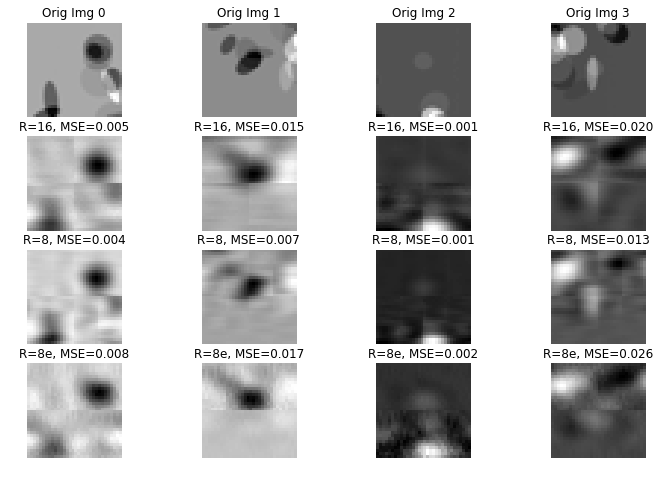

In [15]:
#DC_trainset = torch.utils.data.TensorDataset(DC_data,DC_data)
#DC_trainloader = torch.utils.data.DataLoader(DC_trainset, batch_size=batch_size,shuffle=True)
#dataiter = iter(testloader)
#images, labels = dataiter.next()
r = 16
GPU=torch.cuda.is_available()

trainednet16 = DeepCodec(16)
pathtoweights = './weights/trained/r=16/epoch_5000.cpu'
trainednet16.load_state_dict(torch.load(pathtoweights))

trainednet8 = DeepCodec(8)
pathtoweights8 = './weights/trained/r=8/epoch_5000.cpu'
trainednet8.load_state_dict(torch.load(pathtoweights8))

trainednet8e = DeepCodec(8)
pathtoweights8e = './weights/trained/ellipR=8/epoch_5000.cpu'
trainednet8e.load_state_dict(torch.load(pathtoweights8e))
if GPU:
    trainednet8.cuda()
    trainednet16.cuda()
    trainednet8e.cuda()
plt.figure(figsize=(12,8))
for i in range(4):
    img = batchtoimg(DC_data[2*i:2*(i+1)])
    plt.subplot(4,4,i+1)
    # print images
    imshow(img)
    plt.title('Orig Img %i' % i)
    
    inputVal = Variable(DC_data[2*i:2*(i+1)])
    if GPU:
        inputVal = inputVal.cuda()
    output = trainednet16(inputVal)
    netimg = batchtoimg(output.data)
    plt.subplot(4,4,4+i+1)
    imshow(netimg)
    plt.title('R=16, MSE=%.3f' % torch.mean((img-netimg)**2))
    
    output2 = trainednet8(inputVal)
    netimg2 = batchtoimg(output2.data)
    plt.subplot(4,4,8+i+1)
    imshow(netimg2)
    plt.title('R=8, MSE=%.3f' % torch.mean((img-netimg2)**2))

    
    output3 = trainednet8e(inputVal)
    netimg3 = batchtoimg(output3.data)
    plt.subplot(4,4,12+i+1)
    imshow(netimg3)
    plt.title('R=8e, MSE=%.3f' % torch.mean((img-netimg3)**2))

# Calculate MSEs

In [88]:
numdata = DC_data.shape[0]
train_mses8 = np.zeros(numdata)
train_mses8e = np.zeros(numdata)
train_mses16 = np.zeros(numdata)
GPU = True
if GPU:
    trainednet16.cuda()
    trainednet8.cuda()
    trainednet8e.cuda()
    
trainloader = torch.utils.data.DataLoader(DC_data, batch_size=100,shuffle=False)
for ii,data in enumerate(trainloader):
    if GPU:
        inputVal = Variable(data.cuda())
    else:
        inputVal = Variable(data)
    
    output = trainednet8(inputVal)
    train_mses8[ii*100:(ii+1)*100] = torch.mean((inputVal.data - output.data)**2,1)[:,0]
    
    output2 = trainednet16(inputVal)
    train_mses16[ii*100:(ii+1)*100] = torch.mean((inputVal.data - output2.data)**2,1)[:,0]
    
    output3 = trainednet8e(inputVal)
    train_mses8e[ii*100:(ii+1)*100] = torch.mean((inputVal.data - output3.data)**2,1)[:,0]
print('R=8, Training MSE = %.6f' % np.mean(train_mses8))
print('R=16, Training MSE = %.6f' % np.mean(train_mses16))
print('R=8e, Training MSE = %.6f' % np.mean(train_mses8e))


R=8, Training MSE = 0.000299
R=16, Training MSE = 0.000487
R=8e, Training MSE = 0.000637


In [89]:
numdata = DC_testdata.shape[0]
test_mses8 = np.zeros(numdata)
test_mses8e = np.zeros(numdata)
test_mses16 = np.zeros(numdata)
GPU = True
if GPU:
    trainednet16.cuda()
    trainednet8.cuda()
    trainednet8e.cuda()
    
testloader = torch.utils.data.DataLoader(DC_testdata, batch_size=100,shuffle=False)
for ii,data in enumerate(testloader):
    if GPU:
        inputVal = Variable(data.cuda())
    else:
        inputVal = Variable(data)
    
    output = trainednet8(inputVal)
    test_mses8[ii*100:(ii+1)*100] = torch.mean((inputVal.data - output.data)**2,1)[:,0]
    
    output2 = trainednet16(inputVal)
    test_mses16[ii*100:(ii+1)*100] = torch.mean((inputVal.data - output2.data)**2,1)[:,0]
    
    output3 = trainednet8e(inputVal)
    test_mses8e[ii*100:(ii+1)*100] = torch.mean((inputVal.data - output3.data)**2,1)[:,0]
print('R=8, Test MSE = %.6f' % np.mean(test_mses8))
print('R=16, Test MSE = %.6f' % np.mean(test_mses16))
print('R=8e, Test MSE = %.6f' % np.mean(test_mses8e))


R=8, Training MSE = 0.000311
R=16, Training MSE = 0.000475
R=8e, Training MSE = 0.000644


In [90]:
len(DC_data)

3200

# Test dataset size

In [9]:
N = 512
r = 8
GPU = True
batch_size = 1000
net = DeepCodec(r)
if GPU:
    net.cuda()
DC_trainset = torch.utils.data.TensorDataset(DC_data,DC_data)
DC_trainloader = torch.utils.data.DataLoader(DC_trainset, batch_size=batch_size,shuffle=True)
train_net(net, DC_trainloader, num_epochs=5000, GPU=GPU,
          weightpath='./weights/',save_epoch=500,
          lr=0.001,momentum=0.9,saveweights=True)

	[1,     1] loss: 0.024, 0.072 seconds elapsed
	[1,    11] loss: 0.232, 0.736 seconds elapsed
	[1,    21] loss: 0.232, 1.129 seconds elapsed
	[1,    31] loss: 0.231, 1.501 seconds elapsed
	[1,    41] loss: 0.232, 1.958 seconds elapsed
	[1,    51] loss: 0.233, 2.347 seconds elapsed
	[1,    61] loss: 0.233, 2.708 seconds elapsed
	[1,    71] loss: 0.232, 3.175 seconds elapsed
	[1,    81] loss: 0.230, 3.557 seconds elapsed
	[1,    91] loss: 0.234, 3.914 seconds elapsed
Epoch 1 Training Time: 4.326 seconds
Total Elapsed Time: 4.326 seconds
	[2,     1] loss: 0.024, 0.038 seconds elapsed
	[2,    11] loss: 0.231, 0.398 seconds elapsed
	[2,    21] loss: 0.229, 0.746 seconds elapsed
	[2,    31] loss: 0.228, 1.203 seconds elapsed
	[2,    41] loss: 0.231, 1.560 seconds elapsed
	[2,    51] loss: 0.229, 2.006 seconds elapsed
	[2,    61] loss: 0.228, 2.363 seconds elapsed
	[2,    71] loss: 0.231, 2.727 seconds elapsed
	[2,    81] loss: 0.227, 3.176 seconds elapsed
	[2,    91] loss: 0.230, 3.531 secon

KeyboardInterrupt: 

In [10]:

N = 512
r = 8
GPU = True
for batch_size in [5, 100, 500, 1000, 5000, 10000]:
    print('Testing batch size = %i' % (batch_size))
    net = DeepCodec(r)
    if GPU:
        net.cuda()
    DC_trainset = torch.utils.data.TensorDataset(DC_data,DC_data)
    DC_trainloader = torch.utils.data.DataLoader(DC_trainset, batch_size=batch_size,shuffle=True)
    train_net(net, DC_trainloader, num_epochs=1, GPU=GPU,
              weightpath='./weights/',save_epoch=250,
              lr=0.001,momentum=0.9,saveweights=False)

Testing batch size = 5
	[1,  2000] loss: 0.116, 15.046 seconds elapsed
	[1,  4000] loss: 0.080, 30.212 seconds elapsed
	[1,  6000] loss: 0.070, 46.152 seconds elapsed
	[1,  8000] loss: 0.064, 60.693 seconds elapsed
	[1, 10000] loss: 0.062, 75.078 seconds elapsed
	[1, 12000] loss: 0.060, 89.378 seconds elapsed
	[1, 14000] loss: 0.059, 103.848 seconds elapsed
	[1, 16000] loss: 0.058, 118.490 seconds elapsed
	[1, 18000] loss: 0.058, 133.849 seconds elapsed
	[1, 20000] loss: 0.058, 148.748 seconds elapsed
Epoch 1 Training Time: 148.749 seconds
Total Elapsed Time: 148.749 seconds
Finished Training
Testing batch size = 100
Epoch 1 Training Time: 13.742 seconds
Total Elapsed Time: 13.742 seconds
Finished Training
Testing batch size = 500
Epoch 1 Training Time: 9.985 seconds
Total Elapsed Time: 9.985 seconds
Finished Training
Testing batch size = 1000
Epoch 1 Training Time: 10.003 seconds
Total Elapsed Time: 10.003 seconds
Finished Training
Testing batch size = 5000
Epoch 1 Training Time: 10.4

## Without GPU

In [11]:
N = 512
r = 8
GPU = False
for batch_size in [5, 100, 500, 1000, 5000, 10000]:
    print('Testing batch size = %i' % (batch_size))
    net = DeepCodec(r)
    if GPU:
        net.cuda()
    DC_trainset = torch.utils.data.TensorDataset(DC_data,DC_data)
    DC_trainloader = torch.utils.data.DataLoader(DC_trainset, batch_size=batch_size,shuffle=True)
    train_net(net, DC_trainloader, num_epochs=1, GPU=GPU,
              weightpath='./weights/',save_epoch=250,
              lr=0.001,momentum=0.9,saveweights=False)

Testing batch size = 5
	[1,  2000] loss: 0.108, 8.632 seconds elapsed
	[1,  4000] loss: 0.080, 17.260 seconds elapsed
	[1,  6000] loss: 0.073, 25.863 seconds elapsed
	[1,  8000] loss: 0.069, 34.485 seconds elapsed
	[1, 10000] loss: 0.067, 43.121 seconds elapsed
	[1, 12000] loss: 0.063, 51.723 seconds elapsed
	[1, 14000] loss: 0.061, 60.305 seconds elapsed
	[1, 16000] loss: 0.061, 68.984 seconds elapsed
	[1, 18000] loss: 0.058, 77.594 seconds elapsed
	[1, 20000] loss: 0.056, 86.222 seconds elapsed
Epoch 1 Training Time: 86.223 seconds
Total Elapsed Time: 86.223 seconds
Finished Training
Testing batch size = 100
Epoch 1 Training Time: 124.523 seconds
Total Elapsed Time: 124.523 seconds
Finished Training
Testing batch size = 500
Epoch 1 Training Time: 123.234 seconds
Total Elapsed Time: 123.234 seconds
Finished Training
Testing batch size = 1000
Epoch 1 Training Time: 125.056 seconds
Total Elapsed Time: 125.056 seconds
Finished Training
Testing batch size = 5000
Epoch 1 Training Time: 129

	[1,  2000] loss: 0.133, 16.149 seconds elapsed
	[1,  4000] loss: 0.084, 30.454 seconds elapsed
	[1,  6000] loss: 0.076, 44.972 seconds elapsed
	[1,  8000] loss: 0.069, 59.767 seconds elapsed
	[1, 10000] loss: 0.064, 74.437 seconds elapsed
	[1, 12000] loss: 0.063, 89.137 seconds elapsed
	[1, 14000] loss: 0.061, 103.913 seconds elapsed
	[1, 16000] loss: 0.059, 118.704 seconds elapsed
	[1, 18000] loss: 0.058, 133.259 seconds elapsed
	[1, 20000] loss: 0.057, 147.871 seconds elapsed
Epoch 1 Training Time: 147.871 seconds
Total Elapsed Time: 147.871 seconds
Finished Training


## Example Reload Net

In [7]:
# Prepare Data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=4,
#                                         shuffle=False, num_workers=2)


DC_testdata = torch.zeros(2*len(testset),512,1)
for i,data in enumerate(testset):
    images, labels = data
    gray = rgbtogray(images)
    H,W = gray.size()
    H2 = int(H/2)
    DC_data[2*i] = gray[:H2,:].view(512,1)
    DC_data[2*i+1] = gray[H2:,:].view(512,1)



Files already downloaded and verified


In [8]:
DC_testset = torch.utils.data.TensorDataset(DC_testdata,DC_testdata)
DC_testloader = torch.utils.data.DataLoader(DC_testset, batch_size=2,shuffle=False)

In [9]:
# Load Weights

pathtoweights='./weights/trained/2018-04-01_23-58-55_trained/epoch_1001.weights'
r=8
trainednet = DeepCodec(r)
trainednet.load_state_dict(torch.load(pathtoweights))


In [11]:
dataiter = iter(DC_testloader)
images, labels = dataiter.next()

In [13]:
outputs = trainednet(Variable(images))


In [32]:
DC_testdata.size()

torch.Size([20000, 512, 1])

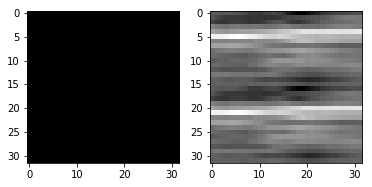

In [34]:
xhat = batchtoimg(outputs.data)
x = batchtoimg(DC_testdata[:2])
plt.figure()
plt.subplot(121)
imshow(x)
plt.subplot(122)
imshow(xhat)

In [172]:

for i in range(2):
    img, label = faketrainset[i]
    loss = F.mse_loss(Variable(img),Variable(label))
    print(loss[0])
    rimg = net.forward(Variable(img.unsqueeze(0)))
    print(F.mse_loss(rimg,Variable(label)))
    rimg = net2.forward(Variable(img.unsqueeze(0)))
    print(F.mse_loss(rimg,Variable(label)))
    #plt.figure()
    #plt.imshow()

Variable containing:
 0
[torch.FloatTensor of size 1]

Variable containing:
 1.0126
[torch.FloatTensor of size 1]

Variable containing:
 1.0126
[torch.FloatTensor of size 1]

Variable containing:
 0
[torch.FloatTensor of size 1]

Variable containing:
 1.0329
[torch.FloatTensor of size 1]

Variable containing:
 1.0329
[torch.FloatTensor of size 1]



In [4]:
N = 512
r = 8
GPU = True
for batch_size in [1000]:#[500, 1000, 5000, 10000]:
    print('Testing batch size = %i' % (batch_size))
    net = DeepCodec(r)
    if GPU:
        net.cuda()
    DC_trainset = torch.utils.data.TensorDataset(DC_data,DC_data)
    DC_trainloader = torch.utils.data.DataLoader(DC_trainset, batch_size=batch_size,shuffle=True)
    train_net(net, DC_trainloader, num_epochs=8, GPU=GPU,
              weightpath='./weights/',save_epoch=2,
              lr=0.001,momentum=0.9,saveweights=False)

Testing batch size = 1000
	[1,     1] loss: 0.024, 0.861 seconds elapsed
	[1,    11] loss: 0.232, 1.716 seconds elapsed
	[1,    21] loss: 0.230, 2.483 seconds elapsed
	[1,    31] loss: 0.230, 3.264 seconds elapsed
	[1,    41] loss: 0.231, 4.025 seconds elapsed
	[1,    51] loss: 0.230, 4.808 seconds elapsed
	[1,    61] loss: 0.229, 5.566 seconds elapsed
	[1,    71] loss: 0.230, 6.350 seconds elapsed
	[1,    81] loss: 0.224, 7.108 seconds elapsed
	[1,    91] loss: 0.227, 7.865 seconds elapsed
Epoch 1 Training Time: 8.568 seconds
Total Elapsed Time: 8.568 seconds
	[2,     1] loss: 0.023, 0.077 seconds elapsed
	[2,    11] loss: 0.225, 0.837 seconds elapsed
	[2,    21] loss: 0.223, 1.618 seconds elapsed
	[2,    31] loss: 0.220, 2.373 seconds elapsed
	[2,    41] loss: 0.213, 3.151 seconds elapsed
	[2,    51] loss: 0.202, 3.909 seconds elapsed
	[2,    61] loss: 0.180, 4.689 seconds elapsed
	[2,    71] loss: 0.167, 5.452 seconds elapsed
	[2,    81] loss: 0.158, 6.242 seconds elapsed
	[2,    91

In [10]:
temp = ''
for i in range(4):
    temp += '%i\t%f\t%f\t%f\n' % (1,float(10.0)/10,5,5)
temp

'1\t1.000000\t5.000000\t5.000000\n1\t1.000000\t5.000000\t5.000000\n1\t1.000000\t5.000000\t5.000000\n1\t1.000000\t5.000000\t5.000000\n'

In [23]:
len(DC_trainloader)
DC_trainloader.batch_size


10000

In [16]:
print('Test {}'.format((1.1234)))

Test 1.1234
